# SocialGAN

Utilizing a pretrained GAN model as a 4th method of trajectory perturbation

## Setup

In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

In [2]:
import numpy as np
from pactus import Dataset
from pactus.models import LSTMModel
import matplotlib.pyplot as plt

from traj_xai.src import rdp_segmentation, mdl_segmentation, sliding_window_segmentation, gaussian_perturbation, rotation_perturbation, scaling_perturbation, gan_perturbation, TrajectoryManipulator

c:\Users\nickz\miniconda3\envs\traj_xai\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## Load Dataset

In [3]:
# Set a random seed for reproducibility
SEED = 0

# Load the dataset
# dataset = Dataset.uci_pen_digits()
# dataset = Dataset.uci_movement_libras()
# dataset = Dataset.mnist_stroke()
# dataset = Dataset.animals()
dataset = Dataset.geolife()
print(f"Dataset loaded: {len(dataset.trajs)} trajectories")

# Split data into train and test subsets
# dataset = dataset.filter(lambda traj, _: len(traj) < 500)
train, test = dataset.split(0.8, random_state=SEED)
print(f"Train set: {len(train.trajs)} trajectories")
print(f"Test set: {len(test.trajs)} trajectories")

Dataset loaded: 9288 trajectories
Train set: 7430 trajectories
Test set: 1858 trajectories


## Plot Sample Trajectory

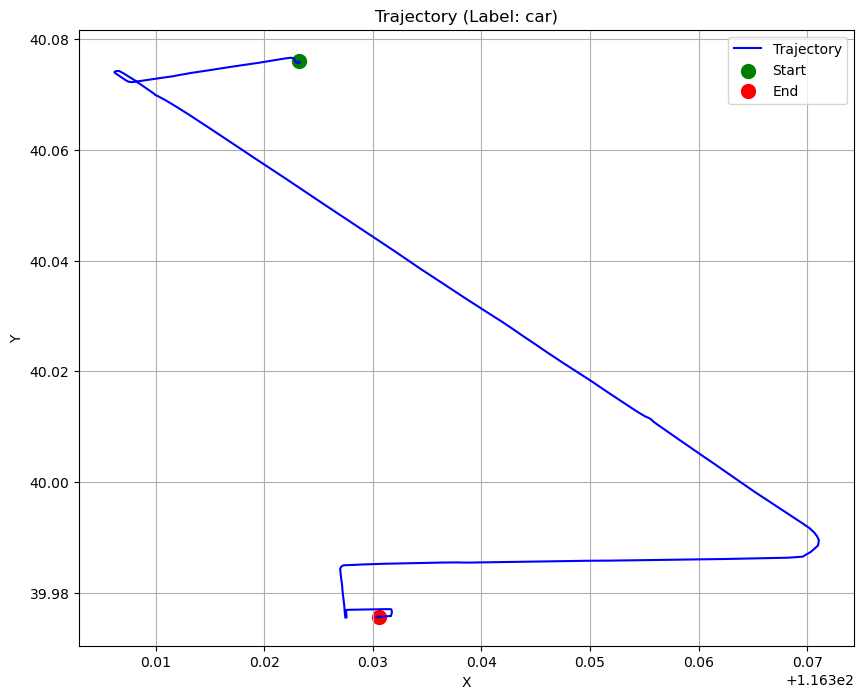

In [4]:
# Get a sample trajectory
sample_idx = 0
sample_traj = test.trajs[sample_idx]
sample_label = test.labels[sample_idx]

# Extract coordinates for plotting
points = sample_traj.r
x = [p[0] for p in points]
y = [p[1] for p in points]

# Plot the trajectory
plt.figure(figsize=(10, 8))
plt.plot(x, y, "b-", label="Trajectory")
plt.scatter(x[0], y[0], c="green", s=100, label="Start")
plt.scatter(x[-1], y[-1], c="red", s=100, label="End")
plt.title(f"Trajectory (Label: {sample_label})")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

## Segment the Trajectory

Number of segments: 5
[[Vector([116.3231666,  40.0759983])], [Vector([116.3231666,  40.0759983])], [Vector([116.3231683,  40.0759983]), Vector([116.3231916,  40.076    ]), Vector([116.3232099,  40.076    ]), Vector([116.3232316,  40.0760033]), Vector([116.3232316,  40.0760033]), Vector([116.3232383,  40.0760066]), Vector([116.3232316,  40.0759566]), Vector([116.323255 ,  40.0757733]), Vector([116.3231783,  40.0756966]), Vector([116.3231783,  40.0756966]), Vector([116.3231749,  40.0756966]), Vector([116.3231299,  40.075695 ]), Vector([116.3229533,  40.0757749]), Vector([116.3228733,  40.0760199]), Vector([116.3228299,  40.0762299]), Vector([116.322805 ,  40.0763883]), Vector([116.3227266,  40.0765466]), Vector([116.3224433,  40.0766783]), Vector([116.32193  ,  40.0765483]), Vector([116.3208349,  40.0761933]), Vector([116.3195299,  40.0757749]), Vector([116.3181733,  40.0753916]), Vector([116.31772  ,  40.0752599]), Vector([116.31772  ,  40.0752599]), Vector([116.31772  ,  40.0752583]), 

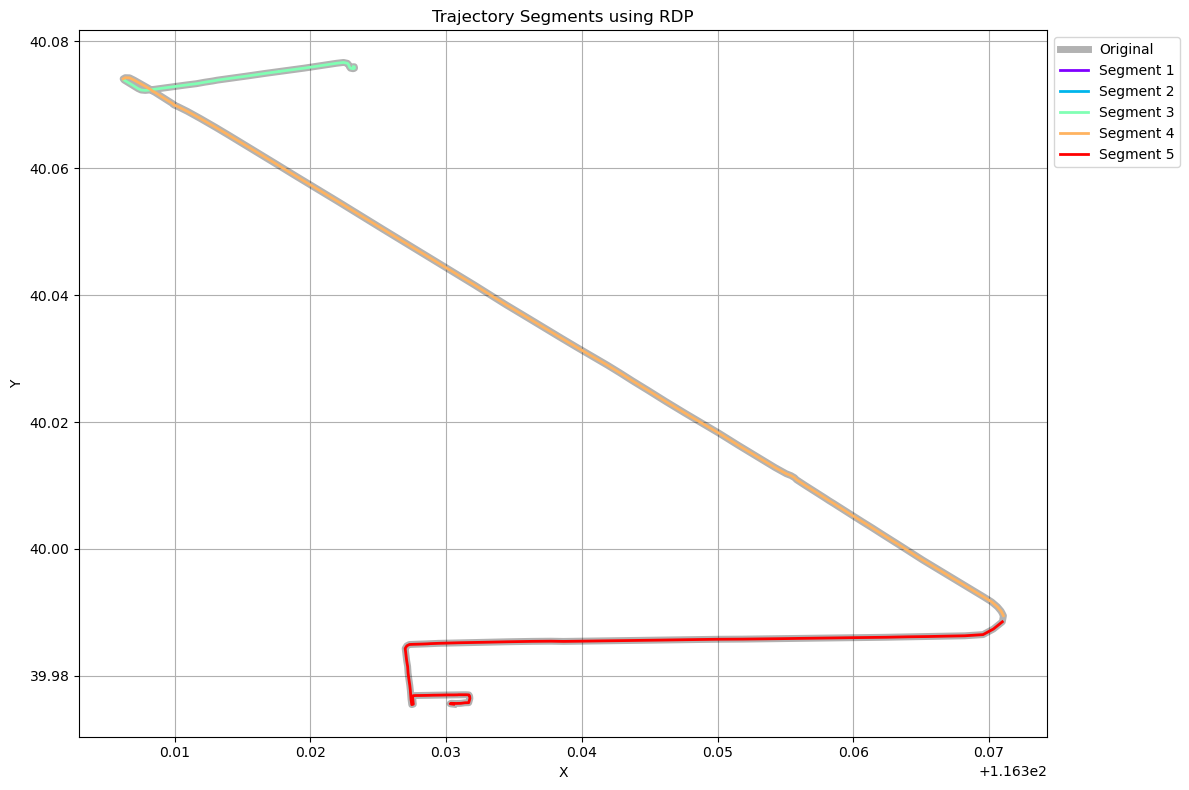

In [5]:
# Apply RDP segmentation
segments = rdp_segmentation(points, epsilon=0.01)
print(f"Number of segments: {len(segments)}")
print(segments)

# Plot the original trajectory and the segments
plt.figure(figsize=(12, 8))

# Plot original trajectory
plt.plot(x, y, "k-", alpha=0.3, linewidth=5, label="Original")

# Plot each segment with a different color
colors = plt.cm.rainbow(np.linspace(0, 1, len(segments)))
for i, segment in enumerate(segments):
    segment_x = [p[0] for p in segment]
    segment_y = [p[1] for p in segment]
    plt.plot(segment_x, segment_y, "-", color=colors[i], linewidth=2, label=f"Segment {i+1}")

plt.title("Trajectory Segments using RDP")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

## Perturb a Segment

scale: 0.101, preserve_endpoints: False
original: [Vector([116.3231666,  40.0759983])]
perturbed: [(np.float64(116.31709181567642), np.float64(40.06731765276091))]


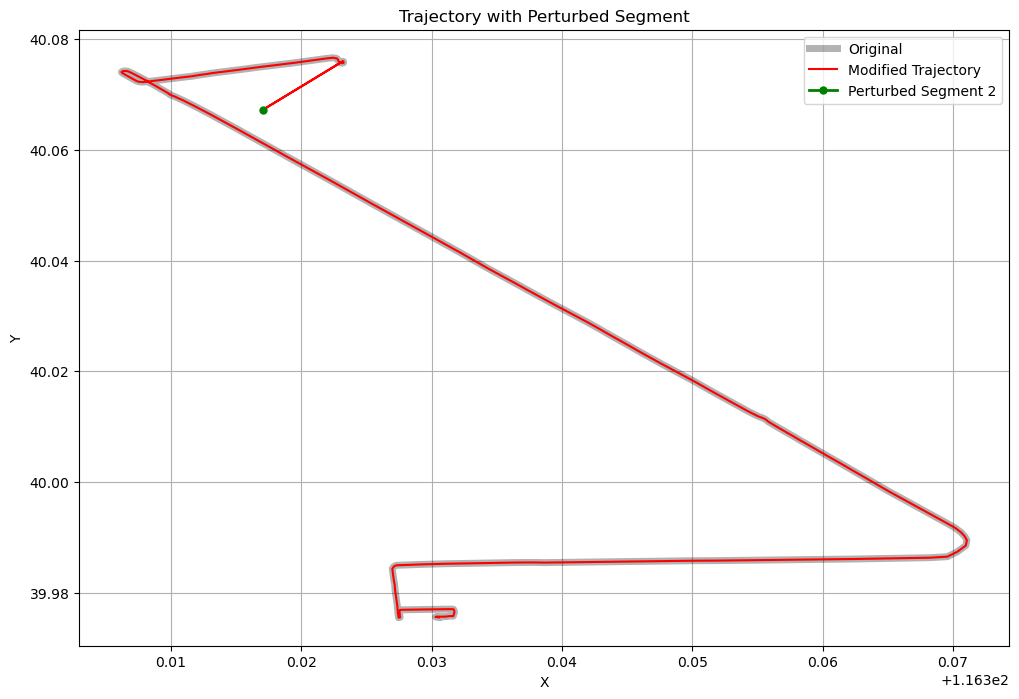

In [6]:
# Use GAN to apply to perturb one segment
segment_to_perturb = 1  # Choose which segment to perturb

scale = max(max(x) - min(x), max(y) - min(y))
preserve_endpoints = len(segments[segment_to_perturb]) > 2
print(f"scale: {scale:.3f}, preserve_endpoints: {preserve_endpoints}")

perturbed_segment = gan_perturbation(segments[segment_to_perturb], scale=scale, preserve_endpoints=preserve_endpoints)

print(f"original: {segments[segment_to_perturb]}")
print(f"perturbed: {perturbed_segment}")

# Visualize the perturbation
plt.figure(figsize=(12, 8))

# Plot original trajectory
plt.plot(x, y, "k-", alpha=0.3, lw=5, label="Original")

# Create a modified trajectory by replacing the perturbed segment
modified_segments = segments.copy()
modified_segments[segment_to_perturb] = perturbed_segment
modified_trajectory = []
for segment in modified_segments:
    modified_trajectory.extend(segment)

# Plot modified trajectory
modified_x = [p[0] for p in modified_trajectory]
modified_y = [p[1] for p in modified_trajectory]
plt.plot(modified_x, modified_y, "r-", label="Modified Trajectory")

# Highlight the perturbed segment
perturbed_x = [p[0] for p in perturbed_segment]
perturbed_y = [p[1] for p in perturbed_segment]
plt.plot(
    perturbed_x,
    perturbed_y,
    "g.-",
    linewidth=2,
    markersize=10,
    label=f"Perturbed Segment {segment_to_perturb+1}",
)

plt.title("Trajectory with Perturbed Segment")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def visualize_perturbation(x, y, segments, segment_to_perturb, perturbed_segment):
    # Visualize the perturbation
    plt.figure(figsize=(12, 8))

    # Plot original trajectory
    plt.plot(x, y, "k-", alpha=0.3, lw=5, label="Original")

    # Create a modified trajectory by replacing the perturbed segment
    modified_segments = segments.copy()
    modified_segments[segment_to_perturb] = perturbed_segment
    modified_trajectory = []
    for segment in modified_segments:
        modified_trajectory.extend(segment)

    # Plot modified trajectory
    modified_x = [p[0] for p in modified_trajectory]
    modified_y = [p[1] for p in modified_trajectory]
    plt.plot(modified_x, modified_y, "r-", label="Modified Trajectory")

    # Highlight the perturbed segment
    perturbed_x = [p[0] for p in perturbed_segment]
    perturbed_y = [p[1] for p in perturbed_segment]
    plt.plot(
        perturbed_x,
        perturbed_y,
        "g-",
        linewidth=2,
        label=f"Perturbed Segment {segment_to_perturb+1}",
    )

    plt.title("Trajectory with Perturbed Segment")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

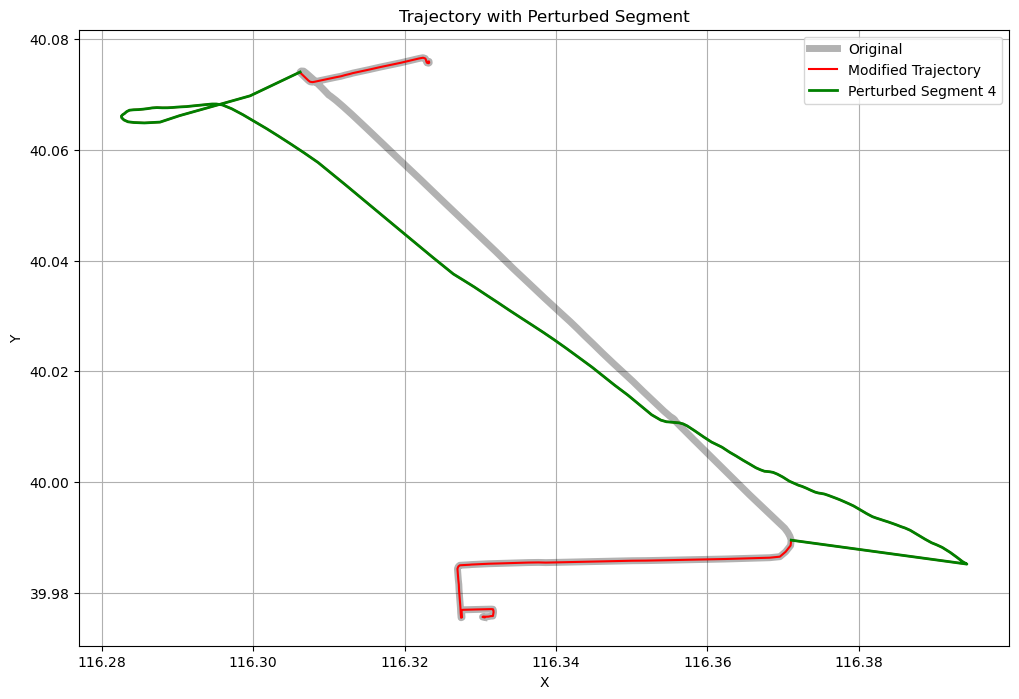

In [8]:
limit = 1

for i in range(min(limit, len(test.trajs))):
    points = test.trajs[i].r
    x = [p[0] for p in points]
    y = [p[1] for p in points]

    segments = rdp_segmentation(points, epsilon=0.01)
    
    segment_to_perturb = np.random.randint(0, len(segments))
    scale = max(max(x) - min(x), max(y) - min(y))
    preserve_endpoints = len(segments[segment_to_perturb]) > 2
    perturbed_segment = gan_perturbation(segments[segment_to_perturb], scale=scale, preserve_endpoints=preserve_endpoints)

    visualize_perturbation(x, y, segments, segment_to_perturb, perturbed_segment)

## Train Black-box Model

In [15]:
# Build and train the model
model = LSTMModel(random_state=SEED)

# Train the model on the train dataset (with fewer epochs for demo)
model.train(train, dataset, epochs=5, batch_size=64)

# Evaluate the model on the test dataset
evaluation = model.evaluate(test)
evaluation.show()

18:27:32 [WARNING] Custom seed provided for lstm model. This calls 'tf.keras.utils.set_random_seed' which sets a global random state on python, numpy and tensorflow.


Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 79s 928ms/step - accuracy: 0.4727 - loss: 1.6269
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 76s 944ms/step - accuracy: 0.5036 - loss: 1.4299
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 79s 980ms/step - accuracy: 0.5063 - loss: 1.3977
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 81s 997ms/step - accuracy: 0.5109 - loss: 1.3780
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 78s 964ms/step - accuracy: 0.5076 - loss: 1.3710
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step

General statistics:

Accuracy: 0.500
F1-score: 0.071
Mean precision: 0.150
Mean recall: 0.102

Confusion matrix:

airplane  bike      boat      bus       car       run       subway    taxi      train     walk      precision 
0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       
0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       
0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0

## Run TrajectoryManipulator and get fidelity metrics

In [48]:
n_explainable = 0
precision = 0  # total per-trajectory precision

for traj in test.trajs:
    points = traj.r

    trajectory_explainer = TrajectoryManipulator(points, rdp_segmentation, gaussian_perturbation, model)

    y_eval_sorted = trajectory_explainer.get_Y_eval_sorted()
    original_pred = trajectory_explainer.get_Y()

    count = 0  # running count of segments that change classification when perturbed
    precision_x = 0
    for i, pred in enumerate(y_eval_sorted):
        # Check if predictions differ
        val = 0 if np.allclose(pred, original_pred) else 1
        if val == 1:
            count += 1
        precision_x += val * (count / (i+1))
        # if not np.allclose(pred, original_pred):  # Check if predictions differ
        #     count += 1
        #     precision_x += count / (i+1)

    if count > 0:
        n_explainable += 1
        precision_x /= count
        precision += precision_x

precision /= len(test.trajs)
recall = n_explainable / len(test.trajs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━

In [49]:
h_mean = np.nan if recall == 0 else (2 * precision * recall) / (precision + recall)

In [50]:
print(f"Final Metrics:\nRecall {recall:.3f}\nPrecision {precision:.3f}\nH-Mean {h_mean:.3f}")

Final Metrics:
Recall 0.000
Precision 0.000
H-Mean nan


In [51]:
test_precision = 1.0
test_h_mean = (2 * test_precision * recall) / (test_precision + recall)
print(f"Final Metrics:\nRecall {recall:.3f}\nPrecision {test_precision:.3f}\nH-Mean {test_h_mean:.3f}")

Final Metrics:
Recall 0.000
Precision 1.000
H-Mean 0.000


## Final Experiment

Replicating the steps from final-experiment.ipynb with the GAN perturbation method

In [4]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from pactus import Dataset

from traj_xai.src import (
    SimpleTransformerModel, 
    TrajFormerModel, 
    mdl_segmentation, 
    rdp_segmentation, 
    sliding_window_segmentation, 
    gaussian_perturbation, 
    scaling_perturbation, 
    rotation_perturbation, 
    gan_perturbation, 
    run_experiments
)

In [2]:
SEED = 0

# Load dataset
dataset = Dataset.uci_characters()

# Split data into train and test subsets
train, test = dataset.split(0.8, random_state=SEED)

# Build and train the model
model = TrajFormerModel(
    c_out=len(dataset.classes),
)

# Train the model on the train dataset
model.train(train, dataset, epochs=10, batch_size=64)

# Evaluate the model on a test dataset
evaluation = model.evaluate(test)

# Print the evaluation
evaluation.show()

03:21:24 [INFO] Epoch 10/10, Loss: 26.1053
03:21:24 [INFO] Trained TrajFormer model with 2286 samples



General statistics:

Accuracy: 0.752
F1-score: 0.731
Mean precision: 0.742
Mean recall: 0.739

Confusion matrix:

a      b      c      d      e      g      h      l      m      n      o      p      q      r      s      u      v      w      y      z      precision
38.24  0.0    0.0    0.0    0.0    7.14   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    3.85   0.0    0.0    0.0    0.0    81.25  
2.94   89.29  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    12.0   0.0    0.0    3.85   0.0    0.0    3.7    0.0    80.65  
0.0    0.0    100.0  0.0    0.0    3.57   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    96.67  
0.0    0.0    0.0    100.0  0.0    0.0    0.0    0.0    0.0    0.0    0.0    3.85   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    96.97  
0.0    0.0    0.0    0.0    100.0  0.0    0.0    0.0    0.0    0.0    0.0    7.69   0.0    4.17   0.0    0.0    0.0    0.0    0.0    2.94   90.

In [6]:
segment_func = [sliding_window_segmentation, mdl_segmentation, rdp_segmentation]
perturbation_func = [gan_perturbation]

run_experiments(test, segment_func, perturbation_func, model)

03:24:07 [INFO] Running experiment with sliding_window_segmentation and gan_perturbation
03:24:07 [DEBUG] Starting explanation process...
03:24:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:08 [WARNING] Only one class detected, skipping explanation.
03:24:08 [INFO] Trajectory 0: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [0, 'traj_b477410c', 0, 0.0, 'ok']
2025-11-29 03:24:08 - Total RAM: 13.86 GB | Used: 69.3%


03:24:09 [DEBUG] Starting explanation process...
03:24:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:10 [WARNING] Only one class detected, skipping explanation.
03:24:10 [INFO] Trajectory 1: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [1, 'traj_9b6e1be1', 0, 0.0, 'ok']


03:24:10 [DEBUG] Starting explanation process...
03:24:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:11 [WARNING] Only one class detected, skipping explanation.
03:24:11 [INFO] Trajectory 2: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [2, 'traj_9e36048d', 0, 0.0, 'ok']


03:24:12 [DEBUG] Starting explanation process...
03:24:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:13 [WARNING] Only one class detected, skipping explanation.
03:24:13 [INFO] Trajectory 3: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [3, 'traj_9c1c91f8', 0, 0.0, 'ok']


03:24:13 [DEBUG] Starting explanation process...
03:24:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:14 [WARNING] Only one class detected, skipping explanation.
03:24:14 [INFO] Trajectory 4: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [4, 'traj_3ba56992', 0, 0.0, 'ok']


03:24:14 [DEBUG] Starting explanation process...
03:24:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:15 [WARNING] Only one class detected, skipping explanation.
03:24:15 [INFO] Trajectory 5: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [5, 'traj_d26178e7', 0, 0.0, 'ok']


03:24:16 [DEBUG] Starting explanation process...
03:24:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:17 [WARNING] Only one class detected, skipping explanation.
03:24:17 [INFO] Trajectory 6: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [6, 'traj_068e7be5', 0, 0.0, 'ok']


03:24:17 [DEBUG] Starting explanation process...
03:24:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:18 [WARNING] Only one class detected, skipping explanation.
03:24:18 [INFO] Trajectory 7: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [7, 'traj_66293cbb', 0, 0.0, 'ok']


03:24:19 [DEBUG] Starting explanation process...
03:24:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:20 [WARNING] Only one class detected, skipping explanation.
03:24:20 [INFO] Trajectory 8: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [8, 'traj_1351920f', 0, 0.0, 'ok']


03:24:20 [DEBUG] Starting explanation process...
03:24:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:21 [WARNING] Only one class detected, skipping explanation.
03:24:21 [INFO] Trajectory 9: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [9, 'traj_0f543302', 0, 0.0, 'ok']


03:24:21 [DEBUG] Starting explanation process...
03:24:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:22 [WARNING] Only one class detected, skipping explanation.
03:24:22 [INFO] Trajectory 10: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [10, 'traj_fa300f08', 0, 0.0, 'ok']
2025-11-29 03:24:22 - Total RAM: 13.86 GB | Used: 68.7%


03:24:23 [DEBUG] Starting explanation process...
03:24:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:24 [WARNING] Only one class detected, skipping explanation.
03:24:24 [INFO] Trajectory 11: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [11, 'traj_cdd40c87', 0, 0.0, 'ok']


03:24:24 [DEBUG] Starting explanation process...
03:24:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:25 [WARNING] Only one class detected, skipping explanation.
03:24:25 [INFO] Trajectory 12: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [12, 'traj_a377ce57', 0, 0.0, 'ok']


03:24:26 [DEBUG] Starting explanation process...
03:24:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:27 [WARNING] Only one class detected, skipping explanation.
03:24:27 [INFO] Trajectory 13: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [13, 'traj_35c79f9d', 0, 0.0, 'ok']


03:24:27 [DEBUG] Starting explanation process...
03:24:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:28 [WARNING] Only one class detected, skipping explanation.
03:24:28 [INFO] Trajectory 14: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [14, 'traj_9b2c6886', 0, 0.0, 'ok']


03:24:29 [DEBUG] Starting explanation process...
03:24:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:30 [WARNING] Only one class detected, skipping explanation.
03:24:30 [INFO] Trajectory 15: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [15, 'traj_e4f0d8e5', 0, 0.0, 'ok']


03:24:30 [DEBUG] Starting explanation process...
03:24:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:31 [WARNING] Only one class detected, skipping explanation.
03:24:31 [INFO] Trajectory 16: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [16, 'traj_25bbbd47', 0, 0.0, 'ok']


03:24:32 [DEBUG] Starting explanation process...
03:24:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:33 [WARNING] Only one class detected, skipping explanation.
03:24:33 [INFO] Trajectory 17: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [17, 'traj_01c04e7d', 0, 0.0, 'ok']


03:24:33 [DEBUG] Starting explanation process...
03:24:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:34 [WARNING] Only one class detected, skipping explanation.
03:24:34 [INFO] Trajectory 18: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [18, 'traj_bf6a49ad', 0, 0.0, 'ok']


03:24:35 [DEBUG] Starting explanation process...
03:24:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:35 [WARNING] Only one class detected, skipping explanation.
03:24:35 [INFO] Trajectory 19: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [19, 'traj_16a3d9bc', 0, 0.0, 'ok']


03:24:36 [DEBUG] Starting explanation process...
03:24:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:37 [WARNING] Only one class detected, skipping explanation.
03:24:37 [INFO] Trajectory 20: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [20, 'traj_d131bbe9', 0, 0.0, 'ok']
2025-11-29 03:24:37 - Total RAM: 13.86 GB | Used: 69.0%


03:24:38 [DEBUG] Starting explanation process...
03:24:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:39 [WARNING] Only one class detected, skipping explanation.
03:24:39 [INFO] Trajectory 21: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [21, 'traj_834ae388', 0, 0.0, 'ok']


03:24:39 [DEBUG] Starting explanation process...
03:24:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:40 [WARNING] Only one class detected, skipping explanation.
03:24:40 [INFO] Trajectory 22: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [22, 'traj_ddd2a33f', 0, 0.0, 'ok']


03:24:41 [DEBUG] Starting explanation process...
03:24:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:42 [WARNING] Only one class detected, skipping explanation.
03:24:42 [INFO] Trajectory 23: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [23, 'traj_def00cab', 0, 0.0, 'ok']


03:24:42 [DEBUG] Starting explanation process...
03:24:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:43 [WARNING] Only one class detected, skipping explanation.
03:24:43 [INFO] Trajectory 24: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [24, 'traj_27e66e21', 0, 0.0, 'ok']


03:24:44 [DEBUG] Starting explanation process...
03:24:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:45 [WARNING] Only one class detected, skipping explanation.
03:24:45 [INFO] Trajectory 25: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [25, 'traj_a9753438', 0, 0.0, 'ok']


03:24:45 [DEBUG] Starting explanation process...
03:24:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:46 [WARNING] Only one class detected, skipping explanation.
03:24:46 [INFO] Trajectory 26: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [26, 'traj_4ef12f44', 0, 0.0, 'ok']


03:24:46 [DEBUG] Starting explanation process...
03:24:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:47 [WARNING] Only one class detected, skipping explanation.
03:24:47 [INFO] Trajectory 27: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [27, 'traj_5e9f3b9d', 0, 0.0, 'ok']


03:24:47 [DEBUG] Starting explanation process...
03:24:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:48 [WARNING] Only one class detected, skipping explanation.
03:24:48 [INFO] Trajectory 28: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [28, 'traj_480d9d31', 0, 0.0, 'ok']


03:24:49 [DEBUG] Starting explanation process...
03:24:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:50 [WARNING] Only one class detected, skipping explanation.
03:24:50 [INFO] Trajectory 29: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [29, 'traj_669ce57f', 0, 0.0, 'ok']


03:24:50 [DEBUG] Starting explanation process...
03:24:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:51 [WARNING] Only one class detected, skipping explanation.
03:24:51 [INFO] Trajectory 30: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [30, 'traj_8144e41a', 0, 0.0, 'ok']
2025-11-29 03:24:51 - Total RAM: 13.86 GB | Used: 69.0%


03:24:52 [DEBUG] Starting explanation process...
03:24:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:53 [WARNING] Only one class detected, skipping explanation.
03:24:53 [INFO] Trajectory 31: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [31, 'traj_6d228531', 0, 0.0, 'ok']


03:24:53 [DEBUG] Starting explanation process...
03:24:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:54 [WARNING] Only one class detected, skipping explanation.
03:24:54 [INFO] Trajectory 32: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [32, 'traj_91226a19', 0, 0.0, 'ok']


03:24:55 [DEBUG] Starting explanation process...
03:24:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:56 [WARNING] Only one class detected, skipping explanation.
03:24:56 [INFO] Trajectory 33: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [33, 'traj_5f194d1f', 0, 0.0, 'ok']


03:24:56 [DEBUG] Starting explanation process...
03:24:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:57 [WARNING] Only one class detected, skipping explanation.
03:24:57 [INFO] Trajectory 34: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [34, 'traj_7497b721', 0, 0.0, 'ok']


03:24:57 [DEBUG] Starting explanation process...
03:24:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:24:58 [WARNING] Only one class detected, skipping explanation.
03:24:58 [INFO] Trajectory 35: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [35, 'traj_ca5d99fd', 0, 0.0, 'ok']


03:24:59 [DEBUG] Starting explanation process...
03:25:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:00 [WARNING] Only one class detected, skipping explanation.
03:25:00 [INFO] Trajectory 36: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [36, 'traj_ad8bc390', 0, 0.0, 'ok']


03:25:00 [DEBUG] Starting explanation process...
03:25:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:01 [WARNING] Only one class detected, skipping explanation.
03:25:01 [INFO] Trajectory 37: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [37, 'traj_95814bbb', 0, 0.0, 'ok']


03:25:01 [DEBUG] Starting explanation process...
03:25:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:02 [WARNING] Only one class detected, skipping explanation.
03:25:02 [INFO] Trajectory 38: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [38, 'traj_c72fee5f', 0, 0.0, 'ok']


03:25:03 [DEBUG] Starting explanation process...
03:25:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:04 [WARNING] Only one class detected, skipping explanation.
03:25:04 [INFO] Trajectory 39: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [39, 'traj_edc2d77b', 0, 0.0, 'ok']


03:25:04 [DEBUG] Starting explanation process...
03:25:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:05 [WARNING] Only one class detected, skipping explanation.
03:25:05 [INFO] Trajectory 40: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [40, 'traj_d6b1d68e', 0, 0.0, 'ok']
2025-11-29 03:25:05 - Total RAM: 13.86 GB | Used: 68.9%


03:25:06 [DEBUG] Starting explanation process...
03:25:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:07 [WARNING] Only one class detected, skipping explanation.
03:25:07 [INFO] Trajectory 41: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [41, 'traj_05ba96ec', 0, 0.0, 'ok']


03:25:07 [DEBUG] Starting explanation process...
03:25:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:08 [WARNING] Only one class detected, skipping explanation.
03:25:08 [INFO] Trajectory 42: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [42, 'traj_b42cbd09', 0, 0.0, 'ok']


03:25:09 [DEBUG] Starting explanation process...
03:25:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:10 [WARNING] Only one class detected, skipping explanation.
03:25:10 [INFO] Trajectory 43: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [43, 'traj_de58a859', 0, 0.0, 'ok']


03:25:10 [DEBUG] Starting explanation process...
03:25:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:11 [WARNING] Only one class detected, skipping explanation.
03:25:11 [INFO] Trajectory 44: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [44, 'traj_3339466f', 0, 0.0, 'ok']


03:25:12 [DEBUG] Starting explanation process...
03:25:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:13 [WARNING] Only one class detected, skipping explanation.
03:25:13 [INFO] Trajectory 45: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [45, 'traj_6d6159a4', 0, 0.0, 'ok']


03:25:13 [DEBUG] Starting explanation process...
03:25:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:14 [WARNING] Only one class detected, skipping explanation.
03:25:14 [INFO] Trajectory 46: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [46, 'traj_4701b27d', 0, 0.0, 'ok']


03:25:15 [DEBUG] Starting explanation process...
03:25:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:16 [WARNING] Only one class detected, skipping explanation.
03:25:16 [INFO] Trajectory 47: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [47, 'traj_3d48b402', 0, 0.0, 'ok']


03:25:16 [DEBUG] Starting explanation process...
03:25:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:17 [WARNING] Only one class detected, skipping explanation.
03:25:17 [INFO] Trajectory 48: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [48, 'traj_73f09118', 0, 0.0, 'ok']


03:25:17 [DEBUG] Starting explanation process...
03:25:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:18 [WARNING] Only one class detected, skipping explanation.
03:25:18 [INFO] Trajectory 49: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [49, 'traj_68dd70f5', 0, 0.0, 'ok']


03:25:19 [DEBUG] Starting explanation process...
03:25:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:19 [WARNING] Only one class detected, skipping explanation.
03:25:19 [INFO] Trajectory 50: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [50, 'traj_4473fcd8', 0, 0.0, 'ok']
2025-11-29 03:25:19 - Total RAM: 13.86 GB | Used: 69.0%


03:25:20 [DEBUG] Starting explanation process...
03:25:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:21 [WARNING] Only one class detected, skipping explanation.
03:25:21 [INFO] Trajectory 51: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [51, 'traj_464b2dab', 0, 0.0, 'ok']


03:25:21 [DEBUG] Starting explanation process...
03:25:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:22 [WARNING] Only one class detected, skipping explanation.
03:25:22 [INFO] Trajectory 52: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [52, 'traj_405c1ad0', 0, 0.0, 'ok']


03:25:23 [DEBUG] Starting explanation process...
03:25:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:23 [WARNING] Only one class detected, skipping explanation.
03:25:23 [INFO] Trajectory 53: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [53, 'traj_4e2293c7', 0, 0.0, 'ok']


03:25:24 [DEBUG] Starting explanation process...
03:25:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:25 [WARNING] Only one class detected, skipping explanation.
03:25:25 [INFO] Trajectory 54: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [54, 'traj_5c461b95', 0, 0.0, 'ok']


03:25:25 [DEBUG] Starting explanation process...
03:25:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:26 [WARNING] Only one class detected, skipping explanation.
03:25:26 [INFO] Trajectory 55: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [55, 'traj_2fc5e488', 0, 0.0, 'ok']


03:25:27 [DEBUG] Starting explanation process...
03:25:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:28 [WARNING] Only one class detected, skipping explanation.
03:25:28 [INFO] Trajectory 56: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [56, 'traj_f382fffe', 0, 0.0, 'ok']


03:25:28 [DEBUG] Starting explanation process...
03:25:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:29 [WARNING] Only one class detected, skipping explanation.
03:25:29 [INFO] Trajectory 57: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [57, 'traj_bfb13f07', 0, 0.0, 'ok']


03:25:30 [DEBUG] Starting explanation process...
03:25:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:31 [WARNING] Only one class detected, skipping explanation.
03:25:31 [INFO] Trajectory 58: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [58, 'traj_e01b8b4c', 0, 0.0, 'ok']


03:25:31 [DEBUG] Starting explanation process...
03:25:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:32 [WARNING] Only one class detected, skipping explanation.
03:25:32 [INFO] Trajectory 59: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [59, 'traj_d6078568', 0, 0.0, 'ok']


03:25:33 [DEBUG] Starting explanation process...
03:25:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:34 [WARNING] Only one class detected, skipping explanation.
03:25:34 [INFO] Trajectory 60: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [60, 'traj_63ee7559', 0, 0.0, 'ok']
2025-11-29 03:25:34 - Total RAM: 13.86 GB | Used: 69.0%


03:25:34 [DEBUG] Starting explanation process...
03:25:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:35 [WARNING] Only one class detected, skipping explanation.
03:25:35 [INFO] Trajectory 61: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [61, 'traj_fd99bafd', 0, 0.0, 'ok']


03:25:35 [DEBUG] Starting explanation process...
03:25:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:36 [WARNING] Only one class detected, skipping explanation.
03:25:36 [INFO] Trajectory 62: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [62, 'traj_0f4e54c0', 0, 0.0, 'ok']


03:25:37 [DEBUG] Starting explanation process...
03:25:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:38 [WARNING] Only one class detected, skipping explanation.
03:25:38 [INFO] Trajectory 63: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [63, 'traj_4bda4d5c', 0, 0.0, 'ok']


03:25:38 [DEBUG] Starting explanation process...
03:25:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:39 [WARNING] Only one class detected, skipping explanation.
03:25:39 [INFO] Trajectory 64: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [64, 'traj_65be26d3', 0, 0.0, 'ok']


03:25:39 [DEBUG] Starting explanation process...
03:25:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:40 [WARNING] Only one class detected, skipping explanation.
03:25:40 [INFO] Trajectory 65: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [65, 'traj_96083415', 0, 0.0, 'ok']


03:25:41 [DEBUG] Starting explanation process...
03:25:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:42 [WARNING] Only one class detected, skipping explanation.
03:25:42 [INFO] Trajectory 66: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [66, 'traj_b2b5d9a9', 0, 0.0, 'ok']


03:25:43 [DEBUG] Starting explanation process...
03:25:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:44 [WARNING] Only one class detected, skipping explanation.
03:25:44 [INFO] Trajectory 67: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [67, 'traj_5becd1e8', 0, 0.0, 'ok']


03:25:44 [DEBUG] Starting explanation process...
03:25:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:45 [WARNING] Only one class detected, skipping explanation.
03:25:45 [INFO] Trajectory 68: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [68, 'traj_19e2ec74', 0, 0.0, 'ok']


03:25:46 [DEBUG] Starting explanation process...
03:25:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:47 [WARNING] Only one class detected, skipping explanation.
03:25:47 [INFO] Trajectory 69: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [69, 'traj_1eb659e8', 0, 0.0, 'ok']


03:25:47 [DEBUG] Starting explanation process...
03:25:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:48 [WARNING] Only one class detected, skipping explanation.
03:25:48 [INFO] Trajectory 70: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [70, 'traj_d48f0723', 0, 0.0, 'ok']
2025-11-29 03:25:48 - Total RAM: 13.86 GB | Used: 68.0%


03:25:49 [DEBUG] Starting explanation process...
03:25:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:50 [WARNING] Only one class detected, skipping explanation.
03:25:50 [INFO] Trajectory 71: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [71, 'traj_7dacfa78', 0, 0.0, 'ok']


03:25:50 [DEBUG] Starting explanation process...
03:25:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:51 [WARNING] Only one class detected, skipping explanation.
03:25:51 [INFO] Trajectory 72: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [72, 'traj_c76bb9fa', 0, 0.0, 'ok']


03:25:52 [DEBUG] Starting explanation process...
03:25:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:53 [WARNING] Only one class detected, skipping explanation.
03:25:53 [INFO] Trajectory 73: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [73, 'traj_98cdd10c', 0, 0.0, 'ok']


03:25:53 [DEBUG] Starting explanation process...
03:25:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:54 [WARNING] Only one class detected, skipping explanation.
03:25:54 [INFO] Trajectory 74: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [74, 'traj_29872003', 0, 0.0, 'ok']


03:25:55 [DEBUG] Starting explanation process...
03:25:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:56 [WARNING] Only one class detected, skipping explanation.
03:25:56 [INFO] Trajectory 75: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [75, 'traj_3ef8dca5', 0, 0.0, 'ok']


03:25:56 [DEBUG] Starting explanation process...
03:25:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:57 [WARNING] Only one class detected, skipping explanation.
03:25:57 [INFO] Trajectory 76: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [76, 'traj_6c968e81', 0, 0.0, 'ok']


03:25:58 [DEBUG] Starting explanation process...
03:25:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:25:59 [WARNING] Only one class detected, skipping explanation.
03:25:59 [INFO] Trajectory 77: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [77, 'traj_c30a389c', 0, 0.0, 'ok']


03:25:59 [DEBUG] Starting explanation process...
03:26:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:00 [WARNING] Only one class detected, skipping explanation.
03:26:00 [INFO] Trajectory 78: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [78, 'traj_c022bf8c', 0, 0.0, 'ok']


03:26:00 [DEBUG] Starting explanation process...
03:26:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:01 [WARNING] Only one class detected, skipping explanation.
03:26:01 [INFO] Trajectory 79: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [79, 'traj_4269f4b8', 0, 0.0, 'ok']


03:26:02 [DEBUG] Starting explanation process...
03:26:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:03 [WARNING] Only one class detected, skipping explanation.
03:26:03 [INFO] Trajectory 80: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [80, 'traj_2786c6a7', 0, 0.0, 'ok']
2025-11-29 03:26:03 - Total RAM: 13.86 GB | Used: 67.9%


03:26:03 [DEBUG] Starting explanation process...
03:26:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:04 [WARNING] Only one class detected, skipping explanation.
03:26:04 [INFO] Trajectory 81: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [81, 'traj_a8db7b7f', 0, 0.0, 'ok']


03:26:04 [DEBUG] Starting explanation process...
03:26:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:05 [WARNING] Only one class detected, skipping explanation.
03:26:05 [INFO] Trajectory 82: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [82, 'traj_4e833d0c', 0, 0.0, 'ok']


03:26:06 [DEBUG] Starting explanation process...
03:26:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:07 [WARNING] Only one class detected, skipping explanation.
03:26:07 [INFO] Trajectory 83: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [83, 'traj_a1287773', 0, 0.0, 'ok']


03:26:07 [DEBUG] Starting explanation process...
03:26:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:08 [WARNING] Only one class detected, skipping explanation.
03:26:08 [INFO] Trajectory 84: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [84, 'traj_edcbb0e2', 0, 0.0, 'ok']


03:26:09 [DEBUG] Starting explanation process...
03:26:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:10 [WARNING] Only one class detected, skipping explanation.
03:26:10 [INFO] Trajectory 85: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [85, 'traj_c145051d', 0, 0.0, 'ok']


03:26:10 [DEBUG] Starting explanation process...
03:26:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:11 [WARNING] Only one class detected, skipping explanation.
03:26:11 [INFO] Trajectory 86: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [86, 'traj_84f5336c', 0, 0.0, 'ok']


03:26:12 [DEBUG] Starting explanation process...
03:26:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:13 [WARNING] Only one class detected, skipping explanation.
03:26:13 [INFO] Trajectory 87: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [87, 'traj_697b51cf', 0, 0.0, 'ok']


03:26:13 [DEBUG] Starting explanation process...
03:26:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:14 [WARNING] Only one class detected, skipping explanation.
03:26:14 [INFO] Trajectory 88: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [88, 'traj_273406a0', 0, 0.0, 'ok']


03:26:15 [DEBUG] Starting explanation process...
03:26:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:16 [WARNING] Only one class detected, skipping explanation.
03:26:16 [INFO] Trajectory 89: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [89, 'traj_40afe6e5', 0, 0.0, 'ok']


03:26:16 [DEBUG] Starting explanation process...
03:26:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:17 [WARNING] Only one class detected, skipping explanation.
03:26:17 [INFO] Trajectory 90: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [90, 'traj_cacc3ccc', 0, 0.0, 'ok']
2025-11-29 03:26:17 - Total RAM: 13.86 GB | Used: 68.0%


03:26:17 [DEBUG] Starting explanation process...
03:26:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:18 [WARNING] Only one class detected, skipping explanation.
03:26:18 [INFO] Trajectory 91: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [91, 'traj_bcaf39ac', 0, 0.0, 'ok']


03:26:19 [DEBUG] Starting explanation process...
03:26:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:20 [WARNING] Only one class detected, skipping explanation.
03:26:20 [INFO] Trajectory 92: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [92, 'traj_b1ed1764', 0, 0.0, 'ok']


03:26:20 [DEBUG] Starting explanation process...
03:26:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:21 [WARNING] Only one class detected, skipping explanation.
03:26:21 [INFO] Trajectory 93: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [93, 'traj_666d6fb5', 0, 0.0, 'ok']


03:26:22 [DEBUG] Starting explanation process...
03:26:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:23 [WARNING] Only one class detected, skipping explanation.
03:26:23 [INFO] Trajectory 94: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [94, 'traj_e3324f45', 0, 0.0, 'ok']


03:26:23 [DEBUG] Starting explanation process...
03:26:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:24 [WARNING] Only one class detected, skipping explanation.
03:26:24 [INFO] Trajectory 95: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [95, 'traj_1e13dd10', 0, 0.0, 'ok']


03:26:25 [DEBUG] Starting explanation process...
03:26:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:26 [WARNING] Only one class detected, skipping explanation.
03:26:26 [INFO] Trajectory 96: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [96, 'traj_c2577bd3', 0, 0.0, 'ok']


03:26:26 [DEBUG] Starting explanation process...
03:26:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:27 [WARNING] Only one class detected, skipping explanation.
03:26:27 [INFO] Trajectory 97: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [97, 'traj_f78c003d', 0, 0.0, 'ok']


03:26:27 [DEBUG] Starting explanation process...
03:26:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:28 [WARNING] Only one class detected, skipping explanation.
03:26:28 [INFO] Trajectory 98: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [98, 'traj_515cb3e2', 0, 0.0, 'ok']


03:26:29 [DEBUG] Starting explanation process...
03:26:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:30 [WARNING] Only one class detected, skipping explanation.
03:26:30 [INFO] Trajectory 99: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [99, 'traj_7e004aa4', 0, 0.0, 'ok']


03:26:30 [DEBUG] Starting explanation process...
03:26:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:31 [WARNING] Only one class detected, skipping explanation.
03:26:31 [INFO] Trajectory 100: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [100, 'traj_dba8a1cb', 0, 0.0, 'ok']
2025-11-29 03:26:31 - Total RAM: 13.86 GB | Used: 68.1%


03:26:32 [DEBUG] Starting explanation process...
03:26:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:33 [WARNING] Only one class detected, skipping explanation.
03:26:33 [INFO] Trajectory 101: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [101, 'traj_5b3385b7', 0, 0.0, 'ok']


03:26:33 [DEBUG] Starting explanation process...
03:26:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:34 [WARNING] Only one class detected, skipping explanation.
03:26:34 [INFO] Trajectory 102: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [102, 'traj_c74bf05d', 0, 0.0, 'ok']


03:26:35 [DEBUG] Starting explanation process...
03:26:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:35 [WARNING] Only one class detected, skipping explanation.
03:26:35 [INFO] Trajectory 103: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [103, 'traj_569b6872', 0, 0.0, 'ok']


03:26:36 [DEBUG] Starting explanation process...
03:26:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:37 [WARNING] Only one class detected, skipping explanation.
03:26:37 [INFO] Trajectory 104: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [104, 'traj_2d3ebe73', 0, 0.0, 'ok']


03:26:37 [DEBUG] Starting explanation process...
03:26:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:38 [WARNING] Only one class detected, skipping explanation.
03:26:38 [INFO] Trajectory 105: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [105, 'traj_518caa30', 0, 0.0, 'ok']


03:26:39 [DEBUG] Starting explanation process...
03:26:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:40 [WARNING] Only one class detected, skipping explanation.
03:26:40 [INFO] Trajectory 106: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [106, 'traj_602434b3', 0, 0.0, 'ok']


03:26:40 [DEBUG] Starting explanation process...
03:26:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:41 [WARNING] Only one class detected, skipping explanation.
03:26:41 [INFO] Trajectory 107: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [107, 'traj_7e869a45', 0, 0.0, 'ok']


03:26:42 [DEBUG] Starting explanation process...
03:26:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:43 [WARNING] Only one class detected, skipping explanation.
03:26:43 [INFO] Trajectory 108: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [108, 'traj_ba8f7783', 0, 0.0, 'ok']


03:26:43 [DEBUG] Starting explanation process...
03:26:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:44 [WARNING] Only one class detected, skipping explanation.
03:26:44 [INFO] Trajectory 109: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [109, 'traj_19cfc2d1', 0, 0.0, 'ok']


03:26:45 [DEBUG] Starting explanation process...
03:26:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:46 [WARNING] Only one class detected, skipping explanation.
03:26:46 [INFO] Trajectory 110: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [110, 'traj_6791d451', 0, 0.0, 'ok']
2025-11-29 03:26:46 - Total RAM: 13.86 GB | Used: 68.0%


03:26:46 [DEBUG] Starting explanation process...
03:26:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:48 [WARNING] Only one class detected, skipping explanation.
03:26:48 [INFO] Trajectory 111: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [111, 'traj_09fb8cd9', 0, 0.0, 'ok']


03:26:48 [DEBUG] Starting explanation process...
03:26:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:49 [WARNING] Only one class detected, skipping explanation.
03:26:49 [INFO] Trajectory 112: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [112, 'traj_5ce86922', 0, 0.0, 'ok']


03:26:49 [DEBUG] Starting explanation process...
03:26:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:51 [WARNING] Only one class detected, skipping explanation.
03:26:51 [INFO] Trajectory 113: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [113, 'traj_520b35b6', 0, 0.0, 'ok']


03:26:51 [DEBUG] Starting explanation process...
03:26:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:52 [WARNING] Only one class detected, skipping explanation.
03:26:52 [INFO] Trajectory 114: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [114, 'traj_9c3f07b5', 0, 0.0, 'ok']


03:26:52 [DEBUG] Starting explanation process...
03:26:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:53 [WARNING] Only one class detected, skipping explanation.
03:26:53 [INFO] Trajectory 115: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [115, 'traj_26602f76', 0, 0.0, 'ok']


03:26:53 [DEBUG] Starting explanation process...
03:26:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:54 [WARNING] Only one class detected, skipping explanation.
03:26:54 [INFO] Trajectory 116: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [116, 'traj_ceeaad27', 0, 0.0, 'ok']


03:26:55 [DEBUG] Starting explanation process...
03:26:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:56 [WARNING] Only one class detected, skipping explanation.
03:26:56 [INFO] Trajectory 117: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [117, 'traj_df4b7ff4', 0, 0.0, 'ok']


03:26:56 [DEBUG] Starting explanation process...
03:26:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:57 [WARNING] Only one class detected, skipping explanation.
03:26:57 [INFO] Trajectory 118: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [118, 'traj_f215ec2b', 0, 0.0, 'ok']


03:26:58 [DEBUG] Starting explanation process...
03:26:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:26:59 [WARNING] Only one class detected, skipping explanation.
03:26:59 [INFO] Trajectory 119: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [119, 'traj_273620dc', 0, 0.0, 'ok']


03:26:59 [DEBUG] Starting explanation process...
03:27:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:00 [WARNING] Only one class detected, skipping explanation.
03:27:00 [INFO] Trajectory 120: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [120, 'traj_bc386514', 0, 0.0, 'ok']
2025-11-29 03:27:00 - Total RAM: 13.86 GB | Used: 68.1%


03:27:00 [DEBUG] Starting explanation process...
03:27:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:01 [WARNING] Only one class detected, skipping explanation.
03:27:01 [INFO] Trajectory 121: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [121, 'traj_ded78145', 0, 0.0, 'ok']


03:27:02 [DEBUG] Starting explanation process...
03:27:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:03 [WARNING] Only one class detected, skipping explanation.
03:27:03 [INFO] Trajectory 122: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [122, 'traj_00f0ee2d', 0, 0.0, 'ok']


03:27:03 [DEBUG] Starting explanation process...
03:27:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:04 [WARNING] Only one class detected, skipping explanation.
03:27:04 [INFO] Trajectory 123: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [123, 'traj_e0fd94ef', 0, 0.0, 'ok']


03:27:05 [DEBUG] Starting explanation process...
03:27:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:06 [WARNING] Only one class detected, skipping explanation.
03:27:06 [INFO] Trajectory 124: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [124, 'traj_a0285a09', 0, 0.0, 'ok']


03:27:06 [DEBUG] Starting explanation process...
03:27:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:07 [WARNING] Only one class detected, skipping explanation.
03:27:07 [INFO] Trajectory 125: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [125, 'traj_b3998776', 0, 0.0, 'ok']


03:27:07 [DEBUG] Starting explanation process...
03:27:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:08 [WARNING] Only one class detected, skipping explanation.
03:27:08 [INFO] Trajectory 126: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [126, 'traj_7cc7b350', 0, 0.0, 'ok']


03:27:09 [DEBUG] Starting explanation process...
03:27:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:10 [WARNING] Only one class detected, skipping explanation.
03:27:10 [INFO] Trajectory 127: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [127, 'traj_e540ebb1', 0, 0.0, 'ok']


03:27:10 [DEBUG] Starting explanation process...
03:27:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:11 [WARNING] Only one class detected, skipping explanation.
03:27:11 [INFO] Trajectory 128: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [128, 'traj_695cd882', 0, 0.0, 'ok']


03:27:12 [DEBUG] Starting explanation process...
03:27:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:13 [WARNING] Only one class detected, skipping explanation.
03:27:13 [INFO] Trajectory 129: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [129, 'traj_414b45de', 0, 0.0, 'ok']


03:27:13 [DEBUG] Starting explanation process...
03:27:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:14 [WARNING] Only one class detected, skipping explanation.
03:27:14 [INFO] Trajectory 130: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [130, 'traj_6a9445b5', 0, 0.0, 'ok']
2025-11-29 03:27:14 - Total RAM: 13.86 GB | Used: 68.0%


03:27:14 [DEBUG] Starting explanation process...
03:27:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:15 [WARNING] Only one class detected, skipping explanation.
03:27:15 [INFO] Trajectory 131: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [131, 'traj_d1332688', 0, 0.0, 'ok']


03:27:16 [DEBUG] Starting explanation process...
03:27:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:17 [WARNING] Only one class detected, skipping explanation.
03:27:17 [INFO] Trajectory 132: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [132, 'traj_9cdf106d', 0, 0.0, 'ok']


03:27:17 [DEBUG] Starting explanation process...
03:27:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:18 [WARNING] Only one class detected, skipping explanation.
03:27:18 [INFO] Trajectory 133: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [133, 'traj_59015aff', 0, 0.0, 'ok']


03:27:19 [DEBUG] Starting explanation process...
03:27:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:20 [WARNING] Only one class detected, skipping explanation.
03:27:20 [INFO] Trajectory 134: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [134, 'traj_05d0b589', 0, 0.0, 'ok']


03:27:20 [DEBUG] Starting explanation process...
03:27:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:21 [WARNING] Only one class detected, skipping explanation.
03:27:21 [INFO] Trajectory 135: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [135, 'traj_73543aa6', 0, 0.0, 'ok']


03:27:22 [DEBUG] Starting explanation process...
03:27:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:23 [WARNING] Only one class detected, skipping explanation.
03:27:23 [INFO] Trajectory 136: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [136, 'traj_ada2c439', 0, 0.0, 'ok']


03:27:23 [DEBUG] Starting explanation process...
03:27:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:24 [WARNING] Only one class detected, skipping explanation.
03:27:24 [INFO] Trajectory 137: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [137, 'traj_c26a2068', 0, 0.0, 'ok']


03:27:24 [DEBUG] Starting explanation process...
03:27:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:25 [WARNING] Only one class detected, skipping explanation.
03:27:25 [INFO] Trajectory 138: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [138, 'traj_d72f6374', 0, 0.0, 'ok']


03:27:26 [DEBUG] Starting explanation process...
03:27:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:27 [WARNING] Only one class detected, skipping explanation.
03:27:27 [INFO] Trajectory 139: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [139, 'traj_2cb178b8', 0, 0.0, 'ok']


03:27:27 [DEBUG] Starting explanation process...
03:27:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:28 [WARNING] Only one class detected, skipping explanation.
03:27:28 [INFO] Trajectory 140: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [140, 'traj_7deb9469', 0, 0.0, 'ok']
2025-11-29 03:27:28 - Total RAM: 13.86 GB | Used: 68.0%


03:27:29 [DEBUG] Starting explanation process...
03:27:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:30 [WARNING] Only one class detected, skipping explanation.
03:27:30 [INFO] Trajectory 141: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [141, 'traj_8dda184c', 0, 0.0, 'ok']


03:27:30 [DEBUG] Starting explanation process...
03:27:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:31 [WARNING] Only one class detected, skipping explanation.
03:27:31 [INFO] Trajectory 142: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [142, 'traj_c5d77250', 0, 0.0, 'ok']


03:27:31 [DEBUG] Starting explanation process...
03:27:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:32 [WARNING] Only one class detected, skipping explanation.
03:27:32 [INFO] Trajectory 143: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [143, 'traj_6ddd3806', 0, 0.0, 'ok']


03:27:33 [DEBUG] Starting explanation process...
03:27:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:34 [WARNING] Only one class detected, skipping explanation.
03:27:34 [INFO] Trajectory 144: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [144, 'traj_42dcd849', 0, 0.0, 'ok']


03:27:34 [DEBUG] Starting explanation process...
03:27:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:35 [WARNING] Only one class detected, skipping explanation.
03:27:35 [INFO] Trajectory 145: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [145, 'traj_0050c166', 0, 0.0, 'ok']


03:27:35 [DEBUG] Starting explanation process...
03:27:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:36 [WARNING] Only one class detected, skipping explanation.
03:27:36 [INFO] Trajectory 146: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [146, 'traj_6c2a10ef', 0, 0.0, 'ok']


03:27:37 [DEBUG] Starting explanation process...
03:27:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:38 [WARNING] Only one class detected, skipping explanation.
03:27:38 [INFO] Trajectory 147: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [147, 'traj_ce9a3a02', 0, 0.0, 'ok']


03:27:38 [DEBUG] Starting explanation process...
03:27:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:39 [WARNING] Only one class detected, skipping explanation.
03:27:39 [INFO] Trajectory 148: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [148, 'traj_2b165c7f', 0, 0.0, 'ok']


03:27:39 [DEBUG] Starting explanation process...
03:27:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:40 [WARNING] Only one class detected, skipping explanation.
03:27:40 [INFO] Trajectory 149: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [149, 'traj_adf42d51', 0, 0.0, 'ok']


03:27:41 [DEBUG] Starting explanation process...
03:27:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:42 [WARNING] Only one class detected, skipping explanation.
03:27:42 [INFO] Trajectory 150: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [150, 'traj_24a1f0b7', 0, 0.0, 'ok']
2025-11-29 03:27:42 - Total RAM: 13.86 GB | Used: 68.1%


03:27:42 [DEBUG] Starting explanation process...
03:27:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:43 [WARNING] Only one class detected, skipping explanation.
03:27:43 [INFO] Trajectory 151: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [151, 'traj_8b8358b2', 0, 0.0, 'ok']


03:27:44 [DEBUG] Starting explanation process...
03:27:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:45 [WARNING] Only one class detected, skipping explanation.
03:27:45 [INFO] Trajectory 152: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [152, 'traj_6075eb19', 0, 0.0, 'ok']


03:27:45 [DEBUG] Starting explanation process...
03:27:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:46 [WARNING] Only one class detected, skipping explanation.
03:27:46 [INFO] Trajectory 153: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [153, 'traj_2b00c765', 0, 0.0, 'ok']


03:27:47 [DEBUG] Starting explanation process...
03:27:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:48 [WARNING] Only one class detected, skipping explanation.
03:27:48 [INFO] Trajectory 154: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [154, 'traj_b5ca4ce0', 0, 0.0, 'ok']


03:27:48 [DEBUG] Starting explanation process...
03:27:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:49 [WARNING] Only one class detected, skipping explanation.
03:27:49 [INFO] Trajectory 155: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [155, 'traj_855a7f6a', 0, 0.0, 'ok']


03:27:50 [DEBUG] Starting explanation process...
03:27:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:51 [WARNING] Only one class detected, skipping explanation.
03:27:51 [INFO] Trajectory 156: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [156, 'traj_4fd16ff2', 0, 0.0, 'ok']


03:27:51 [DEBUG] Starting explanation process...
03:27:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:52 [WARNING] Only one class detected, skipping explanation.
03:27:52 [INFO] Trajectory 157: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [157, 'traj_2b3efa55', 0, 0.0, 'ok']


03:27:52 [DEBUG] Starting explanation process...
03:27:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:53 [WARNING] Only one class detected, skipping explanation.
03:27:53 [INFO] Trajectory 158: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [158, 'traj_710d9b5a', 0, 0.0, 'ok']


03:27:54 [DEBUG] Starting explanation process...
03:27:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:55 [WARNING] Only one class detected, skipping explanation.
03:27:55 [INFO] Trajectory 159: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [159, 'traj_3e0d8771', 0, 0.0, 'ok']


03:27:55 [DEBUG] Starting explanation process...
03:27:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:56 [WARNING] Only one class detected, skipping explanation.
03:27:56 [INFO] Trajectory 160: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [160, 'traj_b9eeb7dd', 0, 0.0, 'ok']
2025-11-29 03:27:56 - Total RAM: 13.86 GB | Used: 68.1%


03:27:57 [DEBUG] Starting explanation process...
03:27:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:58 [WARNING] Only one class detected, skipping explanation.
03:27:58 [INFO] Trajectory 161: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [161, 'traj_1d2b74cc', 0, 0.0, 'ok']


03:27:58 [DEBUG] Starting explanation process...
03:27:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:27:59 [WARNING] Only one class detected, skipping explanation.
03:27:59 [INFO] Trajectory 162: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [162, 'traj_465920a1', 0, 0.0, 'ok']


03:27:59 [DEBUG] Starting explanation process...
03:28:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:00 [WARNING] Only one class detected, skipping explanation.
03:28:00 [INFO] Trajectory 163: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [163, 'traj_6d4e7fb4', 0, 0.0, 'ok']


03:28:01 [DEBUG] Starting explanation process...
03:28:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:02 [WARNING] Only one class detected, skipping explanation.
03:28:02 [INFO] Trajectory 164: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [164, 'traj_6a22cd9f', 0, 0.0, 'ok']


03:28:02 [DEBUG] Starting explanation process...
03:28:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:03 [WARNING] Only one class detected, skipping explanation.
03:28:03 [INFO] Trajectory 165: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [165, 'traj_0c0b8a46', 0, 0.0, 'ok']


03:28:03 [DEBUG] Starting explanation process...
03:28:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:04 [WARNING] Only one class detected, skipping explanation.
03:28:04 [INFO] Trajectory 166: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [166, 'traj_fac3531d', 0, 0.0, 'ok']


03:28:05 [DEBUG] Starting explanation process...
03:28:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:06 [WARNING] Only one class detected, skipping explanation.
03:28:06 [INFO] Trajectory 167: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [167, 'traj_0b1f4ba0', 0, 0.0, 'ok']


03:28:06 [DEBUG] Starting explanation process...
03:28:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:07 [WARNING] Only one class detected, skipping explanation.
03:28:07 [INFO] Trajectory 168: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [168, 'traj_c3180ca1', 0, 0.0, 'ok']


03:28:08 [DEBUG] Starting explanation process...
03:28:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:09 [WARNING] Only one class detected, skipping explanation.
03:28:09 [INFO] Trajectory 169: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [169, 'traj_6251f76d', 0, 0.0, 'ok']


03:28:09 [DEBUG] Starting explanation process...
03:28:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:10 [WARNING] Only one class detected, skipping explanation.
03:28:10 [INFO] Trajectory 170: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [170, 'traj_3db4dd66', 0, 0.0, 'ok']
2025-11-29 03:28:10 - Total RAM: 13.86 GB | Used: 68.1%


03:28:11 [DEBUG] Starting explanation process...
03:28:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:12 [WARNING] Only one class detected, skipping explanation.
03:28:12 [INFO] Trajectory 171: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [171, 'traj_d7eb1973', 0, 0.0, 'ok']


03:28:12 [DEBUG] Starting explanation process...
03:28:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:13 [WARNING] Only one class detected, skipping explanation.
03:28:13 [INFO] Trajectory 172: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [172, 'traj_a9fd6f6a', 0, 0.0, 'ok']


03:28:13 [DEBUG] Starting explanation process...
03:28:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:14 [WARNING] Only one class detected, skipping explanation.
03:28:14 [INFO] Trajectory 173: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [173, 'traj_ff0648c4', 0, 0.0, 'ok']


03:28:15 [DEBUG] Starting explanation process...
03:28:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:16 [WARNING] Only one class detected, skipping explanation.
03:28:16 [INFO] Trajectory 174: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [174, 'traj_0d7cddd4', 0, 0.0, 'ok']


03:28:16 [DEBUG] Starting explanation process...
03:28:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:17 [WARNING] Only one class detected, skipping explanation.
03:28:17 [INFO] Trajectory 175: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [175, 'traj_5f3938c5', 0, 0.0, 'ok']


03:28:18 [DEBUG] Starting explanation process...
03:28:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:19 [WARNING] Only one class detected, skipping explanation.
03:28:19 [INFO] Trajectory 176: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [176, 'traj_12851d05', 0, 0.0, 'ok']


03:28:19 [DEBUG] Starting explanation process...
03:28:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:20 [WARNING] Only one class detected, skipping explanation.
03:28:20 [INFO] Trajectory 177: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [177, 'traj_abc82d3d', 0, 0.0, 'ok']


03:28:21 [DEBUG] Starting explanation process...
03:28:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:22 [WARNING] Only one class detected, skipping explanation.
03:28:22 [INFO] Trajectory 178: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [178, 'traj_1191b73f', 0, 0.0, 'ok']


03:28:22 [DEBUG] Starting explanation process...
03:28:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:23 [WARNING] Only one class detected, skipping explanation.
03:28:23 [INFO] Trajectory 179: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [179, 'traj_52a4fb19', 0, 0.0, 'ok']


03:28:23 [DEBUG] Starting explanation process...
03:28:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:24 [WARNING] Only one class detected, skipping explanation.
03:28:24 [INFO] Trajectory 180: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [180, 'traj_d3b5e06a', 0, 0.0, 'ok']
2025-11-29 03:28:24 - Total RAM: 13.86 GB | Used: 68.0%


03:28:25 [DEBUG] Starting explanation process...
03:28:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:26 [WARNING] Only one class detected, skipping explanation.
03:28:26 [INFO] Trajectory 181: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [181, 'traj_aa9260b8', 0, 0.0, 'ok']


03:28:26 [DEBUG] Starting explanation process...
03:28:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:27 [WARNING] Only one class detected, skipping explanation.
03:28:27 [INFO] Trajectory 182: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [182, 'traj_14023d02', 0, 0.0, 'ok']


03:28:27 [DEBUG] Starting explanation process...
03:28:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:28 [WARNING] Only one class detected, skipping explanation.
03:28:28 [INFO] Trajectory 183: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [183, 'traj_14f93250', 0, 0.0, 'ok']


03:28:29 [DEBUG] Starting explanation process...
03:28:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:29 [WARNING] Only one class detected, skipping explanation.
03:28:29 [INFO] Trajectory 184: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [184, 'traj_3a55da9f', 0, 0.0, 'ok']


03:28:30 [DEBUG] Starting explanation process...
03:28:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:31 [WARNING] Only one class detected, skipping explanation.
03:28:31 [INFO] Trajectory 185: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [185, 'traj_ba80a7db', 0, 0.0, 'ok']


03:28:31 [DEBUG] Starting explanation process...
03:28:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:32 [WARNING] Only one class detected, skipping explanation.
03:28:32 [INFO] Trajectory 186: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [186, 'traj_8ca51c21', 0, 0.0, 'ok']


03:28:33 [DEBUG] Starting explanation process...
03:28:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:34 [WARNING] Only one class detected, skipping explanation.
03:28:34 [INFO] Trajectory 187: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [187, 'traj_b5f67add', 0, 0.0, 'ok']


03:28:34 [DEBUG] Starting explanation process...
03:28:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:35 [WARNING] Only one class detected, skipping explanation.
03:28:35 [INFO] Trajectory 188: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [188, 'traj_83fda3d1', 0, 0.0, 'ok']


03:28:36 [DEBUG] Starting explanation process...
03:28:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:37 [WARNING] Only one class detected, skipping explanation.
03:28:37 [INFO] Trajectory 189: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [189, 'traj_125bd30c', 0, 0.0, 'ok']


03:28:37 [DEBUG] Starting explanation process...
03:28:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:38 [WARNING] Only one class detected, skipping explanation.
03:28:38 [INFO] Trajectory 190: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [190, 'traj_e24b961b', 0, 0.0, 'ok']
2025-11-29 03:28:38 - Total RAM: 13.86 GB | Used: 68.4%


03:28:39 [DEBUG] Starting explanation process...
03:28:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:40 [WARNING] Only one class detected, skipping explanation.
03:28:40 [INFO] Trajectory 191: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [191, 'traj_8444f062', 0, 0.0, 'ok']


03:28:40 [DEBUG] Starting explanation process...
03:28:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:41 [WARNING] Only one class detected, skipping explanation.
03:28:41 [INFO] Trajectory 192: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [192, 'traj_51cf5c59', 0, 0.0, 'ok']


03:28:41 [DEBUG] Starting explanation process...
03:28:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:42 [WARNING] Only one class detected, skipping explanation.
03:28:42 [INFO] Trajectory 193: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [193, 'traj_cf0002ad', 0, 0.0, 'ok']


03:28:43 [DEBUG] Starting explanation process...
03:28:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:44 [WARNING] Only one class detected, skipping explanation.
03:28:44 [INFO] Trajectory 194: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [194, 'traj_f55e6697', 0, 0.0, 'ok']


03:28:44 [DEBUG] Starting explanation process...
03:28:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:45 [WARNING] Only one class detected, skipping explanation.
03:28:45 [INFO] Trajectory 195: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [195, 'traj_63c9f7dd', 0, 0.0, 'ok']


03:28:45 [DEBUG] Starting explanation process...
03:28:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:46 [WARNING] Only one class detected, skipping explanation.
03:28:46 [INFO] Trajectory 196: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [196, 'traj_1d2d36fc', 0, 0.0, 'ok']


03:28:47 [DEBUG] Starting explanation process...
03:28:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:48 [WARNING] Only one class detected, skipping explanation.
03:28:48 [INFO] Trajectory 197: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [197, 'traj_2294d853', 0, 0.0, 'ok']


03:28:48 [DEBUG] Starting explanation process...
03:28:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:49 [WARNING] Only one class detected, skipping explanation.
03:28:49 [INFO] Trajectory 198: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [198, 'traj_66a01d9d', 0, 0.0, 'ok']


03:28:50 [DEBUG] Starting explanation process...
03:28:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:51 [WARNING] Only one class detected, skipping explanation.
03:28:51 [INFO] Trajectory 199: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [199, 'traj_25491424', 0, 0.0, 'ok']


03:28:51 [DEBUG] Starting explanation process...
03:28:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:52 [WARNING] Only one class detected, skipping explanation.
03:28:52 [INFO] Trajectory 200: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [200, 'traj_8ea01989', 0, 0.0, 'ok']
2025-11-29 03:28:52 - Total RAM: 13.86 GB | Used: 68.8%


03:28:53 [DEBUG] Starting explanation process...
03:28:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:54 [WARNING] Only one class detected, skipping explanation.
03:28:54 [INFO] Trajectory 201: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [201, 'traj_e68e0802', 0, 0.0, 'ok']


03:28:54 [DEBUG] Starting explanation process...
03:28:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:55 [WARNING] Only one class detected, skipping explanation.
03:28:55 [INFO] Trajectory 202: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [202, 'traj_ad0ec6ae', 0, 0.0, 'ok']


03:28:56 [DEBUG] Starting explanation process...
03:28:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:57 [WARNING] Only one class detected, skipping explanation.
03:28:57 [INFO] Trajectory 203: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [203, 'traj_bf7f39e9', 0, 0.0, 'ok']


03:28:57 [DEBUG] Starting explanation process...
03:28:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:28:58 [WARNING] Only one class detected, skipping explanation.
03:28:58 [INFO] Trajectory 204: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [204, 'traj_d72ee5f9', 0, 0.0, 'ok']


03:28:59 [DEBUG] Starting explanation process...
03:29:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:00 [WARNING] Only one class detected, skipping explanation.
03:29:00 [INFO] Trajectory 205: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [205, 'traj_57979408', 0, 0.0, 'ok']


03:29:00 [DEBUG] Starting explanation process...
03:29:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:01 [WARNING] Only one class detected, skipping explanation.
03:29:01 [INFO] Trajectory 206: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [206, 'traj_c6c19bfb', 0, 0.0, 'ok']


03:29:01 [DEBUG] Starting explanation process...
03:29:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:02 [WARNING] Only one class detected, skipping explanation.
03:29:02 [INFO] Trajectory 207: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [207, 'traj_be58e08c', 0, 0.0, 'ok']


03:29:03 [DEBUG] Starting explanation process...
03:29:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:04 [WARNING] Only one class detected, skipping explanation.
03:29:04 [INFO] Trajectory 208: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [208, 'traj_7de98918', 0, 0.0, 'ok']


03:29:04 [DEBUG] Starting explanation process...
03:29:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:05 [WARNING] Only one class detected, skipping explanation.
03:29:05 [INFO] Trajectory 209: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [209, 'traj_d3c353ae', 0, 0.0, 'ok']


03:29:06 [DEBUG] Starting explanation process...
03:29:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:07 [WARNING] Only one class detected, skipping explanation.
03:29:07 [INFO] Trajectory 210: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [210, 'traj_5932d20d', 0, 0.0, 'ok']
2025-11-29 03:29:07 - Total RAM: 13.86 GB | Used: 68.7%


03:29:07 [DEBUG] Starting explanation process...
03:29:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:08 [WARNING] Only one class detected, skipping explanation.
03:29:08 [INFO] Trajectory 211: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [211, 'traj_955d8c47', 0, 0.0, 'ok']


03:29:09 [DEBUG] Starting explanation process...
03:29:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:10 [WARNING] Only one class detected, skipping explanation.
03:29:10 [INFO] Trajectory 212: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [212, 'traj_7a63c527', 0, 0.0, 'ok']


03:29:10 [DEBUG] Starting explanation process...
03:29:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:11 [WARNING] Only one class detected, skipping explanation.
03:29:11 [INFO] Trajectory 213: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [213, 'traj_c03d393f', 0, 0.0, 'ok']


03:29:11 [DEBUG] Starting explanation process...
03:29:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:12 [WARNING] Only one class detected, skipping explanation.
03:29:12 [INFO] Trajectory 214: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [214, 'traj_ad9f4017', 0, 0.0, 'ok']


03:29:13 [DEBUG] Starting explanation process...
03:29:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:14 [WARNING] Only one class detected, skipping explanation.
03:29:14 [INFO] Trajectory 215: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [215, 'traj_706adb97', 0, 0.0, 'ok']


03:29:14 [DEBUG] Starting explanation process...
03:29:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:15 [WARNING] Only one class detected, skipping explanation.
03:29:15 [INFO] Trajectory 216: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [216, 'traj_8c87232e', 0, 0.0, 'ok']


03:29:16 [DEBUG] Starting explanation process...
03:29:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:17 [WARNING] Only one class detected, skipping explanation.
03:29:17 [INFO] Trajectory 217: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [217, 'traj_41608d9f', 0, 0.0, 'ok']


03:29:17 [DEBUG] Starting explanation process...
03:29:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:18 [WARNING] Only one class detected, skipping explanation.
03:29:18 [INFO] Trajectory 218: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [218, 'traj_097a6eb7', 0, 0.0, 'ok']


03:29:19 [DEBUG] Starting explanation process...
03:29:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:20 [WARNING] Only one class detected, skipping explanation.
03:29:20 [INFO] Trajectory 219: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [219, 'traj_76c15e6d', 0, 0.0, 'ok']


03:29:20 [DEBUG] Starting explanation process...
03:29:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:21 [WARNING] Only one class detected, skipping explanation.
03:29:21 [INFO] Trajectory 220: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [220, 'traj_e3455a7d', 0, 0.0, 'ok']
2025-11-29 03:29:21 - Total RAM: 13.86 GB | Used: 69.0%


03:29:22 [DEBUG] Starting explanation process...
03:29:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:23 [WARNING] Only one class detected, skipping explanation.
03:29:23 [INFO] Trajectory 221: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [221, 'traj_7bc06aff', 0, 0.0, 'ok']


03:29:23 [DEBUG] Starting explanation process...
03:29:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:24 [WARNING] Only one class detected, skipping explanation.
03:29:24 [INFO] Trajectory 222: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [222, 'traj_9cf60818', 0, 0.0, 'ok']


03:29:24 [DEBUG] Starting explanation process...
03:29:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:25 [WARNING] Only one class detected, skipping explanation.
03:29:25 [INFO] Trajectory 223: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [223, 'traj_376b039a', 0, 0.0, 'ok']


03:29:26 [DEBUG] Starting explanation process...
03:29:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:27 [WARNING] Only one class detected, skipping explanation.
03:29:27 [INFO] Trajectory 224: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [224, 'traj_1a700c34', 0, 0.0, 'ok']


03:29:27 [DEBUG] Starting explanation process...
03:29:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:28 [WARNING] Only one class detected, skipping explanation.
03:29:28 [INFO] Trajectory 225: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [225, 'traj_96b9dd23', 0, 0.0, 'ok']


03:29:29 [DEBUG] Starting explanation process...
03:29:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:29 [WARNING] Only one class detected, skipping explanation.
03:29:29 [INFO] Trajectory 226: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [226, 'traj_d87c53d4', 0, 0.0, 'ok']


03:29:30 [DEBUG] Starting explanation process...
03:29:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:31 [WARNING] Only one class detected, skipping explanation.
03:29:31 [INFO] Trajectory 227: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [227, 'traj_ad2e5af7', 0, 0.0, 'ok']


03:29:31 [DEBUG] Starting explanation process...
03:29:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:32 [WARNING] Only one class detected, skipping explanation.
03:29:32 [INFO] Trajectory 228: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [228, 'traj_d65becd1', 0, 0.0, 'ok']


03:29:33 [DEBUG] Starting explanation process...
03:29:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:34 [WARNING] Only one class detected, skipping explanation.
03:29:34 [INFO] Trajectory 229: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [229, 'traj_104dd6e8', 0, 0.0, 'ok']


03:29:34 [DEBUG] Starting explanation process...
03:29:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:35 [WARNING] Only one class detected, skipping explanation.
03:29:35 [INFO] Trajectory 230: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [230, 'traj_78bdb331', 0, 0.0, 'ok']
2025-11-29 03:29:35 - Total RAM: 13.86 GB | Used: 63.8%


03:29:35 [DEBUG] Starting explanation process...
03:29:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:36 [WARNING] Only one class detected, skipping explanation.
03:29:36 [INFO] Trajectory 231: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [231, 'traj_00dc5f1f', 0, 0.0, 'ok']


03:29:37 [DEBUG] Starting explanation process...
03:29:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:38 [WARNING] Only one class detected, skipping explanation.
03:29:38 [INFO] Trajectory 232: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [232, 'traj_a7d4a675', 0, 0.0, 'ok']


03:29:38 [DEBUG] Starting explanation process...
03:29:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:39 [WARNING] Only one class detected, skipping explanation.
03:29:39 [INFO] Trajectory 233: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [233, 'traj_f351758e', 0, 0.0, 'ok']


03:29:40 [DEBUG] Starting explanation process...
03:29:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:41 [WARNING] Only one class detected, skipping explanation.
03:29:41 [INFO] Trajectory 234: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [234, 'traj_d3a6629e', 0, 0.0, 'ok']


03:29:41 [DEBUG] Starting explanation process...
03:29:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:42 [WARNING] Only one class detected, skipping explanation.
03:29:42 [INFO] Trajectory 235: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [235, 'traj_d50216dd', 0, 0.0, 'ok']


03:29:42 [DEBUG] Starting explanation process...
03:29:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:43 [WARNING] Only one class detected, skipping explanation.
03:29:43 [INFO] Trajectory 236: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [236, 'traj_8306d486', 0, 0.0, 'ok']


03:29:44 [DEBUG] Starting explanation process...
03:29:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:45 [WARNING] Only one class detected, skipping explanation.
03:29:45 [INFO] Trajectory 237: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [237, 'traj_e795a87b', 0, 0.0, 'ok']


03:29:45 [DEBUG] Starting explanation process...
03:29:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:46 [WARNING] Only one class detected, skipping explanation.
03:29:46 [INFO] Trajectory 238: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [238, 'traj_711d86bb', 0, 0.0, 'ok']


03:29:46 [DEBUG] Starting explanation process...
03:29:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:47 [WARNING] Only one class detected, skipping explanation.
03:29:47 [INFO] Trajectory 239: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [239, 'traj_1e4ef710', 0, 0.0, 'ok']


03:29:48 [DEBUG] Starting explanation process...
03:29:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:49 [WARNING] Only one class detected, skipping explanation.
03:29:49 [INFO] Trajectory 240: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [240, 'traj_687ee190', 0, 0.0, 'ok']
2025-11-29 03:29:49 - Total RAM: 13.86 GB | Used: 63.8%


03:29:49 [DEBUG] Starting explanation process...
03:29:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:50 [WARNING] Only one class detected, skipping explanation.
03:29:50 [INFO] Trajectory 241: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [241, 'traj_86a2e413', 0, 0.0, 'ok']


03:29:51 [DEBUG] Starting explanation process...
03:29:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:52 [WARNING] Only one class detected, skipping explanation.
03:29:52 [INFO] Trajectory 242: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [242, 'traj_fe7307f3', 0, 0.0, 'ok']


03:29:52 [DEBUG] Starting explanation process...
03:29:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:53 [WARNING] Only one class detected, skipping explanation.
03:29:53 [INFO] Trajectory 243: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [243, 'traj_367e9266', 0, 0.0, 'ok']


03:29:53 [DEBUG] Starting explanation process...
03:29:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:54 [WARNING] Only one class detected, skipping explanation.
03:29:54 [INFO] Trajectory 244: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [244, 'traj_30dfaad0', 0, 0.0, 'ok']


03:29:55 [DEBUG] Starting explanation process...
03:29:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:55 [WARNING] Only one class detected, skipping explanation.
03:29:55 [INFO] Trajectory 245: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [245, 'traj_ef768b4d', 0, 0.0, 'ok']


03:29:56 [DEBUG] Starting explanation process...
03:29:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:57 [WARNING] Only one class detected, skipping explanation.
03:29:57 [INFO] Trajectory 246: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [246, 'traj_3dd5f79c', 0, 0.0, 'ok']


03:29:57 [DEBUG] Starting explanation process...
03:29:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:29:58 [WARNING] Only one class detected, skipping explanation.
03:29:58 [INFO] Trajectory 247: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [247, 'traj_20011cc6', 0, 0.0, 'ok']


03:29:59 [DEBUG] Starting explanation process...
03:30:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:00 [WARNING] Only one class detected, skipping explanation.
03:30:00 [INFO] Trajectory 248: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [248, 'traj_1d5ac5fd', 0, 0.0, 'ok']


03:30:00 [DEBUG] Starting explanation process...
03:30:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:01 [WARNING] Only one class detected, skipping explanation.
03:30:01 [INFO] Trajectory 249: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [249, 'traj_529c90db', 0, 0.0, 'ok']


03:30:01 [DEBUG] Starting explanation process...
03:30:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:02 [WARNING] Only one class detected, skipping explanation.
03:30:02 [INFO] Trajectory 250: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [250, 'traj_f1346803', 0, 0.0, 'ok']
2025-11-29 03:30:02 - Total RAM: 13.86 GB | Used: 63.8%


03:30:03 [DEBUG] Starting explanation process...
03:30:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:04 [WARNING] Only one class detected, skipping explanation.
03:30:04 [INFO] Trajectory 251: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [251, 'traj_72c7c6d5', 0, 0.0, 'ok']


03:30:04 [DEBUG] Starting explanation process...
03:30:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:05 [WARNING] Only one class detected, skipping explanation.
03:30:05 [INFO] Trajectory 252: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [252, 'traj_832a9eff', 0, 0.0, 'ok']


03:30:06 [DEBUG] Starting explanation process...
03:30:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:07 [WARNING] Only one class detected, skipping explanation.
03:30:07 [INFO] Trajectory 253: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [253, 'traj_11326c5c', 0, 0.0, 'ok']


03:30:07 [DEBUG] Starting explanation process...
03:30:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:08 [WARNING] Only one class detected, skipping explanation.
03:30:08 [INFO] Trajectory 254: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [254, 'traj_8ff73774', 0, 0.0, 'ok']


03:30:08 [DEBUG] Starting explanation process...
03:30:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:09 [WARNING] Only one class detected, skipping explanation.
03:30:09 [INFO] Trajectory 255: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [255, 'traj_c5c92d7b', 0, 0.0, 'ok']


03:30:10 [DEBUG] Starting explanation process...
03:30:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:11 [WARNING] Only one class detected, skipping explanation.
03:30:11 [INFO] Trajectory 256: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [256, 'traj_a284ab44', 0, 0.0, 'ok']


03:30:11 [DEBUG] Starting explanation process...
03:30:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:12 [WARNING] Only one class detected, skipping explanation.
03:30:12 [INFO] Trajectory 257: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [257, 'traj_03f16151', 0, 0.0, 'ok']


03:30:13 [DEBUG] Starting explanation process...
03:30:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:14 [WARNING] Only one class detected, skipping explanation.
03:30:14 [INFO] Trajectory 258: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [258, 'traj_08852d3d', 0, 0.0, 'ok']


03:30:14 [DEBUG] Starting explanation process...
03:30:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:15 [WARNING] Only one class detected, skipping explanation.
03:30:15 [INFO] Trajectory 259: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [259, 'traj_2ee528d0', 0, 0.0, 'ok']


03:30:16 [DEBUG] Starting explanation process...
03:30:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:17 [WARNING] Only one class detected, skipping explanation.
03:30:17 [INFO] Trajectory 260: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [260, 'traj_e31315d4', 0, 0.0, 'ok']
2025-11-29 03:30:17 - Total RAM: 13.86 GB | Used: 63.8%


03:30:17 [DEBUG] Starting explanation process...
03:30:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:18 [WARNING] Only one class detected, skipping explanation.
03:30:18 [INFO] Trajectory 261: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [261, 'traj_94be6a97', 0, 0.0, 'ok']


03:30:19 [DEBUG] Starting explanation process...
03:30:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:20 [WARNING] Only one class detected, skipping explanation.
03:30:20 [INFO] Trajectory 262: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [262, 'traj_cde6763e', 0, 0.0, 'ok']


03:30:20 [DEBUG] Starting explanation process...
03:30:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:21 [WARNING] Only one class detected, skipping explanation.
03:30:21 [INFO] Trajectory 263: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [263, 'traj_60317ff5', 0, 0.0, 'ok']


03:30:22 [DEBUG] Starting explanation process...
03:30:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:23 [WARNING] Only one class detected, skipping explanation.
03:30:23 [INFO] Trajectory 264: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [264, 'traj_b67737ab', 0, 0.0, 'ok']


03:30:23 [DEBUG] Starting explanation process...
03:30:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:24 [WARNING] Only one class detected, skipping explanation.
03:30:24 [INFO] Trajectory 265: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [265, 'traj_87e2e880', 0, 0.0, 'ok']


03:30:24 [DEBUG] Starting explanation process...
03:30:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:25 [WARNING] Only one class detected, skipping explanation.
03:30:25 [INFO] Trajectory 266: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [266, 'traj_94b7c6ee', 0, 0.0, 'ok']


03:30:26 [DEBUG] Starting explanation process...
03:30:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:27 [WARNING] Only one class detected, skipping explanation.
03:30:27 [INFO] Trajectory 267: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [267, 'traj_43c6803a', 0, 0.0, 'ok']


03:30:27 [DEBUG] Starting explanation process...
03:30:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:28 [WARNING] Only one class detected, skipping explanation.
03:30:28 [INFO] Trajectory 268: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [268, 'traj_e8fff6e7', 0, 0.0, 'ok']


03:30:29 [DEBUG] Starting explanation process...
03:30:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:30 [WARNING] Only one class detected, skipping explanation.
03:30:30 [INFO] Trajectory 269: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [269, 'traj_3e7658f2', 0, 0.0, 'ok']


03:30:30 [DEBUG] Starting explanation process...
03:30:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:31 [WARNING] Only one class detected, skipping explanation.
03:30:31 [INFO] Trajectory 270: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [270, 'traj_747343b4', 0, 0.0, 'ok']
2025-11-29 03:30:31 - Total RAM: 13.86 GB | Used: 63.8%


03:30:32 [DEBUG] Starting explanation process...
03:30:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:33 [WARNING] Only one class detected, skipping explanation.
03:30:33 [INFO] Trajectory 271: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [271, 'traj_d2ae118c', 0, 0.0, 'ok']


03:30:33 [DEBUG] Starting explanation process...
03:30:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:34 [WARNING] Only one class detected, skipping explanation.
03:30:34 [INFO] Trajectory 272: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [272, 'traj_9b4ce03b', 0, 0.0, 'ok']


03:30:35 [DEBUG] Starting explanation process...
03:30:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:36 [WARNING] Only one class detected, skipping explanation.
03:30:36 [INFO] Trajectory 273: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [273, 'traj_54d7d2e2', 0, 0.0, 'ok']


03:30:36 [DEBUG] Starting explanation process...
03:30:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:37 [WARNING] Only one class detected, skipping explanation.
03:30:37 [INFO] Trajectory 274: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [274, 'traj_06735648', 0, 0.0, 'ok']


03:30:37 [DEBUG] Starting explanation process...
03:30:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:38 [WARNING] Only one class detected, skipping explanation.
03:30:38 [INFO] Trajectory 275: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [275, 'traj_9ed457f6', 0, 0.0, 'ok']


03:30:39 [DEBUG] Starting explanation process...
03:30:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:40 [WARNING] Only one class detected, skipping explanation.
03:30:40 [INFO] Trajectory 276: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [276, 'traj_b594917e', 0, 0.0, 'ok']


03:30:40 [DEBUG] Starting explanation process...
03:30:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:41 [WARNING] Only one class detected, skipping explanation.
03:30:41 [INFO] Trajectory 277: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [277, 'traj_357aed89', 0, 0.0, 'ok']


03:30:42 [DEBUG] Starting explanation process...
03:30:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:43 [WARNING] Only one class detected, skipping explanation.
03:30:43 [INFO] Trajectory 278: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [278, 'traj_ceec18d7', 0, 0.0, 'ok']


03:30:43 [DEBUG] Starting explanation process...
03:30:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:44 [WARNING] Only one class detected, skipping explanation.
03:30:44 [INFO] Trajectory 279: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [279, 'traj_b6f9a6bb', 0, 0.0, 'ok']


03:30:44 [DEBUG] Starting explanation process...
03:30:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:45 [WARNING] Only one class detected, skipping explanation.
03:30:45 [INFO] Trajectory 280: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [280, 'traj_75dfaab0', 0, 0.0, 'ok']
2025-11-29 03:30:45 - Total RAM: 13.86 GB | Used: 63.8%


03:30:46 [DEBUG] Starting explanation process...
03:30:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:47 [WARNING] Only one class detected, skipping explanation.
03:30:47 [INFO] Trajectory 281: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [281, 'traj_cade6a07', 0, 0.0, 'ok']


03:30:47 [DEBUG] Starting explanation process...
03:30:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:48 [WARNING] Only one class detected, skipping explanation.
03:30:48 [INFO] Trajectory 282: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [282, 'traj_e36dba45', 0, 0.0, 'ok']


03:30:48 [DEBUG] Starting explanation process...
03:30:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:49 [WARNING] Only one class detected, skipping explanation.
03:30:49 [INFO] Trajectory 283: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [283, 'traj_160b2464', 0, 0.0, 'ok']


03:30:50 [DEBUG] Starting explanation process...
03:30:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:51 [WARNING] Only one class detected, skipping explanation.
03:30:51 [INFO] Trajectory 284: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [284, 'traj_823c4663', 0, 0.0, 'ok']


03:30:51 [DEBUG] Starting explanation process...
03:30:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:52 [WARNING] Only one class detected, skipping explanation.
03:30:52 [INFO] Trajectory 285: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [285, 'traj_f4b87f9a', 0, 0.0, 'ok']


03:30:53 [DEBUG] Starting explanation process...
03:30:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:54 [WARNING] Only one class detected, skipping explanation.
03:30:54 [INFO] Trajectory 286: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [286, 'traj_a7809259', 0, 0.0, 'ok']


03:30:54 [DEBUG] Starting explanation process...
03:30:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:55 [WARNING] Only one class detected, skipping explanation.
03:30:55 [INFO] Trajectory 287: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [287, 'traj_2b759615', 0, 0.0, 'ok']


03:30:55 [DEBUG] Starting explanation process...
03:30:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:56 [WARNING] Only one class detected, skipping explanation.
03:30:56 [INFO] Trajectory 288: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [288, 'traj_32173872', 0, 0.0, 'ok']


03:30:57 [DEBUG] Starting explanation process...
03:30:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:58 [WARNING] Only one class detected, skipping explanation.
03:30:58 [INFO] Trajectory 289: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [289, 'traj_8a7a3011', 0, 0.0, 'ok']


03:30:58 [DEBUG] Starting explanation process...
03:30:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:30:59 [WARNING] Only one class detected, skipping explanation.
03:30:59 [INFO] Trajectory 290: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [290, 'traj_00f21a75', 0, 0.0, 'ok']
2025-11-29 03:30:59 - Total RAM: 13.86 GB | Used: 63.8%


03:31:00 [DEBUG] Starting explanation process...
03:31:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:01 [WARNING] Only one class detected, skipping explanation.
03:31:01 [INFO] Trajectory 291: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [291, 'traj_60499883', 0, 0.0, 'ok']


03:31:01 [DEBUG] Starting explanation process...
03:31:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:02 [WARNING] Only one class detected, skipping explanation.
03:31:02 [INFO] Trajectory 292: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [292, 'traj_e7f18ff4', 0, 0.0, 'ok']


03:31:03 [DEBUG] Starting explanation process...
03:31:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:04 [WARNING] Only one class detected, skipping explanation.
03:31:04 [INFO] Trajectory 293: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [293, 'traj_8c2fead5', 0, 0.0, 'ok']


03:31:04 [DEBUG] Starting explanation process...
03:31:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:05 [WARNING] Only one class detected, skipping explanation.
03:31:05 [INFO] Trajectory 294: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [294, 'traj_01c8990d', 0, 0.0, 'ok']


03:31:06 [DEBUG] Starting explanation process...
03:31:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:07 [WARNING] Only one class detected, skipping explanation.
03:31:07 [INFO] Trajectory 295: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [295, 'traj_ea3dacb1', 0, 0.0, 'ok']


03:31:07 [DEBUG] Starting explanation process...
03:31:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:08 [WARNING] Only one class detected, skipping explanation.
03:31:08 [INFO] Trajectory 296: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [296, 'traj_6776d43f', 0, 0.0, 'ok']


03:31:08 [DEBUG] Starting explanation process...
03:31:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:09 [WARNING] Only one class detected, skipping explanation.
03:31:09 [INFO] Trajectory 297: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [297, 'traj_4d84bcbc', 0, 0.0, 'ok']


03:31:10 [DEBUG] Starting explanation process...
03:31:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:11 [WARNING] Only one class detected, skipping explanation.
03:31:11 [INFO] Trajectory 298: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [298, 'traj_83e71c8f', 0, 0.0, 'ok']


03:31:11 [DEBUG] Starting explanation process...
03:31:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:12 [WARNING] Only one class detected, skipping explanation.
03:31:12 [INFO] Trajectory 299: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [299, 'traj_89ca605e', 0, 0.0, 'ok']


03:31:12 [DEBUG] Starting explanation process...
03:31:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:13 [WARNING] Only one class detected, skipping explanation.
03:31:13 [INFO] Trajectory 300: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [300, 'traj_501a9e12', 0, 0.0, 'ok']
2025-11-29 03:31:13 - Total RAM: 13.86 GB | Used: 63.8%


03:31:14 [DEBUG] Starting explanation process...
03:31:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:15 [WARNING] Only one class detected, skipping explanation.
03:31:15 [INFO] Trajectory 301: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [301, 'traj_ec782c16', 0, 0.0, 'ok']


03:31:15 [DEBUG] Starting explanation process...
03:31:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:16 [WARNING] Only one class detected, skipping explanation.
03:31:16 [INFO] Trajectory 302: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [302, 'traj_d82ffb36', 0, 0.0, 'ok']


03:31:16 [DEBUG] Starting explanation process...
03:31:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:17 [WARNING] Only one class detected, skipping explanation.
03:31:17 [INFO] Trajectory 303: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [303, 'traj_48759af8', 0, 0.0, 'ok']


03:31:18 [DEBUG] Starting explanation process...
03:31:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:19 [WARNING] Only one class detected, skipping explanation.
03:31:19 [INFO] Trajectory 304: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [304, 'traj_fd0c4813', 0, 0.0, 'ok']


03:31:19 [DEBUG] Starting explanation process...
03:31:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:20 [WARNING] Only one class detected, skipping explanation.
03:31:20 [INFO] Trajectory 305: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [305, 'traj_ba55a2e0', 0, 0.0, 'ok']


03:31:21 [DEBUG] Starting explanation process...
03:31:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:22 [WARNING] Only one class detected, skipping explanation.
03:31:22 [INFO] Trajectory 306: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [306, 'traj_211faef5', 0, 0.0, 'ok']


03:31:22 [DEBUG] Starting explanation process...
03:31:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:23 [WARNING] Only one class detected, skipping explanation.
03:31:23 [INFO] Trajectory 307: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [307, 'traj_13663f86', 0, 0.0, 'ok']


03:31:24 [DEBUG] Starting explanation process...
03:31:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:25 [WARNING] Only one class detected, skipping explanation.
03:31:25 [INFO] Trajectory 308: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [308, 'traj_e32045fa', 0, 0.0, 'ok']


03:31:25 [DEBUG] Starting explanation process...
03:31:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:26 [WARNING] Only one class detected, skipping explanation.
03:31:26 [INFO] Trajectory 309: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [309, 'traj_c520646c', 0, 0.0, 'ok']


03:31:27 [DEBUG] Starting explanation process...
03:31:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:28 [WARNING] Only one class detected, skipping explanation.
03:31:28 [INFO] Trajectory 310: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [310, 'traj_267aed91', 0, 0.0, 'ok']
2025-11-29 03:31:28 - Total RAM: 13.86 GB | Used: 64.0%


03:31:28 [DEBUG] Starting explanation process...
03:31:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:29 [WARNING] Only one class detected, skipping explanation.
03:31:29 [INFO] Trajectory 311: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [311, 'traj_4d626606', 0, 0.0, 'ok']


03:31:30 [DEBUG] Starting explanation process...
03:31:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:30 [WARNING] Only one class detected, skipping explanation.
03:31:30 [INFO] Trajectory 312: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [312, 'traj_05f7e4f5', 0, 0.0, 'ok']


03:31:31 [DEBUG] Starting explanation process...
03:31:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:32 [WARNING] Only one class detected, skipping explanation.
03:31:32 [INFO] Trajectory 313: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [313, 'traj_4ead3cff', 0, 0.0, 'ok']


03:31:32 [DEBUG] Starting explanation process...
03:31:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:33 [WARNING] Only one class detected, skipping explanation.
03:31:33 [INFO] Trajectory 314: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [314, 'traj_704942c1', 0, 0.0, 'ok']


03:31:34 [DEBUG] Starting explanation process...
03:31:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:35 [WARNING] Only one class detected, skipping explanation.
03:31:35 [INFO] Trajectory 315: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [315, 'traj_8f6614d7', 0, 0.0, 'ok']


03:31:35 [DEBUG] Starting explanation process...
03:31:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:36 [WARNING] Only one class detected, skipping explanation.
03:31:36 [INFO] Trajectory 316: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [316, 'traj_c0afcfeb', 0, 0.0, 'ok']


03:31:36 [DEBUG] Starting explanation process...
03:31:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:37 [WARNING] Only one class detected, skipping explanation.
03:31:37 [INFO] Trajectory 317: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [317, 'traj_dd21ec52', 0, 0.0, 'ok']


03:31:38 [DEBUG] Starting explanation process...
03:31:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:39 [WARNING] Only one class detected, skipping explanation.
03:31:39 [INFO] Trajectory 318: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [318, 'traj_b485249c', 0, 0.0, 'ok']


03:31:39 [DEBUG] Starting explanation process...
03:31:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:40 [WARNING] Only one class detected, skipping explanation.
03:31:40 [INFO] Trajectory 319: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [319, 'traj_99fee186', 0, 0.0, 'ok']


03:31:41 [DEBUG] Starting explanation process...
03:31:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:42 [WARNING] Only one class detected, skipping explanation.
03:31:42 [INFO] Trajectory 320: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [320, 'traj_4b725e3d', 0, 0.0, 'ok']
2025-11-29 03:31:42 - Total RAM: 13.86 GB | Used: 63.9%


03:31:42 [DEBUG] Starting explanation process...
03:31:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:43 [WARNING] Only one class detected, skipping explanation.
03:31:43 [INFO] Trajectory 321: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [321, 'traj_5f6620a3', 0, 0.0, 'ok']


03:31:43 [DEBUG] Starting explanation process...
03:31:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:44 [WARNING] Only one class detected, skipping explanation.
03:31:44 [INFO] Trajectory 322: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [322, 'traj_870adcc6', 0, 0.0, 'ok']


03:31:45 [DEBUG] Starting explanation process...
03:31:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:46 [WARNING] Only one class detected, skipping explanation.
03:31:46 [INFO] Trajectory 323: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [323, 'traj_1d60730e', 0, 0.0, 'ok']


03:31:46 [DEBUG] Starting explanation process...
03:31:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:47 [WARNING] Only one class detected, skipping explanation.
03:31:47 [INFO] Trajectory 324: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [324, 'traj_890ee3e7', 0, 0.0, 'ok']


03:31:47 [DEBUG] Starting explanation process...
03:31:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:48 [WARNING] Only one class detected, skipping explanation.
03:31:48 [INFO] Trajectory 325: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [325, 'traj_73ddfdb1', 0, 0.0, 'ok']


03:31:49 [DEBUG] Starting explanation process...
03:31:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:50 [WARNING] Only one class detected, skipping explanation.
03:31:50 [INFO] Trajectory 326: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [326, 'traj_490107cf', 0, 0.0, 'ok']


03:31:50 [DEBUG] Starting explanation process...
03:31:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:51 [WARNING] Only one class detected, skipping explanation.
03:31:51 [INFO] Trajectory 327: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [327, 'traj_210f4587', 0, 0.0, 'ok']


03:31:52 [DEBUG] Starting explanation process...
03:31:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:53 [WARNING] Only one class detected, skipping explanation.
03:31:53 [INFO] Trajectory 328: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [328, 'traj_43fe2a28', 0, 0.0, 'ok']


03:31:53 [DEBUG] Starting explanation process...
03:31:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:54 [WARNING] Only one class detected, skipping explanation.
03:31:54 [INFO] Trajectory 329: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [329, 'traj_ee154d64', 0, 0.0, 'ok']


03:31:54 [DEBUG] Starting explanation process...
03:31:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:55 [WARNING] Only one class detected, skipping explanation.
03:31:55 [INFO] Trajectory 330: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [330, 'traj_68a44e2e', 0, 0.0, 'ok']
2025-11-29 03:31:55 - Total RAM: 13.86 GB | Used: 63.9%


03:31:56 [DEBUG] Starting explanation process...
03:31:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:57 [WARNING] Only one class detected, skipping explanation.
03:31:57 [INFO] Trajectory 331: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [331, 'traj_6bad0b21', 0, 0.0, 'ok']


03:31:57 [DEBUG] Starting explanation process...
03:31:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:58 [WARNING] Only one class detected, skipping explanation.
03:31:58 [INFO] Trajectory 332: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [332, 'traj_40ca307c', 0, 0.0, 'ok']


03:31:58 [DEBUG] Starting explanation process...
03:31:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:31:59 [WARNING] Only one class detected, skipping explanation.
03:31:59 [INFO] Trajectory 333: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [333, 'traj_227f63cf', 0, 0.0, 'ok']


03:32:00 [DEBUG] Starting explanation process...
03:32:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:01 [WARNING] Only one class detected, skipping explanation.
03:32:01 [INFO] Trajectory 334: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [334, 'traj_c7b643dd', 0, 0.0, 'ok']


03:32:01 [DEBUG] Starting explanation process...
03:32:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:02 [WARNING] Only one class detected, skipping explanation.
03:32:02 [INFO] Trajectory 335: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [335, 'traj_3f95b421', 0, 0.0, 'ok']


03:32:02 [DEBUG] Starting explanation process...
03:32:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:04 [WARNING] Only one class detected, skipping explanation.
03:32:04 [INFO] Trajectory 336: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [336, 'traj_b1b2a4f6', 0, 0.0, 'ok']


03:32:04 [DEBUG] Starting explanation process...
03:32:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:05 [WARNING] Only one class detected, skipping explanation.
03:32:05 [INFO] Trajectory 337: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [337, 'traj_972af50a', 0, 0.0, 'ok']


03:32:05 [DEBUG] Starting explanation process...
03:32:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:07 [WARNING] Only one class detected, skipping explanation.
03:32:07 [INFO] Trajectory 338: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [338, 'traj_bc4cafd6', 0, 0.0, 'ok']


03:32:07 [DEBUG] Starting explanation process...
03:32:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:08 [WARNING] Only one class detected, skipping explanation.
03:32:08 [INFO] Trajectory 339: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [339, 'traj_bfb63c1f', 0, 0.0, 'ok']


03:32:09 [DEBUG] Starting explanation process...
03:32:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:09 [WARNING] Only one class detected, skipping explanation.
03:32:09 [INFO] Trajectory 340: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [340, 'traj_f8007280', 0, 0.0, 'ok']
2025-11-29 03:32:10 - Total RAM: 13.86 GB | Used: 64.0%


03:32:10 [DEBUG] Starting explanation process...
03:32:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:11 [WARNING] Only one class detected, skipping explanation.
03:32:11 [INFO] Trajectory 341: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [341, 'traj_54d997eb', 0, 0.0, 'ok']


03:32:11 [DEBUG] Starting explanation process...
03:32:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:12 [WARNING] Only one class detected, skipping explanation.
03:32:12 [INFO] Trajectory 342: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [342, 'traj_edbc96f6', 0, 0.0, 'ok']


03:32:13 [DEBUG] Starting explanation process...
03:32:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:13 [WARNING] Only one class detected, skipping explanation.
03:32:13 [INFO] Trajectory 343: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [343, 'traj_5692165e', 0, 0.0, 'ok']


03:32:14 [DEBUG] Starting explanation process...
03:32:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:15 [WARNING] Only one class detected, skipping explanation.
03:32:15 [INFO] Trajectory 344: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [344, 'traj_e7839e78', 0, 0.0, 'ok']


03:32:15 [DEBUG] Starting explanation process...
03:32:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:16 [WARNING] Only one class detected, skipping explanation.
03:32:16 [INFO] Trajectory 345: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [345, 'traj_e72137a2', 0, 0.0, 'ok']


03:32:17 [DEBUG] Starting explanation process...
03:32:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:18 [WARNING] Only one class detected, skipping explanation.
03:32:18 [INFO] Trajectory 346: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [346, 'traj_8fc5a211', 0, 0.0, 'ok']


03:32:18 [DEBUG] Starting explanation process...
03:32:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:19 [WARNING] Only one class detected, skipping explanation.
03:32:19 [INFO] Trajectory 347: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [347, 'traj_93d41d78', 0, 0.0, 'ok']


03:32:20 [DEBUG] Starting explanation process...
03:32:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:21 [WARNING] Only one class detected, skipping explanation.
03:32:21 [INFO] Trajectory 348: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [348, 'traj_976ce218', 0, 0.0, 'ok']


03:32:21 [DEBUG] Starting explanation process...
03:32:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:22 [WARNING] Only one class detected, skipping explanation.
03:32:22 [INFO] Trajectory 349: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [349, 'traj_dd96a418', 0, 0.0, 'ok']


03:32:23 [DEBUG] Starting explanation process...
03:32:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:24 [WARNING] Only one class detected, skipping explanation.
03:32:24 [INFO] Trajectory 350: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [350, 'traj_6b5ec547', 0, 0.0, 'ok']
2025-11-29 03:32:24 - Total RAM: 13.86 GB | Used: 64.0%


03:32:24 [DEBUG] Starting explanation process...
03:32:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:25 [WARNING] Only one class detected, skipping explanation.
03:32:25 [INFO] Trajectory 351: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [351, 'traj_8173ef78', 0, 0.0, 'ok']


03:32:26 [DEBUG] Starting explanation process...
03:32:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:27 [WARNING] Only one class detected, skipping explanation.
03:32:27 [INFO] Trajectory 352: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [352, 'traj_62a86b2c', 0, 0.0, 'ok']


03:32:27 [DEBUG] Starting explanation process...
03:32:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:28 [WARNING] Only one class detected, skipping explanation.
03:32:28 [INFO] Trajectory 353: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [353, 'traj_6ed038b8', 0, 0.0, 'ok']


03:32:28 [DEBUG] Starting explanation process...
03:32:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:29 [WARNING] Only one class detected, skipping explanation.
03:32:29 [INFO] Trajectory 354: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [354, 'traj_739f4fef', 0, 0.0, 'ok']


03:32:30 [DEBUG] Starting explanation process...
03:32:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:31 [WARNING] Only one class detected, skipping explanation.
03:32:31 [INFO] Trajectory 355: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [355, 'traj_9017bc03', 0, 0.0, 'ok']


03:32:31 [DEBUG] Starting explanation process...
03:32:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:32 [WARNING] Only one class detected, skipping explanation.
03:32:32 [INFO] Trajectory 356: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [356, 'traj_4b4a4d27', 0, 0.0, 'ok']


03:32:33 [DEBUG] Starting explanation process...
03:32:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:34 [WARNING] Only one class detected, skipping explanation.
03:32:34 [INFO] Trajectory 357: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [357, 'traj_071e018b', 0, 0.0, 'ok']


03:32:34 [DEBUG] Starting explanation process...
03:32:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:35 [WARNING] Only one class detected, skipping explanation.
03:32:35 [INFO] Trajectory 358: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [358, 'traj_b5eac002', 0, 0.0, 'ok']


03:32:35 [DEBUG] Starting explanation process...
03:32:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:36 [WARNING] Only one class detected, skipping explanation.
03:32:36 [INFO] Trajectory 359: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [359, 'traj_d0fdf7c3', 0, 0.0, 'ok']


03:32:37 [DEBUG] Starting explanation process...
03:32:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:38 [WARNING] Only one class detected, skipping explanation.
03:32:38 [INFO] Trajectory 360: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [360, 'traj_f3fac0a7', 0, 0.0, 'ok']
2025-11-29 03:32:38 - Total RAM: 13.86 GB | Used: 64.1%


03:32:38 [DEBUG] Starting explanation process...
03:32:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:39 [WARNING] Only one class detected, skipping explanation.
03:32:39 [INFO] Trajectory 361: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [361, 'traj_9ea293ba', 0, 0.0, 'ok']


03:32:39 [DEBUG] Starting explanation process...
03:32:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:40 [WARNING] Only one class detected, skipping explanation.
03:32:40 [INFO] Trajectory 362: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [362, 'traj_377e9f08', 0, 0.0, 'ok']


03:32:41 [DEBUG] Starting explanation process...
03:32:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:42 [WARNING] Only one class detected, skipping explanation.
03:32:42 [INFO] Trajectory 363: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [363, 'traj_94309068', 0, 0.0, 'ok']


03:32:42 [DEBUG] Starting explanation process...
03:32:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:43 [WARNING] Only one class detected, skipping explanation.
03:32:43 [INFO] Trajectory 364: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [364, 'traj_932b7cd4', 0, 0.0, 'ok']


03:32:44 [DEBUG] Starting explanation process...
03:32:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:45 [WARNING] Only one class detected, skipping explanation.
03:32:45 [INFO] Trajectory 365: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [365, 'traj_c34615bd', 0, 0.0, 'ok']


03:32:45 [DEBUG] Starting explanation process...
03:32:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:46 [WARNING] Only one class detected, skipping explanation.
03:32:46 [INFO] Trajectory 366: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [366, 'traj_edfd855e', 0, 0.0, 'ok']


03:32:47 [DEBUG] Starting explanation process...
03:32:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:48 [WARNING] Only one class detected, skipping explanation.
03:32:48 [INFO] Trajectory 367: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [367, 'traj_718a5b61', 0, 0.0, 'ok']


03:32:48 [DEBUG] Starting explanation process...
03:32:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:49 [WARNING] Only one class detected, skipping explanation.
03:32:49 [INFO] Trajectory 368: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [368, 'traj_58e05ee1', 0, 0.0, 'ok']


03:32:50 [DEBUG] Starting explanation process...
03:32:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:51 [WARNING] Only one class detected, skipping explanation.
03:32:51 [INFO] Trajectory 369: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [369, 'traj_0983d00f', 0, 0.0, 'ok']


03:32:51 [DEBUG] Starting explanation process...
03:32:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:52 [WARNING] Only one class detected, skipping explanation.
03:32:52 [INFO] Trajectory 370: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [370, 'traj_c5db85a7', 0, 0.0, 'ok']
2025-11-29 03:32:52 - Total RAM: 13.86 GB | Used: 64.0%


03:32:52 [DEBUG] Starting explanation process...
03:32:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:53 [WARNING] Only one class detected, skipping explanation.
03:32:53 [INFO] Trajectory 371: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [371, 'traj_539bdeaf', 0, 0.0, 'ok']


03:32:54 [DEBUG] Starting explanation process...
03:32:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:55 [WARNING] Only one class detected, skipping explanation.
03:32:55 [INFO] Trajectory 372: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [372, 'traj_fe056a4d', 0, 0.0, 'ok']


03:32:55 [DEBUG] Starting explanation process...
03:32:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:56 [WARNING] Only one class detected, skipping explanation.
03:32:56 [INFO] Trajectory 373: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [373, 'traj_6db3ee62', 0, 0.0, 'ok']


03:32:56 [DEBUG] Starting explanation process...
03:32:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:57 [WARNING] Only one class detected, skipping explanation.
03:32:57 [INFO] Trajectory 374: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [374, 'traj_f59e6654', 0, 0.0, 'ok']


03:32:58 [DEBUG] Starting explanation process...
03:32:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:32:59 [WARNING] Only one class detected, skipping explanation.
03:32:59 [INFO] Trajectory 375: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [375, 'traj_1da55afe', 0, 0.0, 'ok']


03:33:00 [DEBUG] Starting explanation process...
03:33:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:01 [WARNING] Only one class detected, skipping explanation.
03:33:01 [INFO] Trajectory 376: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [376, 'traj_77340b7c', 0, 0.0, 'ok']


03:33:01 [DEBUG] Starting explanation process...
03:33:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:02 [WARNING] Only one class detected, skipping explanation.
03:33:02 [INFO] Trajectory 377: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [377, 'traj_798f05b1', 0, 0.0, 'ok']


03:33:02 [DEBUG] Starting explanation process...
03:33:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:03 [WARNING] Only one class detected, skipping explanation.
03:33:03 [INFO] Trajectory 378: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [378, 'traj_154f0411', 0, 0.0, 'ok']


03:33:04 [DEBUG] Starting explanation process...
03:33:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:05 [WARNING] Only one class detected, skipping explanation.
03:33:05 [INFO] Trajectory 379: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [379, 'traj_6c423006', 0, 0.0, 'ok']


03:33:05 [DEBUG] Starting explanation process...
03:33:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:06 [WARNING] Only one class detected, skipping explanation.
03:33:06 [INFO] Trajectory 380: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [380, 'traj_2b6efac7', 0, 0.0, 'ok']
2025-11-29 03:33:07 - Total RAM: 13.86 GB | Used: 64.0%


03:33:07 [DEBUG] Starting explanation process...
03:33:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:08 [WARNING] Only one class detected, skipping explanation.
03:33:08 [INFO] Trajectory 381: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [381, 'traj_2587d75c', 0, 0.0, 'ok']


03:33:08 [DEBUG] Starting explanation process...
03:33:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:09 [WARNING] Only one class detected, skipping explanation.
03:33:09 [INFO] Trajectory 382: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [382, 'traj_b1d22f89', 0, 0.0, 'ok']


03:33:10 [DEBUG] Starting explanation process...
03:33:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:10 [WARNING] Only one class detected, skipping explanation.
03:33:10 [INFO] Trajectory 383: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [383, 'traj_4197f7b4', 0, 0.0, 'ok']


03:33:11 [DEBUG] Starting explanation process...
03:33:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:12 [WARNING] Only one class detected, skipping explanation.
03:33:12 [INFO] Trajectory 384: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [384, 'traj_9d6afdd4', 0, 0.0, 'ok']


03:33:12 [DEBUG] Starting explanation process...
03:33:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:13 [WARNING] Only one class detected, skipping explanation.
03:33:13 [INFO] Trajectory 385: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [385, 'traj_6b215723', 0, 0.0, 'ok']


03:33:14 [DEBUG] Starting explanation process...
03:33:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:15 [WARNING] Only one class detected, skipping explanation.
03:33:15 [INFO] Trajectory 386: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [386, 'traj_cf3442fe', 0, 0.0, 'ok']


03:33:15 [DEBUG] Starting explanation process...
03:33:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:16 [WARNING] Only one class detected, skipping explanation.
03:33:16 [INFO] Trajectory 387: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [387, 'traj_e9619cfb', 0, 0.0, 'ok']


03:33:17 [DEBUG] Starting explanation process...
03:33:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:18 [WARNING] Only one class detected, skipping explanation.
03:33:18 [INFO] Trajectory 388: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [388, 'traj_28756d2c', 0, 0.0, 'ok']


03:33:18 [DEBUG] Starting explanation process...
03:33:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:19 [WARNING] Only one class detected, skipping explanation.
03:33:19 [INFO] Trajectory 389: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [389, 'traj_2782cb7e', 0, 0.0, 'ok']


03:33:20 [DEBUG] Starting explanation process...
03:33:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:20 [WARNING] Only one class detected, skipping explanation.
03:33:20 [INFO] Trajectory 390: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [390, 'traj_04b8d02f', 0, 0.0, 'ok']
2025-11-29 03:33:21 - Total RAM: 13.86 GB | Used: 63.2%


03:33:21 [DEBUG] Starting explanation process...
03:33:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:22 [WARNING] Only one class detected, skipping explanation.
03:33:22 [INFO] Trajectory 391: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [391, 'traj_887914c3', 0, 0.0, 'ok']


03:33:22 [DEBUG] Starting explanation process...
03:33:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:23 [WARNING] Only one class detected, skipping explanation.
03:33:23 [INFO] Trajectory 392: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [392, 'traj_966bcdca', 0, 0.0, 'ok']


03:33:24 [DEBUG] Starting explanation process...
03:33:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:25 [WARNING] Only one class detected, skipping explanation.
03:33:25 [INFO] Trajectory 393: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [393, 'traj_e057b77f', 0, 0.0, 'ok']


03:33:25 [DEBUG] Starting explanation process...
03:33:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:26 [WARNING] Only one class detected, skipping explanation.
03:33:26 [INFO] Trajectory 394: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [394, 'traj_deff4166', 0, 0.0, 'ok']


03:33:26 [DEBUG] Starting explanation process...
03:33:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:27 [WARNING] Only one class detected, skipping explanation.
03:33:27 [INFO] Trajectory 395: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [395, 'traj_8793e8dd', 0, 0.0, 'ok']


03:33:28 [DEBUG] Starting explanation process...
03:33:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:29 [WARNING] Only one class detected, skipping explanation.
03:33:29 [INFO] Trajectory 396: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [396, 'traj_4487cb16', 0, 0.0, 'ok']


03:33:29 [DEBUG] Starting explanation process...
03:33:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:30 [WARNING] Only one class detected, skipping explanation.
03:33:30 [INFO] Trajectory 397: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [397, 'traj_5751be87', 0, 0.0, 'ok']


03:33:31 [DEBUG] Starting explanation process...
03:33:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:32 [WARNING] Only one class detected, skipping explanation.
03:33:32 [INFO] Trajectory 398: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [398, 'traj_a4ebb6b4', 0, 0.0, 'ok']


03:33:32 [DEBUG] Starting explanation process...
03:33:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:33 [WARNING] Only one class detected, skipping explanation.
03:33:33 [INFO] Trajectory 399: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [399, 'traj_653fd9b8', 0, 0.0, 'ok']


03:33:34 [DEBUG] Starting explanation process...
03:33:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:35 [WARNING] Only one class detected, skipping explanation.
03:33:35 [INFO] Trajectory 400: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [400, 'traj_527080ef', 0, 0.0, 'ok']
2025-11-29 03:33:35 - Total RAM: 13.86 GB | Used: 63.3%


03:33:35 [DEBUG] Starting explanation process...
03:33:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:36 [WARNING] Only one class detected, skipping explanation.
03:33:36 [INFO] Trajectory 401: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [401, 'traj_23d54a4a', 0, 0.0, 'ok']


03:33:36 [DEBUG] Starting explanation process...
03:33:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:37 [WARNING] Only one class detected, skipping explanation.
03:33:37 [INFO] Trajectory 402: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [402, 'traj_52866582', 0, 0.0, 'ok']


03:33:38 [DEBUG] Starting explanation process...
03:33:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:39 [WARNING] Only one class detected, skipping explanation.
03:33:39 [INFO] Trajectory 403: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [403, 'traj_5ff30660', 0, 0.0, 'ok']


03:33:39 [DEBUG] Starting explanation process...
03:33:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:40 [WARNING] Only one class detected, skipping explanation.
03:33:40 [INFO] Trajectory 404: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [404, 'traj_d243d9ea', 0, 0.0, 'ok']


03:33:40 [DEBUG] Starting explanation process...
03:33:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:41 [WARNING] Only one class detected, skipping explanation.
03:33:41 [INFO] Trajectory 405: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [405, 'traj_26c20fd6', 0, 0.0, 'ok']


03:33:42 [DEBUG] Starting explanation process...
03:33:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:43 [WARNING] Only one class detected, skipping explanation.
03:33:43 [INFO] Trajectory 406: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [406, 'traj_8d1359b9', 0, 0.0, 'ok']


03:33:43 [DEBUG] Starting explanation process...
03:33:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:44 [WARNING] Only one class detected, skipping explanation.
03:33:44 [INFO] Trajectory 407: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [407, 'traj_f57b4379', 0, 0.0, 'ok']


03:33:44 [DEBUG] Starting explanation process...
03:33:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:45 [WARNING] Only one class detected, skipping explanation.
03:33:45 [INFO] Trajectory 408: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [408, 'traj_af68ea47', 0, 0.0, 'ok']


03:33:46 [DEBUG] Starting explanation process...
03:33:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:47 [WARNING] Only one class detected, skipping explanation.
03:33:47 [INFO] Trajectory 409: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [409, 'traj_0ad969ce', 0, 0.0, 'ok']


03:33:47 [DEBUG] Starting explanation process...
03:33:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:48 [WARNING] Only one class detected, skipping explanation.
03:33:48 [INFO] Trajectory 410: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [410, 'traj_28fc205c', 0, 0.0, 'ok']
2025-11-29 03:33:48 - Total RAM: 13.86 GB | Used: 63.3%


03:33:49 [DEBUG] Starting explanation process...
03:33:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:50 [WARNING] Only one class detected, skipping explanation.
03:33:50 [INFO] Trajectory 411: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [411, 'traj_7b49eebd', 0, 0.0, 'ok']


03:33:50 [DEBUG] Starting explanation process...
03:33:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:51 [WARNING] Only one class detected, skipping explanation.
03:33:51 [INFO] Trajectory 412: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [412, 'traj_36917f3f', 0, 0.0, 'ok']


03:33:51 [DEBUG] Starting explanation process...
03:33:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:52 [WARNING] Only one class detected, skipping explanation.
03:33:52 [INFO] Trajectory 413: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [413, 'traj_f3f5138d', 0, 0.0, 'ok']


03:33:53 [DEBUG] Starting explanation process...
03:33:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:54 [WARNING] Only one class detected, skipping explanation.
03:33:54 [INFO] Trajectory 414: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [414, 'traj_aa32f982', 0, 0.0, 'ok']


03:33:54 [DEBUG] Starting explanation process...
03:33:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:55 [WARNING] Only one class detected, skipping explanation.
03:33:55 [INFO] Trajectory 415: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [415, 'traj_677c4699', 0, 0.0, 'ok']


03:33:55 [DEBUG] Starting explanation process...
03:33:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:56 [WARNING] Only one class detected, skipping explanation.
03:33:56 [INFO] Trajectory 416: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [416, 'traj_c941dd33', 0, 0.0, 'ok']


03:33:57 [DEBUG] Starting explanation process...
03:33:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:58 [WARNING] Only one class detected, skipping explanation.
03:33:58 [INFO] Trajectory 417: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [417, 'traj_624946b6', 0, 0.0, 'ok']


03:33:58 [DEBUG] Starting explanation process...
03:33:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:33:59 [WARNING] Only one class detected, skipping explanation.
03:33:59 [INFO] Trajectory 418: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [418, 'traj_5ccc7283', 0, 0.0, 'ok']


03:33:59 [DEBUG] Starting explanation process...
03:34:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:00 [WARNING] Only one class detected, skipping explanation.
03:34:00 [INFO] Trajectory 419: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [419, 'traj_f5625564', 0, 0.0, 'ok']


03:34:01 [DEBUG] Starting explanation process...
03:34:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:02 [WARNING] Only one class detected, skipping explanation.
03:34:02 [INFO] Trajectory 420: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [420, 'traj_ed82612e', 0, 0.0, 'ok']
2025-11-29 03:34:02 - Total RAM: 13.86 GB | Used: 63.2%


03:34:02 [DEBUG] Starting explanation process...
03:34:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:03 [WARNING] Only one class detected, skipping explanation.
03:34:03 [INFO] Trajectory 421: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [421, 'traj_1c62d5e1', 0, 0.0, 'ok']


03:34:03 [DEBUG] Starting explanation process...
03:34:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:04 [WARNING] Only one class detected, skipping explanation.
03:34:04 [INFO] Trajectory 422: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [422, 'traj_51b81d55', 0, 0.0, 'ok']


03:34:05 [DEBUG] Starting explanation process...
03:34:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:06 [WARNING] Only one class detected, skipping explanation.
03:34:06 [INFO] Trajectory 423: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [423, 'traj_42fd6af6', 0, 0.0, 'ok']


03:34:06 [DEBUG] Starting explanation process...
03:34:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:07 [WARNING] Only one class detected, skipping explanation.
03:34:07 [INFO] Trajectory 424: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [424, 'traj_08f121c0', 0, 0.0, 'ok']


03:34:08 [DEBUG] Starting explanation process...
03:34:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:09 [WARNING] Only one class detected, skipping explanation.
03:34:09 [INFO] Trajectory 425: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [425, 'traj_a1a29327', 0, 0.0, 'ok']


03:34:09 [DEBUG] Starting explanation process...
03:34:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:10 [WARNING] Only one class detected, skipping explanation.
03:34:10 [INFO] Trajectory 426: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [426, 'traj_2c79ff7d', 0, 0.0, 'ok']


03:34:10 [DEBUG] Starting explanation process...
03:34:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:11 [WARNING] Only one class detected, skipping explanation.
03:34:11 [INFO] Trajectory 427: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [427, 'traj_5877c62a', 0, 0.0, 'ok']


03:34:12 [DEBUG] Starting explanation process...
03:34:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:13 [WARNING] Only one class detected, skipping explanation.
03:34:13 [INFO] Trajectory 428: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [428, 'traj_06998700', 0, 0.0, 'ok']


03:34:13 [DEBUG] Starting explanation process...
03:34:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:14 [WARNING] Only one class detected, skipping explanation.
03:34:14 [INFO] Trajectory 429: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [429, 'traj_741e41b8', 0, 0.0, 'ok']


03:34:15 [DEBUG] Starting explanation process...
03:34:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:16 [WARNING] Only one class detected, skipping explanation.
03:34:16 [INFO] Trajectory 430: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [430, 'traj_b6819adc', 0, 0.0, 'ok']
2025-11-29 03:34:16 - Total RAM: 13.86 GB | Used: 63.3%


03:34:16 [DEBUG] Starting explanation process...
03:34:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:17 [WARNING] Only one class detected, skipping explanation.
03:34:17 [INFO] Trajectory 431: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [431, 'traj_5d7185f6', 0, 0.0, 'ok']


03:34:18 [DEBUG] Starting explanation process...
03:34:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:19 [WARNING] Only one class detected, skipping explanation.
03:34:19 [INFO] Trajectory 432: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [432, 'traj_6c8e91fe', 0, 0.0, 'ok']


03:34:19 [DEBUG] Starting explanation process...
03:34:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:20 [WARNING] Only one class detected, skipping explanation.
03:34:20 [INFO] Trajectory 433: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [433, 'traj_0bba4c90', 0, 0.0, 'ok']


03:34:20 [DEBUG] Starting explanation process...
03:34:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:21 [WARNING] Only one class detected, skipping explanation.
03:34:21 [INFO] Trajectory 434: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [434, 'traj_e3169a6f', 0, 0.0, 'ok']


03:34:22 [DEBUG] Starting explanation process...
03:34:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:23 [WARNING] Only one class detected, skipping explanation.
03:34:23 [INFO] Trajectory 435: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [435, 'traj_c2f7d1d3', 0, 0.0, 'ok']


03:34:23 [DEBUG] Starting explanation process...
03:34:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:24 [WARNING] Only one class detected, skipping explanation.
03:34:24 [INFO] Trajectory 436: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [436, 'traj_37bcdc12', 0, 0.0, 'ok']


03:34:24 [DEBUG] Starting explanation process...
03:34:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:25 [WARNING] Only one class detected, skipping explanation.
03:34:25 [INFO] Trajectory 437: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [437, 'traj_159dc515', 0, 0.0, 'ok']


03:34:26 [DEBUG] Starting explanation process...
03:34:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:27 [WARNING] Only one class detected, skipping explanation.
03:34:27 [INFO] Trajectory 438: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [438, 'traj_38c877fa', 0, 0.0, 'ok']


03:34:27 [DEBUG] Starting explanation process...
03:34:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:28 [WARNING] Only one class detected, skipping explanation.
03:34:28 [INFO] Trajectory 439: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [439, 'traj_0efa848d', 0, 0.0, 'ok']


03:34:29 [DEBUG] Starting explanation process...
03:34:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:30 [WARNING] Only one class detected, skipping explanation.
03:34:30 [INFO] Trajectory 440: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [440, 'traj_69a0028a', 0, 0.0, 'ok']
2025-11-29 03:34:30 - Total RAM: 13.86 GB | Used: 63.3%


03:34:30 [DEBUG] Starting explanation process...
03:34:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:31 [WARNING] Only one class detected, skipping explanation.
03:34:31 [INFO] Trajectory 441: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [441, 'traj_a999bdd2', 0, 0.0, 'ok']


03:34:32 [DEBUG] Starting explanation process...
03:34:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:33 [WARNING] Only one class detected, skipping explanation.
03:34:33 [INFO] Trajectory 442: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [442, 'traj_db801d62', 0, 0.0, 'ok']


03:34:33 [DEBUG] Starting explanation process...
03:34:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:34 [WARNING] Only one class detected, skipping explanation.
03:34:34 [INFO] Trajectory 443: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [443, 'traj_c6f95b21', 0, 0.0, 'ok']


03:34:34 [DEBUG] Starting explanation process...
03:34:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:35 [WARNING] Only one class detected, skipping explanation.
03:34:35 [INFO] Trajectory 444: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [444, 'traj_380bb77e', 0, 0.0, 'ok']


03:34:36 [DEBUG] Starting explanation process...
03:34:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:36 [WARNING] Only one class detected, skipping explanation.
03:34:36 [INFO] Trajectory 445: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [445, 'traj_ba6f5e64', 0, 0.0, 'ok']


03:34:37 [DEBUG] Starting explanation process...
03:34:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:38 [WARNING] Only one class detected, skipping explanation.
03:34:38 [INFO] Trajectory 446: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [446, 'traj_b67ce6dd', 0, 0.0, 'ok']


03:34:38 [DEBUG] Starting explanation process...
03:34:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:39 [WARNING] Only one class detected, skipping explanation.
03:34:39 [INFO] Trajectory 447: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [447, 'traj_537ad6da', 0, 0.0, 'ok']


03:34:40 [DEBUG] Starting explanation process...
03:34:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:41 [WARNING] Only one class detected, skipping explanation.
03:34:41 [INFO] Trajectory 448: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [448, 'traj_9096005b', 0, 0.0, 'ok']


03:34:41 [DEBUG] Starting explanation process...
03:34:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:42 [WARNING] Only one class detected, skipping explanation.
03:34:42 [INFO] Trajectory 449: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [449, 'traj_60e2a2e4', 0, 0.0, 'ok']


03:34:42 [DEBUG] Starting explanation process...
03:34:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:43 [WARNING] Only one class detected, skipping explanation.
03:34:43 [INFO] Trajectory 450: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [450, 'traj_ed7fb18f', 0, 0.0, 'ok']
2025-11-29 03:34:43 - Total RAM: 13.86 GB | Used: 63.3%


03:34:44 [DEBUG] Starting explanation process...
03:34:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:44 [WARNING] Only one class detected, skipping explanation.
03:34:44 [INFO] Trajectory 451: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [451, 'traj_d2fa57a5', 0, 0.0, 'ok']


03:34:45 [DEBUG] Starting explanation process...
03:34:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:46 [WARNING] Only one class detected, skipping explanation.
03:34:46 [INFO] Trajectory 452: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [452, 'traj_48decc71', 0, 0.0, 'ok']


03:34:46 [DEBUG] Starting explanation process...
03:34:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:47 [WARNING] Only one class detected, skipping explanation.
03:34:47 [INFO] Trajectory 453: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [453, 'traj_4eae5fef', 0, 0.0, 'ok']


03:34:48 [DEBUG] Starting explanation process...
03:34:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:49 [WARNING] Only one class detected, skipping explanation.
03:34:49 [INFO] Trajectory 454: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [454, 'traj_b20caa87', 0, 0.0, 'ok']


03:34:49 [DEBUG] Starting explanation process...
03:34:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:50 [WARNING] Only one class detected, skipping explanation.
03:34:50 [INFO] Trajectory 455: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [455, 'traj_48afc821', 0, 0.0, 'ok']


03:34:51 [DEBUG] Starting explanation process...
03:34:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:52 [WARNING] Only one class detected, skipping explanation.
03:34:52 [INFO] Trajectory 456: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [456, 'traj_5af71778', 0, 0.0, 'ok']


03:34:52 [DEBUG] Starting explanation process...
03:34:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:53 [WARNING] Only one class detected, skipping explanation.
03:34:53 [INFO] Trajectory 457: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [457, 'traj_cf924bf5', 0, 0.0, 'ok']


03:34:54 [DEBUG] Starting explanation process...
03:34:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:54 [WARNING] Only one class detected, skipping explanation.
03:34:54 [INFO] Trajectory 458: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [458, 'traj_a05f6667', 0, 0.0, 'ok']


03:34:55 [DEBUG] Starting explanation process...
03:34:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:56 [WARNING] Only one class detected, skipping explanation.
03:34:56 [INFO] Trajectory 459: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [459, 'traj_088f527d', 0, 0.0, 'ok']


03:34:56 [DEBUG] Starting explanation process...
03:34:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:57 [WARNING] Only one class detected, skipping explanation.
03:34:57 [INFO] Trajectory 460: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [460, 'traj_dcbdc576', 0, 0.0, 'ok']
2025-11-29 03:34:57 - Total RAM: 13.86 GB | Used: 63.3%


03:34:58 [DEBUG] Starting explanation process...
03:34:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:34:59 [WARNING] Only one class detected, skipping explanation.
03:34:59 [INFO] Trajectory 461: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [461, 'traj_ff6927e6', 0, 0.0, 'ok']


03:34:59 [DEBUG] Starting explanation process...
03:35:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:00 [WARNING] Only one class detected, skipping explanation.
03:35:00 [INFO] Trajectory 462: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [462, 'traj_dff787c0', 0, 0.0, 'ok']


03:35:00 [DEBUG] Starting explanation process...
03:35:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:01 [WARNING] Only one class detected, skipping explanation.
03:35:01 [INFO] Trajectory 463: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [463, 'traj_f004d1b9', 0, 0.0, 'ok']


03:35:02 [DEBUG] Starting explanation process...
03:35:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:03 [WARNING] Only one class detected, skipping explanation.
03:35:03 [INFO] Trajectory 464: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [464, 'traj_7d6d1fcc', 0, 0.0, 'ok']


03:35:03 [DEBUG] Starting explanation process...
03:35:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:04 [WARNING] Only one class detected, skipping explanation.
03:35:04 [INFO] Trajectory 465: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [465, 'traj_cca03c2c', 0, 0.0, 'ok']


03:35:04 [DEBUG] Starting explanation process...
03:35:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:05 [WARNING] Only one class detected, skipping explanation.
03:35:05 [INFO] Trajectory 466: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [466, 'traj_ce1157de', 0, 0.0, 'ok']


03:35:06 [DEBUG] Starting explanation process...
03:35:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:07 [WARNING] Only one class detected, skipping explanation.
03:35:07 [INFO] Trajectory 467: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [467, 'traj_00d52364', 0, 0.0, 'ok']


03:35:07 [DEBUG] Starting explanation process...
03:35:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:08 [WARNING] Only one class detected, skipping explanation.
03:35:08 [INFO] Trajectory 468: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [468, 'traj_f8e9b641', 0, 0.0, 'ok']


03:35:09 [DEBUG] Starting explanation process...
03:35:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:10 [WARNING] Only one class detected, skipping explanation.
03:35:10 [INFO] Trajectory 469: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [469, 'traj_e473e3f4', 0, 0.0, 'ok']


03:35:10 [DEBUG] Starting explanation process...
03:35:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:11 [WARNING] Only one class detected, skipping explanation.
03:35:11 [INFO] Trajectory 470: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [470, 'traj_9b82de32', 0, 0.0, 'ok']
2025-11-29 03:35:11 - Total RAM: 13.86 GB | Used: 63.3%


03:35:12 [DEBUG] Starting explanation process...
03:35:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:13 [WARNING] Only one class detected, skipping explanation.
03:35:13 [INFO] Trajectory 471: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [471, 'traj_ae6803e7', 0, 0.0, 'ok']


03:35:13 [DEBUG] Starting explanation process...
03:35:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:14 [WARNING] Only one class detected, skipping explanation.
03:35:14 [INFO] Trajectory 472: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [472, 'traj_6163fab3', 0, 0.0, 'ok']


03:35:15 [DEBUG] Starting explanation process...
03:35:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:16 [WARNING] Only one class detected, skipping explanation.
03:35:16 [INFO] Trajectory 473: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [473, 'traj_40199f6e', 0, 0.0, 'ok']


03:35:16 [DEBUG] Starting explanation process...
03:35:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:17 [WARNING] Only one class detected, skipping explanation.
03:35:17 [INFO] Trajectory 474: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [474, 'traj_26747da9', 0, 0.0, 'ok']


03:35:17 [DEBUG] Starting explanation process...
03:35:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:18 [WARNING] Only one class detected, skipping explanation.
03:35:18 [INFO] Trajectory 475: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [475, 'traj_79697a4c', 0, 0.0, 'ok']


03:35:19 [DEBUG] Starting explanation process...
03:35:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:20 [WARNING] Only one class detected, skipping explanation.
03:35:20 [INFO] Trajectory 476: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [476, 'traj_48ff8ffa', 0, 0.0, 'ok']


03:35:20 [DEBUG] Starting explanation process...
03:35:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:21 [WARNING] Only one class detected, skipping explanation.
03:35:21 [INFO] Trajectory 477: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [477, 'traj_a094e9d9', 0, 0.0, 'ok']


03:35:21 [DEBUG] Starting explanation process...
03:35:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:22 [WARNING] Only one class detected, skipping explanation.
03:35:22 [INFO] Trajectory 478: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [478, 'traj_d15e9a2f', 0, 0.0, 'ok']


03:35:23 [DEBUG] Starting explanation process...
03:35:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:24 [WARNING] Only one class detected, skipping explanation.
03:35:24 [INFO] Trajectory 479: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [479, 'traj_ba362e05', 0, 0.0, 'ok']


03:35:24 [DEBUG] Starting explanation process...
03:35:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:25 [WARNING] Only one class detected, skipping explanation.
03:35:25 [INFO] Trajectory 480: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [480, 'traj_974b0635', 0, 0.0, 'ok']
2025-11-29 03:35:25 - Total RAM: 13.86 GB | Used: 63.4%


03:35:26 [DEBUG] Starting explanation process...
03:35:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:27 [WARNING] Only one class detected, skipping explanation.
03:35:27 [INFO] Trajectory 481: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [481, 'traj_89fa0f50', 0, 0.0, 'ok']


03:35:27 [DEBUG] Starting explanation process...
03:35:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:28 [WARNING] Only one class detected, skipping explanation.
03:35:28 [INFO] Trajectory 482: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [482, 'traj_e3b23951', 0, 0.0, 'ok']


03:35:28 [DEBUG] Starting explanation process...
03:35:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:29 [WARNING] Only one class detected, skipping explanation.
03:35:29 [INFO] Trajectory 483: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [483, 'traj_91c48536', 0, 0.0, 'ok']


03:35:30 [DEBUG] Starting explanation process...
03:35:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:31 [WARNING] Only one class detected, skipping explanation.
03:35:31 [INFO] Trajectory 484: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [484, 'traj_a5f31389', 0, 0.0, 'ok']


03:35:31 [DEBUG] Starting explanation process...
03:35:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:32 [WARNING] Only one class detected, skipping explanation.
03:35:32 [INFO] Trajectory 485: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [485, 'traj_7eddd93f', 0, 0.0, 'ok']


03:35:33 [DEBUG] Starting explanation process...
03:35:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:34 [WARNING] Only one class detected, skipping explanation.
03:35:34 [INFO] Trajectory 486: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [486, 'traj_d8cbb51e', 0, 0.0, 'ok']


03:35:34 [DEBUG] Starting explanation process...
03:35:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:35 [WARNING] Only one class detected, skipping explanation.
03:35:35 [INFO] Trajectory 487: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [487, 'traj_f24c0a3a', 0, 0.0, 'ok']


03:35:36 [DEBUG] Starting explanation process...
03:35:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:37 [WARNING] Only one class detected, skipping explanation.
03:35:37 [INFO] Trajectory 488: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [488, 'traj_ec08f6e2', 0, 0.0, 'ok']


03:35:37 [DEBUG] Starting explanation process...
03:35:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:38 [WARNING] Only one class detected, skipping explanation.
03:35:38 [INFO] Trajectory 489: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [489, 'traj_068c2ecc', 0, 0.0, 'ok']


03:35:39 [DEBUG] Starting explanation process...
03:35:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:40 [WARNING] Only one class detected, skipping explanation.
03:35:40 [INFO] Trajectory 490: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [490, 'traj_178edc12', 0, 0.0, 'ok']
2025-11-29 03:35:40 - Total RAM: 13.86 GB | Used: 63.4%


03:35:40 [DEBUG] Starting explanation process...
03:35:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:41 [WARNING] Only one class detected, skipping explanation.
03:35:41 [INFO] Trajectory 491: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [491, 'traj_5390e9fe', 0, 0.0, 'ok']


03:35:41 [DEBUG] Starting explanation process...
03:35:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:42 [WARNING] Only one class detected, skipping explanation.
03:35:42 [INFO] Trajectory 492: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [492, 'traj_8d233aa1', 0, 0.0, 'ok']


03:35:43 [DEBUG] Starting explanation process...
03:35:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:44 [WARNING] Only one class detected, skipping explanation.
03:35:44 [INFO] Trajectory 493: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [493, 'traj_57ef1baa', 0, 0.0, 'ok']


03:35:44 [DEBUG] Starting explanation process...
03:35:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:45 [WARNING] Only one class detected, skipping explanation.
03:35:45 [INFO] Trajectory 494: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [494, 'traj_70b0e9b4', 0, 0.0, 'ok']


03:35:46 [DEBUG] Starting explanation process...
03:35:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:47 [WARNING] Only one class detected, skipping explanation.
03:35:47 [INFO] Trajectory 495: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [495, 'traj_4a68041f', 0, 0.0, 'ok']


03:35:47 [DEBUG] Starting explanation process...
03:35:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:48 [WARNING] Only one class detected, skipping explanation.
03:35:48 [INFO] Trajectory 496: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [496, 'traj_ef87697f', 0, 0.0, 'ok']


03:35:48 [DEBUG] Starting explanation process...
03:35:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:49 [WARNING] Only one class detected, skipping explanation.
03:35:49 [INFO] Trajectory 497: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [497, 'traj_3de5af72', 0, 0.0, 'ok']


03:35:50 [DEBUG] Starting explanation process...
03:35:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:51 [WARNING] Only one class detected, skipping explanation.
03:35:51 [INFO] Trajectory 498: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [498, 'traj_9ac111c2', 0, 0.0, 'ok']


03:35:51 [DEBUG] Starting explanation process...
03:35:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:52 [WARNING] Only one class detected, skipping explanation.
03:35:52 [INFO] Trajectory 499: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [499, 'traj_aa3e97df', 0, 0.0, 'ok']


03:35:52 [DEBUG] Starting explanation process...
03:35:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:53 [WARNING] Only one class detected, skipping explanation.
03:35:53 [INFO] Trajectory 500: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [500, 'traj_924879a0', 0, 0.0, 'ok']
2025-11-29 03:35:54 - Total RAM: 13.86 GB | Used: 63.4%


03:35:54 [DEBUG] Starting explanation process...
03:35:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:55 [WARNING] Only one class detected, skipping explanation.
03:35:55 [INFO] Trajectory 501: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [501, 'traj_d977ae8c', 0, 0.0, 'ok']


03:35:55 [DEBUG] Starting explanation process...
03:35:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:56 [WARNING] Only one class detected, skipping explanation.
03:35:56 [INFO] Trajectory 502: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [502, 'traj_2ad1244f', 0, 0.0, 'ok']


03:35:57 [DEBUG] Starting explanation process...
03:35:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:58 [WARNING] Only one class detected, skipping explanation.
03:35:58 [INFO] Trajectory 503: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [503, 'traj_30ee0fd1', 0, 0.0, 'ok']


03:35:58 [DEBUG] Starting explanation process...
03:35:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:35:59 [WARNING] Only one class detected, skipping explanation.
03:35:59 [INFO] Trajectory 504: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [504, 'traj_aa456ff0', 0, 0.0, 'ok']


03:35:59 [DEBUG] Starting explanation process...
03:36:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:00 [WARNING] Only one class detected, skipping explanation.
03:36:00 [INFO] Trajectory 505: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [505, 'traj_18af23ee', 0, 0.0, 'ok']


03:36:01 [DEBUG] Starting explanation process...
03:36:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:02 [WARNING] Only one class detected, skipping explanation.
03:36:02 [INFO] Trajectory 506: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [506, 'traj_90ab551c', 0, 0.0, 'ok']


03:36:02 [DEBUG] Starting explanation process...
03:36:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:03 [WARNING] Only one class detected, skipping explanation.
03:36:03 [INFO] Trajectory 507: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [507, 'traj_89104a05', 0, 0.0, 'ok']


03:36:04 [DEBUG] Starting explanation process...
03:36:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:05 [WARNING] Only one class detected, skipping explanation.
03:36:05 [INFO] Trajectory 508: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [508, 'traj_e7c9e814', 0, 0.0, 'ok']


03:36:05 [DEBUG] Starting explanation process...
03:36:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:06 [WARNING] Only one class detected, skipping explanation.
03:36:06 [INFO] Trajectory 509: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [509, 'traj_cd7196fa', 0, 0.0, 'ok']


03:36:07 [DEBUG] Starting explanation process...
03:36:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:08 [WARNING] Only one class detected, skipping explanation.
03:36:08 [INFO] Trajectory 510: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [510, 'traj_98d78971', 0, 0.0, 'ok']
2025-11-29 03:36:08 - Total RAM: 13.86 GB | Used: 63.6%


03:36:08 [DEBUG] Starting explanation process...
03:36:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:09 [WARNING] Only one class detected, skipping explanation.
03:36:09 [INFO] Trajectory 511: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [511, 'traj_0ca853c2', 0, 0.0, 'ok']


03:36:10 [DEBUG] Starting explanation process...
03:36:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:11 [WARNING] Only one class detected, skipping explanation.
03:36:11 [INFO] Trajectory 512: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [512, 'traj_7a3554a6', 0, 0.0, 'ok']


03:36:11 [DEBUG] Starting explanation process...
03:36:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:12 [WARNING] Only one class detected, skipping explanation.
03:36:12 [INFO] Trajectory 513: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [513, 'traj_ce154192', 0, 0.0, 'ok']


03:36:13 [DEBUG] Starting explanation process...
03:36:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:14 [WARNING] Only one class detected, skipping explanation.
03:36:14 [INFO] Trajectory 514: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [514, 'traj_810b1eb3', 0, 0.0, 'ok']


03:36:14 [DEBUG] Starting explanation process...
03:36:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:15 [WARNING] Only one class detected, skipping explanation.
03:36:15 [INFO] Trajectory 515: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [515, 'traj_fb2331e9', 0, 0.0, 'ok']


03:36:16 [DEBUG] Starting explanation process...
03:36:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:17 [WARNING] Only one class detected, skipping explanation.
03:36:17 [INFO] Trajectory 516: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [516, 'traj_cbcf8b58', 0, 0.0, 'ok']


03:36:17 [DEBUG] Starting explanation process...
03:36:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:18 [WARNING] Only one class detected, skipping explanation.
03:36:18 [INFO] Trajectory 517: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [517, 'traj_65edef5f', 0, 0.0, 'ok']


03:36:18 [DEBUG] Starting explanation process...
03:36:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:19 [WARNING] Only one class detected, skipping explanation.
03:36:19 [INFO] Trajectory 518: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [518, 'traj_52f4c5c7', 0, 0.0, 'ok']


03:36:20 [DEBUG] Starting explanation process...
03:36:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:21 [WARNING] Only one class detected, skipping explanation.
03:36:21 [INFO] Trajectory 519: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [519, 'traj_58363055', 0, 0.0, 'ok']


03:36:21 [DEBUG] Starting explanation process...
03:36:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:22 [WARNING] Only one class detected, skipping explanation.
03:36:22 [INFO] Trajectory 520: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [520, 'traj_59c92d9a', 0, 0.0, 'ok']
2025-11-29 03:36:22 - Total RAM: 13.86 GB | Used: 63.6%


03:36:23 [DEBUG] Starting explanation process...
03:36:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:24 [WARNING] Only one class detected, skipping explanation.
03:36:24 [INFO] Trajectory 521: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [521, 'traj_59842c2d', 0, 0.0, 'ok']


03:36:24 [DEBUG] Starting explanation process...
03:36:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:25 [WARNING] Only one class detected, skipping explanation.
03:36:25 [INFO] Trajectory 522: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [522, 'traj_209eab95', 0, 0.0, 'ok']


03:36:26 [DEBUG] Starting explanation process...
03:36:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:27 [WARNING] Only one class detected, skipping explanation.
03:36:27 [INFO] Trajectory 523: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [523, 'traj_3a0e9530', 0, 0.0, 'ok']


03:36:27 [DEBUG] Starting explanation process...
03:36:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:28 [WARNING] Only one class detected, skipping explanation.
03:36:28 [INFO] Trajectory 524: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [524, 'traj_c219fdf9', 0, 0.0, 'ok']


03:36:29 [DEBUG] Starting explanation process...
03:36:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:30 [WARNING] Only one class detected, skipping explanation.
03:36:30 [INFO] Trajectory 525: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [525, 'traj_06abd9ab', 0, 0.0, 'ok']


03:36:30 [DEBUG] Starting explanation process...
03:36:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:31 [WARNING] Only one class detected, skipping explanation.
03:36:31 [INFO] Trajectory 526: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [526, 'traj_d67ab4e9', 0, 0.0, 'ok']


03:36:31 [DEBUG] Starting explanation process...
03:36:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:33 [WARNING] Only one class detected, skipping explanation.
03:36:33 [INFO] Trajectory 527: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [527, 'traj_f43533a6', 0, 0.0, 'ok']


03:36:33 [DEBUG] Starting explanation process...
03:36:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:34 [WARNING] Only one class detected, skipping explanation.
03:36:34 [INFO] Trajectory 528: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [528, 'traj_b93c223b', 0, 0.0, 'ok']


03:36:34 [DEBUG] Starting explanation process...
03:36:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:35 [WARNING] Only one class detected, skipping explanation.
03:36:35 [INFO] Trajectory 529: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [529, 'traj_14de252a', 0, 0.0, 'ok']


03:36:36 [DEBUG] Starting explanation process...
03:36:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:37 [WARNING] Only one class detected, skipping explanation.
03:36:37 [INFO] Trajectory 530: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [530, 'traj_d4719123', 0, 0.0, 'ok']
2025-11-29 03:36:37 - Total RAM: 13.86 GB | Used: 63.6%


03:36:37 [DEBUG] Starting explanation process...
03:36:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:38 [WARNING] Only one class detected, skipping explanation.
03:36:38 [INFO] Trajectory 531: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [531, 'traj_1b91830d', 0, 0.0, 'ok']


03:36:39 [DEBUG] Starting explanation process...
03:36:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:40 [WARNING] Only one class detected, skipping explanation.
03:36:40 [INFO] Trajectory 532: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [532, 'traj_4f3367ec', 0, 0.0, 'ok']


03:36:40 [DEBUG] Starting explanation process...
03:36:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:41 [WARNING] Only one class detected, skipping explanation.
03:36:41 [INFO] Trajectory 533: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [533, 'traj_d3966d07', 0, 0.0, 'ok']


03:36:41 [DEBUG] Starting explanation process...
03:36:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:42 [WARNING] Only one class detected, skipping explanation.
03:36:42 [INFO] Trajectory 534: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [534, 'traj_c27c1193', 0, 0.0, 'ok']


03:36:43 [DEBUG] Starting explanation process...
03:36:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:44 [WARNING] Only one class detected, skipping explanation.
03:36:44 [INFO] Trajectory 535: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [535, 'traj_1f96ab84', 0, 0.0, 'ok']


03:36:44 [DEBUG] Starting explanation process...
03:36:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:45 [WARNING] Only one class detected, skipping explanation.
03:36:45 [INFO] Trajectory 536: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [536, 'traj_1d5b5b77', 0, 0.0, 'ok']


03:36:46 [DEBUG] Starting explanation process...
03:36:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:47 [WARNING] Only one class detected, skipping explanation.
03:36:47 [INFO] Trajectory 537: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [537, 'traj_8843c1e0', 0, 0.0, 'ok']


03:36:47 [DEBUG] Starting explanation process...
03:36:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:48 [WARNING] Only one class detected, skipping explanation.
03:36:48 [INFO] Trajectory 538: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [538, 'traj_459830bf', 0, 0.0, 'ok']


03:36:48 [DEBUG] Starting explanation process...
03:36:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:49 [WARNING] Only one class detected, skipping explanation.
03:36:49 [INFO] Trajectory 539: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [539, 'traj_73b7d437', 0, 0.0, 'ok']


03:36:50 [DEBUG] Starting explanation process...
03:36:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:51 [WARNING] Only one class detected, skipping explanation.
03:36:51 [INFO] Trajectory 540: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [540, 'traj_eff3626f', 0, 0.0, 'ok']
2025-11-29 03:36:51 - Total RAM: 13.86 GB | Used: 63.7%


03:36:51 [DEBUG] Starting explanation process...
03:36:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:52 [WARNING] Only one class detected, skipping explanation.
03:36:52 [INFO] Trajectory 541: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [541, 'traj_e7274082', 0, 0.0, 'ok']


03:36:53 [DEBUG] Starting explanation process...
03:36:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:54 [WARNING] Only one class detected, skipping explanation.
03:36:54 [INFO] Trajectory 542: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [542, 'traj_28f00fda', 0, 0.0, 'ok']


03:36:54 [DEBUG] Starting explanation process...
03:36:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:55 [WARNING] Only one class detected, skipping explanation.
03:36:55 [INFO] Trajectory 543: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [543, 'traj_9e4d1ee0', 0, 0.0, 'ok']


03:36:55 [DEBUG] Starting explanation process...
03:36:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:56 [WARNING] Only one class detected, skipping explanation.
03:36:56 [INFO] Trajectory 544: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [544, 'traj_47b0056c', 0, 0.0, 'ok']


03:36:57 [DEBUG] Starting explanation process...
03:36:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:58 [WARNING] Only one class detected, skipping explanation.
03:36:58 [INFO] Trajectory 545: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [545, 'traj_16e60d13', 0, 0.0, 'ok']


03:36:58 [DEBUG] Starting explanation process...
03:36:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:36:59 [WARNING] Only one class detected, skipping explanation.
03:36:59 [INFO] Trajectory 546: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [546, 'traj_d1e455e8', 0, 0.0, 'ok']


03:37:00 [DEBUG] Starting explanation process...
03:37:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:01 [WARNING] Only one class detected, skipping explanation.
03:37:01 [INFO] Trajectory 547: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [547, 'traj_1f762b39', 0, 0.0, 'ok']


03:37:01 [DEBUG] Starting explanation process...
03:37:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:02 [WARNING] Only one class detected, skipping explanation.
03:37:02 [INFO] Trajectory 548: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [548, 'traj_689e635f', 0, 0.0, 'ok']


03:37:03 [DEBUG] Starting explanation process...
03:37:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:04 [WARNING] Only one class detected, skipping explanation.
03:37:04 [INFO] Trajectory 549: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [549, 'traj_822e88a6', 0, 0.0, 'ok']


03:37:04 [DEBUG] Starting explanation process...
03:37:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:05 [WARNING] Only one class detected, skipping explanation.
03:37:05 [INFO] Trajectory 550: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [550, 'traj_cf11d8c1', 0, 0.0, 'ok']
2025-11-29 03:37:05 - Total RAM: 13.86 GB | Used: 63.7%


03:37:05 [DEBUG] Starting explanation process...
03:37:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:06 [WARNING] Only one class detected, skipping explanation.
03:37:06 [INFO] Trajectory 551: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [551, 'traj_60938699', 0, 0.0, 'ok']


03:37:07 [DEBUG] Starting explanation process...
03:37:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:08 [WARNING] Only one class detected, skipping explanation.
03:37:08 [INFO] Trajectory 552: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [552, 'traj_4d193c21', 0, 0.0, 'ok']


03:37:08 [DEBUG] Starting explanation process...
03:37:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:09 [WARNING] Only one class detected, skipping explanation.
03:37:09 [INFO] Trajectory 553: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [553, 'traj_3d0cc61f', 0, 0.0, 'ok']


03:37:09 [DEBUG] Starting explanation process...
03:37:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:11 [WARNING] Only one class detected, skipping explanation.
03:37:11 [INFO] Trajectory 554: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [554, 'traj_e6826662', 0, 0.0, 'ok']


03:37:11 [DEBUG] Starting explanation process...
03:37:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:12 [WARNING] Only one class detected, skipping explanation.
03:37:12 [INFO] Trajectory 555: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [555, 'traj_87dbf54e', 0, 0.0, 'ok']


03:37:12 [DEBUG] Starting explanation process...
03:37:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:13 [WARNING] Only one class detected, skipping explanation.
03:37:13 [INFO] Trajectory 556: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [556, 'traj_02d92920', 0, 0.0, 'ok']


03:37:14 [DEBUG] Starting explanation process...
03:37:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:15 [WARNING] Only one class detected, skipping explanation.
03:37:15 [INFO] Trajectory 557: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [557, 'traj_23dbabb2', 0, 0.0, 'ok']


03:37:15 [DEBUG] Starting explanation process...
03:37:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:16 [WARNING] Only one class detected, skipping explanation.
03:37:16 [INFO] Trajectory 558: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [558, 'traj_b63d2918', 0, 0.0, 'ok']


03:37:17 [DEBUG] Starting explanation process...
03:37:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:18 [WARNING] Only one class detected, skipping explanation.
03:37:18 [INFO] Trajectory 559: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [559, 'traj_e185add6', 0, 0.0, 'ok']


03:37:18 [DEBUG] Starting explanation process...
03:37:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:19 [WARNING] Only one class detected, skipping explanation.
03:37:19 [INFO] Trajectory 560: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [560, 'traj_1e70037e', 0, 0.0, 'ok']
2025-11-29 03:37:19 - Total RAM: 13.86 GB | Used: 63.7%


03:37:20 [DEBUG] Starting explanation process...
03:37:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:21 [WARNING] Only one class detected, skipping explanation.
03:37:21 [INFO] Trajectory 561: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [561, 'traj_3447fd9c', 0, 0.0, 'ok']


03:37:21 [DEBUG] Starting explanation process...
03:37:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:22 [WARNING] Only one class detected, skipping explanation.
03:37:22 [INFO] Trajectory 562: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [562, 'traj_a84a5d86', 0, 0.0, 'ok']


03:37:22 [DEBUG] Starting explanation process...
03:37:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:23 [WARNING] Only one class detected, skipping explanation.
03:37:23 [INFO] Trajectory 563: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [563, 'traj_a3678d80', 0, 0.0, 'ok']


03:37:24 [DEBUG] Starting explanation process...
03:37:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:25 [WARNING] Only one class detected, skipping explanation.
03:37:25 [INFO] Trajectory 564: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [564, 'traj_05f1f048', 0, 0.0, 'ok']


03:37:25 [DEBUG] Starting explanation process...
03:37:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:26 [WARNING] Only one class detected, skipping explanation.
03:37:26 [INFO] Trajectory 565: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [565, 'traj_3f66f9a9', 0, 0.0, 'ok']


03:37:26 [DEBUG] Starting explanation process...
03:37:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:27 [WARNING] Only one class detected, skipping explanation.
03:37:27 [INFO] Trajectory 566: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [566, 'traj_b231548f', 0, 0.0, 'ok']


03:37:28 [DEBUG] Starting explanation process...
03:37:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:29 [WARNING] Only one class detected, skipping explanation.
03:37:29 [INFO] Trajectory 567: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [567, 'traj_e4751119', 0, 0.0, 'ok']


03:37:29 [DEBUG] Starting explanation process...
03:37:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:30 [WARNING] Only one class detected, skipping explanation.
03:37:30 [INFO] Trajectory 568: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [568, 'traj_939e36f6', 0, 0.0, 'ok']


03:37:30 [DEBUG] Starting explanation process...
03:37:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:31 [WARNING] Only one class detected, skipping explanation.
03:37:31 [INFO] Trajectory 569: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [569, 'traj_7cefd64b', 0, 0.0, 'ok']


03:37:32 [DEBUG] Starting explanation process...
03:37:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:33 [WARNING] Only one class detected, skipping explanation.
03:37:33 [INFO] Trajectory 570: classification unchanged


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [570, 'traj_36eb6fe3', 0, 0.0, 'ok']
2025-11-29 03:37:33 - Total RAM: 13.86 GB | Used: 63.5%


03:37:33 [DEBUG] Starting explanation process...
03:37:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:34 [WARNING] Only one class detected, skipping explanation.
03:37:34 [INFO] Trajectory 571: classification unchanged
03:37:34 [INFO] Results saved to logs\sliding_window_segmentation_gan_perturbation_results.csv
03:37:34 [INFO] Running experiment with mdl_segmentation and gan_perturbation


[INFO] Row saved to logs\sliding_window_segmentation_gan_perturbation_results.csv: [571, 'traj_1ae9a8cc', 0, 0.0, 'ok']


03:37:35 [DEBUG] Starting explanation process...
03:37:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:36 [WARNING] Only one class detected, skipping explanation.
03:37:36 [INFO] Trajectory 0: classification unchanged
03:37:36 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [0, 'traj_b477410c', 0, 0.0, 'ok']
2025-11-29 03:37:36 - Total RAM: 13.86 GB | Used: 63.6%


03:37:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:37 [WARNING] Only one class detected, skipping explanation.
03:37:37 [INFO] Trajectory 1: classification unchanged
03:37:37 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [1, 'traj_9b6e1be1', 0, 0.0, 'ok']


03:37:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:38 [WARNING] Only one class detected, skipping explanation.
03:37:38 [INFO] Trajectory 2: classification unchanged
03:37:38 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [2, 'traj_9e36048d', 0, 0.0, 'ok']


03:37:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:37:38 [WARNING] Only one class detected, skipping explanation.
03:37:38 [INFO] Trajectory 3: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [3, 'traj_9c1c91f8', 0, 0.0, 'ok']


03:37:39 [DEBUG] Starting explanation process...
03:37:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:40 [WARNING] Only one class detected, skipping explanation.
03:37:40 [INFO] Trajectory 4: classification unchanged
03:37:40 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [4, 'traj_3ba56992', 0, 0.0, 'ok']


03:37:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:41 [WARNING] Only one class detected, skipping explanation.
03:37:41 [INFO] Trajectory 5: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [5, 'traj_d26178e7', 0, 0.0, 'ok']


03:37:41 [DEBUG] Starting explanation process...
03:37:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:42 [WARNING] Only one class detected, skipping explanation.
03:37:42 [INFO] Trajectory 6: classification unchanged
03:37:42 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [6, 'traj_068e7be5', 0, 0.0, 'ok']


03:37:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:43 [WARNING] Only one class detected, skipping explanation.
03:37:43 [INFO] Trajectory 7: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [7, 'traj_66293cbb', 0, 0.0, 'ok']


03:37:44 [DEBUG] Starting explanation process...
03:37:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:44 [WARNING] Only one class detected, skipping explanation.
03:37:44 [INFO] Trajectory 8: classification unchanged
03:37:45 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [8, 'traj_1351920f', 0, 0.0, 'ok']


03:37:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:46 [WARNING] Only one class detected, skipping explanation.
03:37:46 [INFO] Trajectory 9: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [9, 'traj_0f543302', 0, 0.0, 'ok']


03:37:46 [DEBUG] Starting explanation process...
03:37:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:47 [WARNING] Only one class detected, skipping explanation.
03:37:47 [INFO] Trajectory 10: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [10, 'traj_fa300f08', 0, 0.0, 'ok']
2025-11-29 03:37:47 - Total RAM: 13.86 GB | Used: 63.6%


03:37:47 [DEBUG] Starting explanation process...
03:37:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:48 [WARNING] Only one class detected, skipping explanation.
03:37:48 [INFO] Trajectory 11: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [11, 'traj_cdd40c87', 0, 0.0, 'ok']


03:37:49 [DEBUG] Starting explanation process...
03:37:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:49 [WARNING] Only one class detected, skipping explanation.
03:37:49 [INFO] Trajectory 12: classification unchanged
03:37:50 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [12, 'traj_a377ce57', 0, 0.0, 'ok']


03:37:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:51 [WARNING] Only one class detected, skipping explanation.
03:37:51 [INFO] Trajectory 13: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [13, 'traj_35c79f9d', 0, 0.0, 'ok']


03:37:51 [DEBUG] Starting explanation process...
03:37:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:52 [WARNING] Only one class detected, skipping explanation.
03:37:52 [INFO] Trajectory 14: classification unchanged
03:37:52 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [14, 'traj_9b2c6886', 0, 0.0, 'ok']


03:37:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:53 [WARNING] Only one class detected, skipping explanation.
03:37:53 [INFO] Trajectory 15: classification unchanged
03:37:54 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [15, 'traj_e4f0d8e5', 0, 0.0, 'ok']


03:37:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:54 [WARNING] Only one class detected, skipping explanation.
03:37:54 [INFO] Trajectory 16: classification unchanged
03:37:55 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [16, 'traj_25bbbd47', 0, 0.0, 'ok']


03:37:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:56 [WARNING] Only one class detected, skipping explanation.
03:37:56 [INFO] Trajectory 17: classification unchanged
03:37:56 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [17, 'traj_01c04e7d', 0, 0.0, 'ok']


03:37:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:57 [WARNING] Only one class detected, skipping explanation.
03:37:57 [INFO] Trajectory 18: classification unchanged
03:37:57 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [18, 'traj_bf6a49ad', 0, 0.0, 'ok']


03:37:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:37:58 [WARNING] Only one class detected, skipping explanation.
03:37:58 [INFO] Trajectory 19: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [19, 'traj_16a3d9bc', 0, 0.0, 'ok']


03:37:59 [DEBUG] Starting explanation process...
03:38:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:00 [WARNING] Only one class detected, skipping explanation.
03:38:00 [INFO] Trajectory 20: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [20, 'traj_d131bbe9', 0, 0.0, 'ok']
2025-11-29 03:38:00 - Total RAM: 13.86 GB | Used: 63.6%


03:38:00 [DEBUG] Starting explanation process...
03:38:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:01 [WARNING] Only one class detected, skipping explanation.
03:38:01 [INFO] Trajectory 21: classification unchanged
03:38:02 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [21, 'traj_834ae388', 0, 0.0, 'ok']


03:38:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:03 [WARNING] Only one class detected, skipping explanation.
03:38:03 [INFO] Trajectory 22: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [22, 'traj_ddd2a33f', 0, 0.0, 'ok']


03:38:03 [DEBUG] Starting explanation process...
03:38:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:04 [WARNING] Only one class detected, skipping explanation.
03:38:04 [INFO] Trajectory 23: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [23, 'traj_def00cab', 0, 0.0, 'ok']


03:38:04 [DEBUG] Starting explanation process...
03:38:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:05 [WARNING] Only one class detected, skipping explanation.
03:38:05 [INFO] Trajectory 24: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [24, 'traj_27e66e21', 0, 0.0, 'ok']


03:38:05 [DEBUG] Starting explanation process...
03:38:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:06 [WARNING] Only one class detected, skipping explanation.
03:38:06 [INFO] Trajectory 25: classification unchanged
03:38:06 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [25, 'traj_a9753438', 0, 0.0, 'ok']


03:38:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:38:06 [WARNING] Only one class detected, skipping explanation.
03:38:06 [INFO] Trajectory 26: classification unchanged
03:38:07 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [26, 'traj_4ef12f44', 0, 0.0, 'ok']


03:38:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(128, 20)
03:38:07 [WARNING] Only one class detected, skipping explanation.
03:38:07 [INFO] Trajectory 27: classification unchanged
03:38:07 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [27, 'traj_5e9f3b9d', 0, 0.0, 'ok']


03:38:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:08 [WARNING] Only one class detected, skipping explanation.
03:38:08 [INFO] Trajectory 28: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [28, 'traj_480d9d31', 0, 0.0, 'ok']


03:38:08 [DEBUG] Starting explanation process...
03:38:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:09 [WARNING] Only one class detected, skipping explanation.
03:38:09 [INFO] Trajectory 29: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [29, 'traj_669ce57f', 0, 0.0, 'ok']


03:38:09 [DEBUG] Starting explanation process...
03:38:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:10 [WARNING] Only one class detected, skipping explanation.
03:38:10 [INFO] Trajectory 30: classification unchanged
03:38:10 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [30, 'traj_8144e41a', 0, 0.0, 'ok']
2025-11-29 03:38:10 - Total RAM: 13.86 GB | Used: 63.6%


03:38:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:11 [WARNING] Only one class detected, skipping explanation.
03:38:11 [INFO] Trajectory 31: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [31, 'traj_6d228531', 0, 0.0, 'ok']


03:38:11 [DEBUG] Starting explanation process...
03:38:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:12 [WARNING] Only one class detected, skipping explanation.
03:38:12 [INFO] Trajectory 32: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [32, 'traj_91226a19', 0, 0.0, 'ok']


03:38:13 [DEBUG] Starting explanation process...
03:38:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:14 [WARNING] Only one class detected, skipping explanation.
03:38:14 [INFO] Trajectory 33: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [33, 'traj_5f194d1f', 0, 0.0, 'ok']


03:38:14 [DEBUG] Starting explanation process...
03:38:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:15 [WARNING] Only one class detected, skipping explanation.
03:38:15 [INFO] Trajectory 34: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [34, 'traj_7497b721', 0, 0.0, 'ok']


03:38:16 [DEBUG] Starting explanation process...
03:38:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:16 [WARNING] Only one class detected, skipping explanation.
03:38:16 [INFO] Trajectory 35: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [35, 'traj_ca5d99fd', 0, 0.0, 'ok']


03:38:17 [DEBUG] Starting explanation process...
03:38:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:18 [WARNING] Only one class detected, skipping explanation.
03:38:18 [INFO] Trajectory 36: classification unchanged
03:38:18 [DEBUG] Starting explanation process...
03:38:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(64, 20)
03:38:18 [WARNING] Only one class detected, skipping explanation.
03:38:18 [INFO] Trajectory 37: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [36, 'traj_ad8bc390', 0, 0.0, 'ok']
[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [37, 'traj_95814bbb', 0, 0.0, 'ok']


03:38:18 [DEBUG] Starting explanation process...
03:38:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:19 [WARNING] Only one class detected, skipping explanation.
03:38:19 [INFO] Trajectory 38: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [38, 'traj_c72fee5f', 0, 0.0, 'ok']


03:38:19 [DEBUG] Starting explanation process...
03:38:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:20 [WARNING] Only one class detected, skipping explanation.
03:38:20 [INFO] Trajectory 39: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [39, 'traj_edc2d77b', 0, 0.0, 'ok']


03:38:21 [DEBUG] Starting explanation process...
03:38:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:22 [WARNING] Only one class detected, skipping explanation.
03:38:22 [INFO] Trajectory 40: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [40, 'traj_d6b1d68e', 0, 0.0, 'ok']
2025-11-29 03:38:22 - Total RAM: 13.86 GB | Used: 63.7%


03:38:22 [DEBUG] Starting explanation process...
03:38:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:23 [WARNING] Only one class detected, skipping explanation.
03:38:23 [INFO] Trajectory 41: classification unchanged
03:38:23 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [41, 'traj_05ba96ec', 0, 0.0, 'ok']


03:38:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:24 [WARNING] Only one class detected, skipping explanation.
03:38:24 [INFO] Trajectory 42: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [42, 'traj_b42cbd09', 0, 0.0, 'ok']


03:38:24 [DEBUG] Starting explanation process...
03:38:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:25 [WARNING] Only one class detected, skipping explanation.
03:38:25 [INFO] Trajectory 43: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [43, 'traj_de58a859', 0, 0.0, 'ok']


03:38:25 [DEBUG] Starting explanation process...
03:38:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:26 [WARNING] Only one class detected, skipping explanation.
03:38:26 [INFO] Trajectory 44: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [44, 'traj_3339466f', 0, 0.0, 'ok']


03:38:27 [DEBUG] Starting explanation process...
03:38:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:27 [WARNING] Only one class detected, skipping explanation.
03:38:27 [INFO] Trajectory 45: classification unchanged
03:38:28 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [45, 'traj_6d6159a4', 0, 0.0, 'ok']


03:38:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:29 [WARNING] Only one class detected, skipping explanation.
03:38:29 [INFO] Trajectory 46: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [46, 'traj_4701b27d', 0, 0.0, 'ok']


03:38:29 [DEBUG] Starting explanation process...
03:38:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:30 [WARNING] Only one class detected, skipping explanation.
03:38:30 [INFO] Trajectory 47: classification unchanged
03:38:30 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [47, 'traj_3d48b402', 0, 0.0, 'ok']


03:38:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:31 [WARNING] Only one class detected, skipping explanation.
03:38:31 [INFO] Trajectory 48: classification unchanged
03:38:31 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [48, 'traj_73f09118', 0, 0.0, 'ok']


03:38:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(512, 20)
03:38:31 [WARNING] Only one class detected, skipping explanation.
03:38:31 [INFO] Trajectory 49: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [49, 'traj_68dd70f5', 0, 0.0, 'ok']


03:38:32 [DEBUG] Starting explanation process...
03:38:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:33 [WARNING] Only one class detected, skipping explanation.
03:38:33 [INFO] Trajectory 50: classification unchanged
03:38:33 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [50, 'traj_4473fcd8', 0, 0.0, 'ok']
2025-11-29 03:38:33 - Total RAM: 13.86 GB | Used: 63.6%


03:38:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:34 [WARNING] Only one class detected, skipping explanation.
03:38:34 [INFO] Trajectory 51: classification unchanged
03:38:34 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [51, 'traj_464b2dab', 0, 0.0, 'ok']


03:38:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(512, 20)
03:38:35 [WARNING] Only one class detected, skipping explanation.
03:38:35 [INFO] Trajectory 52: classification unchanged
03:38:35 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [52, 'traj_405c1ad0', 0, 0.0, 'ok']


03:38:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:38:35 [WARNING] Only one class detected, skipping explanation.
03:38:35 [INFO] Trajectory 53: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [53, 'traj_4e2293c7', 0, 0.0, 'ok']


03:38:35 [DEBUG] Starting explanation process...
03:38:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:36 [WARNING] Only one class detected, skipping explanation.
03:38:36 [INFO] Trajectory 54: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [54, 'traj_5c461b95', 0, 0.0, 'ok']


03:38:37 [DEBUG] Starting explanation process...
03:38:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:38 [WARNING] Only one class detected, skipping explanation.
03:38:38 [INFO] Trajectory 55: classification unchanged
03:38:38 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [55, 'traj_2fc5e488', 0, 0.0, 'ok']


03:38:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:39 [WARNING] Only one class detected, skipping explanation.
03:38:39 [INFO] Trajectory 56: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [56, 'traj_f382fffe', 0, 0.0, 'ok']


03:38:39 [DEBUG] Starting explanation process...
03:38:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:40 [WARNING] Only one class detected, skipping explanation.
03:38:40 [INFO] Trajectory 57: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [57, 'traj_bfb13f07', 0, 0.0, 'ok']


03:38:41 [DEBUG] Starting explanation process...
03:38:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:42 [WARNING] Only one class detected, skipping explanation.
03:38:42 [INFO] Trajectory 58: classification unchanged
03:38:42 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [58, 'traj_e01b8b4c', 0, 0.0, 'ok']


03:38:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:43 [WARNING] Only one class detected, skipping explanation.
03:38:43 [INFO] Trajectory 59: classification unchanged
03:38:43 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [59, 'traj_d6078568', 0, 0.0, 'ok']


03:38:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:44 [WARNING] Only one class detected, skipping explanation.
03:38:44 [INFO] Trajectory 60: classification unchanged
03:38:44 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [60, 'traj_63ee7559', 0, 0.0, 'ok']
2025-11-29 03:38:44 - Total RAM: 13.86 GB | Used: 63.7%


03:38:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:45 [WARNING] Only one class detected, skipping explanation.
03:38:45 [INFO] Trajectory 61: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [61, 'traj_fd99bafd', 0, 0.0, 'ok']


03:38:45 [DEBUG] Starting explanation process...
03:38:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:46 [WARNING] Only one class detected, skipping explanation.
03:38:46 [INFO] Trajectory 62: classification unchanged
03:38:46 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [62, 'traj_0f4e54c0', 0, 0.0, 'ok']


03:38:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:38:46 [WARNING] Only one class detected, skipping explanation.
03:38:46 [INFO] Trajectory 63: classification unchanged
03:38:46 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [63, 'traj_4bda4d5c', 0, 0.0, 'ok']


03:38:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(512, 20)
03:38:47 [WARNING] Only one class detected, skipping explanation.
03:38:47 [INFO] Trajectory 64: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [64, 'traj_65be26d3', 0, 0.0, 'ok']


03:38:47 [DEBUG] Starting explanation process...
03:38:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:48 [WARNING] Only one class detected, skipping explanation.
03:38:48 [INFO] Trajectory 65: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [65, 'traj_96083415', 0, 0.0, 'ok']


03:38:48 [DEBUG] Starting explanation process...
03:38:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:49 [WARNING] Only one class detected, skipping explanation.
03:38:49 [INFO] Trajectory 66: classification unchanged
03:38:49 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [66, 'traj_b2b5d9a9', 0, 0.0, 'ok']


03:38:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:50 [WARNING] Only one class detected, skipping explanation.
03:38:50 [INFO] Trajectory 67: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [67, 'traj_5becd1e8', 0, 0.0, 'ok']


03:38:51 [DEBUG] Starting explanation process...
03:38:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:52 [WARNING] Only one class detected, skipping explanation.
03:38:52 [INFO] Trajectory 68: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [68, 'traj_19e2ec74', 0, 0.0, 'ok']


03:38:52 [DEBUG] Starting explanation process...
03:38:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:53 [WARNING] Only one class detected, skipping explanation.
03:38:53 [INFO] Trajectory 69: classification unchanged
03:38:54 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [69, 'traj_1eb659e8', 0, 0.0, 'ok']


03:38:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(512, 20)
03:38:54 [WARNING] Only one class detected, skipping explanation.
03:38:54 [INFO] Trajectory 70: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [70, 'traj_d48f0723', 0, 0.0, 'ok']
2025-11-29 03:38:54 - Total RAM: 13.86 GB | Used: 63.6%


03:38:55 [DEBUG] Starting explanation process...
03:38:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:56 [WARNING] Only one class detected, skipping explanation.
03:38:56 [INFO] Trajectory 71: classification unchanged
03:38:56 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [71, 'traj_7dacfa78', 0, 0.0, 'ok']


03:38:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:57 [WARNING] Only one class detected, skipping explanation.
03:38:57 [INFO] Trajectory 72: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [72, 'traj_c76bb9fa', 0, 0.0, 'ok']


03:38:57 [DEBUG] Starting explanation process...
03:38:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:58 [WARNING] Only one class detected, skipping explanation.
03:38:58 [INFO] Trajectory 73: classification unchanged
03:38:58 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [73, 'traj_98cdd10c', 0, 0.0, 'ok']


03:38:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:38:59 [WARNING] Only one class detected, skipping explanation.
03:38:59 [INFO] Trajectory 74: classification unchanged
03:38:59 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [74, 'traj_29872003', 0, 0.0, 'ok']


03:39:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(512, 20)
03:39:00 [WARNING] Only one class detected, skipping explanation.
03:39:00 [INFO] Trajectory 75: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [75, 'traj_3ef8dca5', 0, 0.0, 'ok']


03:39:00 [DEBUG] Starting explanation process...
03:39:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:01 [WARNING] Only one class detected, skipping explanation.
03:39:01 [INFO] Trajectory 76: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [76, 'traj_6c968e81', 0, 0.0, 'ok']


03:39:01 [DEBUG] Starting explanation process...
03:39:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:02 [WARNING] Only one class detected, skipping explanation.
03:39:02 [INFO] Trajectory 77: classification unchanged
03:39:03 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [77, 'traj_c30a389c', 0, 0.0, 'ok']


03:39:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:03 [WARNING] Only one class detected, skipping explanation.
03:39:03 [INFO] Trajectory 78: classification unchanged
03:39:04 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [78, 'traj_c022bf8c', 0, 0.0, 'ok']


03:39:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:05 [WARNING] Only one class detected, skipping explanation.
03:39:05 [INFO] Trajectory 79: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [79, 'traj_4269f4b8', 0, 0.0, 'ok']


03:39:05 [DEBUG] Starting explanation process...
03:39:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:06 [WARNING] Only one class detected, skipping explanation.
03:39:06 [INFO] Trajectory 80: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [80, 'traj_2786c6a7', 0, 0.0, 'ok']
2025-11-29 03:39:06 - Total RAM: 13.86 GB | Used: 63.6%


03:39:06 [DEBUG] Starting explanation process...
03:39:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:07 [WARNING] Only one class detected, skipping explanation.
03:39:07 [INFO] Trajectory 81: classification unchanged
03:39:07 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [81, 'traj_a8db7b7f', 0, 0.0, 'ok']


03:39:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:39:07 [WARNING] Only one class detected, skipping explanation.
03:39:07 [INFO] Trajectory 82: classification unchanged
03:39:08 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [82, 'traj_4e833d0c', 0, 0.0, 'ok']


03:39:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:09 [WARNING] Only one class detected, skipping explanation.
03:39:09 [INFO] Trajectory 83: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [83, 'traj_a1287773', 0, 0.0, 'ok']


03:39:10 [DEBUG] Starting explanation process...
03:39:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:11 [WARNING] Only one class detected, skipping explanation.
03:39:11 [INFO] Trajectory 84: classification unchanged
03:39:11 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [84, 'traj_edcbb0e2', 0, 0.0, 'ok']


03:39:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:12 [WARNING] Only one class detected, skipping explanation.
03:39:12 [INFO] Trajectory 85: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [85, 'traj_c145051d', 0, 0.0, 'ok']


03:39:12 [DEBUG] Starting explanation process...
03:39:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:13 [WARNING] Only one class detected, skipping explanation.
03:39:13 [INFO] Trajectory 86: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [86, 'traj_84f5336c', 0, 0.0, 'ok']


03:39:13 [DEBUG] Starting explanation process...
03:39:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:14 [WARNING] Only one class detected, skipping explanation.
03:39:14 [INFO] Trajectory 87: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [87, 'traj_697b51cf', 0, 0.0, 'ok']


03:39:14 [DEBUG] Starting explanation process...
03:39:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:15 [WARNING] Only one class detected, skipping explanation.
03:39:15 [INFO] Trajectory 88: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [88, 'traj_273406a0', 0, 0.0, 'ok']


03:39:16 [DEBUG] Starting explanation process...
03:39:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:17 [WARNING] Only one class detected, skipping explanation.
03:39:17 [INFO] Trajectory 89: classification unchanged
03:39:17 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [89, 'traj_40afe6e5', 0, 0.0, 'ok']


03:39:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:18 [WARNING] Only one class detected, skipping explanation.
03:39:18 [INFO] Trajectory 90: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [90, 'traj_cacc3ccc', 0, 0.0, 'ok']
2025-11-29 03:39:18 - Total RAM: 13.86 GB | Used: 63.6%


03:39:18 [DEBUG] Starting explanation process...
03:39:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:19 [WARNING] Only one class detected, skipping explanation.
03:39:19 [INFO] Trajectory 91: classification unchanged
03:39:19 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [91, 'traj_bcaf39ac', 0, 0.0, 'ok']


03:39:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:20 [WARNING] Only one class detected, skipping explanation.
03:39:20 [INFO] Trajectory 92: classification unchanged
03:39:20 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [92, 'traj_b1ed1764', 0, 0.0, 'ok']


03:39:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:39:20 [WARNING] Only one class detected, skipping explanation.
03:39:20 [INFO] Trajectory 93: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [93, 'traj_666d6fb5', 0, 0.0, 'ok']


03:39:21 [DEBUG] Starting explanation process...
03:39:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:22 [WARNING] Only one class detected, skipping explanation.
03:39:22 [INFO] Trajectory 94: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [94, 'traj_e3324f45', 0, 0.0, 'ok']


03:39:22 [DEBUG] Starting explanation process...
03:39:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:23 [WARNING] Only one class detected, skipping explanation.
03:39:23 [INFO] Trajectory 95: classification unchanged
03:39:23 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [95, 'traj_1e13dd10', 0, 0.0, 'ok']


03:39:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:24 [WARNING] Only one class detected, skipping explanation.
03:39:24 [INFO] Trajectory 96: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [96, 'traj_c2577bd3', 0, 0.0, 'ok']


03:39:25 [DEBUG] Starting explanation process...
03:39:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:26 [WARNING] Only one class detected, skipping explanation.
03:39:26 [INFO] Trajectory 97: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [97, 'traj_f78c003d', 0, 0.0, 'ok']


03:39:26 [DEBUG] Starting explanation process...
03:39:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:27 [WARNING] Only one class detected, skipping explanation.
03:39:27 [INFO] Trajectory 98: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [98, 'traj_515cb3e2', 0, 0.0, 'ok']


03:39:27 [DEBUG] Starting explanation process...
03:39:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:28 [WARNING] Only one class detected, skipping explanation.
03:39:28 [INFO] Trajectory 99: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [99, 'traj_7e004aa4', 0, 0.0, 'ok']


03:39:28 [DEBUG] Starting explanation process...
03:39:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:29 [WARNING] Only one class detected, skipping explanation.
03:39:29 [INFO] Trajectory 100: classification unchanged
03:39:29 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [100, 'traj_dba8a1cb', 0, 0.0, 'ok']
2025-11-29 03:39:29 - Total RAM: 13.86 GB | Used: 63.6%


03:39:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:30 [WARNING] Only one class detected, skipping explanation.
03:39:30 [INFO] Trajectory 101: classification unchanged
03:39:30 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [101, 'traj_5b3385b7', 0, 0.0, 'ok']


03:39:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:31 [WARNING] Only one class detected, skipping explanation.
03:39:31 [INFO] Trajectory 102: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [102, 'traj_c74bf05d', 0, 0.0, 'ok']


03:39:32 [DEBUG] Starting explanation process...
03:39:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:33 [WARNING] Only one class detected, skipping explanation.
03:39:33 [INFO] Trajectory 103: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [103, 'traj_569b6872', 0, 0.0, 'ok']


03:39:33 [DEBUG] Starting explanation process...
03:39:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:34 [WARNING] Only one class detected, skipping explanation.
03:39:34 [INFO] Trajectory 104: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [104, 'traj_2d3ebe73', 0, 0.0, 'ok']


03:39:34 [DEBUG] Starting explanation process...
03:39:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:35 [WARNING] Only one class detected, skipping explanation.
03:39:35 [INFO] Trajectory 105: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [105, 'traj_518caa30', 0, 0.0, 'ok']


03:39:36 [DEBUG] Starting explanation process...
03:39:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:37 [WARNING] Only one class detected, skipping explanation.
03:39:37 [INFO] Trajectory 106: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [106, 'traj_602434b3', 0, 0.0, 'ok']


03:39:37 [DEBUG] Starting explanation process...
03:39:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:38 [WARNING] Only one class detected, skipping explanation.
03:39:38 [INFO] Trajectory 107: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [107, 'traj_7e869a45', 0, 0.0, 'ok']


03:39:38 [DEBUG] Starting explanation process...
03:39:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:39 [WARNING] Only one class detected, skipping explanation.
03:39:39 [INFO] Trajectory 108: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [108, 'traj_ba8f7783', 0, 0.0, 'ok']


03:39:40 [DEBUG] Starting explanation process...
03:39:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:41 [WARNING] Only one class detected, skipping explanation.
03:39:41 [INFO] Trajectory 109: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [109, 'traj_19cfc2d1', 0, 0.0, 'ok']


03:39:42 [DEBUG] Starting explanation process...
03:39:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:43 [WARNING] Only one class detected, skipping explanation.
03:39:43 [INFO] Trajectory 110: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [110, 'traj_6791d451', 0, 0.0, 'ok']
2025-11-29 03:39:43 - Total RAM: 13.86 GB | Used: 63.6%


03:39:44 [DEBUG] Starting explanation process...
03:39:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:45 [WARNING] Only one class detected, skipping explanation.
03:39:45 [INFO] Trajectory 111: classification unchanged
03:39:45 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [111, 'traj_09fb8cd9', 0, 0.0, 'ok']


03:39:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:46 [WARNING] Only one class detected, skipping explanation.
03:39:46 [INFO] Trajectory 112: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [112, 'traj_5ce86922', 0, 0.0, 'ok']


03:39:46 [DEBUG] Starting explanation process...
03:39:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:47 [WARNING] Only one class detected, skipping explanation.
03:39:47 [INFO] Trajectory 113: classification unchanged
03:39:47 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [113, 'traj_520b35b6', 0, 0.0, 'ok']


03:39:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:48 [WARNING] Only one class detected, skipping explanation.
03:39:48 [INFO] Trajectory 114: classification unchanged
03:39:48 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [114, 'traj_9c3f07b5', 0, 0.0, 'ok']


03:39:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:49 [WARNING] Only one class detected, skipping explanation.
03:39:49 [INFO] Trajectory 115: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [115, 'traj_26602f76', 0, 0.0, 'ok']


03:39:49 [DEBUG] Starting explanation process...
03:39:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:50 [WARNING] Only one class detected, skipping explanation.
03:39:50 [INFO] Trajectory 116: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [116, 'traj_ceeaad27', 0, 0.0, 'ok']


03:39:50 [DEBUG] Starting explanation process...
03:39:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:51 [WARNING] Only one class detected, skipping explanation.
03:39:51 [INFO] Trajectory 117: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [117, 'traj_df4b7ff4', 0, 0.0, 'ok']


03:39:52 [DEBUG] Starting explanation process...
03:39:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:53 [WARNING] Only one class detected, skipping explanation.
03:39:53 [INFO] Trajectory 118: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [118, 'traj_f215ec2b', 0, 0.0, 'ok']


03:39:53 [DEBUG] Starting explanation process...
03:39:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:54 [WARNING] Only one class detected, skipping explanation.
03:39:54 [INFO] Trajectory 119: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [119, 'traj_273620dc', 0, 0.0, 'ok']


03:39:54 [DEBUG] Starting explanation process...
03:39:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:55 [WARNING] Only one class detected, skipping explanation.
03:39:55 [INFO] Trajectory 120: classification unchanged
03:39:55 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [120, 'traj_bc386514', 0, 0.0, 'ok']
2025-11-29 03:39:55 - Total RAM: 13.86 GB | Used: 63.8%


03:39:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(128, 20)
03:39:55 [WARNING] Only one class detected, skipping explanation.
03:39:55 [INFO] Trajectory 121: classification unchanged
03:39:55 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [121, 'traj_ded78145', 0, 0.0, 'ok']


03:39:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:56 [WARNING] Only one class detected, skipping explanation.
03:39:56 [INFO] Trajectory 122: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [122, 'traj_00f0ee2d', 0, 0.0, 'ok']


03:39:57 [DEBUG] Starting explanation process...
03:39:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:58 [WARNING] Only one class detected, skipping explanation.
03:39:58 [INFO] Trajectory 123: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [123, 'traj_e0fd94ef', 0, 0.0, 'ok']


03:39:58 [DEBUG] Starting explanation process...
03:39:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:39:59 [WARNING] Only one class detected, skipping explanation.
03:39:59 [INFO] Trajectory 124: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [124, 'traj_a0285a09', 0, 0.0, 'ok']


03:39:59 [DEBUG] Starting explanation process...
03:40:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:00 [WARNING] Only one class detected, skipping explanation.
03:40:00 [INFO] Trajectory 125: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [125, 'traj_b3998776', 0, 0.0, 'ok']


03:40:00 [DEBUG] Starting explanation process...
03:40:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:01 [WARNING] Only one class detected, skipping explanation.
03:40:01 [INFO] Trajectory 126: classification unchanged
03:40:01 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [126, 'traj_7cc7b350', 0, 0.0, 'ok']


03:40:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:02 [WARNING] Only one class detected, skipping explanation.
03:40:02 [INFO] Trajectory 127: classification unchanged
03:40:02 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [127, 'traj_e540ebb1', 0, 0.0, 'ok']


03:40:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:03 [WARNING] Only one class detected, skipping explanation.
03:40:03 [INFO] Trajectory 128: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [128, 'traj_695cd882', 0, 0.0, 'ok']


03:40:04 [DEBUG] Starting explanation process...
03:40:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:04 [WARNING] Only one class detected, skipping explanation.
03:40:04 [INFO] Trajectory 129: classification unchanged
03:40:05 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [129, 'traj_414b45de', 0, 0.0, 'ok']


03:40:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:06 [WARNING] Only one class detected, skipping explanation.
03:40:06 [INFO] Trajectory 130: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [130, 'traj_6a9445b5', 0, 0.0, 'ok']
2025-11-29 03:40:06 - Total RAM: 13.86 GB | Used: 63.6%


03:40:06 [DEBUG] Starting explanation process...
03:40:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:07 [WARNING] Only one class detected, skipping explanation.
03:40:07 [INFO] Trajectory 131: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [131, 'traj_d1332688', 0, 0.0, 'ok']


03:40:07 [DEBUG] Starting explanation process...
03:40:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:08 [WARNING] Only one class detected, skipping explanation.
03:40:08 [INFO] Trajectory 132: classification unchanged
03:40:08 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [132, 'traj_9cdf106d', 0, 0.0, 'ok']


03:40:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:09 [WARNING] Only one class detected, skipping explanation.
03:40:09 [INFO] Trajectory 133: classification unchanged
03:40:09 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [133, 'traj_59015aff', 0, 0.0, 'ok']


03:40:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:10 [WARNING] Only one class detected, skipping explanation.
03:40:10 [INFO] Trajectory 134: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [134, 'traj_05d0b589', 0, 0.0, 'ok']


03:40:10 [DEBUG] Starting explanation process...
03:40:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:11 [WARNING] Only one class detected, skipping explanation.
03:40:11 [INFO] Trajectory 135: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [135, 'traj_73543aa6', 0, 0.0, 'ok']


03:40:11 [DEBUG] Starting explanation process...
03:40:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:13 [WARNING] Only one class detected, skipping explanation.
03:40:13 [INFO] Trajectory 136: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [136, 'traj_ada2c439', 0, 0.0, 'ok']


03:40:13 [DEBUG] Starting explanation process...
03:40:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:14 [WARNING] Only one class detected, skipping explanation.
03:40:14 [INFO] Trajectory 137: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [137, 'traj_c26a2068', 0, 0.0, 'ok']


03:40:14 [DEBUG] Starting explanation process...
03:40:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:15 [WARNING] Only one class detected, skipping explanation.
03:40:15 [INFO] Trajectory 138: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [138, 'traj_d72f6374', 0, 0.0, 'ok']


03:40:15 [DEBUG] Starting explanation process...
03:40:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:16 [WARNING] Only one class detected, skipping explanation.
03:40:16 [INFO] Trajectory 139: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [139, 'traj_2cb178b8', 0, 0.0, 'ok']


03:40:16 [DEBUG] Starting explanation process...
03:40:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:17 [WARNING] Only one class detected, skipping explanation.
03:40:17 [INFO] Trajectory 140: classification unchanged
03:40:17 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [140, 'traj_7deb9469', 0, 0.0, 'ok']
2025-11-29 03:40:17 - Total RAM: 13.86 GB | Used: 63.7%


03:40:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:18 [WARNING] Only one class detected, skipping explanation.
03:40:18 [INFO] Trajectory 141: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [141, 'traj_8dda184c', 0, 0.0, 'ok']


03:40:19 [DEBUG] Starting explanation process...
03:40:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:20 [WARNING] Only one class detected, skipping explanation.
03:40:20 [INFO] Trajectory 142: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [142, 'traj_c5d77250', 0, 0.0, 'ok']


03:40:20 [DEBUG] Starting explanation process...
03:40:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:21 [WARNING] Only one class detected, skipping explanation.
03:40:21 [INFO] Trajectory 143: classification unchanged
03:40:21 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [143, 'traj_6ddd3806', 0, 0.0, 'ok']


03:40:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:40:21 [WARNING] Only one class detected, skipping explanation.
03:40:21 [INFO] Trajectory 144: classification unchanged
03:40:21 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [144, 'traj_42dcd849', 0, 0.0, 'ok']


03:40:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:22 [WARNING] Only one class detected, skipping explanation.
03:40:22 [INFO] Trajectory 145: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [145, 'traj_0050c166', 0, 0.0, 'ok']


03:40:23 [DEBUG] Starting explanation process...
03:40:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:23 [WARNING] Only one class detected, skipping explanation.
03:40:23 [INFO] Trajectory 146: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [146, 'traj_6c2a10ef', 0, 0.0, 'ok']


03:40:24 [DEBUG] Starting explanation process...
03:40:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:25 [WARNING] Only one class detected, skipping explanation.
03:40:25 [INFO] Trajectory 147: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [147, 'traj_ce9a3a02', 0, 0.0, 'ok']


03:40:25 [DEBUG] Starting explanation process...
03:40:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:26 [WARNING] Only one class detected, skipping explanation.
03:40:26 [INFO] Trajectory 148: classification unchanged
03:40:26 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [148, 'traj_2b165c7f', 0, 0.0, 'ok']


03:40:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:27 [WARNING] Only one class detected, skipping explanation.
03:40:27 [INFO] Trajectory 149: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [149, 'traj_adf42d51', 0, 0.0, 'ok']


03:40:27 [DEBUG] Starting explanation process...
03:40:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:28 [WARNING] Only one class detected, skipping explanation.
03:40:28 [INFO] Trajectory 150: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [150, 'traj_24a1f0b7', 0, 0.0, 'ok']
2025-11-29 03:40:28 - Total RAM: 13.86 GB | Used: 63.9%


03:40:29 [DEBUG] Starting explanation process...
03:40:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:30 [WARNING] Only one class detected, skipping explanation.
03:40:30 [INFO] Trajectory 151: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [151, 'traj_8b8358b2', 0, 0.0, 'ok']


03:40:30 [DEBUG] Starting explanation process...
03:40:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:31 [WARNING] Only one class detected, skipping explanation.
03:40:31 [INFO] Trajectory 152: classification unchanged
03:40:31 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [152, 'traj_6075eb19', 0, 0.0, 'ok']


03:40:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:32 [WARNING] Only one class detected, skipping explanation.
03:40:32 [INFO] Trajectory 153: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [153, 'traj_2b00c765', 0, 0.0, 'ok']


03:40:32 [DEBUG] Starting explanation process...
03:40:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:33 [WARNING] Only one class detected, skipping explanation.
03:40:33 [INFO] Trajectory 154: classification unchanged
03:40:33 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [154, 'traj_b5ca4ce0', 0, 0.0, 'ok']


03:40:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:34 [WARNING] Only one class detected, skipping explanation.
03:40:34 [INFO] Trajectory 155: classification unchanged
03:40:34 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [155, 'traj_855a7f6a', 0, 0.0, 'ok']


03:40:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:35 [WARNING] Only one class detected, skipping explanation.
03:40:35 [INFO] Trajectory 156: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [156, 'traj_4fd16ff2', 0, 0.0, 'ok']


03:40:36 [DEBUG] Starting explanation process...
03:40:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:37 [WARNING] Only one class detected, skipping explanation.
03:40:37 [INFO] Trajectory 157: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [157, 'traj_2b3efa55', 0, 0.0, 'ok']


03:40:37 [DEBUG] Starting explanation process...
03:40:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:38 [WARNING] Only one class detected, skipping explanation.
03:40:38 [INFO] Trajectory 158: classification unchanged
03:40:38 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [158, 'traj_710d9b5a', 0, 0.0, 'ok']


03:40:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:39 [WARNING] Only one class detected, skipping explanation.
03:40:39 [INFO] Trajectory 159: classification unchanged
03:40:39 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [159, 'traj_3e0d8771', 0, 0.0, 'ok']


03:40:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(128, 20)
03:40:39 [WARNING] Only one class detected, skipping explanation.
03:40:39 [INFO] Trajectory 160: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [160, 'traj_b9eeb7dd', 0, 0.0, 'ok']
2025-11-29 03:40:39 - Total RAM: 13.86 GB | Used: 63.7%


03:40:39 [DEBUG] Starting explanation process...
03:40:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:40 [WARNING] Only one class detected, skipping explanation.
03:40:40 [INFO] Trajectory 161: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [161, 'traj_1d2b74cc', 0, 0.0, 'ok']


03:40:41 [DEBUG] Starting explanation process...
03:40:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:41 [WARNING] Only one class detected, skipping explanation.
03:40:41 [INFO] Trajectory 162: classification unchanged
03:40:42 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [162, 'traj_465920a1', 0, 0.0, 'ok']


03:40:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:40:42 [WARNING] Only one class detected, skipping explanation.
03:40:42 [INFO] Trajectory 163: classification unchanged
03:40:42 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [163, 'traj_6d4e7fb4', 0, 0.0, 'ok']


03:40:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:43 [WARNING] Only one class detected, skipping explanation.
03:40:43 [INFO] Trajectory 164: classification unchanged
03:40:43 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [164, 'traj_6a22cd9f', 0, 0.0, 'ok']


03:40:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:44 [WARNING] Only one class detected, skipping explanation.
03:40:44 [INFO] Trajectory 165: classification unchanged
03:40:44 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [165, 'traj_0c0b8a46', 0, 0.0, 'ok']


03:40:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:45 [WARNING] Only one class detected, skipping explanation.
03:40:45 [INFO] Trajectory 166: classification unchanged
03:40:45 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [166, 'traj_fac3531d', 0, 0.0, 'ok']


03:40:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:46 [WARNING] Only one class detected, skipping explanation.
03:40:46 [INFO] Trajectory 167: classification unchanged
03:40:47 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [167, 'traj_0b1f4ba0', 0, 0.0, 'ok']


03:40:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:47 [WARNING] Only one class detected, skipping explanation.
03:40:47 [INFO] Trajectory 168: classification unchanged
03:40:48 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [168, 'traj_c3180ca1', 0, 0.0, 'ok']


03:40:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:49 [WARNING] Only one class detected, skipping explanation.
03:40:49 [INFO] Trajectory 169: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [169, 'traj_6251f76d', 0, 0.0, 'ok']


03:40:49 [DEBUG] Starting explanation process...
03:40:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:50 [WARNING] Only one class detected, skipping explanation.
03:40:50 [INFO] Trajectory 170: classification unchanged
03:40:50 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [170, 'traj_3db4dd66', 0, 0.0, 'ok']
2025-11-29 03:40:50 - Total RAM: 13.86 GB | Used: 63.8%


03:40:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:51 [WARNING] Only one class detected, skipping explanation.
03:40:51 [INFO] Trajectory 171: classification unchanged
03:40:51 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [171, 'traj_d7eb1973', 0, 0.0, 'ok']


03:40:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:52 [WARNING] Only one class detected, skipping explanation.
03:40:52 [INFO] Trajectory 172: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [172, 'traj_a9fd6f6a', 0, 0.0, 'ok']


03:40:52 [DEBUG] Starting explanation process...
03:40:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:53 [WARNING] Only one class detected, skipping explanation.
03:40:53 [INFO] Trajectory 173: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [173, 'traj_ff0648c4', 0, 0.0, 'ok']


03:40:53 [DEBUG] Starting explanation process...
03:40:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:54 [WARNING] Only one class detected, skipping explanation.
03:40:54 [INFO] Trajectory 174: classification unchanged
03:40:55 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [174, 'traj_0d7cddd4', 0, 0.0, 'ok']


03:40:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(512, 20)
03:40:55 [WARNING] Only one class detected, skipping explanation.
03:40:55 [INFO] Trajectory 175: classification unchanged
03:40:55 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [175, 'traj_5f3938c5', 0, 0.0, 'ok']


03:40:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:56 [WARNING] Only one class detected, skipping explanation.
03:40:56 [INFO] Trajectory 176: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [176, 'traj_12851d05', 0, 0.0, 'ok']


03:40:56 [DEBUG] Starting explanation process...
03:40:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:57 [WARNING] Only one class detected, skipping explanation.
03:40:57 [INFO] Trajectory 177: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [177, 'traj_abc82d3d', 0, 0.0, 'ok']


03:40:58 [DEBUG] Starting explanation process...
03:40:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:40:59 [WARNING] Only one class detected, skipping explanation.
03:40:59 [INFO] Trajectory 178: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [178, 'traj_1191b73f', 0, 0.0, 'ok']


03:40:59 [DEBUG] Starting explanation process...
03:41:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:00 [WARNING] Only one class detected, skipping explanation.
03:41:00 [INFO] Trajectory 179: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [179, 'traj_52a4fb19', 0, 0.0, 'ok']


03:41:00 [DEBUG] Starting explanation process...
03:41:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:01 [WARNING] Only one class detected, skipping explanation.
03:41:01 [INFO] Trajectory 180: classification unchanged
03:41:01 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [180, 'traj_d3b5e06a', 0, 0.0, 'ok']
2025-11-29 03:41:01 - Total RAM: 13.86 GB | Used: 63.7%


03:41:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(128, 20)
03:41:02 [WARNING] Only one class detected, skipping explanation.
03:41:02 [INFO] Trajectory 181: classification unchanged
03:41:02 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [181, 'traj_aa9260b8', 0, 0.0, 'ok']


03:41:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:03 [WARNING] Only one class detected, skipping explanation.
03:41:03 [INFO] Trajectory 182: classification unchanged
03:41:03 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [182, 'traj_14023d02', 0, 0.0, 'ok']


03:41:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:41:03 [WARNING] Only one class detected, skipping explanation.
03:41:03 [INFO] Trajectory 183: classification unchanged
03:41:03 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [183, 'traj_14f93250', 0, 0.0, 'ok']


03:41:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:04 [WARNING] Only one class detected, skipping explanation.
03:41:04 [INFO] Trajectory 184: classification unchanged
03:41:04 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [184, 'traj_3a55da9f', 0, 0.0, 'ok']


03:41:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:05 [WARNING] Only one class detected, skipping explanation.
03:41:05 [INFO] Trajectory 185: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [185, 'traj_ba80a7db', 0, 0.0, 'ok']


03:41:05 [DEBUG] Starting explanation process...
03:41:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:06 [WARNING] Only one class detected, skipping explanation.
03:41:06 [INFO] Trajectory 186: classification unchanged
03:41:07 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [186, 'traj_8ca51c21', 0, 0.0, 'ok']


03:41:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:08 [WARNING] Only one class detected, skipping explanation.
03:41:08 [INFO] Trajectory 187: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [187, 'traj_b5f67add', 0, 0.0, 'ok']


03:41:08 [DEBUG] Starting explanation process...
03:41:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:09 [WARNING] Only one class detected, skipping explanation.
03:41:09 [INFO] Trajectory 188: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [188, 'traj_83fda3d1', 0, 0.0, 'ok']


03:41:09 [DEBUG] Starting explanation process...
03:41:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:10 [WARNING] Only one class detected, skipping explanation.
03:41:10 [INFO] Trajectory 189: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [189, 'traj_125bd30c', 0, 0.0, 'ok']


03:41:10 [DEBUG] Starting explanation process...
03:41:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:11 [WARNING] Only one class detected, skipping explanation.
03:41:11 [INFO] Trajectory 190: classification unchanged
03:41:11 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [190, 'traj_e24b961b', 0, 0.0, 'ok']
2025-11-29 03:41:11 - Total RAM: 13.86 GB | Used: 63.8%


03:41:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:12 [WARNING] Only one class detected, skipping explanation.
03:41:12 [INFO] Trajectory 191: classification unchanged
03:41:13 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [191, 'traj_8444f062', 0, 0.0, 'ok']


03:41:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(128, 20)
03:41:13 [WARNING] Only one class detected, skipping explanation.
03:41:13 [INFO] Trajectory 192: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [192, 'traj_51cf5c59', 0, 0.0, 'ok']


03:41:13 [DEBUG] Starting explanation process...
03:41:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:14 [WARNING] Only one class detected, skipping explanation.
03:41:14 [INFO] Trajectory 193: classification unchanged
03:41:14 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [193, 'traj_cf0002ad', 0, 0.0, 'ok']


03:41:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:15 [WARNING] Only one class detected, skipping explanation.
03:41:15 [INFO] Trajectory 194: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [194, 'traj_f55e6697', 0, 0.0, 'ok']


03:41:15 [DEBUG] Starting explanation process...
03:41:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:16 [WARNING] Only one class detected, skipping explanation.
03:41:16 [INFO] Trajectory 195: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [195, 'traj_63c9f7dd', 0, 0.0, 'ok']


03:41:16 [DEBUG] Starting explanation process...
03:41:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:17 [WARNING] Only one class detected, skipping explanation.
03:41:17 [INFO] Trajectory 196: classification unchanged
03:41:17 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [196, 'traj_1d2d36fc', 0, 0.0, 'ok']


03:41:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:18 [WARNING] Only one class detected, skipping explanation.
03:41:18 [INFO] Trajectory 197: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [197, 'traj_2294d853', 0, 0.0, 'ok']


03:41:19 [DEBUG] Starting explanation process...
03:41:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:20 [WARNING] Only one class detected, skipping explanation.
03:41:20 [INFO] Trajectory 198: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [198, 'traj_66a01d9d', 0, 0.0, 'ok']


03:41:20 [DEBUG] Starting explanation process...
03:41:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:21 [WARNING] Only one class detected, skipping explanation.
03:41:21 [INFO] Trajectory 199: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [199, 'traj_25491424', 0, 0.0, 'ok']


03:41:21 [DEBUG] Starting explanation process...
03:41:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:22 [WARNING] Only one class detected, skipping explanation.
03:41:22 [INFO] Trajectory 200: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [200, 'traj_8ea01989', 0, 0.0, 'ok']
2025-11-29 03:41:22 - Total RAM: 13.86 GB | Used: 63.8%


03:41:22 [DEBUG] Starting explanation process...
03:41:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:23 [WARNING] Only one class detected, skipping explanation.
03:41:23 [INFO] Trajectory 201: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [201, 'traj_e68e0802', 0, 0.0, 'ok']


03:41:24 [DEBUG] Starting explanation process...
03:41:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:25 [WARNING] Only one class detected, skipping explanation.
03:41:25 [INFO] Trajectory 202: classification unchanged
03:41:25 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [202, 'traj_ad0ec6ae', 0, 0.0, 'ok']


03:41:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:26 [WARNING] Only one class detected, skipping explanation.
03:41:26 [INFO] Trajectory 203: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [203, 'traj_bf7f39e9', 0, 0.0, 'ok']


03:41:26 [DEBUG] Starting explanation process...
03:41:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:27 [WARNING] Only one class detected, skipping explanation.
03:41:27 [INFO] Trajectory 204: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [204, 'traj_d72ee5f9', 0, 0.0, 'ok']


03:41:27 [DEBUG] Starting explanation process...
03:41:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:28 [WARNING] Only one class detected, skipping explanation.
03:41:28 [INFO] Trajectory 205: classification unchanged
03:41:28 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [205, 'traj_57979408', 0, 0.0, 'ok']


03:41:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:29 [WARNING] Only one class detected, skipping explanation.
03:41:29 [INFO] Trajectory 206: classification unchanged
03:41:29 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [206, 'traj_c6c19bfb', 0, 0.0, 'ok']


03:41:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:30 [WARNING] Only one class detected, skipping explanation.
03:41:30 [INFO] Trajectory 207: classification unchanged
03:41:31 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [207, 'traj_be58e08c', 0, 0.0, 'ok']


03:41:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:31 [WARNING] Only one class detected, skipping explanation.
03:41:31 [INFO] Trajectory 208: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [208, 'traj_7de98918', 0, 0.0, 'ok']


03:41:32 [DEBUG] Starting explanation process...
03:41:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:33 [WARNING] Only one class detected, skipping explanation.
03:41:33 [INFO] Trajectory 209: classification unchanged
03:41:33 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [209, 'traj_d3c353ae', 0, 0.0, 'ok']


03:41:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:34 [WARNING] Only one class detected, skipping explanation.
03:41:34 [INFO] Trajectory 210: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [210, 'traj_5932d20d', 0, 0.0, 'ok']
2025-11-29 03:41:34 - Total RAM: 13.86 GB | Used: 63.8%


03:41:34 [DEBUG] Starting explanation process...
03:41:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:35 [WARNING] Only one class detected, skipping explanation.
03:41:35 [INFO] Trajectory 211: classification unchanged
03:41:35 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [211, 'traj_955d8c47', 0, 0.0, 'ok']


03:41:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:36 [WARNING] Only one class detected, skipping explanation.
03:41:36 [INFO] Trajectory 212: classification unchanged
03:41:36 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [212, 'traj_7a63c527', 0, 0.0, 'ok']


03:41:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(128, 20)
03:41:36 [WARNING] Only one class detected, skipping explanation.
03:41:36 [INFO] Trajectory 213: classification unchanged
03:41:36 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [213, 'traj_c03d393f', 0, 0.0, 'ok']


03:41:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:37 [WARNING] Only one class detected, skipping explanation.
03:41:37 [INFO] Trajectory 214: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [214, 'traj_ad9f4017', 0, 0.0, 'ok']


03:41:38 [DEBUG] Starting explanation process...
03:41:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:39 [WARNING] Only one class detected, skipping explanation.
03:41:39 [INFO] Trajectory 215: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [215, 'traj_706adb97', 0, 0.0, 'ok']


03:41:39 [DEBUG] Starting explanation process...
03:41:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:40 [WARNING] Only one class detected, skipping explanation.
03:41:40 [INFO] Trajectory 216: classification unchanged
03:41:40 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [216, 'traj_8c87232e', 0, 0.0, 'ok']


03:41:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:41 [WARNING] Only one class detected, skipping explanation.
03:41:41 [INFO] Trajectory 217: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [217, 'traj_41608d9f', 0, 0.0, 'ok']


03:41:41 [DEBUG] Starting explanation process...
03:41:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:42 [WARNING] Only one class detected, skipping explanation.
03:41:42 [INFO] Trajectory 218: classification unchanged
03:41:42 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [218, 'traj_097a6eb7', 0, 0.0, 'ok']


03:41:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:43 [WARNING] Only one class detected, skipping explanation.
03:41:43 [INFO] Trajectory 219: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [219, 'traj_76c15e6d', 0, 0.0, 'ok']


03:41:44 [DEBUG] Starting explanation process...
03:41:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:45 [WARNING] Only one class detected, skipping explanation.
03:41:45 [INFO] Trajectory 220: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [220, 'traj_e3455a7d', 0, 0.0, 'ok']
2025-11-29 03:41:45 - Total RAM: 13.86 GB | Used: 63.8%


03:41:45 [DEBUG] Starting explanation process...
03:41:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:46 [WARNING] Only one class detected, skipping explanation.
03:41:46 [INFO] Trajectory 221: classification unchanged
03:41:46 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [221, 'traj_7bc06aff', 0, 0.0, 'ok']


03:41:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:47 [WARNING] Only one class detected, skipping explanation.
03:41:47 [INFO] Trajectory 222: classification unchanged
03:41:47 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [222, 'traj_9cf60818', 0, 0.0, 'ok']


03:41:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:48 [WARNING] Only one class detected, skipping explanation.
03:41:48 [INFO] Trajectory 223: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [223, 'traj_376b039a', 0, 0.0, 'ok']


03:41:49 [DEBUG] Starting explanation process...
03:41:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:49 [WARNING] Only one class detected, skipping explanation.
03:41:49 [INFO] Trajectory 224: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [224, 'traj_1a700c34', 0, 0.0, 'ok']


03:41:50 [DEBUG] Starting explanation process...
03:41:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:51 [WARNING] Only one class detected, skipping explanation.
03:41:51 [INFO] Trajectory 225: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [225, 'traj_96b9dd23', 0, 0.0, 'ok']


03:41:51 [DEBUG] Starting explanation process...
03:41:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:52 [WARNING] Only one class detected, skipping explanation.
03:41:52 [INFO] Trajectory 226: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [226, 'traj_d87c53d4', 0, 0.0, 'ok']


03:41:53 [DEBUG] Starting explanation process...
03:41:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:54 [WARNING] Only one class detected, skipping explanation.
03:41:54 [INFO] Trajectory 227: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [227, 'traj_ad2e5af7', 0, 0.0, 'ok']


03:41:54 [DEBUG] Starting explanation process...
03:41:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:55 [WARNING] Only one class detected, skipping explanation.
03:41:55 [INFO] Trajectory 228: classification unchanged
03:41:55 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [228, 'traj_d65becd1', 0, 0.0, 'ok']


03:41:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:56 [WARNING] Only one class detected, skipping explanation.
03:41:56 [INFO] Trajectory 229: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [229, 'traj_104dd6e8', 0, 0.0, 'ok']


03:41:56 [DEBUG] Starting explanation process...
03:41:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:57 [WARNING] Only one class detected, skipping explanation.
03:41:57 [INFO] Trajectory 230: classification unchanged
03:41:57 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [230, 'traj_78bdb331', 0, 0.0, 'ok']
2025-11-29 03:41:57 - Total RAM: 13.86 GB | Used: 63.8%


03:41:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:41:58 [WARNING] Only one class detected, skipping explanation.
03:41:58 [INFO] Trajectory 231: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [231, 'traj_00dc5f1f', 0, 0.0, 'ok']


03:41:59 [DEBUG] Starting explanation process...
03:42:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:00 [WARNING] Only one class detected, skipping explanation.
03:42:00 [INFO] Trajectory 232: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [232, 'traj_a7d4a675', 0, 0.0, 'ok']


03:42:00 [DEBUG] Starting explanation process...
03:42:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:01 [WARNING] Only one class detected, skipping explanation.
03:42:01 [INFO] Trajectory 233: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [233, 'traj_f351758e', 0, 0.0, 'ok']


03:42:01 [DEBUG] Starting explanation process...
03:42:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:02 [WARNING] Only one class detected, skipping explanation.
03:42:02 [INFO] Trajectory 234: classification unchanged
03:42:02 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [234, 'traj_d3a6629e', 0, 0.0, 'ok']


03:42:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:42:02 [WARNING] Only one class detected, skipping explanation.
03:42:02 [INFO] Trajectory 235: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [235, 'traj_d50216dd', 0, 0.0, 'ok']


03:42:03 [DEBUG] Starting explanation process...
03:42:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:03 [WARNING] Only one class detected, skipping explanation.
03:42:03 [INFO] Trajectory 236: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [236, 'traj_8306d486', 0, 0.0, 'ok']


03:42:04 [DEBUG] Starting explanation process...
03:42:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:05 [WARNING] Only one class detected, skipping explanation.
03:42:05 [INFO] Trajectory 237: classification unchanged
03:42:05 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [237, 'traj_e795a87b', 0, 0.0, 'ok']


03:42:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(512, 20)
03:42:05 [WARNING] Only one class detected, skipping explanation.
03:42:05 [INFO] Trajectory 238: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [238, 'traj_711d86bb', 0, 0.0, 'ok']


03:42:05 [DEBUG] Starting explanation process...
03:42:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:06 [WARNING] Only one class detected, skipping explanation.
03:42:06 [INFO] Trajectory 239: classification unchanged
03:42:07 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [239, 'traj_1e4ef710', 0, 0.0, 'ok']


03:42:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:07 [WARNING] Only one class detected, skipping explanation.
03:42:07 [INFO] Trajectory 240: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [240, 'traj_687ee190', 0, 0.0, 'ok']
2025-11-29 03:42:07 - Total RAM: 13.86 GB | Used: 63.7%


03:42:08 [DEBUG] Starting explanation process...
03:42:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:09 [WARNING] Only one class detected, skipping explanation.
03:42:09 [INFO] Trajectory 241: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [241, 'traj_86a2e413', 0, 0.0, 'ok']


03:42:09 [DEBUG] Starting explanation process...
03:42:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:10 [WARNING] Only one class detected, skipping explanation.
03:42:10 [INFO] Trajectory 242: classification unchanged
03:42:10 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [242, 'traj_fe7307f3', 0, 0.0, 'ok']


03:42:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:42:10 [WARNING] Only one class detected, skipping explanation.
03:42:10 [INFO] Trajectory 243: classification unchanged
03:42:11 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [243, 'traj_367e9266', 0, 0.0, 'ok']


03:42:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:11 [WARNING] Only one class detected, skipping explanation.
03:42:11 [INFO] Trajectory 244: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [244, 'traj_30dfaad0', 0, 0.0, 'ok']


03:42:12 [DEBUG] Starting explanation process...
03:42:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:13 [WARNING] Only one class detected, skipping explanation.
03:42:13 [INFO] Trajectory 245: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [245, 'traj_ef768b4d', 0, 0.0, 'ok']


03:42:14 [DEBUG] Starting explanation process...
03:42:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:14 [WARNING] Only one class detected, skipping explanation.
03:42:14 [INFO] Trajectory 246: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [246, 'traj_3dd5f79c', 0, 0.0, 'ok']


03:42:15 [DEBUG] Starting explanation process...
03:42:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:16 [WARNING] Only one class detected, skipping explanation.
03:42:16 [INFO] Trajectory 247: classification unchanged
03:42:16 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [247, 'traj_20011cc6', 0, 0.0, 'ok']


03:42:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(128, 20)
03:42:16 [WARNING] Only one class detected, skipping explanation.
03:42:16 [INFO] Trajectory 248: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [248, 'traj_1d5ac5fd', 0, 0.0, 'ok']


03:42:16 [DEBUG] Starting explanation process...
03:42:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:17 [WARNING] Only one class detected, skipping explanation.
03:42:17 [INFO] Trajectory 249: classification unchanged
03:42:17 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [249, 'traj_529c90db', 0, 0.0, 'ok']


03:42:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(512, 20)
03:42:18 [WARNING] Only one class detected, skipping explanation.
03:42:18 [INFO] Trajectory 250: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [250, 'traj_f1346803', 0, 0.0, 'ok']
2025-11-29 03:42:18 - Total RAM: 13.86 GB | Used: 63.8%


03:42:18 [DEBUG] Starting explanation process...
03:42:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:19 [WARNING] Only one class detected, skipping explanation.
03:42:19 [INFO] Trajectory 251: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [251, 'traj_72c7c6d5', 0, 0.0, 'ok']


03:42:20 [DEBUG] Starting explanation process...
03:42:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:20 [WARNING] Only one class detected, skipping explanation.
03:42:20 [INFO] Trajectory 252: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [252, 'traj_832a9eff', 0, 0.0, 'ok']


03:42:21 [DEBUG] Starting explanation process...
03:42:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:22 [WARNING] Only one class detected, skipping explanation.
03:42:22 [INFO] Trajectory 253: classification unchanged
03:42:22 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [253, 'traj_11326c5c', 0, 0.0, 'ok']


03:42:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(512, 20)
03:42:22 [WARNING] Only one class detected, skipping explanation.
03:42:22 [INFO] Trajectory 254: classification unchanged
03:42:22 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [254, 'traj_8ff73774', 0, 0.0, 'ok']


03:42:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:23 [WARNING] Only one class detected, skipping explanation.
03:42:23 [INFO] Trajectory 255: classification unchanged
03:42:23 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [255, 'traj_c5c92d7b', 0, 0.0, 'ok']


03:42:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:24 [WARNING] Only one class detected, skipping explanation.
03:42:24 [INFO] Trajectory 256: classification unchanged
03:42:25 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [256, 'traj_a284ab44', 0, 0.0, 'ok']


03:42:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:25 [WARNING] Only one class detected, skipping explanation.
03:42:25 [INFO] Trajectory 257: classification unchanged
03:42:26 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [257, 'traj_03f16151', 0, 0.0, 'ok']


03:42:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:27 [WARNING] Only one class detected, skipping explanation.
03:42:27 [INFO] Trajectory 258: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [258, 'traj_08852d3d', 0, 0.0, 'ok']


03:42:27 [DEBUG] Starting explanation process...
03:42:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:28 [WARNING] Only one class detected, skipping explanation.
03:42:28 [INFO] Trajectory 259: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [259, 'traj_2ee528d0', 0, 0.0, 'ok']


03:42:28 [DEBUG] Starting explanation process...
03:42:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:29 [WARNING] Only one class detected, skipping explanation.
03:42:29 [INFO] Trajectory 260: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [260, 'traj_e31315d4', 0, 0.0, 'ok']
2025-11-29 03:42:29 - Total RAM: 13.86 GB | Used: 63.8%


03:42:30 [DEBUG] Starting explanation process...
03:42:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:31 [WARNING] Only one class detected, skipping explanation.
03:42:31 [INFO] Trajectory 261: classification unchanged
03:42:31 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [261, 'traj_94be6a97', 0, 0.0, 'ok']


03:42:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:42:31 [WARNING] Only one class detected, skipping explanation.
03:42:31 [INFO] Trajectory 262: classification unchanged
03:42:32 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [262, 'traj_cde6763e', 0, 0.0, 'ok']


03:42:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:33 [WARNING] Only one class detected, skipping explanation.
03:42:33 [INFO] Trajectory 263: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [263, 'traj_60317ff5', 0, 0.0, 'ok']


03:42:33 [DEBUG] Starting explanation process...
03:42:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:34 [WARNING] Only one class detected, skipping explanation.
03:42:34 [INFO] Trajectory 264: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [264, 'traj_b67737ab', 0, 0.0, 'ok']


03:42:35 [DEBUG] Starting explanation process...
03:42:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:36 [WARNING] Only one class detected, skipping explanation.
03:42:36 [INFO] Trajectory 265: classification unchanged
03:42:36 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [265, 'traj_87e2e880', 0, 0.0, 'ok']


03:42:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:37 [WARNING] Only one class detected, skipping explanation.
03:42:37 [INFO] Trajectory 266: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [266, 'traj_94b7c6ee', 0, 0.0, 'ok']


03:42:37 [DEBUG] Starting explanation process...
03:42:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:38 [WARNING] Only one class detected, skipping explanation.
03:42:38 [INFO] Trajectory 267: classification unchanged
03:42:38 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [267, 'traj_43c6803a', 0, 0.0, 'ok']


03:42:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:39 [WARNING] Only one class detected, skipping explanation.
03:42:39 [INFO] Trajectory 268: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [268, 'traj_e8fff6e7', 0, 0.0, 'ok']


03:42:39 [DEBUG] Starting explanation process...
03:42:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:40 [WARNING] Only one class detected, skipping explanation.
03:42:40 [INFO] Trajectory 269: classification unchanged
03:42:40 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [269, 'traj_3e7658f2', 0, 0.0, 'ok']


03:42:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:41 [WARNING] Only one class detected, skipping explanation.
03:42:41 [INFO] Trajectory 270: classification unchanged
03:42:41 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [270, 'traj_747343b4', 0, 0.0, 'ok']
2025-11-29 03:42:41 - Total RAM: 13.86 GB | Used: 63.9%


03:42:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:42 [WARNING] Only one class detected, skipping explanation.
03:42:42 [INFO] Trajectory 271: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [271, 'traj_d2ae118c', 0, 0.0, 'ok']


03:42:43 [DEBUG] Starting explanation process...
03:42:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:44 [WARNING] Only one class detected, skipping explanation.
03:42:44 [INFO] Trajectory 272: classification unchanged
03:42:44 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [272, 'traj_9b4ce03b', 0, 0.0, 'ok']


03:42:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:45 [WARNING] Only one class detected, skipping explanation.
03:42:45 [INFO] Trajectory 273: classification unchanged
03:42:45 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [273, 'traj_54d7d2e2', 0, 0.0, 'ok']


03:42:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:46 [WARNING] Only one class detected, skipping explanation.
03:42:46 [INFO] Trajectory 274: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [274, 'traj_06735648', 0, 0.0, 'ok']


03:42:46 [DEBUG] Starting explanation process...
03:42:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:47 [WARNING] Only one class detected, skipping explanation.
03:42:47 [INFO] Trajectory 275: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [275, 'traj_9ed457f6', 0, 0.0, 'ok']


03:42:48 [DEBUG] Starting explanation process...
03:42:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:49 [WARNING] Only one class detected, skipping explanation.
03:42:49 [INFO] Trajectory 276: classification unchanged
03:42:49 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [276, 'traj_b594917e', 0, 0.0, 'ok']


03:42:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:50 [WARNING] Only one class detected, skipping explanation.
03:42:50 [INFO] Trajectory 277: classification unchanged
03:42:50 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [277, 'traj_357aed89', 0, 0.0, 'ok']


03:42:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(512, 20)
03:42:50 [WARNING] Only one class detected, skipping explanation.
03:42:50 [INFO] Trajectory 278: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [278, 'traj_ceec18d7', 0, 0.0, 'ok']


03:42:51 [DEBUG] Starting explanation process...
03:42:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:52 [WARNING] Only one class detected, skipping explanation.
03:42:52 [INFO] Trajectory 279: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [279, 'traj_b6f9a6bb', 0, 0.0, 'ok']


03:42:52 [DEBUG] Starting explanation process...
03:42:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:53 [WARNING] Only one class detected, skipping explanation.
03:42:53 [INFO] Trajectory 280: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [280, 'traj_75dfaab0', 0, 0.0, 'ok']
2025-11-29 03:42:53 - Total RAM: 13.86 GB | Used: 63.8%


03:42:53 [DEBUG] Starting explanation process...
03:42:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:54 [WARNING] Only one class detected, skipping explanation.
03:42:54 [INFO] Trajectory 281: classification unchanged
03:42:54 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [281, 'traj_cade6a07', 0, 0.0, 'ok']


03:42:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:55 [WARNING] Only one class detected, skipping explanation.
03:42:55 [INFO] Trajectory 282: classification unchanged
03:42:55 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [282, 'traj_e36dba45', 0, 0.0, 'ok']


03:42:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:42:55 [WARNING] Only one class detected, skipping explanation.
03:42:55 [INFO] Trajectory 283: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [283, 'traj_160b2464', 0, 0.0, 'ok']


03:42:56 [DEBUG] Starting explanation process...
03:42:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:57 [WARNING] Only one class detected, skipping explanation.
03:42:57 [INFO] Trajectory 284: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [284, 'traj_823c4663', 0, 0.0, 'ok']


03:42:57 [DEBUG] Starting explanation process...
03:42:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:42:58 [WARNING] Only one class detected, skipping explanation.
03:42:58 [INFO] Trajectory 285: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [285, 'traj_f4b87f9a', 0, 0.0, 'ok']


03:42:59 [DEBUG] Starting explanation process...
03:43:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:00 [WARNING] Only one class detected, skipping explanation.
03:43:00 [INFO] Trajectory 286: classification unchanged
03:43:00 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [286, 'traj_a7809259', 0, 0.0, 'ok']


03:43:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:01 [WARNING] Only one class detected, skipping explanation.
03:43:01 [INFO] Trajectory 287: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [287, 'traj_2b759615', 0, 0.0, 'ok']


03:43:01 [DEBUG] Starting explanation process...
03:43:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:02 [WARNING] Only one class detected, skipping explanation.
03:43:02 [INFO] Trajectory 288: classification unchanged
03:43:02 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [288, 'traj_32173872', 0, 0.0, 'ok']


03:43:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:03 [WARNING] Only one class detected, skipping explanation.
03:43:03 [INFO] Trajectory 289: classification unchanged
03:43:03 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [289, 'traj_8a7a3011', 0, 0.0, 'ok']


03:43:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:04 [WARNING] Only one class detected, skipping explanation.
03:43:04 [INFO] Trajectory 290: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [290, 'traj_00f21a75', 0, 0.0, 'ok']
2025-11-29 03:43:04 - Total RAM: 13.86 GB | Used: 63.8%


03:43:04 [DEBUG] Starting explanation process...
03:43:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:05 [WARNING] Only one class detected, skipping explanation.
03:43:05 [INFO] Trajectory 291: classification unchanged
03:43:05 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [291, 'traj_60499883', 0, 0.0, 'ok']


03:43:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:06 [WARNING] Only one class detected, skipping explanation.
03:43:06 [INFO] Trajectory 292: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [292, 'traj_e7f18ff4', 0, 0.0, 'ok']


03:43:07 [DEBUG] Starting explanation process...
03:43:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:08 [WARNING] Only one class detected, skipping explanation.
03:43:08 [INFO] Trajectory 293: classification unchanged
03:43:08 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [293, 'traj_8c2fead5', 0, 0.0, 'ok']


03:43:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(512, 20)
03:43:08 [WARNING] Only one class detected, skipping explanation.
03:43:08 [INFO] Trajectory 294: classification unchanged
03:43:08 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [294, 'traj_01c8990d', 0, 0.0, 'ok']


03:43:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:09 [WARNING] Only one class detected, skipping explanation.
03:43:09 [INFO] Trajectory 295: classification unchanged
03:43:09 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [295, 'traj_ea3dacb1', 0, 0.0, 'ok']


03:43:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(512, 20)
03:43:10 [WARNING] Only one class detected, skipping explanation.
03:43:10 [INFO] Trajectory 296: classification unchanged
03:43:10 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [296, 'traj_6776d43f', 0, 0.0, 'ok']


03:43:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:11 [WARNING] Only one class detected, skipping explanation.
03:43:11 [INFO] Trajectory 297: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [297, 'traj_4d84bcbc', 0, 0.0, 'ok']


03:43:11 [DEBUG] Starting explanation process...
03:43:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:12 [WARNING] Only one class detected, skipping explanation.
03:43:12 [INFO] Trajectory 298: classification unchanged
03:43:12 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [298, 'traj_83e71c8f', 0, 0.0, 'ok']


03:43:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(128, 20)
03:43:13 [WARNING] Only one class detected, skipping explanation.
03:43:13 [INFO] Trajectory 299: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [299, 'traj_89ca605e', 0, 0.0, 'ok']


03:43:13 [DEBUG] Starting explanation process...
03:43:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:14 [WARNING] Only one class detected, skipping explanation.
03:43:14 [INFO] Trajectory 300: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [300, 'traj_501a9e12', 0, 0.0, 'ok']
2025-11-29 03:43:14 - Total RAM: 13.86 GB | Used: 63.9%


03:43:15 [DEBUG] Starting explanation process...
03:43:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:16 [WARNING] Only one class detected, skipping explanation.
03:43:16 [INFO] Trajectory 301: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [301, 'traj_ec782c16', 0, 0.0, 'ok']


03:43:16 [DEBUG] Starting explanation process...
03:43:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:17 [WARNING] Only one class detected, skipping explanation.
03:43:17 [INFO] Trajectory 302: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [302, 'traj_d82ffb36', 0, 0.0, 'ok']


03:43:17 [DEBUG] Starting explanation process...
03:43:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:18 [WARNING] Only one class detected, skipping explanation.
03:43:18 [INFO] Trajectory 303: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [303, 'traj_48759af8', 0, 0.0, 'ok']


03:43:19 [DEBUG] Starting explanation process...
03:43:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:20 [WARNING] Only one class detected, skipping explanation.
03:43:20 [INFO] Trajectory 304: classification unchanged
03:43:20 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [304, 'traj_fd0c4813', 0, 0.0, 'ok']


03:43:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:21 [WARNING] Only one class detected, skipping explanation.
03:43:21 [INFO] Trajectory 305: classification unchanged
03:43:21 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [305, 'traj_ba55a2e0', 0, 0.0, 'ok']


03:43:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:43:21 [WARNING] Only one class detected, skipping explanation.
03:43:21 [INFO] Trajectory 306: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [306, 'traj_211faef5', 0, 0.0, 'ok']


03:43:21 [DEBUG] Starting explanation process...
03:43:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:22 [WARNING] Only one class detected, skipping explanation.
03:43:22 [INFO] Trajectory 307: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [307, 'traj_13663f86', 0, 0.0, 'ok']


03:43:22 [DEBUG] Starting explanation process...
03:43:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:23 [WARNING] Only one class detected, skipping explanation.
03:43:23 [INFO] Trajectory 308: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [308, 'traj_e32045fa', 0, 0.0, 'ok']


03:43:24 [DEBUG] Starting explanation process...
03:43:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:25 [WARNING] Only one class detected, skipping explanation.
03:43:25 [INFO] Trajectory 309: classification unchanged
03:43:25 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [309, 'traj_c520646c', 0, 0.0, 'ok']


03:43:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:26 [WARNING] Only one class detected, skipping explanation.
03:43:26 [INFO] Trajectory 310: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [310, 'traj_267aed91', 0, 0.0, 'ok']
2025-11-29 03:43:26 - Total RAM: 13.86 GB | Used: 63.8%


03:43:26 [DEBUG] Starting explanation process...
03:43:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:27 [WARNING] Only one class detected, skipping explanation.
03:43:27 [INFO] Trajectory 311: classification unchanged
03:43:27 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [311, 'traj_4d626606', 0, 0.0, 'ok']


03:43:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:43:27 [WARNING] Only one class detected, skipping explanation.
03:43:27 [INFO] Trajectory 312: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [312, 'traj_05f7e4f5', 0, 0.0, 'ok']


03:43:27 [DEBUG] Starting explanation process...
03:43:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:28 [WARNING] Only one class detected, skipping explanation.
03:43:28 [INFO] Trajectory 313: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [313, 'traj_4ead3cff', 0, 0.0, 'ok']


03:43:29 [DEBUG] Starting explanation process...
03:43:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:30 [WARNING] Only one class detected, skipping explanation.
03:43:30 [INFO] Trajectory 314: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [314, 'traj_704942c1', 0, 0.0, 'ok']


03:43:30 [DEBUG] Starting explanation process...
03:43:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:31 [WARNING] Only one class detected, skipping explanation.
03:43:31 [INFO] Trajectory 315: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [315, 'traj_8f6614d7', 0, 0.0, 'ok']


03:43:31 [DEBUG] Starting explanation process...
03:43:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:32 [WARNING] Only one class detected, skipping explanation.
03:43:32 [INFO] Trajectory 316: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [316, 'traj_c0afcfeb', 0, 0.0, 'ok']


03:43:32 [DEBUG] Starting explanation process...
03:43:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:33 [WARNING] Only one class detected, skipping explanation.
03:43:33 [INFO] Trajectory 317: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [317, 'traj_dd21ec52', 0, 0.0, 'ok']


03:43:33 [DEBUG] Starting explanation process...
03:43:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:34 [WARNING] Only one class detected, skipping explanation.
03:43:34 [INFO] Trajectory 318: classification unchanged
03:43:34 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [318, 'traj_b485249c', 0, 0.0, 'ok']


03:43:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:35 [WARNING] Only one class detected, skipping explanation.
03:43:35 [INFO] Trajectory 319: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [319, 'traj_99fee186', 0, 0.0, 'ok']


03:43:36 [DEBUG] Starting explanation process...
03:43:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:36 [WARNING] Only one class detected, skipping explanation.
03:43:36 [INFO] Trajectory 320: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [320, 'traj_4b725e3d', 0, 0.0, 'ok']
2025-11-29 03:43:36 - Total RAM: 13.86 GB | Used: 63.8%


03:43:37 [DEBUG] Starting explanation process...
03:43:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:38 [WARNING] Only one class detected, skipping explanation.
03:43:38 [INFO] Trajectory 321: classification unchanged
03:43:38 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [321, 'traj_5f6620a3', 0, 0.0, 'ok']


03:43:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:39 [WARNING] Only one class detected, skipping explanation.
03:43:39 [INFO] Trajectory 322: classification unchanged
03:43:39 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [322, 'traj_870adcc6', 0, 0.0, 'ok']


03:43:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:40 [WARNING] Only one class detected, skipping explanation.
03:43:40 [INFO] Trajectory 323: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [323, 'traj_1d60730e', 0, 0.0, 'ok']


03:43:40 [DEBUG] Starting explanation process...
03:43:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:41 [WARNING] Only one class detected, skipping explanation.
03:43:41 [INFO] Trajectory 324: classification unchanged
03:43:41 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [324, 'traj_890ee3e7', 0, 0.0, 'ok']


03:43:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(128, 20)
03:43:41 [WARNING] Only one class detected, skipping explanation.
03:43:41 [INFO] Trajectory 325: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [325, 'traj_73ddfdb1', 0, 0.0, 'ok']


03:43:42 [DEBUG] Starting explanation process...
03:43:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:42 [WARNING] Only one class detected, skipping explanation.
03:43:42 [INFO] Trajectory 326: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [326, 'traj_490107cf', 0, 0.0, 'ok']


03:43:43 [DEBUG] Starting explanation process...
03:43:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:44 [WARNING] Only one class detected, skipping explanation.
03:43:44 [INFO] Trajectory 327: classification unchanged
03:43:44 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [327, 'traj_210f4587', 0, 0.0, 'ok']


03:43:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:45 [WARNING] Only one class detected, skipping explanation.
03:43:45 [INFO] Trajectory 328: classification unchanged
03:43:45 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [328, 'traj_43fe2a28', 0, 0.0, 'ok']


03:43:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:46 [WARNING] Only one class detected, skipping explanation.
03:43:46 [INFO] Trajectory 329: classification unchanged
03:43:46 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [329, 'traj_ee154d64', 0, 0.0, 'ok']


03:43:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:47 [WARNING] Only one class detected, skipping explanation.
03:43:47 [INFO] Trajectory 330: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [330, 'traj_68a44e2e', 0, 0.0, 'ok']
2025-11-29 03:43:47 - Total RAM: 13.86 GB | Used: 63.9%


03:43:47 [DEBUG] Starting explanation process...
03:43:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:48 [WARNING] Only one class detected, skipping explanation.
03:43:48 [INFO] Trajectory 331: classification unchanged
03:43:48 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [331, 'traj_6bad0b21', 0, 0.0, 'ok']


03:43:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:43:49 [WARNING] Only one class detected, skipping explanation.
03:43:49 [INFO] Trajectory 332: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [332, 'traj_40ca307c', 0, 0.0, 'ok']


03:43:49 [DEBUG] Starting explanation process...
03:43:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:50 [WARNING] Only one class detected, skipping explanation.
03:43:50 [INFO] Trajectory 333: classification unchanged
03:43:50 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [333, 'traj_227f63cf', 0, 0.0, 'ok']


03:43:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:51 [WARNING] Only one class detected, skipping explanation.
03:43:51 [INFO] Trajectory 334: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [334, 'traj_c7b643dd', 0, 0.0, 'ok']


03:43:51 [DEBUG] Starting explanation process...
03:43:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:52 [WARNING] Only one class detected, skipping explanation.
03:43:52 [INFO] Trajectory 335: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [335, 'traj_3f95b421', 0, 0.0, 'ok']


03:43:53 [DEBUG] Starting explanation process...
03:43:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:53 [WARNING] Only one class detected, skipping explanation.
03:43:53 [INFO] Trajectory 336: classification unchanged
03:43:54 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [336, 'traj_b1b2a4f6', 0, 0.0, 'ok']


03:43:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:55 [WARNING] Only one class detected, skipping explanation.
03:43:55 [INFO] Trajectory 337: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [337, 'traj_972af50a', 0, 0.0, 'ok']


03:43:55 [DEBUG] Starting explanation process...
03:43:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:56 [WARNING] Only one class detected, skipping explanation.
03:43:56 [INFO] Trajectory 338: classification unchanged
03:43:56 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [338, 'traj_bc4cafd6', 0, 0.0, 'ok']


03:43:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:57 [WARNING] Only one class detected, skipping explanation.
03:43:57 [INFO] Trajectory 339: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [339, 'traj_bfb63c1f', 0, 0.0, 'ok']


03:43:57 [DEBUG] Starting explanation process...
03:43:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:58 [WARNING] Only one class detected, skipping explanation.
03:43:58 [INFO] Trajectory 340: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [340, 'traj_f8007280', 0, 0.0, 'ok']
2025-11-29 03:43:58 - Total RAM: 13.86 GB | Used: 64.0%


03:43:58 [DEBUG] Starting explanation process...
03:43:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:43:59 [WARNING] Only one class detected, skipping explanation.
03:43:59 [INFO] Trajectory 341: classification unchanged
03:43:59 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [341, 'traj_54d997eb', 0, 0.0, 'ok']


03:44:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:00 [WARNING] Only one class detected, skipping explanation.
03:44:00 [INFO] Trajectory 342: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [342, 'traj_edbc96f6', 0, 0.0, 'ok']


03:44:01 [DEBUG] Starting explanation process...
03:44:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:02 [WARNING] Only one class detected, skipping explanation.
03:44:02 [INFO] Trajectory 343: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [343, 'traj_5692165e', 0, 0.0, 'ok']


03:44:02 [DEBUG] Starting explanation process...
03:44:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:03 [WARNING] Only one class detected, skipping explanation.
03:44:03 [INFO] Trajectory 344: classification unchanged
03:44:03 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [344, 'traj_e7839e78', 0, 0.0, 'ok']


03:44:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:04 [WARNING] Only one class detected, skipping explanation.
03:44:04 [INFO] Trajectory 345: classification unchanged
03:44:04 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [345, 'traj_e72137a2', 0, 0.0, 'ok']


03:44:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:44:04 [WARNING] Only one class detected, skipping explanation.
03:44:04 [INFO] Trajectory 346: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [346, 'traj_8fc5a211', 0, 0.0, 'ok']


03:44:05 [DEBUG] Starting explanation process...
03:44:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:05 [WARNING] Only one class detected, skipping explanation.
03:44:05 [INFO] Trajectory 347: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [347, 'traj_93d41d78', 0, 0.0, 'ok']


03:44:06 [DEBUG] Starting explanation process...
03:44:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:07 [WARNING] Only one class detected, skipping explanation.
03:44:07 [INFO] Trajectory 348: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [348, 'traj_976ce218', 0, 0.0, 'ok']


03:44:07 [DEBUG] Starting explanation process...
03:44:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:08 [WARNING] Only one class detected, skipping explanation.
03:44:08 [INFO] Trajectory 349: classification unchanged
03:44:08 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [349, 'traj_dd96a418', 0, 0.0, 'ok']


03:44:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:09 [WARNING] Only one class detected, skipping explanation.
03:44:09 [INFO] Trajectory 350: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [350, 'traj_6b5ec547', 0, 0.0, 'ok']
2025-11-29 03:44:09 - Total RAM: 13.86 GB | Used: 63.9%


03:44:09 [DEBUG] Starting explanation process...
03:44:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:10 [WARNING] Only one class detected, skipping explanation.
03:44:10 [INFO] Trajectory 351: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [351, 'traj_8173ef78', 0, 0.0, 'ok']


03:44:10 [DEBUG] Starting explanation process...
03:44:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:11 [WARNING] Only one class detected, skipping explanation.
03:44:11 [INFO] Trajectory 352: classification unchanged
03:44:12 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [352, 'traj_62a86b2c', 0, 0.0, 'ok']


03:44:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:13 [WARNING] Only one class detected, skipping explanation.
03:44:13 [INFO] Trajectory 353: classification unchanged
03:44:13 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [353, 'traj_6ed038b8', 0, 0.0, 'ok']


03:44:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:14 [WARNING] Only one class detected, skipping explanation.
03:44:14 [INFO] Trajectory 354: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [354, 'traj_739f4fef', 0, 0.0, 'ok']


03:44:14 [DEBUG] Starting explanation process...
03:44:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:15 [WARNING] Only one class detected, skipping explanation.
03:44:15 [INFO] Trajectory 355: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [355, 'traj_9017bc03', 0, 0.0, 'ok']


03:44:15 [DEBUG] Starting explanation process...
03:44:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:16 [WARNING] Only one class detected, skipping explanation.
03:44:16 [INFO] Trajectory 356: classification unchanged
03:44:16 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [356, 'traj_4b4a4d27', 0, 0.0, 'ok']


03:44:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:44:16 [WARNING] Only one class detected, skipping explanation.
03:44:16 [INFO] Trajectory 357: classification unchanged
03:44:17 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [357, 'traj_071e018b', 0, 0.0, 'ok']


03:44:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:17 [WARNING] Only one class detected, skipping explanation.
03:44:17 [INFO] Trajectory 358: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [358, 'traj_b5eac002', 0, 0.0, 'ok']


03:44:18 [DEBUG] Starting explanation process...
03:44:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:19 [WARNING] Only one class detected, skipping explanation.
03:44:19 [INFO] Trajectory 359: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [359, 'traj_d0fdf7c3', 0, 0.0, 'ok']


03:44:19 [DEBUG] Starting explanation process...
03:44:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:20 [WARNING] Only one class detected, skipping explanation.
03:44:20 [INFO] Trajectory 360: classification unchanged
03:44:20 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [360, 'traj_f3fac0a7', 0, 0.0, 'ok']
2025-11-29 03:44:20 - Total RAM: 13.86 GB | Used: 64.1%


03:44:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:21 [WARNING] Only one class detected, skipping explanation.
03:44:21 [INFO] Trajectory 361: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [361, 'traj_9ea293ba', 0, 0.0, 'ok']


03:44:21 [DEBUG] Starting explanation process...
03:44:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:22 [WARNING] Only one class detected, skipping explanation.
03:44:22 [INFO] Trajectory 362: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [362, 'traj_377e9f08', 0, 0.0, 'ok']


03:44:23 [DEBUG] Starting explanation process...
03:44:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:24 [WARNING] Only one class detected, skipping explanation.
03:44:24 [INFO] Trajectory 363: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [363, 'traj_94309068', 0, 0.0, 'ok']


03:44:25 [DEBUG] Starting explanation process...
03:44:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:26 [WARNING] Only one class detected, skipping explanation.
03:44:26 [INFO] Trajectory 364: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [364, 'traj_932b7cd4', 0, 0.0, 'ok']


03:44:26 [DEBUG] Starting explanation process...
03:44:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:27 [WARNING] Only one class detected, skipping explanation.
03:44:27 [INFO] Trajectory 365: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [365, 'traj_c34615bd', 0, 0.0, 'ok']


03:44:27 [DEBUG] Starting explanation process...
03:44:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:28 [WARNING] Only one class detected, skipping explanation.
03:44:28 [INFO] Trajectory 366: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [366, 'traj_edfd855e', 0, 0.0, 'ok']


03:44:28 [DEBUG] Starting explanation process...
03:44:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:29 [WARNING] Only one class detected, skipping explanation.
03:44:29 [INFO] Trajectory 367: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [367, 'traj_718a5b61', 0, 0.0, 'ok']


03:44:30 [DEBUG] Starting explanation process...
03:44:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:31 [WARNING] Only one class detected, skipping explanation.
03:44:31 [INFO] Trajectory 368: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [368, 'traj_58e05ee1', 0, 0.0, 'ok']


03:44:31 [DEBUG] Starting explanation process...
03:44:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:32 [WARNING] Only one class detected, skipping explanation.
03:44:32 [INFO] Trajectory 369: classification unchanged
03:44:32 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [369, 'traj_0983d00f', 0, 0.0, 'ok']


03:44:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:33 [WARNING] Only one class detected, skipping explanation.
03:44:33 [INFO] Trajectory 370: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [370, 'traj_c5db85a7', 0, 0.0, 'ok']
2025-11-29 03:44:33 - Total RAM: 13.86 GB | Used: 63.7%


03:44:34 [DEBUG] Starting explanation process...
03:44:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:35 [WARNING] Only one class detected, skipping explanation.
03:44:35 [INFO] Trajectory 371: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [371, 'traj_539bdeaf', 0, 0.0, 'ok']


03:44:35 [DEBUG] Starting explanation process...
03:44:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:36 [WARNING] Only one class detected, skipping explanation.
03:44:36 [INFO] Trajectory 372: classification unchanged
03:44:36 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [372, 'traj_fe056a4d', 0, 0.0, 'ok']


03:44:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:37 [WARNING] Only one class detected, skipping explanation.
03:44:37 [INFO] Trajectory 373: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [373, 'traj_6db3ee62', 0, 0.0, 'ok']


03:44:37 [DEBUG] Starting explanation process...
03:44:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:38 [WARNING] Only one class detected, skipping explanation.
03:44:38 [INFO] Trajectory 374: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [374, 'traj_f59e6654', 0, 0.0, 'ok']


03:44:38 [DEBUG] Starting explanation process...
03:44:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:39 [WARNING] Only one class detected, skipping explanation.
03:44:39 [INFO] Trajectory 375: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [375, 'traj_1da55afe', 0, 0.0, 'ok']


03:44:40 [DEBUG] Starting explanation process...
03:44:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:41 [WARNING] Only one class detected, skipping explanation.
03:44:41 [INFO] Trajectory 376: classification unchanged
03:44:41 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [376, 'traj_77340b7c', 0, 0.0, 'ok']


03:44:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:42 [WARNING] Only one class detected, skipping explanation.
03:44:42 [INFO] Trajectory 377: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [377, 'traj_798f05b1', 0, 0.0, 'ok']


03:44:42 [DEBUG] Starting explanation process...
03:44:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:43 [WARNING] Only one class detected, skipping explanation.
03:44:43 [INFO] Trajectory 378: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [378, 'traj_154f0411', 0, 0.0, 'ok']


03:44:44 [DEBUG] Starting explanation process...
03:44:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:45 [WARNING] Only one class detected, skipping explanation.
03:44:45 [INFO] Trajectory 379: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [379, 'traj_6c423006', 0, 0.0, 'ok']


03:44:45 [DEBUG] Starting explanation process...
03:44:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:46 [WARNING] Only one class detected, skipping explanation.
03:44:46 [INFO] Trajectory 380: classification unchanged
03:44:46 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [380, 'traj_2b6efac7', 0, 0.0, 'ok']
2025-11-29 03:44:46 - Total RAM: 13.86 GB | Used: 63.3%


03:44:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:47 [WARNING] Only one class detected, skipping explanation.
03:44:47 [INFO] Trajectory 381: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [381, 'traj_2587d75c', 0, 0.0, 'ok']


03:44:48 [DEBUG] Starting explanation process...
03:44:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:49 [WARNING] Only one class detected, skipping explanation.
03:44:49 [INFO] Trajectory 382: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [382, 'traj_b1d22f89', 0, 0.0, 'ok']


03:44:49 [DEBUG] Starting explanation process...
03:44:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:50 [WARNING] Only one class detected, skipping explanation.
03:44:50 [INFO] Trajectory 383: classification unchanged
03:44:50 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [383, 'traj_4197f7b4', 0, 0.0, 'ok']


03:44:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:51 [WARNING] Only one class detected, skipping explanation.
03:44:51 [INFO] Trajectory 384: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [384, 'traj_9d6afdd4', 0, 0.0, 'ok']


03:44:52 [DEBUG] Starting explanation process...
03:44:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:53 [WARNING] Only one class detected, skipping explanation.
03:44:53 [INFO] Trajectory 385: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [385, 'traj_6b215723', 0, 0.0, 'ok']


03:44:53 [DEBUG] Starting explanation process...
03:44:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:54 [WARNING] Only one class detected, skipping explanation.
03:44:54 [INFO] Trajectory 386: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [386, 'traj_cf3442fe', 0, 0.0, 'ok']


03:44:54 [DEBUG] Starting explanation process...
03:44:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:55 [WARNING] Only one class detected, skipping explanation.
03:44:55 [INFO] Trajectory 387: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [387, 'traj_e9619cfb', 0, 0.0, 'ok']


03:44:56 [DEBUG] Starting explanation process...
03:44:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:57 [WARNING] Only one class detected, skipping explanation.
03:44:57 [INFO] Trajectory 388: classification unchanged
03:44:57 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [388, 'traj_28756d2c', 0, 0.0, 'ok']


03:44:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:58 [WARNING] Only one class detected, skipping explanation.
03:44:58 [INFO] Trajectory 389: classification unchanged
03:44:58 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [389, 'traj_2782cb7e', 0, 0.0, 'ok']


03:44:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:44:59 [WARNING] Only one class detected, skipping explanation.
03:44:59 [INFO] Trajectory 390: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [390, 'traj_04b8d02f', 0, 0.0, 'ok']
2025-11-29 03:44:59 - Total RAM: 13.86 GB | Used: 63.3%


03:44:59 [DEBUG] Starting explanation process...
03:45:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:00 [WARNING] Only one class detected, skipping explanation.
03:45:00 [INFO] Trajectory 391: classification unchanged
03:45:01 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [391, 'traj_887914c3', 0, 0.0, 'ok']


03:45:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:01 [WARNING] Only one class detected, skipping explanation.
03:45:01 [INFO] Trajectory 392: classification unchanged
03:45:02 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [392, 'traj_966bcdca', 0, 0.0, 'ok']


03:45:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:03 [WARNING] Only one class detected, skipping explanation.
03:45:03 [INFO] Trajectory 393: classification unchanged
03:45:03 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [393, 'traj_e057b77f', 0, 0.0, 'ok']


03:45:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(128, 20)
03:45:03 [WARNING] Only one class detected, skipping explanation.
03:45:03 [INFO] Trajectory 394: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [394, 'traj_deff4166', 0, 0.0, 'ok']


03:45:03 [DEBUG] Starting explanation process...
03:45:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:04 [WARNING] Only one class detected, skipping explanation.
03:45:04 [INFO] Trajectory 395: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [395, 'traj_8793e8dd', 0, 0.0, 'ok']


03:45:04 [DEBUG] Starting explanation process...
03:45:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:05 [WARNING] Only one class detected, skipping explanation.
03:45:05 [INFO] Trajectory 396: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [396, 'traj_4487cb16', 0, 0.0, 'ok']


03:45:06 [DEBUG] Starting explanation process...
03:45:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:07 [WARNING] Only one class detected, skipping explanation.
03:45:07 [INFO] Trajectory 397: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [397, 'traj_5751be87', 0, 0.0, 'ok']


03:45:07 [DEBUG] Starting explanation process...
03:45:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:08 [WARNING] Only one class detected, skipping explanation.
03:45:08 [INFO] Trajectory 398: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [398, 'traj_a4ebb6b4', 0, 0.0, 'ok']


03:45:08 [DEBUG] Starting explanation process...
03:45:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:09 [WARNING] Only one class detected, skipping explanation.
03:45:09 [INFO] Trajectory 399: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [399, 'traj_653fd9b8', 0, 0.0, 'ok']


03:45:10 [DEBUG] Starting explanation process...
03:45:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:11 [WARNING] Only one class detected, skipping explanation.
03:45:11 [INFO] Trajectory 400: classification unchanged
03:45:11 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [400, 'traj_527080ef', 0, 0.0, 'ok']
2025-11-29 03:45:11 - Total RAM: 13.86 GB | Used: 63.3%


03:45:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:12 [WARNING] Only one class detected, skipping explanation.
03:45:12 [INFO] Trajectory 401: classification unchanged
03:45:12 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [401, 'traj_23d54a4a', 0, 0.0, 'ok']


03:45:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:13 [WARNING] Only one class detected, skipping explanation.
03:45:13 [INFO] Trajectory 402: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [402, 'traj_52866582', 0, 0.0, 'ok']


03:45:13 [DEBUG] Starting explanation process...
03:45:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:14 [WARNING] Only one class detected, skipping explanation.
03:45:14 [INFO] Trajectory 403: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [403, 'traj_5ff30660', 0, 0.0, 'ok']


03:45:14 [DEBUG] Starting explanation process...
03:45:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:15 [WARNING] Only one class detected, skipping explanation.
03:45:15 [INFO] Trajectory 404: classification unchanged
03:45:15 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [404, 'traj_d243d9ea', 0, 0.0, 'ok']


03:45:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:16 [WARNING] Only one class detected, skipping explanation.
03:45:16 [INFO] Trajectory 405: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [405, 'traj_26c20fd6', 0, 0.0, 'ok']


03:45:17 [DEBUG] Starting explanation process...
03:45:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:18 [WARNING] Only one class detected, skipping explanation.
03:45:18 [INFO] Trajectory 406: classification unchanged
03:45:18 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [406, 'traj_8d1359b9', 0, 0.0, 'ok']


03:45:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:19 [WARNING] Only one class detected, skipping explanation.
03:45:19 [INFO] Trajectory 407: classification unchanged
03:45:19 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [407, 'traj_f57b4379', 0, 0.0, 'ok']


03:45:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:20 [WARNING] Only one class detected, skipping explanation.
03:45:20 [INFO] Trajectory 408: classification unchanged
03:45:20 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [408, 'traj_af68ea47', 0, 0.0, 'ok']


03:45:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:21 [WARNING] Only one class detected, skipping explanation.
03:45:21 [INFO] Trajectory 409: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [409, 'traj_0ad969ce', 0, 0.0, 'ok']


03:45:21 [DEBUG] Starting explanation process...
03:45:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:22 [WARNING] Only one class detected, skipping explanation.
03:45:22 [INFO] Trajectory 410: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [410, 'traj_28fc205c', 0, 0.0, 'ok']
2025-11-29 03:45:22 - Total RAM: 13.86 GB | Used: 63.4%


03:45:22 [DEBUG] Starting explanation process...
03:45:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:23 [WARNING] Only one class detected, skipping explanation.
03:45:23 [INFO] Trajectory 411: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [411, 'traj_7b49eebd', 0, 0.0, 'ok']


03:45:24 [DEBUG] Starting explanation process...
03:45:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:24 [WARNING] Only one class detected, skipping explanation.
03:45:24 [INFO] Trajectory 412: classification unchanged
03:45:25 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [412, 'traj_36917f3f', 0, 0.0, 'ok']


03:45:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:26 [WARNING] Only one class detected, skipping explanation.
03:45:26 [INFO] Trajectory 413: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [413, 'traj_f3f5138d', 0, 0.0, 'ok']


03:45:26 [DEBUG] Starting explanation process...
03:45:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:27 [WARNING] Only one class detected, skipping explanation.
03:45:27 [INFO] Trajectory 414: classification unchanged
03:45:27 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [414, 'traj_aa32f982', 0, 0.0, 'ok']


03:45:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:28 [WARNING] Only one class detected, skipping explanation.
03:45:28 [INFO] Trajectory 415: classification unchanged
03:45:28 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [415, 'traj_677c4699', 0, 0.0, 'ok']


03:45:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:29 [WARNING] Only one class detected, skipping explanation.
03:45:29 [INFO] Trajectory 416: classification unchanged
03:45:29 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [416, 'traj_c941dd33', 0, 0.0, 'ok']


03:45:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(128, 20)
03:45:29 [WARNING] Only one class detected, skipping explanation.
03:45:29 [INFO] Trajectory 417: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [417, 'traj_624946b6', 0, 0.0, 'ok']


03:45:30 [DEBUG] Starting explanation process...
03:45:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:30 [WARNING] Only one class detected, skipping explanation.
03:45:30 [INFO] Trajectory 418: classification unchanged
03:45:31 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [418, 'traj_5ccc7283', 0, 0.0, 'ok']


03:45:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(128, 20)
03:45:31 [WARNING] Only one class detected, skipping explanation.
03:45:31 [INFO] Trajectory 419: classification unchanged
03:45:31 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [419, 'traj_f5625564', 0, 0.0, 'ok']


03:45:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:32 [WARNING] Only one class detected, skipping explanation.
03:45:32 [INFO] Trajectory 420: classification unchanged
03:45:32 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [420, 'traj_ed82612e', 0, 0.0, 'ok']
2025-11-29 03:45:32 - Total RAM: 13.86 GB | Used: 63.4%


03:45:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:33 [WARNING] Only one class detected, skipping explanation.
03:45:33 [INFO] Trajectory 421: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [421, 'traj_1c62d5e1', 0, 0.0, 'ok']


03:45:33 [DEBUG] Starting explanation process...
03:45:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:34 [WARNING] Only one class detected, skipping explanation.
03:45:34 [INFO] Trajectory 422: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [422, 'traj_51b81d55', 0, 0.0, 'ok']


03:45:34 [DEBUG] Starting explanation process...
03:45:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:35 [WARNING] Only one class detected, skipping explanation.
03:45:35 [INFO] Trajectory 423: classification unchanged
03:45:36 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [423, 'traj_42fd6af6', 0, 0.0, 'ok']


03:45:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:36 [WARNING] Only one class detected, skipping explanation.
03:45:36 [INFO] Trajectory 424: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [424, 'traj_08f121c0', 0, 0.0, 'ok']


03:45:37 [DEBUG] Starting explanation process...
03:45:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:38 [WARNING] Only one class detected, skipping explanation.
03:45:38 [INFO] Trajectory 425: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [425, 'traj_a1a29327', 0, 0.0, 'ok']


03:45:38 [DEBUG] Starting explanation process...
03:45:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:39 [WARNING] Only one class detected, skipping explanation.
03:45:39 [INFO] Trajectory 426: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [426, 'traj_2c79ff7d', 0, 0.0, 'ok']


03:45:39 [DEBUG] Starting explanation process...
03:45:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:40 [WARNING] Only one class detected, skipping explanation.
03:45:40 [INFO] Trajectory 427: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [427, 'traj_5877c62a', 0, 0.0, 'ok']


03:45:41 [DEBUG] Starting explanation process...
03:45:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:41 [WARNING] Only one class detected, skipping explanation.
03:45:41 [INFO] Trajectory 428: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [428, 'traj_06998700', 0, 0.0, 'ok']


03:45:42 [DEBUG] Starting explanation process...
03:45:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:43 [WARNING] Only one class detected, skipping explanation.
03:45:43 [INFO] Trajectory 429: classification unchanged
03:45:43 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [429, 'traj_741e41b8', 0, 0.0, 'ok']


03:45:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:44 [WARNING] Only one class detected, skipping explanation.
03:45:44 [INFO] Trajectory 430: classification unchanged
03:45:44 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [430, 'traj_b6819adc', 0, 0.0, 'ok']
2025-11-29 03:45:44 - Total RAM: 13.86 GB | Used: 63.4%


03:45:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:45 [WARNING] Only one class detected, skipping explanation.
03:45:45 [INFO] Trajectory 431: classification unchanged
03:45:45 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [431, 'traj_5d7185f6', 0, 0.0, 'ok']


03:45:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:46 [WARNING] Only one class detected, skipping explanation.
03:45:46 [INFO] Trajectory 432: classification unchanged
03:45:46 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [432, 'traj_6c8e91fe', 0, 0.0, 'ok']


03:45:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(512, 20)
03:45:47 [WARNING] Only one class detected, skipping explanation.
03:45:47 [INFO] Trajectory 433: classification unchanged
03:45:47 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [433, 'traj_0bba4c90', 0, 0.0, 'ok']


03:45:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:48 [WARNING] Only one class detected, skipping explanation.
03:45:48 [INFO] Trajectory 434: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [434, 'traj_e3169a6f', 0, 0.0, 'ok']


03:45:48 [DEBUG] Starting explanation process...
03:45:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:49 [WARNING] Only one class detected, skipping explanation.
03:45:49 [INFO] Trajectory 435: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [435, 'traj_c2f7d1d3', 0, 0.0, 'ok']


03:45:49 [DEBUG] Starting explanation process...
03:45:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:50 [WARNING] Only one class detected, skipping explanation.
03:45:50 [INFO] Trajectory 436: classification unchanged
03:45:50 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [436, 'traj_37bcdc12', 0, 0.0, 'ok']


03:45:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:45:50 [WARNING] Only one class detected, skipping explanation.
03:45:50 [INFO] Trajectory 437: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [437, 'traj_159dc515', 0, 0.0, 'ok']


03:45:51 [DEBUG] Starting explanation process...
03:45:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:52 [WARNING] Only one class detected, skipping explanation.
03:45:52 [INFO] Trajectory 438: classification unchanged
03:45:52 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [438, 'traj_38c877fa', 0, 0.0, 'ok']


03:45:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:53 [WARNING] Only one class detected, skipping explanation.
03:45:53 [INFO] Trajectory 439: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [439, 'traj_0efa848d', 0, 0.0, 'ok']


03:45:53 [DEBUG] Starting explanation process...
03:45:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:54 [WARNING] Only one class detected, skipping explanation.
03:45:54 [INFO] Trajectory 440: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [440, 'traj_69a0028a', 0, 0.0, 'ok']
2025-11-29 03:45:54 - Total RAM: 13.86 GB | Used: 63.4%


03:45:55 [DEBUG] Starting explanation process...
03:45:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:56 [WARNING] Only one class detected, skipping explanation.
03:45:56 [INFO] Trajectory 441: classification unchanged
03:45:56 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [441, 'traj_a999bdd2', 0, 0.0, 'ok']


03:45:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:57 [WARNING] Only one class detected, skipping explanation.
03:45:57 [INFO] Trajectory 442: classification unchanged
03:45:57 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [442, 'traj_db801d62', 0, 0.0, 'ok']


03:45:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:58 [WARNING] Only one class detected, skipping explanation.
03:45:58 [INFO] Trajectory 443: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [443, 'traj_c6f95b21', 0, 0.0, 'ok']


03:45:58 [DEBUG] Starting explanation process...
03:45:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:45:59 [WARNING] Only one class detected, skipping explanation.
03:45:59 [INFO] Trajectory 444: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [444, 'traj_380bb77e', 0, 0.0, 'ok']


03:45:59 [DEBUG] Starting explanation process...
03:46:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:00 [WARNING] Only one class detected, skipping explanation.
03:46:00 [INFO] Trajectory 445: classification unchanged
03:46:00 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [445, 'traj_ba6f5e64', 0, 0.0, 'ok']


03:46:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:01 [WARNING] Only one class detected, skipping explanation.
03:46:01 [INFO] Trajectory 446: classification unchanged
03:46:01 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [446, 'traj_b67ce6dd', 0, 0.0, 'ok']


03:46:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:02 [WARNING] Only one class detected, skipping explanation.
03:46:02 [INFO] Trajectory 447: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [447, 'traj_537ad6da', 0, 0.0, 'ok']


03:46:03 [DEBUG] Starting explanation process...
03:46:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:03 [WARNING] Only one class detected, skipping explanation.
03:46:03 [INFO] Trajectory 448: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [448, 'traj_9096005b', 0, 0.0, 'ok']


03:46:04 [DEBUG] Starting explanation process...
03:46:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:05 [WARNING] Only one class detected, skipping explanation.
03:46:05 [INFO] Trajectory 449: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [449, 'traj_60e2a2e4', 0, 0.0, 'ok']


03:46:05 [DEBUG] Starting explanation process...
03:46:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:06 [WARNING] Only one class detected, skipping explanation.
03:46:06 [INFO] Trajectory 450: classification unchanged
03:46:06 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [450, 'traj_ed7fb18f', 0, 0.0, 'ok']
2025-11-29 03:46:06 - Total RAM: 13.86 GB | Used: 63.4%


03:46:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:07 [WARNING] Only one class detected, skipping explanation.
03:46:07 [INFO] Trajectory 451: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [451, 'traj_d2fa57a5', 0, 0.0, 'ok']


03:46:07 [DEBUG] Starting explanation process...
03:46:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:08 [WARNING] Only one class detected, skipping explanation.
03:46:08 [INFO] Trajectory 452: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [452, 'traj_48decc71', 0, 0.0, 'ok']


03:46:08 [DEBUG] Starting explanation process...
03:46:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:09 [WARNING] Only one class detected, skipping explanation.
03:46:09 [INFO] Trajectory 453: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [453, 'traj_4eae5fef', 0, 0.0, 'ok']


03:46:10 [DEBUG] Starting explanation process...
03:46:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:11 [WARNING] Only one class detected, skipping explanation.
03:46:11 [INFO] Trajectory 454: classification unchanged
03:46:11 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [454, 'traj_b20caa87', 0, 0.0, 'ok']


03:46:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(512, 20)
03:46:11 [WARNING] Only one class detected, skipping explanation.
03:46:11 [INFO] Trajectory 455: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [455, 'traj_48afc821', 0, 0.0, 'ok']


03:46:12 [DEBUG] Starting explanation process...
03:46:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:13 [WARNING] Only one class detected, skipping explanation.
03:46:13 [INFO] Trajectory 456: classification unchanged
03:46:13 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [456, 'traj_5af71778', 0, 0.0, 'ok']


03:46:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:14 [WARNING] Only one class detected, skipping explanation.
03:46:14 [INFO] Trajectory 457: classification unchanged
03:46:14 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [457, 'traj_cf924bf5', 0, 0.0, 'ok']


03:46:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:15 [WARNING] Only one class detected, skipping explanation.
03:46:15 [INFO] Trajectory 458: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [458, 'traj_a05f6667', 0, 0.0, 'ok']


03:46:15 [DEBUG] Starting explanation process...
03:46:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:16 [WARNING] Only one class detected, skipping explanation.
03:46:16 [INFO] Trajectory 459: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [459, 'traj_088f527d', 0, 0.0, 'ok']


03:46:17 [DEBUG] Starting explanation process...
03:46:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:18 [WARNING] Only one class detected, skipping explanation.
03:46:18 [INFO] Trajectory 460: classification unchanged
03:46:18 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [460, 'traj_dcbdc576', 0, 0.0, 'ok']
2025-11-29 03:46:18 - Total RAM: 13.86 GB | Used: 63.4%


03:46:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:19 [WARNING] Only one class detected, skipping explanation.
03:46:19 [INFO] Trajectory 461: classification unchanged
03:46:19 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [461, 'traj_ff6927e6', 0, 0.0, 'ok']


03:46:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:20 [WARNING] Only one class detected, skipping explanation.
03:46:20 [INFO] Trajectory 462: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [462, 'traj_dff787c0', 0, 0.0, 'ok']


03:46:20 [DEBUG] Starting explanation process...
03:46:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:21 [WARNING] Only one class detected, skipping explanation.
03:46:21 [INFO] Trajectory 463: classification unchanged
03:46:21 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [463, 'traj_f004d1b9', 0, 0.0, 'ok']


03:46:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(128, 20)
03:46:21 [WARNING] Only one class detected, skipping explanation.
03:46:21 [INFO] Trajectory 464: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [464, 'traj_7d6d1fcc', 0, 0.0, 'ok']


03:46:22 [DEBUG] Starting explanation process...
03:46:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:23 [WARNING] Only one class detected, skipping explanation.
03:46:23 [INFO] Trajectory 465: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [465, 'traj_cca03c2c', 0, 0.0, 'ok']


03:46:23 [DEBUG] Starting explanation process...
03:46:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:24 [WARNING] Only one class detected, skipping explanation.
03:46:24 [INFO] Trajectory 466: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [466, 'traj_ce1157de', 0, 0.0, 'ok']


03:46:24 [DEBUG] Starting explanation process...
03:46:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:25 [WARNING] Only one class detected, skipping explanation.
03:46:25 [INFO] Trajectory 467: classification unchanged
03:46:25 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [467, 'traj_00d52364', 0, 0.0, 'ok']


03:46:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:26 [WARNING] Only one class detected, skipping explanation.
03:46:26 [INFO] Trajectory 468: classification unchanged
03:46:26 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [468, 'traj_f8e9b641', 0, 0.0, 'ok']


03:46:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:46:26 [WARNING] Only one class detected, skipping explanation.
03:46:26 [INFO] Trajectory 469: classification unchanged
03:46:27 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [469, 'traj_e473e3f4', 0, 0.0, 'ok']


03:46:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:28 [WARNING] Only one class detected, skipping explanation.
03:46:28 [INFO] Trajectory 470: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [470, 'traj_9b82de32', 0, 0.0, 'ok']
2025-11-29 03:46:28 - Total RAM: 13.86 GB | Used: 63.5%


03:46:28 [DEBUG] Starting explanation process...
03:46:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:29 [WARNING] Only one class detected, skipping explanation.
03:46:29 [INFO] Trajectory 471: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [471, 'traj_ae6803e7', 0, 0.0, 'ok']


03:46:29 [DEBUG] Starting explanation process...
03:46:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:30 [WARNING] Only one class detected, skipping explanation.
03:46:30 [INFO] Trajectory 472: classification unchanged
03:46:30 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [472, 'traj_6163fab3', 0, 0.0, 'ok']


03:46:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:31 [WARNING] Only one class detected, skipping explanation.
03:46:31 [INFO] Trajectory 473: classification unchanged
03:46:31 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [473, 'traj_40199f6e', 0, 0.0, 'ok']


03:46:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:46:31 [WARNING] Only one class detected, skipping explanation.
03:46:31 [INFO] Trajectory 474: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [474, 'traj_26747da9', 0, 0.0, 'ok']


03:46:32 [DEBUG] Starting explanation process...
03:46:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:33 [WARNING] Only one class detected, skipping explanation.
03:46:33 [INFO] Trajectory 475: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [475, 'traj_79697a4c', 0, 0.0, 'ok']


03:46:33 [DEBUG] Starting explanation process...
03:46:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:34 [WARNING] Only one class detected, skipping explanation.
03:46:34 [INFO] Trajectory 476: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [476, 'traj_48ff8ffa', 0, 0.0, 'ok']


03:46:34 [DEBUG] Starting explanation process...
03:46:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:35 [WARNING] Only one class detected, skipping explanation.
03:46:35 [INFO] Trajectory 477: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [477, 'traj_a094e9d9', 0, 0.0, 'ok']


03:46:36 [DEBUG] Starting explanation process...
03:46:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:36 [WARNING] Only one class detected, skipping explanation.
03:46:36 [INFO] Trajectory 478: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [478, 'traj_d15e9a2f', 0, 0.0, 'ok']


03:46:37 [DEBUG] Starting explanation process...
03:46:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:38 [WARNING] Only one class detected, skipping explanation.
03:46:38 [INFO] Trajectory 479: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [479, 'traj_ba362e05', 0, 0.0, 'ok']


03:46:38 [DEBUG] Starting explanation process...
03:46:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:39 [WARNING] Only one class detected, skipping explanation.
03:46:39 [INFO] Trajectory 480: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [480, 'traj_974b0635', 0, 0.0, 'ok']
2025-11-29 03:46:39 - Total RAM: 13.86 GB | Used: 63.5%


03:46:39 [DEBUG] Starting explanation process...
03:46:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:40 [WARNING] Only one class detected, skipping explanation.
03:46:40 [INFO] Trajectory 481: classification unchanged
03:46:41 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [481, 'traj_89fa0f50', 0, 0.0, 'ok']


03:46:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:42 [WARNING] Only one class detected, skipping explanation.
03:46:42 [INFO] Trajectory 482: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [482, 'traj_e3b23951', 0, 0.0, 'ok']


03:46:42 [DEBUG] Starting explanation process...
03:46:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:43 [WARNING] Only one class detected, skipping explanation.
03:46:43 [INFO] Trajectory 483: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [483, 'traj_91c48536', 0, 0.0, 'ok']


03:46:43 [DEBUG] Starting explanation process...
03:46:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:44 [WARNING] Only one class detected, skipping explanation.
03:46:44 [INFO] Trajectory 484: classification unchanged
03:46:45 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [484, 'traj_a5f31389', 0, 0.0, 'ok']


03:46:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:45 [WARNING] Only one class detected, skipping explanation.
03:46:45 [INFO] Trajectory 485: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [485, 'traj_7eddd93f', 0, 0.0, 'ok']


03:46:46 [DEBUG] Starting explanation process...
03:46:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:47 [WARNING] Only one class detected, skipping explanation.
03:46:47 [INFO] Trajectory 486: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [486, 'traj_d8cbb51e', 0, 0.0, 'ok']


03:46:47 [DEBUG] Starting explanation process...
03:46:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:48 [WARNING] Only one class detected, skipping explanation.
03:46:48 [INFO] Trajectory 487: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [487, 'traj_f24c0a3a', 0, 0.0, 'ok']


03:46:48 [DEBUG] Starting explanation process...
03:46:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:49 [WARNING] Only one class detected, skipping explanation.
03:46:49 [INFO] Trajectory 488: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [488, 'traj_ec08f6e2', 0, 0.0, 'ok']


03:46:50 [DEBUG] Starting explanation process...
03:46:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:51 [WARNING] Only one class detected, skipping explanation.
03:46:51 [INFO] Trajectory 489: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [489, 'traj_068c2ecc', 0, 0.0, 'ok']


03:46:51 [DEBUG] Starting explanation process...
03:46:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:52 [WARNING] Only one class detected, skipping explanation.
03:46:52 [INFO] Trajectory 490: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [490, 'traj_178edc12', 0, 0.0, 'ok']
2025-11-29 03:46:52 - Total RAM: 13.86 GB | Used: 63.6%


03:46:52 [DEBUG] Starting explanation process...
03:46:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:53 [WARNING] Only one class detected, skipping explanation.
03:46:53 [INFO] Trajectory 491: classification unchanged
03:46:53 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [491, 'traj_5390e9fe', 0, 0.0, 'ok']


03:46:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:46:53 [WARNING] Only one class detected, skipping explanation.
03:46:53 [INFO] Trajectory 492: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [492, 'traj_8d233aa1', 0, 0.0, 'ok']


03:46:54 [DEBUG] Starting explanation process...
03:46:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:55 [WARNING] Only one class detected, skipping explanation.
03:46:55 [INFO] Trajectory 493: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [493, 'traj_57ef1baa', 0, 0.0, 'ok']


03:46:55 [DEBUG] Starting explanation process...
03:46:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:56 [WARNING] Only one class detected, skipping explanation.
03:46:56 [INFO] Trajectory 494: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [494, 'traj_70b0e9b4', 0, 0.0, 'ok']


03:46:56 [DEBUG] Starting explanation process...
03:46:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:57 [WARNING] Only one class detected, skipping explanation.
03:46:57 [INFO] Trajectory 495: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [495, 'traj_4a68041f', 0, 0.0, 'ok']


03:46:57 [DEBUG] Starting explanation process...
03:46:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:58 [WARNING] Only one class detected, skipping explanation.
03:46:58 [INFO] Trajectory 496: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [496, 'traj_ef87697f', 0, 0.0, 'ok']


03:46:58 [DEBUG] Starting explanation process...
03:46:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:46:59 [WARNING] Only one class detected, skipping explanation.
03:46:59 [INFO] Trajectory 497: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [497, 'traj_3de5af72', 0, 0.0, 'ok']


03:46:59 [DEBUG] Starting explanation process...
03:47:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:00 [WARNING] Only one class detected, skipping explanation.
03:47:00 [INFO] Trajectory 498: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [498, 'traj_9ac111c2', 0, 0.0, 'ok']


03:47:01 [DEBUG] Starting explanation process...
03:47:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:02 [WARNING] Only one class detected, skipping explanation.
03:47:02 [INFO] Trajectory 499: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [499, 'traj_aa3e97df', 0, 0.0, 'ok']


03:47:02 [DEBUG] Starting explanation process...
03:47:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:03 [WARNING] Only one class detected, skipping explanation.
03:47:03 [INFO] Trajectory 500: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [500, 'traj_924879a0', 0, 0.0, 'ok']
2025-11-29 03:47:03 - Total RAM: 13.86 GB | Used: 63.4%


03:47:03 [DEBUG] Starting explanation process...
03:47:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:04 [WARNING] Only one class detected, skipping explanation.
03:47:04 [INFO] Trajectory 501: classification unchanged
03:47:04 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [501, 'traj_d977ae8c', 0, 0.0, 'ok']


03:47:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:05 [WARNING] Only one class detected, skipping explanation.
03:47:05 [INFO] Trajectory 502: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [502, 'traj_2ad1244f', 0, 0.0, 'ok']


03:47:05 [DEBUG] Starting explanation process...
03:47:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:06 [WARNING] Only one class detected, skipping explanation.
03:47:06 [INFO] Trajectory 503: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [503, 'traj_30ee0fd1', 0, 0.0, 'ok']


03:47:06 [DEBUG] Starting explanation process...
03:47:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:07 [WARNING] Only one class detected, skipping explanation.
03:47:07 [INFO] Trajectory 504: classification unchanged
03:47:08 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [504, 'traj_aa456ff0', 0, 0.0, 'ok']


03:47:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:08 [WARNING] Only one class detected, skipping explanation.
03:47:08 [INFO] Trajectory 505: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [505, 'traj_18af23ee', 0, 0.0, 'ok']


03:47:09 [DEBUG] Starting explanation process...
03:47:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:10 [WARNING] Only one class detected, skipping explanation.
03:47:10 [INFO] Trajectory 506: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [506, 'traj_90ab551c', 0, 0.0, 'ok']


03:47:10 [DEBUG] Starting explanation process...
03:47:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:11 [WARNING] Only one class detected, skipping explanation.
03:47:11 [INFO] Trajectory 507: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [507, 'traj_89104a05', 0, 0.0, 'ok']


03:47:12 [DEBUG] Starting explanation process...
03:47:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:12 [WARNING] Only one class detected, skipping explanation.
03:47:12 [INFO] Trajectory 508: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [508, 'traj_e7c9e814', 0, 0.0, 'ok']


03:47:13 [DEBUG] Starting explanation process...
03:47:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:14 [WARNING] Only one class detected, skipping explanation.
03:47:14 [INFO] Trajectory 509: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [509, 'traj_cd7196fa', 0, 0.0, 'ok']


03:47:14 [DEBUG] Starting explanation process...
03:47:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:15 [WARNING] Only one class detected, skipping explanation.
03:47:15 [INFO] Trajectory 510: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [510, 'traj_98d78971', 0, 0.0, 'ok']
2025-11-29 03:47:15 - Total RAM: 13.86 GB | Used: 63.4%


03:47:15 [DEBUG] Starting explanation process...
03:47:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:16 [WARNING] Only one class detected, skipping explanation.
03:47:16 [INFO] Trajectory 511: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [511, 'traj_0ca853c2', 0, 0.0, 'ok']


03:47:16 [DEBUG] Starting explanation process...
03:47:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:17 [WARNING] Only one class detected, skipping explanation.
03:47:17 [INFO] Trajectory 512: classification unchanged
03:47:17 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [512, 'traj_7a3554a6', 0, 0.0, 'ok']


03:47:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(512, 20)
03:47:18 [WARNING] Only one class detected, skipping explanation.
03:47:18 [INFO] Trajectory 513: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [513, 'traj_ce154192', 0, 0.0, 'ok']


03:47:18 [DEBUG] Starting explanation process...
03:47:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:19 [WARNING] Only one class detected, skipping explanation.
03:47:19 [INFO] Trajectory 514: classification unchanged
03:47:19 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [514, 'traj_810b1eb3', 0, 0.0, 'ok']


03:47:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:20 [WARNING] Only one class detected, skipping explanation.
03:47:20 [INFO] Trajectory 515: classification unchanged
03:47:20 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [515, 'traj_fb2331e9', 0, 0.0, 'ok']


03:47:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:21 [WARNING] Only one class detected, skipping explanation.
03:47:21 [INFO] Trajectory 516: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [516, 'traj_cbcf8b58', 0, 0.0, 'ok']


03:47:22 [DEBUG] Starting explanation process...
03:47:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:23 [WARNING] Only one class detected, skipping explanation.
03:47:23 [INFO] Trajectory 517: classification unchanged
03:47:23 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [517, 'traj_65edef5f', 0, 0.0, 'ok']


03:47:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:24 [WARNING] Only one class detected, skipping explanation.
03:47:24 [INFO] Trajectory 518: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [518, 'traj_52f4c5c7', 0, 0.0, 'ok']


03:47:24 [DEBUG] Starting explanation process...
03:47:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:25 [WARNING] Only one class detected, skipping explanation.
03:47:25 [INFO] Trajectory 519: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [519, 'traj_58363055', 0, 0.0, 'ok']


03:47:25 [DEBUG] Starting explanation process...
03:47:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:26 [WARNING] Only one class detected, skipping explanation.
03:47:26 [INFO] Trajectory 520: classification unchanged
03:47:27 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [520, 'traj_59c92d9a', 0, 0.0, 'ok']
2025-11-29 03:47:26 - Total RAM: 13.86 GB | Used: 63.5%


03:47:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:28 [WARNING] Only one class detected, skipping explanation.
03:47:28 [INFO] Trajectory 521: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [521, 'traj_59842c2d', 0, 0.0, 'ok']


03:47:28 [DEBUG] Starting explanation process...
03:47:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:29 [WARNING] Only one class detected, skipping explanation.
03:47:29 [INFO] Trajectory 522: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [522, 'traj_209eab95', 0, 0.0, 'ok']


03:47:29 [DEBUG] Starting explanation process...
03:47:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:30 [WARNING] Only one class detected, skipping explanation.
03:47:30 [INFO] Trajectory 523: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [523, 'traj_3a0e9530', 0, 0.0, 'ok']


03:47:30 [DEBUG] Starting explanation process...
03:47:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:31 [WARNING] Only one class detected, skipping explanation.
03:47:31 [INFO] Trajectory 524: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [524, 'traj_c219fdf9', 0, 0.0, 'ok']


03:47:31 [DEBUG] Starting explanation process...
03:47:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:32 [WARNING] Only one class detected, skipping explanation.
03:47:32 [INFO] Trajectory 525: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [525, 'traj_06abd9ab', 0, 0.0, 'ok']


03:47:32 [DEBUG] Starting explanation process...
03:47:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:33 [WARNING] Only one class detected, skipping explanation.
03:47:33 [INFO] Trajectory 526: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [526, 'traj_d67ab4e9', 0, 0.0, 'ok']


03:47:34 [DEBUG] Starting explanation process...
03:47:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:35 [WARNING] Only one class detected, skipping explanation.
03:47:35 [INFO] Trajectory 527: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [527, 'traj_f43533a6', 0, 0.0, 'ok']


03:47:36 [DEBUG] Starting explanation process...
03:47:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:36 [WARNING] Only one class detected, skipping explanation.
03:47:36 [INFO] Trajectory 528: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [528, 'traj_b93c223b', 0, 0.0, 'ok']


03:47:37 [DEBUG] Starting explanation process...
03:47:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:38 [WARNING] Only one class detected, skipping explanation.
03:47:38 [INFO] Trajectory 529: classification unchanged
03:47:38 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [529, 'traj_14de252a', 0, 0.0, 'ok']


03:47:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:39 [WARNING] Only one class detected, skipping explanation.
03:47:39 [INFO] Trajectory 530: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [530, 'traj_d4719123', 0, 0.0, 'ok']
2025-11-29 03:47:39 - Total RAM: 13.86 GB | Used: 63.7%


03:47:39 [DEBUG] Starting explanation process...
03:47:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:40 [WARNING] Only one class detected, skipping explanation.
03:47:40 [INFO] Trajectory 531: classification unchanged
03:47:40 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [531, 'traj_1b91830d', 0, 0.0, 'ok']


03:47:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:41 [WARNING] Only one class detected, skipping explanation.
03:47:41 [INFO] Trajectory 532: classification unchanged
03:47:41 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [532, 'traj_4f3367ec', 0, 0.0, 'ok']


03:47:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:42 [WARNING] Only one class detected, skipping explanation.
03:47:42 [INFO] Trajectory 533: classification unchanged
03:47:42 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [533, 'traj_d3966d07', 0, 0.0, 'ok']


03:47:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:43 [WARNING] Only one class detected, skipping explanation.
03:47:43 [INFO] Trajectory 534: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [534, 'traj_c27c1193', 0, 0.0, 'ok']


03:47:44 [DEBUG] Starting explanation process...
03:47:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:45 [WARNING] Only one class detected, skipping explanation.
03:47:45 [INFO] Trajectory 535: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [535, 'traj_1f96ab84', 0, 0.0, 'ok']


03:47:45 [DEBUG] Starting explanation process...
03:47:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:46 [WARNING] Only one class detected, skipping explanation.
03:47:46 [INFO] Trajectory 536: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [536, 'traj_1d5b5b77', 0, 0.0, 'ok']


03:47:47 [DEBUG] Starting explanation process...
03:47:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:48 [WARNING] Only one class detected, skipping explanation.
03:47:48 [INFO] Trajectory 537: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [537, 'traj_8843c1e0', 0, 0.0, 'ok']


03:47:48 [DEBUG] Starting explanation process...
03:47:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:49 [WARNING] Only one class detected, skipping explanation.
03:47:49 [INFO] Trajectory 538: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [538, 'traj_459830bf', 0, 0.0, 'ok']


03:47:49 [DEBUG] Starting explanation process...
03:47:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:50 [WARNING] Only one class detected, skipping explanation.
03:47:50 [INFO] Trajectory 539: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [539, 'traj_73b7d437', 0, 0.0, 'ok']


03:47:51 [DEBUG] Starting explanation process...
03:47:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:52 [WARNING] Only one class detected, skipping explanation.
03:47:52 [INFO] Trajectory 540: classification unchanged
03:47:52 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [540, 'traj_eff3626f', 0, 0.0, 'ok']
2025-11-29 03:47:52 - Total RAM: 13.86 GB | Used: 63.5%


03:47:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:53 [WARNING] Only one class detected, skipping explanation.
03:47:53 [INFO] Trajectory 541: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [541, 'traj_e7274082', 0, 0.0, 'ok']


03:47:53 [DEBUG] Starting explanation process...
03:47:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:54 [WARNING] Only one class detected, skipping explanation.
03:47:54 [INFO] Trajectory 542: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [542, 'traj_28f00fda', 0, 0.0, 'ok']


03:47:54 [DEBUG] Starting explanation process...
03:47:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:55 [WARNING] Only one class detected, skipping explanation.
03:47:55 [INFO] Trajectory 543: classification unchanged
03:47:56 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [543, 'traj_9e4d1ee0', 0, 0.0, 'ok']


03:47:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:57 [WARNING] Only one class detected, skipping explanation.
03:47:57 [INFO] Trajectory 544: classification unchanged
03:47:57 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [544, 'traj_47b0056c', 0, 0.0, 'ok']


03:47:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(512, 20)
03:47:57 [WARNING] Only one class detected, skipping explanation.
03:47:57 [INFO] Trajectory 545: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [545, 'traj_16e60d13', 0, 0.0, 'ok']


03:47:57 [DEBUG] Starting explanation process...
03:47:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:47:58 [WARNING] Only one class detected, skipping explanation.
03:47:58 [INFO] Trajectory 546: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [546, 'traj_d1e455e8', 0, 0.0, 'ok']


03:47:59 [DEBUG] Starting explanation process...
03:48:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:00 [WARNING] Only one class detected, skipping explanation.
03:48:00 [INFO] Trajectory 547: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [547, 'traj_1f762b39', 0, 0.0, 'ok']


03:48:00 [DEBUG] Starting explanation process...
03:48:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:01 [WARNING] Only one class detected, skipping explanation.
03:48:01 [INFO] Trajectory 548: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [548, 'traj_689e635f', 0, 0.0, 'ok']


03:48:01 [DEBUG] Starting explanation process...
03:48:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:02 [WARNING] Only one class detected, skipping explanation.
03:48:02 [INFO] Trajectory 549: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [549, 'traj_822e88a6', 0, 0.0, 'ok']


03:48:03 [DEBUG] Starting explanation process...
03:48:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:04 [WARNING] Only one class detected, skipping explanation.
03:48:04 [INFO] Trajectory 550: classification unchanged
03:48:04 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [550, 'traj_cf11d8c1', 0, 0.0, 'ok']
2025-11-29 03:48:04 - Total RAM: 13.86 GB | Used: 63.5%


03:48:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:05 [WARNING] Only one class detected, skipping explanation.
03:48:05 [INFO] Trajectory 551: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [551, 'traj_60938699', 0, 0.0, 'ok']


03:48:05 [DEBUG] Starting explanation process...
03:48:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:06 [WARNING] Only one class detected, skipping explanation.
03:48:06 [INFO] Trajectory 552: classification unchanged
03:48:06 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [552, 'traj_4d193c21', 0, 0.0, 'ok']


03:48:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:07 [WARNING] Only one class detected, skipping explanation.
03:48:07 [INFO] Trajectory 553: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [553, 'traj_3d0cc61f', 0, 0.0, 'ok']


03:48:08 [DEBUG] Starting explanation process...
03:48:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:09 [WARNING] Only one class detected, skipping explanation.
03:48:09 [INFO] Trajectory 554: classification unchanged
03:48:09 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [554, 'traj_e6826662', 0, 0.0, 'ok']


03:48:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:10 [WARNING] Only one class detected, skipping explanation.
03:48:10 [INFO] Trajectory 555: classification unchanged
03:48:10 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [555, 'traj_87dbf54e', 0, 0.0, 'ok']


03:48:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 20)
03:48:10 [WARNING] Only one class detected, skipping explanation.
03:48:10 [INFO] Trajectory 556: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [556, 'traj_02d92920', 0, 0.0, 'ok']


03:48:11 [DEBUG] Starting explanation process...
03:48:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:12 [WARNING] Only one class detected, skipping explanation.
03:48:12 [INFO] Trajectory 557: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [557, 'traj_23dbabb2', 0, 0.0, 'ok']


03:48:12 [DEBUG] Starting explanation process...
03:48:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:13 [WARNING] Only one class detected, skipping explanation.
03:48:13 [INFO] Trajectory 558: classification unchanged
03:48:13 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [558, 'traj_b63d2918', 0, 0.0, 'ok']


03:48:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:14 [WARNING] Only one class detected, skipping explanation.
03:48:14 [INFO] Trajectory 559: classification unchanged
03:48:14 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [559, 'traj_e185add6', 0, 0.0, 'ok']


03:48:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:15 [WARNING] Only one class detected, skipping explanation.
03:48:15 [INFO] Trajectory 560: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [560, 'traj_1e70037e', 0, 0.0, 'ok']
2025-11-29 03:48:15 - Total RAM: 13.86 GB | Used: 63.6%


03:48:16 [DEBUG] Starting explanation process...
03:48:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:16 [WARNING] Only one class detected, skipping explanation.
03:48:16 [INFO] Trajectory 561: classification unchanged
03:48:17 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [561, 'traj_3447fd9c', 0, 0.0, 'ok']


03:48:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:18 [WARNING] Only one class detected, skipping explanation.
03:48:18 [INFO] Trajectory 562: classification unchanged
03:48:18 [DEBUG] Starting explanation process...


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [562, 'traj_a84a5d86', 0, 0.0, 'ok']


03:48:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:19 [WARNING] Only one class detected, skipping explanation.
03:48:19 [INFO] Trajectory 563: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [563, 'traj_a3678d80', 0, 0.0, 'ok']


03:48:19 [DEBUG] Starting explanation process...
03:48:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:20 [WARNING] Only one class detected, skipping explanation.
03:48:20 [INFO] Trajectory 564: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [564, 'traj_05f1f048', 0, 0.0, 'ok']


03:48:20 [DEBUG] Starting explanation process...
03:48:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:21 [WARNING] Only one class detected, skipping explanation.
03:48:21 [INFO] Trajectory 565: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [565, 'traj_3f66f9a9', 0, 0.0, 'ok']


03:48:21 [DEBUG] Starting explanation process...
03:48:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:22 [WARNING] Only one class detected, skipping explanation.
03:48:22 [INFO] Trajectory 566: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [566, 'traj_b231548f', 0, 0.0, 'ok']


03:48:23 [DEBUG] Starting explanation process...
03:48:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:24 [WARNING] Only one class detected, skipping explanation.
03:48:24 [INFO] Trajectory 567: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [567, 'traj_e4751119', 0, 0.0, 'ok']


03:48:24 [DEBUG] Starting explanation process...
03:48:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:25 [WARNING] Only one class detected, skipping explanation.
03:48:25 [INFO] Trajectory 568: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [568, 'traj_939e36f6', 0, 0.0, 'ok']


03:48:25 [DEBUG] Starting explanation process...
03:48:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:26 [WARNING] Only one class detected, skipping explanation.
03:48:26 [INFO] Trajectory 569: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [569, 'traj_7cefd64b', 0, 0.0, 'ok']


03:48:26 [DEBUG] Starting explanation process...
03:48:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:27 [WARNING] Only one class detected, skipping explanation.
03:48:27 [INFO] Trajectory 570: classification unchanged


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [570, 'traj_36eb6fe3', 0, 0.0, 'ok']
2025-11-29 03:48:27 - Total RAM: 13.86 GB | Used: 63.5%


03:48:27 [DEBUG] Starting explanation process...
03:48:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:28 [WARNING] Only one class detected, skipping explanation.
03:48:28 [INFO] Trajectory 571: classification unchanged
03:48:28 [INFO] Results saved to logs\mdl_segmentation_gan_perturbation_results.csv
03:48:28 [INFO] Running experiment with rdp_segmentation and gan_perturbation


[INFO] Row saved to logs\mdl_segmentation_gan_perturbation_results.csv: [571, 'traj_1ae9a8cc', 0, 0.0, 'ok']


03:48:29 [DEBUG] Starting explanation process...
03:48:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:30 [WARNING] Only one class detected, skipping explanation.
03:48:30 [INFO] Trajectory 0: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [0, 'traj_b477410c', 0, 0.0, 'ok']
2025-11-29 03:48:30 - Total RAM: 13.86 GB | Used: 63.6%


03:48:32 [DEBUG] Starting explanation process...
03:48:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:33 [WARNING] Only one class detected, skipping explanation.
03:48:33 [INFO] Trajectory 1: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [1, 'traj_9b6e1be1', 0, 0.0, 'ok']


03:48:34 [DEBUG] Starting explanation process...
03:48:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:35 [WARNING] Only one class detected, skipping explanation.
03:48:35 [INFO] Trajectory 2: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [2, 'traj_9e36048d', 0, 0.0, 'ok']


03:48:36 [DEBUG] Starting explanation process...
03:48:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:36 [WARNING] Only one class detected, skipping explanation.
03:48:36 [INFO] Trajectory 3: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [3, 'traj_9c1c91f8', 0, 0.0, 'ok']


03:48:38 [DEBUG] Starting explanation process...
03:48:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:39 [WARNING] Only one class detected, skipping explanation.
03:48:39 [INFO] Trajectory 4: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [4, 'traj_3ba56992', 0, 0.0, 'ok']


03:48:40 [DEBUG] Starting explanation process...
03:48:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:41 [WARNING] Only one class detected, skipping explanation.
03:48:41 [INFO] Trajectory 5: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [5, 'traj_d26178e7', 0, 0.0, 'ok']


03:48:42 [DEBUG] Starting explanation process...
03:48:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:43 [WARNING] Only one class detected, skipping explanation.
03:48:43 [INFO] Trajectory 6: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [6, 'traj_068e7be5', 0, 0.0, 'ok']


03:48:45 [DEBUG] Starting explanation process...
03:48:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:46 [WARNING] Only one class detected, skipping explanation.
03:48:46 [INFO] Trajectory 7: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [7, 'traj_66293cbb', 0, 0.0, 'ok']


03:48:47 [DEBUG] Starting explanation process...
03:48:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:48 [WARNING] Only one class detected, skipping explanation.
03:48:48 [INFO] Trajectory 8: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [8, 'traj_1351920f', 0, 0.0, 'ok']


03:48:49 [DEBUG] Starting explanation process...
03:48:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:50 [WARNING] Only one class detected, skipping explanation.
03:48:50 [INFO] Trajectory 9: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [9, 'traj_0f543302', 0, 0.0, 'ok']


03:48:51 [DEBUG] Starting explanation process...
03:48:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:52 [WARNING] Only one class detected, skipping explanation.
03:48:52 [INFO] Trajectory 10: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [10, 'traj_fa300f08', 0, 0.0, 'ok']
2025-11-29 03:48:52 - Total RAM: 13.86 GB | Used: 63.7%


03:48:53 [DEBUG] Starting explanation process...
03:48:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:54 [WARNING] Only one class detected, skipping explanation.
03:48:54 [INFO] Trajectory 11: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [11, 'traj_cdd40c87', 0, 0.0, 'ok']


03:48:55 [DEBUG] Starting explanation process...
03:48:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:56 [WARNING] Only one class detected, skipping explanation.
03:48:56 [INFO] Trajectory 12: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [12, 'traj_a377ce57', 0, 0.0, 'ok']


03:48:57 [DEBUG] Starting explanation process...
03:48:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:48:58 [WARNING] Only one class detected, skipping explanation.
03:48:58 [INFO] Trajectory 13: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [13, 'traj_35c79f9d', 0, 0.0, 'ok']


03:49:00 [DEBUG] Starting explanation process...
03:49:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:01 [WARNING] Only one class detected, skipping explanation.
03:49:01 [INFO] Trajectory 14: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [14, 'traj_9b2c6886', 0, 0.0, 'ok']


03:49:02 [DEBUG] Starting explanation process...
03:49:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:03 [WARNING] Only one class detected, skipping explanation.
03:49:03 [INFO] Trajectory 15: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [15, 'traj_e4f0d8e5', 0, 0.0, 'ok']


03:49:04 [DEBUG] Starting explanation process...
03:49:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:05 [WARNING] Only one class detected, skipping explanation.
03:49:05 [INFO] Trajectory 16: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [16, 'traj_25bbbd47', 0, 0.0, 'ok']


03:49:06 [DEBUG] Starting explanation process...
03:49:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:07 [WARNING] Only one class detected, skipping explanation.
03:49:07 [INFO] Trajectory 17: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [17, 'traj_01c04e7d', 0, 0.0, 'ok']


03:49:08 [DEBUG] Starting explanation process...
03:49:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:09 [WARNING] Only one class detected, skipping explanation.
03:49:09 [INFO] Trajectory 18: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [18, 'traj_bf6a49ad', 0, 0.0, 'ok']


03:49:10 [DEBUG] Starting explanation process...
03:49:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:12 [WARNING] Only one class detected, skipping explanation.
03:49:12 [INFO] Trajectory 19: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [19, 'traj_16a3d9bc', 0, 0.0, 'ok']


03:49:13 [DEBUG] Starting explanation process...
03:49:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:14 [WARNING] Only one class detected, skipping explanation.
03:49:14 [INFO] Trajectory 20: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [20, 'traj_d131bbe9', 0, 0.0, 'ok']
2025-11-29 03:49:14 - Total RAM: 13.86 GB | Used: 64.0%


03:49:16 [DEBUG] Starting explanation process...
03:49:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:16 [WARNING] Only one class detected, skipping explanation.
03:49:17 [INFO] Trajectory 21: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [21, 'traj_834ae388', 0, 0.0, 'ok']


03:49:18 [DEBUG] Starting explanation process...
03:49:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:19 [WARNING] Only one class detected, skipping explanation.
03:49:19 [INFO] Trajectory 22: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [22, 'traj_ddd2a33f', 0, 0.0, 'ok']


03:49:20 [DEBUG] Starting explanation process...
03:49:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:21 [WARNING] Only one class detected, skipping explanation.
03:49:21 [INFO] Trajectory 23: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [23, 'traj_def00cab', 0, 0.0, 'ok']


03:49:22 [DEBUG] Starting explanation process...
03:49:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:23 [WARNING] Only one class detected, skipping explanation.
03:49:23 [INFO] Trajectory 24: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [24, 'traj_27e66e21', 0, 0.0, 'ok']


03:49:25 [DEBUG] Starting explanation process...
03:49:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:26 [WARNING] Only one class detected, skipping explanation.
03:49:26 [INFO] Trajectory 25: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [25, 'traj_a9753438', 0, 0.0, 'ok']


03:49:26 [DEBUG] Starting explanation process...
03:49:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:27 [WARNING] Only one class detected, skipping explanation.
03:49:27 [INFO] Trajectory 26: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [26, 'traj_4ef12f44', 0, 0.0, 'ok']


03:49:28 [DEBUG] Starting explanation process...
03:49:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:29 [WARNING] Only one class detected, skipping explanation.
03:49:29 [INFO] Trajectory 27: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [27, 'traj_5e9f3b9d', 0, 0.0, 'ok']


03:49:30 [DEBUG] Starting explanation process...
03:49:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:31 [WARNING] Only one class detected, skipping explanation.
03:49:31 [INFO] Trajectory 28: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [28, 'traj_480d9d31', 0, 0.0, 'ok']


03:49:33 [DEBUG] Starting explanation process...
03:49:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:34 [WARNING] Only one class detected, skipping explanation.
03:49:34 [INFO] Trajectory 29: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [29, 'traj_669ce57f', 0, 0.0, 'ok']


03:49:35 [DEBUG] Starting explanation process...
03:49:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:36 [WARNING] Only one class detected, skipping explanation.
03:49:36 [INFO] Trajectory 30: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [30, 'traj_8144e41a', 0, 0.0, 'ok']
2025-11-29 03:49:36 - Total RAM: 13.86 GB | Used: 64.0%


03:49:37 [DEBUG] Starting explanation process...
03:49:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:38 [WARNING] Only one class detected, skipping explanation.
03:49:38 [INFO] Trajectory 31: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [31, 'traj_6d228531', 0, 0.0, 'ok']


03:49:40 [DEBUG] Starting explanation process...
03:49:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:41 [WARNING] Only one class detected, skipping explanation.
03:49:41 [INFO] Trajectory 32: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [32, 'traj_91226a19', 0, 0.0, 'ok']


03:49:42 [DEBUG] Starting explanation process...
03:49:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:43 [WARNING] Only one class detected, skipping explanation.
03:49:43 [INFO] Trajectory 33: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [33, 'traj_5f194d1f', 0, 0.0, 'ok']


03:49:44 [DEBUG] Starting explanation process...
03:49:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:45 [WARNING] Only one class detected, skipping explanation.
03:49:45 [INFO] Trajectory 34: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [34, 'traj_7497b721', 0, 0.0, 'ok']


03:49:46 [DEBUG] Starting explanation process...
03:49:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:47 [WARNING] Only one class detected, skipping explanation.
03:49:47 [INFO] Trajectory 35: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [35, 'traj_ca5d99fd', 0, 0.0, 'ok']


03:49:48 [DEBUG] Starting explanation process...
03:49:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:49 [WARNING] Only one class detected, skipping explanation.
03:49:49 [INFO] Trajectory 36: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [36, 'traj_ad8bc390', 0, 0.0, 'ok']


03:49:50 [DEBUG] Starting explanation process...
03:49:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:51 [WARNING] Only one class detected, skipping explanation.
03:49:51 [INFO] Trajectory 37: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [37, 'traj_95814bbb', 0, 0.0, 'ok']


03:49:52 [DEBUG] Starting explanation process...
03:49:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:53 [WARNING] Only one class detected, skipping explanation.
03:49:53 [INFO] Trajectory 38: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [38, 'traj_c72fee5f', 0, 0.0, 'ok']


03:49:54 [DEBUG] Starting explanation process...
03:49:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:55 [WARNING] Only one class detected, skipping explanation.
03:49:55 [INFO] Trajectory 39: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [39, 'traj_edc2d77b', 0, 0.0, 'ok']


03:49:56 [DEBUG] Starting explanation process...
03:49:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:49:57 [WARNING] Only one class detected, skipping explanation.
03:49:57 [INFO] Trajectory 40: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [40, 'traj_d6b1d68e', 0, 0.0, 'ok']
2025-11-29 03:49:57 - Total RAM: 13.86 GB | Used: 64.0%


03:49:59 [DEBUG] Starting explanation process...
03:50:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:00 [WARNING] Only one class detected, skipping explanation.
03:50:00 [INFO] Trajectory 41: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [41, 'traj_05ba96ec', 0, 0.0, 'ok']


03:50:01 [DEBUG] Starting explanation process...
03:50:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:02 [WARNING] Only one class detected, skipping explanation.
03:50:02 [INFO] Trajectory 42: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [42, 'traj_b42cbd09', 0, 0.0, 'ok']


03:50:03 [DEBUG] Starting explanation process...
03:50:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:04 [WARNING] Only one class detected, skipping explanation.
03:50:04 [INFO] Trajectory 43: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [43, 'traj_de58a859', 0, 0.0, 'ok']


03:50:06 [DEBUG] Starting explanation process...
03:50:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:07 [WARNING] Only one class detected, skipping explanation.
03:50:07 [INFO] Trajectory 44: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [44, 'traj_3339466f', 0, 0.0, 'ok']


03:50:09 [DEBUG] Starting explanation process...
03:50:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:10 [WARNING] Only one class detected, skipping explanation.
03:50:10 [INFO] Trajectory 45: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [45, 'traj_6d6159a4', 0, 0.0, 'ok']


03:50:11 [DEBUG] Starting explanation process...
03:50:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:12 [WARNING] Only one class detected, skipping explanation.
03:50:12 [INFO] Trajectory 46: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [46, 'traj_4701b27d', 0, 0.0, 'ok']


03:50:13 [DEBUG] Starting explanation process...
03:50:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:14 [WARNING] Only one class detected, skipping explanation.
03:50:14 [INFO] Trajectory 47: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [47, 'traj_3d48b402', 0, 0.0, 'ok']


03:50:16 [DEBUG] Starting explanation process...
03:50:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:17 [WARNING] Only one class detected, skipping explanation.
03:50:17 [INFO] Trajectory 48: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [48, 'traj_73f09118', 0, 0.0, 'ok']


03:50:17 [DEBUG] Starting explanation process...
03:50:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:18 [WARNING] Only one class detected, skipping explanation.
03:50:18 [INFO] Trajectory 49: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [49, 'traj_68dd70f5', 0, 0.0, 'ok']


03:50:19 [DEBUG] Starting explanation process...
03:50:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:20 [WARNING] Only one class detected, skipping explanation.
03:50:20 [INFO] Trajectory 50: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [50, 'traj_4473fcd8', 0, 0.0, 'ok']
2025-11-29 03:50:20 - Total RAM: 13.86 GB | Used: 64.2%


03:50:22 [DEBUG] Starting explanation process...
03:50:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:23 [WARNING] Only one class detected, skipping explanation.
03:50:23 [INFO] Trajectory 51: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [51, 'traj_464b2dab', 0, 0.0, 'ok']


03:50:24 [DEBUG] Starting explanation process...
03:50:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:25 [WARNING] Only one class detected, skipping explanation.
03:50:25 [INFO] Trajectory 52: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [52, 'traj_405c1ad0', 0, 0.0, 'ok']


03:50:26 [DEBUG] Starting explanation process...
03:50:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:26 [WARNING] Only one class detected, skipping explanation.
03:50:26 [INFO] Trajectory 53: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [53, 'traj_4e2293c7', 0, 0.0, 'ok']


03:50:28 [DEBUG] Starting explanation process...
03:50:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:29 [WARNING] Only one class detected, skipping explanation.
03:50:29 [INFO] Trajectory 54: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [54, 'traj_5c461b95', 0, 0.0, 'ok']


03:50:30 [DEBUG] Starting explanation process...
03:50:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:31 [WARNING] Only one class detected, skipping explanation.
03:50:31 [INFO] Trajectory 55: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [55, 'traj_2fc5e488', 0, 0.0, 'ok']


03:50:32 [DEBUG] Starting explanation process...
03:50:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:33 [WARNING] Only one class detected, skipping explanation.
03:50:33 [INFO] Trajectory 56: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [56, 'traj_f382fffe', 0, 0.0, 'ok']


03:50:35 [DEBUG] Starting explanation process...
03:50:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:36 [WARNING] Only one class detected, skipping explanation.
03:50:36 [INFO] Trajectory 57: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [57, 'traj_bfb13f07', 0, 0.0, 'ok']


03:50:37 [DEBUG] Starting explanation process...
03:50:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:38 [WARNING] Only one class detected, skipping explanation.
03:50:38 [INFO] Trajectory 58: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [58, 'traj_e01b8b4c', 0, 0.0, 'ok']


03:50:39 [DEBUG] Starting explanation process...
03:50:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:40 [WARNING] Only one class detected, skipping explanation.
03:50:40 [INFO] Trajectory 59: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [59, 'traj_d6078568', 0, 0.0, 'ok']


03:50:41 [DEBUG] Starting explanation process...
03:50:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:42 [WARNING] Only one class detected, skipping explanation.
03:50:42 [INFO] Trajectory 60: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [60, 'traj_63ee7559', 0, 0.0, 'ok']
2025-11-29 03:50:42 - Total RAM: 13.86 GB | Used: 64.2%


03:50:43 [DEBUG] Starting explanation process...
03:50:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:45 [WARNING] Only one class detected, skipping explanation.
03:50:45 [INFO] Trajectory 61: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [61, 'traj_fd99bafd', 0, 0.0, 'ok']


03:50:46 [DEBUG] Starting explanation process...
03:50:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:47 [WARNING] Only one class detected, skipping explanation.
03:50:47 [INFO] Trajectory 62: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [62, 'traj_0f4e54c0', 0, 0.0, 'ok']


03:50:48 [DEBUG] Starting explanation process...
03:50:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:49 [WARNING] Only one class detected, skipping explanation.
03:50:49 [INFO] Trajectory 63: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [63, 'traj_4bda4d5c', 0, 0.0, 'ok']


03:50:50 [DEBUG] Starting explanation process...
03:50:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:50 [WARNING] Only one class detected, skipping explanation.
03:50:50 [INFO] Trajectory 64: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [64, 'traj_65be26d3', 0, 0.0, 'ok']


03:50:52 [DEBUG] Starting explanation process...
03:50:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:53 [WARNING] Only one class detected, skipping explanation.
03:50:53 [INFO] Trajectory 65: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [65, 'traj_96083415', 0, 0.0, 'ok']


03:50:54 [DEBUG] Starting explanation process...
03:50:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:55 [WARNING] Only one class detected, skipping explanation.
03:50:55 [INFO] Trajectory 66: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [66, 'traj_b2b5d9a9', 0, 0.0, 'ok']


03:50:56 [DEBUG] Starting explanation process...
03:50:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:57 [WARNING] Only one class detected, skipping explanation.
03:50:57 [INFO] Trajectory 67: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [67, 'traj_5becd1e8', 0, 0.0, 'ok']


03:50:58 [DEBUG] Starting explanation process...
03:50:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:50:59 [WARNING] Only one class detected, skipping explanation.
03:50:59 [INFO] Trajectory 68: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [68, 'traj_19e2ec74', 0, 0.0, 'ok']


03:51:01 [DEBUG] Starting explanation process...
03:51:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:02 [WARNING] Only one class detected, skipping explanation.
03:51:02 [INFO] Trajectory 69: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [69, 'traj_1eb659e8', 0, 0.0, 'ok']


03:51:03 [DEBUG] Starting explanation process...
03:51:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:04 [WARNING] Only one class detected, skipping explanation.
03:51:04 [INFO] Trajectory 70: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [70, 'traj_d48f0723', 0, 0.0, 'ok']
2025-11-29 03:51:04 - Total RAM: 13.86 GB | Used: 64.3%


03:51:06 [DEBUG] Starting explanation process...
03:51:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:07 [WARNING] Only one class detected, skipping explanation.
03:51:07 [INFO] Trajectory 71: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [71, 'traj_7dacfa78', 0, 0.0, 'ok']


03:51:08 [DEBUG] Starting explanation process...
03:51:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:09 [WARNING] Only one class detected, skipping explanation.
03:51:09 [INFO] Trajectory 72: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [72, 'traj_c76bb9fa', 0, 0.0, 'ok']


03:51:10 [DEBUG] Starting explanation process...
03:51:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:11 [WARNING] Only one class detected, skipping explanation.
03:51:11 [INFO] Trajectory 73: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [73, 'traj_98cdd10c', 0, 0.0, 'ok']


03:51:12 [DEBUG] Starting explanation process...
03:51:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:13 [WARNING] Only one class detected, skipping explanation.
03:51:13 [INFO] Trajectory 74: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [74, 'traj_29872003', 0, 0.0, 'ok']


03:51:14 [DEBUG] Starting explanation process...
03:51:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:15 [WARNING] Only one class detected, skipping explanation.
03:51:15 [INFO] Trajectory 75: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [75, 'traj_3ef8dca5', 0, 0.0, 'ok']


03:51:16 [DEBUG] Starting explanation process...
03:51:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:17 [WARNING] Only one class detected, skipping explanation.
03:51:17 [INFO] Trajectory 76: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [76, 'traj_6c968e81', 0, 0.0, 'ok']


03:51:19 [DEBUG] Starting explanation process...
03:51:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:20 [WARNING] Only one class detected, skipping explanation.
03:51:20 [INFO] Trajectory 77: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [77, 'traj_c30a389c', 0, 0.0, 'ok']


03:51:21 [DEBUG] Starting explanation process...
03:51:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:22 [WARNING] Only one class detected, skipping explanation.
03:51:22 [INFO] Trajectory 78: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [78, 'traj_c022bf8c', 0, 0.0, 'ok']


03:51:23 [DEBUG] Starting explanation process...
03:51:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:24 [WARNING] Only one class detected, skipping explanation.
03:51:24 [INFO] Trajectory 79: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [79, 'traj_4269f4b8', 0, 0.0, 'ok']


03:51:25 [DEBUG] Starting explanation process...
03:51:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:26 [WARNING] Only one class detected, skipping explanation.
03:51:26 [INFO] Trajectory 80: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [80, 'traj_2786c6a7', 0, 0.0, 'ok']
2025-11-29 03:51:26 - Total RAM: 13.86 GB | Used: 64.1%


03:51:27 [DEBUG] Starting explanation process...
03:51:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:28 [WARNING] Only one class detected, skipping explanation.
03:51:28 [INFO] Trajectory 81: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [81, 'traj_a8db7b7f', 0, 0.0, 'ok']


03:51:29 [DEBUG] Starting explanation process...
03:51:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:30 [WARNING] Only one class detected, skipping explanation.
03:51:30 [INFO] Trajectory 82: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [82, 'traj_4e833d0c', 0, 0.0, 'ok']


03:51:31 [DEBUG] Starting explanation process...
03:51:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:32 [WARNING] Only one class detected, skipping explanation.
03:51:32 [INFO] Trajectory 83: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [83, 'traj_a1287773', 0, 0.0, 'ok']


03:51:34 [DEBUG] Starting explanation process...
03:51:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:35 [WARNING] Only one class detected, skipping explanation.
03:51:35 [INFO] Trajectory 84: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [84, 'traj_edcbb0e2', 0, 0.0, 'ok']


03:51:36 [DEBUG] Starting explanation process...
03:51:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:37 [WARNING] Only one class detected, skipping explanation.
03:51:37 [INFO] Trajectory 85: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [85, 'traj_c145051d', 0, 0.0, 'ok']


03:51:38 [DEBUG] Starting explanation process...
03:51:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:39 [WARNING] Only one class detected, skipping explanation.
03:51:39 [INFO] Trajectory 86: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [86, 'traj_84f5336c', 0, 0.0, 'ok']


03:51:40 [DEBUG] Starting explanation process...
03:51:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:41 [WARNING] Only one class detected, skipping explanation.
03:51:41 [INFO] Trajectory 87: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [87, 'traj_697b51cf', 0, 0.0, 'ok']


03:51:42 [DEBUG] Starting explanation process...
03:51:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:43 [WARNING] Only one class detected, skipping explanation.
03:51:43 [INFO] Trajectory 88: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [88, 'traj_273406a0', 0, 0.0, 'ok']


03:51:45 [DEBUG] Starting explanation process...
03:51:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:46 [WARNING] Only one class detected, skipping explanation.
03:51:46 [INFO] Trajectory 89: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [89, 'traj_40afe6e5', 0, 0.0, 'ok']


03:51:47 [DEBUG] Starting explanation process...
03:51:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:48 [WARNING] Only one class detected, skipping explanation.
03:51:48 [INFO] Trajectory 90: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [90, 'traj_cacc3ccc', 0, 0.0, 'ok']
2025-11-29 03:51:48 - Total RAM: 13.86 GB | Used: 64.2%


03:51:50 [DEBUG] Starting explanation process...
03:51:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:51 [WARNING] Only one class detected, skipping explanation.
03:51:51 [INFO] Trajectory 91: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [91, 'traj_bcaf39ac', 0, 0.0, 'ok']


03:51:52 [DEBUG] Starting explanation process...
03:51:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:53 [WARNING] Only one class detected, skipping explanation.
03:51:53 [INFO] Trajectory 92: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [92, 'traj_b1ed1764', 0, 0.0, 'ok']


03:51:54 [DEBUG] Starting explanation process...
03:51:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:55 [WARNING] Only one class detected, skipping explanation.
03:51:55 [INFO] Trajectory 93: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [93, 'traj_666d6fb5', 0, 0.0, 'ok']


03:51:56 [DEBUG] Starting explanation process...
03:51:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:57 [WARNING] Only one class detected, skipping explanation.
03:51:57 [INFO] Trajectory 94: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [94, 'traj_e3324f45', 0, 0.0, 'ok']


03:51:58 [DEBUG] Starting explanation process...
03:51:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:51:59 [WARNING] Only one class detected, skipping explanation.
03:51:59 [INFO] Trajectory 95: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [95, 'traj_1e13dd10', 0, 0.0, 'ok']


03:52:01 [DEBUG] Starting explanation process...
03:52:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:02 [WARNING] Only one class detected, skipping explanation.
03:52:02 [INFO] Trajectory 96: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [96, 'traj_c2577bd3', 0, 0.0, 'ok']


03:52:03 [DEBUG] Starting explanation process...
03:52:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:04 [WARNING] Only one class detected, skipping explanation.
03:52:04 [INFO] Trajectory 97: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [97, 'traj_f78c003d', 0, 0.0, 'ok']


03:52:05 [DEBUG] Starting explanation process...
03:52:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:06 [WARNING] Only one class detected, skipping explanation.
03:52:06 [INFO] Trajectory 98: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [98, 'traj_515cb3e2', 0, 0.0, 'ok']


03:52:08 [DEBUG] Starting explanation process...
03:52:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:09 [WARNING] Only one class detected, skipping explanation.
03:52:09 [INFO] Trajectory 99: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [99, 'traj_7e004aa4', 0, 0.0, 'ok']


03:52:10 [DEBUG] Starting explanation process...
03:52:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:11 [WARNING] Only one class detected, skipping explanation.
03:52:11 [INFO] Trajectory 100: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [100, 'traj_dba8a1cb', 0, 0.0, 'ok']
2025-11-29 03:52:11 - Total RAM: 13.86 GB | Used: 64.1%


03:52:12 [DEBUG] Starting explanation process...
03:52:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:13 [WARNING] Only one class detected, skipping explanation.
03:52:13 [INFO] Trajectory 101: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [101, 'traj_5b3385b7', 0, 0.0, 'ok']


03:52:15 [DEBUG] Starting explanation process...
03:52:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:16 [WARNING] Only one class detected, skipping explanation.
03:52:16 [INFO] Trajectory 102: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [102, 'traj_c74bf05d', 0, 0.0, 'ok']


03:52:17 [DEBUG] Starting explanation process...
03:52:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:18 [WARNING] Only one class detected, skipping explanation.
03:52:18 [INFO] Trajectory 103: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [103, 'traj_569b6872', 0, 0.0, 'ok']


03:52:19 [DEBUG] Starting explanation process...
03:52:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:20 [WARNING] Only one class detected, skipping explanation.
03:52:20 [INFO] Trajectory 104: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [104, 'traj_2d3ebe73', 0, 0.0, 'ok']


03:52:21 [DEBUG] Starting explanation process...
03:52:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:22 [WARNING] Only one class detected, skipping explanation.
03:52:22 [INFO] Trajectory 105: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [105, 'traj_518caa30', 0, 0.0, 'ok']


03:52:24 [DEBUG] Starting explanation process...
03:52:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:25 [WARNING] Only one class detected, skipping explanation.
03:52:25 [INFO] Trajectory 106: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [106, 'traj_602434b3', 0, 0.0, 'ok']


03:52:26 [DEBUG] Starting explanation process...
03:52:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:27 [WARNING] Only one class detected, skipping explanation.
03:52:27 [INFO] Trajectory 107: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [107, 'traj_7e869a45', 0, 0.0, 'ok']


03:52:28 [DEBUG] Starting explanation process...
03:52:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:29 [WARNING] Only one class detected, skipping explanation.
03:52:29 [INFO] Trajectory 108: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [108, 'traj_ba8f7783', 0, 0.0, 'ok']


03:52:30 [DEBUG] Starting explanation process...
03:52:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:31 [WARNING] Only one class detected, skipping explanation.
03:52:31 [INFO] Trajectory 109: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [109, 'traj_19cfc2d1', 0, 0.0, 'ok']


03:52:33 [DEBUG] Starting explanation process...
03:52:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:34 [WARNING] Only one class detected, skipping explanation.
03:52:34 [INFO] Trajectory 110: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [110, 'traj_6791d451', 0, 0.0, 'ok']
2025-11-29 03:52:34 - Total RAM: 13.86 GB | Used: 64.3%


03:52:36 [DEBUG] Starting explanation process...
03:52:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:37 [WARNING] Only one class detected, skipping explanation.
03:52:37 [INFO] Trajectory 111: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [111, 'traj_09fb8cd9', 0, 0.0, 'ok']


03:52:38 [DEBUG] Starting explanation process...
03:52:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:39 [WARNING] Only one class detected, skipping explanation.
03:52:39 [INFO] Trajectory 112: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [112, 'traj_5ce86922', 0, 0.0, 'ok']


03:52:40 [DEBUG] Starting explanation process...
03:52:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:41 [WARNING] Only one class detected, skipping explanation.
03:52:41 [INFO] Trajectory 113: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [113, 'traj_520b35b6', 0, 0.0, 'ok']


03:52:43 [DEBUG] Starting explanation process...
03:52:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:44 [WARNING] Only one class detected, skipping explanation.
03:52:44 [INFO] Trajectory 114: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [114, 'traj_9c3f07b5', 0, 0.0, 'ok']


03:52:44 [DEBUG] Starting explanation process...
03:52:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:45 [WARNING] Only one class detected, skipping explanation.
03:52:45 [INFO] Trajectory 115: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [115, 'traj_26602f76', 0, 0.0, 'ok']


03:52:47 [DEBUG] Starting explanation process...
03:52:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:48 [WARNING] Only one class detected, skipping explanation.
03:52:48 [INFO] Trajectory 116: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [116, 'traj_ceeaad27', 0, 0.0, 'ok']


03:52:49 [DEBUG] Starting explanation process...
03:52:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:50 [WARNING] Only one class detected, skipping explanation.
03:52:50 [INFO] Trajectory 117: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [117, 'traj_df4b7ff4', 0, 0.0, 'ok']


03:52:51 [DEBUG] Starting explanation process...
03:52:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:52 [WARNING] Only one class detected, skipping explanation.
03:52:52 [INFO] Trajectory 118: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [118, 'traj_f215ec2b', 0, 0.0, 'ok']


03:52:53 [DEBUG] Starting explanation process...
03:52:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:54 [WARNING] Only one class detected, skipping explanation.
03:52:54 [INFO] Trajectory 119: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [119, 'traj_273620dc', 0, 0.0, 'ok']


03:52:56 [DEBUG] Starting explanation process...
03:52:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:57 [WARNING] Only one class detected, skipping explanation.
03:52:57 [INFO] Trajectory 120: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [120, 'traj_bc386514', 0, 0.0, 'ok']
2025-11-29 03:52:57 - Total RAM: 13.86 GB | Used: 64.1%


03:52:57 [DEBUG] Starting explanation process...
03:52:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:52:58 [WARNING] Only one class detected, skipping explanation.
03:52:58 [INFO] Trajectory 121: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [121, 'traj_ded78145', 0, 0.0, 'ok']


03:52:59 [DEBUG] Starting explanation process...
03:53:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:00 [WARNING] Only one class detected, skipping explanation.
03:53:00 [INFO] Trajectory 122: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [122, 'traj_00f0ee2d', 0, 0.0, 'ok']


03:53:01 [DEBUG] Starting explanation process...
03:53:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:02 [WARNING] Only one class detected, skipping explanation.
03:53:02 [INFO] Trajectory 123: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [123, 'traj_e0fd94ef', 0, 0.0, 'ok']


03:53:04 [DEBUG] Starting explanation process...
03:53:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:05 [WARNING] Only one class detected, skipping explanation.
03:53:05 [INFO] Trajectory 124: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [124, 'traj_a0285a09', 0, 0.0, 'ok']


03:53:06 [DEBUG] Starting explanation process...
03:53:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:07 [WARNING] Only one class detected, skipping explanation.
03:53:07 [INFO] Trajectory 125: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [125, 'traj_b3998776', 0, 0.0, 'ok']


03:53:08 [DEBUG] Starting explanation process...
03:53:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:09 [WARNING] Only one class detected, skipping explanation.
03:53:09 [INFO] Trajectory 126: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [126, 'traj_7cc7b350', 0, 0.0, 'ok']


03:53:10 [DEBUG] Starting explanation process...
03:53:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:11 [WARNING] Only one class detected, skipping explanation.
03:53:11 [INFO] Trajectory 127: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [127, 'traj_e540ebb1', 0, 0.0, 'ok']


03:53:12 [DEBUG] Starting explanation process...
03:53:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:13 [WARNING] Only one class detected, skipping explanation.
03:53:13 [INFO] Trajectory 128: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [128, 'traj_695cd882', 0, 0.0, 'ok']


03:53:14 [DEBUG] Starting explanation process...
03:53:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:15 [WARNING] Only one class detected, skipping explanation.
03:53:15 [INFO] Trajectory 129: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [129, 'traj_414b45de', 0, 0.0, 'ok']


03:53:17 [DEBUG] Starting explanation process...
03:53:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:18 [WARNING] Only one class detected, skipping explanation.
03:53:18 [INFO] Trajectory 130: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [130, 'traj_6a9445b5', 0, 0.0, 'ok']
2025-11-29 03:53:18 - Total RAM: 13.86 GB | Used: 64.3%


03:53:19 [DEBUG] Starting explanation process...
03:53:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:20 [WARNING] Only one class detected, skipping explanation.
03:53:20 [INFO] Trajectory 131: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [131, 'traj_d1332688', 0, 0.0, 'ok']


03:53:21 [DEBUG] Starting explanation process...
03:53:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:22 [WARNING] Only one class detected, skipping explanation.
03:53:22 [INFO] Trajectory 132: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [132, 'traj_9cdf106d', 0, 0.0, 'ok']


03:53:23 [DEBUG] Starting explanation process...
03:53:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:24 [WARNING] Only one class detected, skipping explanation.
03:53:24 [INFO] Trajectory 133: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [133, 'traj_59015aff', 0, 0.0, 'ok']


03:53:25 [DEBUG] Starting explanation process...
03:53:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:26 [WARNING] Only one class detected, skipping explanation.
03:53:26 [INFO] Trajectory 134: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [134, 'traj_05d0b589', 0, 0.0, 'ok']


03:53:27 [DEBUG] Starting explanation process...
03:53:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:28 [WARNING] Only one class detected, skipping explanation.
03:53:28 [INFO] Trajectory 135: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [135, 'traj_73543aa6', 0, 0.0, 'ok']


03:53:29 [DEBUG] Starting explanation process...
03:53:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:30 [WARNING] Only one class detected, skipping explanation.
03:53:30 [INFO] Trajectory 136: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [136, 'traj_ada2c439', 0, 0.0, 'ok']


03:53:31 [DEBUG] Starting explanation process...
03:53:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:32 [WARNING] Only one class detected, skipping explanation.
03:53:32 [INFO] Trajectory 137: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [137, 'traj_c26a2068', 0, 0.0, 'ok']


03:53:34 [DEBUG] Starting explanation process...
03:53:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:35 [WARNING] Only one class detected, skipping explanation.
03:53:35 [INFO] Trajectory 138: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [138, 'traj_d72f6374', 0, 0.0, 'ok']


03:53:36 [DEBUG] Starting explanation process...
03:53:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:37 [WARNING] Only one class detected, skipping explanation.
03:53:37 [INFO] Trajectory 139: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [139, 'traj_2cb178b8', 0, 0.0, 'ok']


03:53:38 [DEBUG] Starting explanation process...
03:53:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:39 [WARNING] Only one class detected, skipping explanation.
03:53:39 [INFO] Trajectory 140: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [140, 'traj_7deb9469', 0, 0.0, 'ok']
2025-11-29 03:53:39 - Total RAM: 13.86 GB | Used: 64.4%


03:53:40 [DEBUG] Starting explanation process...
03:53:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:41 [WARNING] Only one class detected, skipping explanation.
03:53:41 [INFO] Trajectory 141: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [141, 'traj_8dda184c', 0, 0.0, 'ok']


03:53:43 [DEBUG] Starting explanation process...
03:53:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:44 [WARNING] Only one class detected, skipping explanation.
03:53:44 [INFO] Trajectory 142: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [142, 'traj_c5d77250', 0, 0.0, 'ok']


03:53:45 [DEBUG] Starting explanation process...
03:53:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:46 [WARNING] Only one class detected, skipping explanation.
03:53:46 [INFO] Trajectory 143: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [143, 'traj_6ddd3806', 0, 0.0, 'ok']


03:53:46 [DEBUG] Starting explanation process...
03:53:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:47 [WARNING] Only one class detected, skipping explanation.
03:53:47 [INFO] Trajectory 144: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [144, 'traj_42dcd849', 0, 0.0, 'ok']


03:53:48 [DEBUG] Starting explanation process...
03:53:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:49 [WARNING] Only one class detected, skipping explanation.
03:53:49 [INFO] Trajectory 145: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [145, 'traj_0050c166', 0, 0.0, 'ok']


03:53:50 [DEBUG] Starting explanation process...
03:53:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:51 [WARNING] Only one class detected, skipping explanation.
03:53:51 [INFO] Trajectory 146: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [146, 'traj_6c2a10ef', 0, 0.0, 'ok']


03:53:53 [DEBUG] Starting explanation process...
03:53:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:54 [WARNING] Only one class detected, skipping explanation.
03:53:54 [INFO] Trajectory 147: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [147, 'traj_ce9a3a02', 0, 0.0, 'ok']


03:53:55 [DEBUG] Starting explanation process...
03:53:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:56 [WARNING] Only one class detected, skipping explanation.
03:53:56 [INFO] Trajectory 148: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [148, 'traj_2b165c7f', 0, 0.0, 'ok']


03:53:57 [DEBUG] Starting explanation process...
03:53:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:53:57 [WARNING] Only one class detected, skipping explanation.
03:53:57 [INFO] Trajectory 149: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [149, 'traj_adf42d51', 0, 0.0, 'ok']


03:53:59 [DEBUG] Starting explanation process...
03:54:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:00 [WARNING] Only one class detected, skipping explanation.
03:54:00 [INFO] Trajectory 150: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [150, 'traj_24a1f0b7', 0, 0.0, 'ok']
2025-11-29 03:54:00 - Total RAM: 13.86 GB | Used: 64.5%


03:54:01 [DEBUG] Starting explanation process...
03:54:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:02 [WARNING] Only one class detected, skipping explanation.
03:54:02 [INFO] Trajectory 151: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [151, 'traj_8b8358b2', 0, 0.0, 'ok']


03:54:04 [DEBUG] Starting explanation process...
03:54:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:05 [WARNING] Only one class detected, skipping explanation.
03:54:05 [INFO] Trajectory 152: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [152, 'traj_6075eb19', 0, 0.0, 'ok']


03:54:06 [DEBUG] Starting explanation process...
03:54:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:07 [WARNING] Only one class detected, skipping explanation.
03:54:07 [INFO] Trajectory 153: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [153, 'traj_2b00c765', 0, 0.0, 'ok']


03:54:08 [DEBUG] Starting explanation process...
03:54:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:09 [WARNING] Only one class detected, skipping explanation.
03:54:09 [INFO] Trajectory 154: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [154, 'traj_b5ca4ce0', 0, 0.0, 'ok']


03:54:10 [DEBUG] Starting explanation process...
03:54:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:11 [WARNING] Only one class detected, skipping explanation.
03:54:11 [INFO] Trajectory 155: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [155, 'traj_855a7f6a', 0, 0.0, 'ok']


03:54:13 [DEBUG] Starting explanation process...
03:54:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:14 [WARNING] Only one class detected, skipping explanation.
03:54:14 [INFO] Trajectory 156: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [156, 'traj_4fd16ff2', 0, 0.0, 'ok']


03:54:15 [DEBUG] Starting explanation process...
03:54:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:16 [WARNING] Only one class detected, skipping explanation.
03:54:16 [INFO] Trajectory 157: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [157, 'traj_2b3efa55', 0, 0.0, 'ok']


03:54:17 [DEBUG] Starting explanation process...
03:54:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:18 [WARNING] Only one class detected, skipping explanation.
03:54:18 [INFO] Trajectory 158: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [158, 'traj_710d9b5a', 0, 0.0, 'ok']


03:54:19 [DEBUG] Starting explanation process...
03:54:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:20 [WARNING] Only one class detected, skipping explanation.
03:54:20 [INFO] Trajectory 159: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [159, 'traj_3e0d8771', 0, 0.0, 'ok']


03:54:21 [DEBUG] Starting explanation process...
03:54:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:22 [WARNING] Only one class detected, skipping explanation.
03:54:22 [INFO] Trajectory 160: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [160, 'traj_b9eeb7dd', 0, 0.0, 'ok']
2025-11-29 03:54:22 - Total RAM: 13.86 GB | Used: 64.7%


03:54:23 [DEBUG] Starting explanation process...
03:54:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:24 [WARNING] Only one class detected, skipping explanation.
03:54:24 [INFO] Trajectory 161: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [161, 'traj_1d2b74cc', 0, 0.0, 'ok']


03:54:26 [DEBUG] Starting explanation process...
03:54:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:26 [WARNING] Only one class detected, skipping explanation.
03:54:26 [INFO] Trajectory 162: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [162, 'traj_465920a1', 0, 0.0, 'ok']


03:54:27 [DEBUG] Starting explanation process...
03:54:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:28 [WARNING] Only one class detected, skipping explanation.
03:54:28 [INFO] Trajectory 163: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [163, 'traj_6d4e7fb4', 0, 0.0, 'ok']


03:54:29 [DEBUG] Starting explanation process...
03:54:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:30 [WARNING] Only one class detected, skipping explanation.
03:54:30 [INFO] Trajectory 164: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [164, 'traj_6a22cd9f', 0, 0.0, 'ok']


03:54:31 [DEBUG] Starting explanation process...
03:54:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:32 [WARNING] Only one class detected, skipping explanation.
03:54:32 [INFO] Trajectory 165: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [165, 'traj_0c0b8a46', 0, 0.0, 'ok']


03:54:33 [DEBUG] Starting explanation process...
03:54:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:34 [WARNING] Only one class detected, skipping explanation.
03:54:34 [INFO] Trajectory 166: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [166, 'traj_fac3531d', 0, 0.0, 'ok']


03:54:35 [DEBUG] Starting explanation process...
03:54:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:36 [WARNING] Only one class detected, skipping explanation.
03:54:36 [INFO] Trajectory 167: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [167, 'traj_0b1f4ba0', 0, 0.0, 'ok']


03:54:38 [DEBUG] Starting explanation process...
03:54:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:39 [WARNING] Only one class detected, skipping explanation.
03:54:39 [INFO] Trajectory 168: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [168, 'traj_c3180ca1', 0, 0.0, 'ok']


03:54:40 [DEBUG] Starting explanation process...
03:54:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:41 [WARNING] Only one class detected, skipping explanation.
03:54:41 [INFO] Trajectory 169: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [169, 'traj_6251f76d', 0, 0.0, 'ok']


03:54:43 [DEBUG] Starting explanation process...
03:54:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:44 [WARNING] Only one class detected, skipping explanation.
03:54:44 [INFO] Trajectory 170: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [170, 'traj_3db4dd66', 0, 0.0, 'ok']
2025-11-29 03:54:44 - Total RAM: 13.86 GB | Used: 64.6%


03:54:45 [DEBUG] Starting explanation process...
03:54:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:46 [WARNING] Only one class detected, skipping explanation.
03:54:46 [INFO] Trajectory 171: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [171, 'traj_d7eb1973', 0, 0.0, 'ok']


03:54:47 [DEBUG] Starting explanation process...
03:54:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:48 [WARNING] Only one class detected, skipping explanation.
03:54:48 [INFO] Trajectory 172: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [172, 'traj_a9fd6f6a', 0, 0.0, 'ok']


03:54:49 [DEBUG] Starting explanation process...
03:54:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:50 [WARNING] Only one class detected, skipping explanation.
03:54:50 [INFO] Trajectory 173: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [173, 'traj_ff0648c4', 0, 0.0, 'ok']


03:54:52 [DEBUG] Starting explanation process...
03:54:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:53 [WARNING] Only one class detected, skipping explanation.
03:54:53 [INFO] Trajectory 174: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [174, 'traj_0d7cddd4', 0, 0.0, 'ok']


03:54:53 [DEBUG] Starting explanation process...
03:54:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:54 [WARNING] Only one class detected, skipping explanation.
03:54:54 [INFO] Trajectory 175: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [175, 'traj_5f3938c5', 0, 0.0, 'ok']


03:54:56 [DEBUG] Starting explanation process...
03:54:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:56 [WARNING] Only one class detected, skipping explanation.
03:54:56 [INFO] Trajectory 176: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [176, 'traj_12851d05', 0, 0.0, 'ok']


03:54:58 [DEBUG] Starting explanation process...
03:54:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:54:59 [WARNING] Only one class detected, skipping explanation.
03:54:59 [INFO] Trajectory 177: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [177, 'traj_abc82d3d', 0, 0.0, 'ok']


03:55:00 [DEBUG] Starting explanation process...
03:55:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:01 [WARNING] Only one class detected, skipping explanation.
03:55:01 [INFO] Trajectory 178: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [178, 'traj_1191b73f', 0, 0.0, 'ok']


03:55:02 [DEBUG] Starting explanation process...
03:55:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:03 [WARNING] Only one class detected, skipping explanation.
03:55:03 [INFO] Trajectory 179: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [179, 'traj_52a4fb19', 0, 0.0, 'ok']


03:55:04 [DEBUG] Starting explanation process...
03:55:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:05 [WARNING] Only one class detected, skipping explanation.
03:55:05 [INFO] Trajectory 180: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [180, 'traj_d3b5e06a', 0, 0.0, 'ok']
2025-11-29 03:55:05 - Total RAM: 13.86 GB | Used: 64.4%


03:55:06 [DEBUG] Starting explanation process...
03:55:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:07 [WARNING] Only one class detected, skipping explanation.
03:55:07 [INFO] Trajectory 181: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [181, 'traj_aa9260b8', 0, 0.0, 'ok']


03:55:08 [DEBUG] Starting explanation process...
03:55:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:09 [WARNING] Only one class detected, skipping explanation.
03:55:09 [INFO] Trajectory 182: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [182, 'traj_14023d02', 0, 0.0, 'ok']


03:55:10 [DEBUG] Starting explanation process...
03:55:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:11 [WARNING] Only one class detected, skipping explanation.
03:55:11 [INFO] Trajectory 183: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [183, 'traj_14f93250', 0, 0.0, 'ok']


03:55:12 [DEBUG] Starting explanation process...
03:55:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:13 [WARNING] Only one class detected, skipping explanation.
03:55:13 [INFO] Trajectory 184: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [184, 'traj_3a55da9f', 0, 0.0, 'ok']


03:55:14 [DEBUG] Starting explanation process...
03:55:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:15 [WARNING] Only one class detected, skipping explanation.
03:55:15 [INFO] Trajectory 185: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [185, 'traj_ba80a7db', 0, 0.0, 'ok']


03:55:16 [DEBUG] Starting explanation process...
03:55:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:17 [WARNING] Only one class detected, skipping explanation.
03:55:17 [INFO] Trajectory 186: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [186, 'traj_8ca51c21', 0, 0.0, 'ok']


03:55:19 [DEBUG] Starting explanation process...
03:55:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:20 [WARNING] Only one class detected, skipping explanation.
03:55:20 [INFO] Trajectory 187: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [187, 'traj_b5f67add', 0, 0.0, 'ok']


03:55:21 [DEBUG] Starting explanation process...
03:55:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:22 [WARNING] Only one class detected, skipping explanation.
03:55:22 [INFO] Trajectory 188: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [188, 'traj_83fda3d1', 0, 0.0, 'ok']


03:55:23 [DEBUG] Starting explanation process...
03:55:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:24 [WARNING] Only one class detected, skipping explanation.
03:55:24 [INFO] Trajectory 189: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [189, 'traj_125bd30c', 0, 0.0, 'ok']


03:55:25 [DEBUG] Starting explanation process...
03:55:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:26 [WARNING] Only one class detected, skipping explanation.
03:55:26 [INFO] Trajectory 190: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [190, 'traj_e24b961b', 0, 0.0, 'ok']
2025-11-29 03:55:26 - Total RAM: 13.86 GB | Used: 64.7%


03:55:27 [DEBUG] Starting explanation process...
03:55:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:28 [WARNING] Only one class detected, skipping explanation.
03:55:28 [INFO] Trajectory 191: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [191, 'traj_8444f062', 0, 0.0, 'ok']


03:55:29 [DEBUG] Starting explanation process...
03:55:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:30 [WARNING] Only one class detected, skipping explanation.
03:55:30 [INFO] Trajectory 192: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [192, 'traj_51cf5c59', 0, 0.0, 'ok']


03:55:31 [DEBUG] Starting explanation process...
03:55:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:32 [WARNING] Only one class detected, skipping explanation.
03:55:32 [INFO] Trajectory 193: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [193, 'traj_cf0002ad', 0, 0.0, 'ok']


03:55:33 [DEBUG] Starting explanation process...
03:55:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:34 [WARNING] Only one class detected, skipping explanation.
03:55:34 [INFO] Trajectory 194: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [194, 'traj_f55e6697', 0, 0.0, 'ok']


03:55:35 [DEBUG] Starting explanation process...
03:55:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:36 [WARNING] Only one class detected, skipping explanation.
03:55:36 [INFO] Trajectory 195: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [195, 'traj_63c9f7dd', 0, 0.0, 'ok']


03:55:38 [DEBUG] Starting explanation process...
03:55:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:39 [WARNING] Only one class detected, skipping explanation.
03:55:39 [INFO] Trajectory 196: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [196, 'traj_1d2d36fc', 0, 0.0, 'ok']


03:55:40 [DEBUG] Starting explanation process...
03:55:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:41 [WARNING] Only one class detected, skipping explanation.
03:55:41 [INFO] Trajectory 197: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [197, 'traj_2294d853', 0, 0.0, 'ok']


03:55:43 [DEBUG] Starting explanation process...
03:55:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:44 [WARNING] Only one class detected, skipping explanation.
03:55:44 [INFO] Trajectory 198: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [198, 'traj_66a01d9d', 0, 0.0, 'ok']


03:55:45 [DEBUG] Starting explanation process...
03:55:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:46 [WARNING] Only one class detected, skipping explanation.
03:55:46 [INFO] Trajectory 199: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [199, 'traj_25491424', 0, 0.0, 'ok']


03:55:48 [DEBUG] Starting explanation process...
03:55:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:49 [WARNING] Only one class detected, skipping explanation.
03:55:49 [INFO] Trajectory 200: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [200, 'traj_8ea01989', 0, 0.0, 'ok']
2025-11-29 03:55:49 - Total RAM: 13.86 GB | Used: 64.4%


03:55:50 [DEBUG] Starting explanation process...
03:55:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:51 [WARNING] Only one class detected, skipping explanation.
03:55:51 [INFO] Trajectory 201: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [201, 'traj_e68e0802', 0, 0.0, 'ok']


03:55:52 [DEBUG] Starting explanation process...
03:55:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:53 [WARNING] Only one class detected, skipping explanation.
03:55:53 [INFO] Trajectory 202: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [202, 'traj_ad0ec6ae', 0, 0.0, 'ok']


03:55:54 [DEBUG] Starting explanation process...
03:55:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:55 [WARNING] Only one class detected, skipping explanation.
03:55:55 [INFO] Trajectory 203: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [203, 'traj_bf7f39e9', 0, 0.0, 'ok']


03:55:56 [DEBUG] Starting explanation process...
03:55:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:55:57 [WARNING] Only one class detected, skipping explanation.
03:55:57 [INFO] Trajectory 204: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [204, 'traj_d72ee5f9', 0, 0.0, 'ok']


03:55:59 [DEBUG] Starting explanation process...
03:56:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:00 [WARNING] Only one class detected, skipping explanation.
03:56:00 [INFO] Trajectory 205: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [205, 'traj_57979408', 0, 0.0, 'ok']


03:56:01 [DEBUG] Starting explanation process...
03:56:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:02 [WARNING] Only one class detected, skipping explanation.
03:56:02 [INFO] Trajectory 206: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [206, 'traj_c6c19bfb', 0, 0.0, 'ok']


03:56:03 [DEBUG] Starting explanation process...
03:56:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:04 [WARNING] Only one class detected, skipping explanation.
03:56:04 [INFO] Trajectory 207: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [207, 'traj_be58e08c', 0, 0.0, 'ok']


03:56:05 [DEBUG] Starting explanation process...
03:56:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:06 [WARNING] Only one class detected, skipping explanation.
03:56:06 [INFO] Trajectory 208: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [208, 'traj_7de98918', 0, 0.0, 'ok']


03:56:08 [DEBUG] Starting explanation process...
03:56:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:09 [WARNING] Only one class detected, skipping explanation.
03:56:09 [INFO] Trajectory 209: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [209, 'traj_d3c353ae', 0, 0.0, 'ok']


03:56:10 [DEBUG] Starting explanation process...
03:56:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:11 [WARNING] Only one class detected, skipping explanation.
03:56:11 [INFO] Trajectory 210: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [210, 'traj_5932d20d', 0, 0.0, 'ok']
2025-11-29 03:56:11 - Total RAM: 13.86 GB | Used: 64.6%


03:56:12 [DEBUG] Starting explanation process...
03:56:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:13 [WARNING] Only one class detected, skipping explanation.
03:56:13 [INFO] Trajectory 211: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [211, 'traj_955d8c47', 0, 0.0, 'ok']


03:56:15 [DEBUG] Starting explanation process...
03:56:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:16 [WARNING] Only one class detected, skipping explanation.
03:56:16 [INFO] Trajectory 212: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [212, 'traj_7a63c527', 0, 0.0, 'ok']


03:56:16 [DEBUG] Starting explanation process...
03:56:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:17 [WARNING] Only one class detected, skipping explanation.
03:56:17 [INFO] Trajectory 213: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [213, 'traj_c03d393f', 0, 0.0, 'ok']


03:56:18 [DEBUG] Starting explanation process...
03:56:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:19 [WARNING] Only one class detected, skipping explanation.
03:56:19 [INFO] Trajectory 214: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [214, 'traj_ad9f4017', 0, 0.0, 'ok']


03:56:20 [DEBUG] Starting explanation process...
03:56:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:21 [WARNING] Only one class detected, skipping explanation.
03:56:21 [INFO] Trajectory 215: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [215, 'traj_706adb97', 0, 0.0, 'ok']


03:56:23 [DEBUG] Starting explanation process...
03:56:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:24 [WARNING] Only one class detected, skipping explanation.
03:56:24 [INFO] Trajectory 216: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [216, 'traj_8c87232e', 0, 0.0, 'ok']


03:56:25 [DEBUG] Starting explanation process...
03:56:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:26 [WARNING] Only one class detected, skipping explanation.
03:56:26 [INFO] Trajectory 217: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [217, 'traj_41608d9f', 0, 0.0, 'ok']


03:56:27 [DEBUG] Starting explanation process...
03:56:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:28 [WARNING] Only one class detected, skipping explanation.
03:56:28 [INFO] Trajectory 218: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [218, 'traj_097a6eb7', 0, 0.0, 'ok']


03:56:29 [DEBUG] Starting explanation process...
03:56:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:30 [WARNING] Only one class detected, skipping explanation.
03:56:30 [INFO] Trajectory 219: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [219, 'traj_76c15e6d', 0, 0.0, 'ok']


03:56:31 [DEBUG] Starting explanation process...
03:56:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:33 [WARNING] Only one class detected, skipping explanation.
03:56:33 [INFO] Trajectory 220: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [220, 'traj_e3455a7d', 0, 0.0, 'ok']
2025-11-29 03:56:33 - Total RAM: 13.86 GB | Used: 64.5%


03:56:34 [DEBUG] Starting explanation process...
03:56:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:35 [WARNING] Only one class detected, skipping explanation.
03:56:35 [INFO] Trajectory 221: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [221, 'traj_7bc06aff', 0, 0.0, 'ok']


03:56:36 [DEBUG] Starting explanation process...
03:56:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:37 [WARNING] Only one class detected, skipping explanation.
03:56:37 [INFO] Trajectory 222: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [222, 'traj_9cf60818', 0, 0.0, 'ok']


03:56:38 [DEBUG] Starting explanation process...
03:56:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:39 [WARNING] Only one class detected, skipping explanation.
03:56:39 [INFO] Trajectory 223: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [223, 'traj_376b039a', 0, 0.0, 'ok']


03:56:41 [DEBUG] Starting explanation process...
03:56:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:42 [WARNING] Only one class detected, skipping explanation.
03:56:42 [INFO] Trajectory 224: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [224, 'traj_1a700c34', 0, 0.0, 'ok']


03:56:43 [DEBUG] Starting explanation process...
03:56:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:44 [WARNING] Only one class detected, skipping explanation.
03:56:44 [INFO] Trajectory 225: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [225, 'traj_96b9dd23', 0, 0.0, 'ok']


03:56:45 [DEBUG] Starting explanation process...
03:56:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:46 [WARNING] Only one class detected, skipping explanation.
03:56:46 [INFO] Trajectory 226: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [226, 'traj_d87c53d4', 0, 0.0, 'ok']


03:56:47 [DEBUG] Starting explanation process...
03:56:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:48 [WARNING] Only one class detected, skipping explanation.
03:56:48 [INFO] Trajectory 227: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [227, 'traj_ad2e5af7', 0, 0.0, 'ok']


03:56:49 [DEBUG] Starting explanation process...
03:56:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:50 [WARNING] Only one class detected, skipping explanation.
03:56:50 [INFO] Trajectory 228: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [228, 'traj_d65becd1', 0, 0.0, 'ok']


03:56:51 [DEBUG] Starting explanation process...
03:56:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:52 [WARNING] Only one class detected, skipping explanation.
03:56:52 [INFO] Trajectory 229: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [229, 'traj_104dd6e8', 0, 0.0, 'ok']


03:56:53 [DEBUG] Starting explanation process...
03:56:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:54 [WARNING] Only one class detected, skipping explanation.
03:56:54 [INFO] Trajectory 230: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [230, 'traj_78bdb331', 0, 0.0, 'ok']
2025-11-29 03:56:54 - Total RAM: 13.86 GB | Used: 64.3%


03:56:55 [DEBUG] Starting explanation process...
03:56:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:56 [WARNING] Only one class detected, skipping explanation.
03:56:56 [INFO] Trajectory 231: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [231, 'traj_00dc5f1f', 0, 0.0, 'ok']


03:56:58 [DEBUG] Starting explanation process...
03:56:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:56:59 [WARNING] Only one class detected, skipping explanation.
03:56:59 [INFO] Trajectory 232: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [232, 'traj_a7d4a675', 0, 0.0, 'ok']


03:57:00 [DEBUG] Starting explanation process...
03:57:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:01 [WARNING] Only one class detected, skipping explanation.
03:57:01 [INFO] Trajectory 233: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [233, 'traj_f351758e', 0, 0.0, 'ok']


03:57:02 [DEBUG] Starting explanation process...
03:57:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:03 [WARNING] Only one class detected, skipping explanation.
03:57:03 [INFO] Trajectory 234: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [234, 'traj_d3a6629e', 0, 0.0, 'ok']


03:57:04 [DEBUG] Starting explanation process...
03:57:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:05 [WARNING] Only one class detected, skipping explanation.
03:57:05 [INFO] Trajectory 235: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [235, 'traj_d50216dd', 0, 0.0, 'ok']


03:57:06 [DEBUG] Starting explanation process...
03:57:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:07 [WARNING] Only one class detected, skipping explanation.
03:57:07 [INFO] Trajectory 236: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [236, 'traj_8306d486', 0, 0.0, 'ok']


03:57:09 [DEBUG] Starting explanation process...
03:57:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:10 [WARNING] Only one class detected, skipping explanation.
03:57:10 [INFO] Trajectory 237: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [237, 'traj_e795a87b', 0, 0.0, 'ok']


03:57:11 [DEBUG] Starting explanation process...
03:57:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:11 [WARNING] Only one class detected, skipping explanation.
03:57:11 [INFO] Trajectory 238: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [238, 'traj_711d86bb', 0, 0.0, 'ok']


03:57:13 [DEBUG] Starting explanation process...
03:57:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:14 [WARNING] Only one class detected, skipping explanation.
03:57:14 [INFO] Trajectory 239: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [239, 'traj_1e4ef710', 0, 0.0, 'ok']


03:57:15 [DEBUG] Starting explanation process...
03:57:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:16 [WARNING] Only one class detected, skipping explanation.
03:57:16 [INFO] Trajectory 240: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [240, 'traj_687ee190', 0, 0.0, 'ok']
2025-11-29 03:57:16 - Total RAM: 13.86 GB | Used: 64.5%


03:57:17 [DEBUG] Starting explanation process...
03:57:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:18 [WARNING] Only one class detected, skipping explanation.
03:57:18 [INFO] Trajectory 241: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [241, 'traj_86a2e413', 0, 0.0, 'ok']


03:57:19 [DEBUG] Starting explanation process...
03:57:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:20 [WARNING] Only one class detected, skipping explanation.
03:57:20 [INFO] Trajectory 242: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [242, 'traj_fe7307f3', 0, 0.0, 'ok']


03:57:21 [DEBUG] Starting explanation process...
03:57:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:22 [WARNING] Only one class detected, skipping explanation.
03:57:22 [INFO] Trajectory 243: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [243, 'traj_367e9266', 0, 0.0, 'ok']


03:57:23 [DEBUG] Starting explanation process...
03:57:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:24 [WARNING] Only one class detected, skipping explanation.
03:57:24 [INFO] Trajectory 244: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [244, 'traj_30dfaad0', 0, 0.0, 'ok']


03:57:25 [DEBUG] Starting explanation process...
03:57:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:26 [WARNING] Only one class detected, skipping explanation.
03:57:26 [INFO] Trajectory 245: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [245, 'traj_ef768b4d', 0, 0.0, 'ok']


03:57:27 [DEBUG] Starting explanation process...
03:57:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:28 [WARNING] Only one class detected, skipping explanation.
03:57:28 [INFO] Trajectory 246: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [246, 'traj_3dd5f79c', 0, 0.0, 'ok']


03:57:29 [DEBUG] Starting explanation process...
03:57:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:30 [WARNING] Only one class detected, skipping explanation.
03:57:30 [INFO] Trajectory 247: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [247, 'traj_20011cc6', 0, 0.0, 'ok']


03:57:31 [DEBUG] Starting explanation process...
03:57:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:32 [WARNING] Only one class detected, skipping explanation.
03:57:32 [INFO] Trajectory 248: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [248, 'traj_1d5ac5fd', 0, 0.0, 'ok']


03:57:33 [DEBUG] Starting explanation process...
03:57:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:34 [WARNING] Only one class detected, skipping explanation.
03:57:34 [INFO] Trajectory 249: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [249, 'traj_529c90db', 0, 0.0, 'ok']


03:57:35 [DEBUG] Starting explanation process...
03:57:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:36 [WARNING] Only one class detected, skipping explanation.
03:57:36 [INFO] Trajectory 250: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [250, 'traj_f1346803', 0, 0.0, 'ok']
2025-11-29 03:57:36 - Total RAM: 13.86 GB | Used: 64.7%


03:57:37 [DEBUG] Starting explanation process...
03:57:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:38 [WARNING] Only one class detected, skipping explanation.
03:57:38 [INFO] Trajectory 251: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [251, 'traj_72c7c6d5', 0, 0.0, 'ok']


03:57:40 [DEBUG] Starting explanation process...
03:57:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:41 [WARNING] Only one class detected, skipping explanation.
03:57:41 [INFO] Trajectory 252: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [252, 'traj_832a9eff', 0, 0.0, 'ok']


03:57:42 [DEBUG] Starting explanation process...
03:57:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:43 [WARNING] Only one class detected, skipping explanation.
03:57:43 [INFO] Trajectory 253: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [253, 'traj_11326c5c', 0, 0.0, 'ok']


03:57:44 [DEBUG] Starting explanation process...
03:57:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:45 [WARNING] Only one class detected, skipping explanation.
03:57:45 [INFO] Trajectory 254: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [254, 'traj_8ff73774', 0, 0.0, 'ok']


03:57:46 [DEBUG] Starting explanation process...
03:57:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:47 [WARNING] Only one class detected, skipping explanation.
03:57:47 [INFO] Trajectory 255: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [255, 'traj_c5c92d7b', 0, 0.0, 'ok']


03:57:48 [DEBUG] Starting explanation process...
03:57:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:49 [WARNING] Only one class detected, skipping explanation.
03:57:49 [INFO] Trajectory 256: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [256, 'traj_a284ab44', 0, 0.0, 'ok']


03:57:51 [DEBUG] Starting explanation process...
03:57:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:52 [WARNING] Only one class detected, skipping explanation.
03:57:52 [INFO] Trajectory 257: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [257, 'traj_03f16151', 0, 0.0, 'ok']


03:57:53 [DEBUG] Starting explanation process...
03:57:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:54 [WARNING] Only one class detected, skipping explanation.
03:57:54 [INFO] Trajectory 258: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [258, 'traj_08852d3d', 0, 0.0, 'ok']


03:57:55 [DEBUG] Starting explanation process...
03:57:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:56 [WARNING] Only one class detected, skipping explanation.
03:57:56 [INFO] Trajectory 259: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [259, 'traj_2ee528d0', 0, 0.0, 'ok']


03:57:58 [DEBUG] Starting explanation process...
03:57:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:57:59 [WARNING] Only one class detected, skipping explanation.
03:57:59 [INFO] Trajectory 260: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [260, 'traj_e31315d4', 0, 0.0, 'ok']
2025-11-29 03:57:59 - Total RAM: 13.86 GB | Used: 64.7%


03:58:00 [DEBUG] Starting explanation process...
03:58:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:01 [WARNING] Only one class detected, skipping explanation.
03:58:01 [INFO] Trajectory 261: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [261, 'traj_94be6a97', 0, 0.0, 'ok']


03:58:02 [DEBUG] Starting explanation process...
03:58:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:03 [WARNING] Only one class detected, skipping explanation.
03:58:03 [INFO] Trajectory 262: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [262, 'traj_cde6763e', 0, 0.0, 'ok']


03:58:04 [DEBUG] Starting explanation process...
03:58:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:05 [WARNING] Only one class detected, skipping explanation.
03:58:05 [INFO] Trajectory 263: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [263, 'traj_60317ff5', 0, 0.0, 'ok']


03:58:07 [DEBUG] Starting explanation process...
03:58:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:08 [WARNING] Only one class detected, skipping explanation.
03:58:08 [INFO] Trajectory 264: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [264, 'traj_b67737ab', 0, 0.0, 'ok']


03:58:09 [DEBUG] Starting explanation process...
03:58:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:10 [WARNING] Only one class detected, skipping explanation.
03:58:10 [INFO] Trajectory 265: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [265, 'traj_87e2e880', 0, 0.0, 'ok']


03:58:11 [DEBUG] Starting explanation process...
03:58:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:12 [WARNING] Only one class detected, skipping explanation.
03:58:12 [INFO] Trajectory 266: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [266, 'traj_94b7c6ee', 0, 0.0, 'ok']


03:58:14 [DEBUG] Starting explanation process...
03:58:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:15 [WARNING] Only one class detected, skipping explanation.
03:58:15 [INFO] Trajectory 267: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [267, 'traj_43c6803a', 0, 0.0, 'ok']


03:58:16 [DEBUG] Starting explanation process...
03:58:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:17 [WARNING] Only one class detected, skipping explanation.
03:58:17 [INFO] Trajectory 268: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [268, 'traj_e8fff6e7', 0, 0.0, 'ok']


03:58:18 [DEBUG] Starting explanation process...
03:58:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:19 [WARNING] Only one class detected, skipping explanation.
03:58:19 [INFO] Trajectory 269: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [269, 'traj_3e7658f2', 0, 0.0, 'ok']


03:58:21 [DEBUG] Starting explanation process...
03:58:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:21 [WARNING] Only one class detected, skipping explanation.
03:58:21 [INFO] Trajectory 270: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [270, 'traj_747343b4', 0, 0.0, 'ok']
2025-11-29 03:58:21 - Total RAM: 13.86 GB | Used: 64.6%


03:58:23 [DEBUG] Starting explanation process...
03:58:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:24 [WARNING] Only one class detected, skipping explanation.
03:58:24 [INFO] Trajectory 271: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [271, 'traj_d2ae118c', 0, 0.0, 'ok']


03:58:26 [DEBUG] Starting explanation process...
03:58:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:27 [WARNING] Only one class detected, skipping explanation.
03:58:27 [INFO] Trajectory 272: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [272, 'traj_9b4ce03b', 0, 0.0, 'ok']


03:58:28 [DEBUG] Starting explanation process...
03:58:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:28 [WARNING] Only one class detected, skipping explanation.
03:58:28 [INFO] Trajectory 273: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [273, 'traj_54d7d2e2', 0, 0.0, 'ok']


03:58:30 [DEBUG] Starting explanation process...
03:58:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:31 [WARNING] Only one class detected, skipping explanation.
03:58:31 [INFO] Trajectory 274: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [274, 'traj_06735648', 0, 0.0, 'ok']


03:58:32 [DEBUG] Starting explanation process...
03:58:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:33 [WARNING] Only one class detected, skipping explanation.
03:58:33 [INFO] Trajectory 275: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [275, 'traj_9ed457f6', 0, 0.0, 'ok']


03:58:34 [DEBUG] Starting explanation process...
03:58:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:35 [WARNING] Only one class detected, skipping explanation.
03:58:35 [INFO] Trajectory 276: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [276, 'traj_b594917e', 0, 0.0, 'ok']


03:58:36 [DEBUG] Starting explanation process...
03:58:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:37 [WARNING] Only one class detected, skipping explanation.
03:58:37 [INFO] Trajectory 277: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [277, 'traj_357aed89', 0, 0.0, 'ok']


03:58:38 [DEBUG] Starting explanation process...
03:58:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:39 [WARNING] Only one class detected, skipping explanation.
03:58:39 [INFO] Trajectory 278: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [278, 'traj_ceec18d7', 0, 0.0, 'ok']


03:58:41 [DEBUG] Starting explanation process...
03:58:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:42 [WARNING] Only one class detected, skipping explanation.
03:58:42 [INFO] Trajectory 279: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [279, 'traj_b6f9a6bb', 0, 0.0, 'ok']


03:58:43 [DEBUG] Starting explanation process...
03:58:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:44 [WARNING] Only one class detected, skipping explanation.
03:58:44 [INFO] Trajectory 280: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [280, 'traj_75dfaab0', 0, 0.0, 'ok']
2025-11-29 03:58:44 - Total RAM: 13.86 GB | Used: 64.7%


03:58:45 [DEBUG] Starting explanation process...
03:58:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:46 [WARNING] Only one class detected, skipping explanation.
03:58:46 [INFO] Trajectory 281: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [281, 'traj_cade6a07', 0, 0.0, 'ok']


03:58:47 [DEBUG] Starting explanation process...
03:58:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:48 [WARNING] Only one class detected, skipping explanation.
03:58:48 [INFO] Trajectory 282: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [282, 'traj_e36dba45', 0, 0.0, 'ok']


03:58:49 [DEBUG] Starting explanation process...
03:58:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:50 [WARNING] Only one class detected, skipping explanation.
03:58:50 [INFO] Trajectory 283: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [283, 'traj_160b2464', 0, 0.0, 'ok']


03:58:51 [DEBUG] Starting explanation process...
03:58:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:52 [WARNING] Only one class detected, skipping explanation.
03:58:52 [INFO] Trajectory 284: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [284, 'traj_823c4663', 0, 0.0, 'ok']


03:58:54 [DEBUG] Starting explanation process...
03:58:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:55 [WARNING] Only one class detected, skipping explanation.
03:58:55 [INFO] Trajectory 285: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [285, 'traj_f4b87f9a', 0, 0.0, 'ok']


03:58:56 [DEBUG] Starting explanation process...
03:58:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:57 [WARNING] Only one class detected, skipping explanation.
03:58:57 [INFO] Trajectory 286: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [286, 'traj_a7809259', 0, 0.0, 'ok']


03:58:58 [DEBUG] Starting explanation process...
03:58:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:58:59 [WARNING] Only one class detected, skipping explanation.
03:58:59 [INFO] Trajectory 287: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [287, 'traj_2b759615', 0, 0.0, 'ok']


03:59:01 [DEBUG] Starting explanation process...
03:59:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:02 [WARNING] Only one class detected, skipping explanation.
03:59:02 [INFO] Trajectory 288: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [288, 'traj_32173872', 0, 0.0, 'ok']


03:59:03 [DEBUG] Starting explanation process...
03:59:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:04 [WARNING] Only one class detected, skipping explanation.
03:59:04 [INFO] Trajectory 289: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [289, 'traj_8a7a3011', 0, 0.0, 'ok']


03:59:05 [DEBUG] Starting explanation process...
03:59:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:06 [WARNING] Only one class detected, skipping explanation.
03:59:06 [INFO] Trajectory 290: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [290, 'traj_00f21a75', 0, 0.0, 'ok']
2025-11-29 03:59:06 - Total RAM: 13.86 GB | Used: 64.6%


03:59:07 [DEBUG] Starting explanation process...
03:59:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:08 [WARNING] Only one class detected, skipping explanation.
03:59:08 [INFO] Trajectory 291: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [291, 'traj_60499883', 0, 0.0, 'ok']


03:59:10 [DEBUG] Starting explanation process...
03:59:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:11 [WARNING] Only one class detected, skipping explanation.
03:59:11 [INFO] Trajectory 292: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [292, 'traj_e7f18ff4', 0, 0.0, 'ok']


03:59:12 [DEBUG] Starting explanation process...
03:59:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:13 [WARNING] Only one class detected, skipping explanation.
03:59:13 [INFO] Trajectory 293: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [293, 'traj_8c2fead5', 0, 0.0, 'ok']


03:59:15 [DEBUG] Starting explanation process...
03:59:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:16 [WARNING] Only one class detected, skipping explanation.
03:59:16 [INFO] Trajectory 294: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [294, 'traj_01c8990d', 0, 0.0, 'ok']


03:59:17 [DEBUG] Starting explanation process...
03:59:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:18 [WARNING] Only one class detected, skipping explanation.
03:59:18 [INFO] Trajectory 295: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [295, 'traj_ea3dacb1', 0, 0.0, 'ok']


03:59:19 [DEBUG] Starting explanation process...
03:59:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:20 [WARNING] Only one class detected, skipping explanation.
03:59:20 [INFO] Trajectory 296: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [296, 'traj_6776d43f', 0, 0.0, 'ok']


03:59:21 [DEBUG] Starting explanation process...
03:59:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:22 [WARNING] Only one class detected, skipping explanation.
03:59:22 [INFO] Trajectory 297: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [297, 'traj_4d84bcbc', 0, 0.0, 'ok']


03:59:23 [DEBUG] Starting explanation process...
03:59:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:24 [WARNING] Only one class detected, skipping explanation.
03:59:24 [INFO] Trajectory 298: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [298, 'traj_83e71c8f', 0, 0.0, 'ok']


03:59:25 [DEBUG] Starting explanation process...
03:59:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:26 [WARNING] Only one class detected, skipping explanation.
03:59:26 [INFO] Trajectory 299: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [299, 'traj_89ca605e', 0, 0.0, 'ok']


03:59:27 [DEBUG] Starting explanation process...
03:59:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:28 [WARNING] Only one class detected, skipping explanation.
03:59:28 [INFO] Trajectory 300: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [300, 'traj_501a9e12', 0, 0.0, 'ok']
2025-11-29 03:59:28 - Total RAM: 13.86 GB | Used: 65.1%


03:59:29 [DEBUG] Starting explanation process...
03:59:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:30 [WARNING] Only one class detected, skipping explanation.
03:59:30 [INFO] Trajectory 301: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [301, 'traj_ec782c16', 0, 0.0, 'ok']


03:59:32 [DEBUG] Starting explanation process...
03:59:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:33 [WARNING] Only one class detected, skipping explanation.
03:59:33 [INFO] Trajectory 302: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [302, 'traj_d82ffb36', 0, 0.0, 'ok']


03:59:34 [DEBUG] Starting explanation process...
03:59:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:35 [WARNING] Only one class detected, skipping explanation.
03:59:35 [INFO] Trajectory 303: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [303, 'traj_48759af8', 0, 0.0, 'ok']


03:59:37 [DEBUG] Starting explanation process...
03:59:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:38 [WARNING] Only one class detected, skipping explanation.
03:59:38 [INFO] Trajectory 304: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [304, 'traj_fd0c4813', 0, 0.0, 'ok']


03:59:39 [DEBUG] Starting explanation process...
03:59:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:40 [WARNING] Only one class detected, skipping explanation.
03:59:40 [INFO] Trajectory 305: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [305, 'traj_ba55a2e0', 0, 0.0, 'ok']


03:59:41 [DEBUG] Starting explanation process...
03:59:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:42 [WARNING] Only one class detected, skipping explanation.
03:59:42 [INFO] Trajectory 306: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [306, 'traj_211faef5', 0, 0.0, 'ok']


03:59:44 [DEBUG] Starting explanation process...
03:59:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:45 [WARNING] Only one class detected, skipping explanation.
03:59:45 [INFO] Trajectory 307: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [307, 'traj_13663f86', 0, 0.0, 'ok']


03:59:46 [DEBUG] Starting explanation process...
03:59:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:47 [WARNING] Only one class detected, skipping explanation.
03:59:47 [INFO] Trajectory 308: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [308, 'traj_e32045fa', 0, 0.0, 'ok']


03:59:48 [DEBUG] Starting explanation process...
03:59:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:49 [WARNING] Only one class detected, skipping explanation.
03:59:49 [INFO] Trajectory 309: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [309, 'traj_c520646c', 0, 0.0, 'ok']


03:59:51 [DEBUG] Starting explanation process...
03:59:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:52 [WARNING] Only one class detected, skipping explanation.
03:59:52 [INFO] Trajectory 310: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [310, 'traj_267aed91', 0, 0.0, 'ok']
2025-11-29 03:59:52 - Total RAM: 13.86 GB | Used: 64.6%


03:59:53 [DEBUG] Starting explanation process...
03:59:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:54 [WARNING] Only one class detected, skipping explanation.
03:59:54 [INFO] Trajectory 311: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [311, 'traj_4d626606', 0, 0.0, 'ok']


03:59:55 [DEBUG] Starting explanation process...
03:59:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:56 [WARNING] Only one class detected, skipping explanation.
03:59:56 [INFO] Trajectory 312: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [312, 'traj_05f7e4f5', 0, 0.0, 'ok']


03:59:57 [DEBUG] Starting explanation process...
03:59:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
03:59:58 [WARNING] Only one class detected, skipping explanation.
03:59:58 [INFO] Trajectory 313: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [313, 'traj_4ead3cff', 0, 0.0, 'ok']


04:00:00 [DEBUG] Starting explanation process...
04:00:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:01 [WARNING] Only one class detected, skipping explanation.
04:00:01 [INFO] Trajectory 314: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [314, 'traj_704942c1', 0, 0.0, 'ok']


04:00:02 [DEBUG] Starting explanation process...
04:00:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:03 [WARNING] Only one class detected, skipping explanation.
04:00:03 [INFO] Trajectory 315: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [315, 'traj_8f6614d7', 0, 0.0, 'ok']


04:00:04 [DEBUG] Starting explanation process...
04:00:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:05 [WARNING] Only one class detected, skipping explanation.
04:00:05 [INFO] Trajectory 316: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [316, 'traj_c0afcfeb', 0, 0.0, 'ok']


04:00:06 [DEBUG] Starting explanation process...
04:00:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:07 [WARNING] Only one class detected, skipping explanation.
04:00:07 [INFO] Trajectory 317: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [317, 'traj_dd21ec52', 0, 0.0, 'ok']


04:00:09 [DEBUG] Starting explanation process...
04:00:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:10 [WARNING] Only one class detected, skipping explanation.
04:00:10 [INFO] Trajectory 318: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [318, 'traj_b485249c', 0, 0.0, 'ok']


04:00:11 [DEBUG] Starting explanation process...
04:00:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:12 [WARNING] Only one class detected, skipping explanation.
04:00:12 [INFO] Trajectory 319: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [319, 'traj_99fee186', 0, 0.0, 'ok']


04:00:13 [DEBUG] Starting explanation process...
04:00:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:14 [WARNING] Only one class detected, skipping explanation.
04:00:14 [INFO] Trajectory 320: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [320, 'traj_4b725e3d', 0, 0.0, 'ok']
2025-11-29 04:00:14 - Total RAM: 13.86 GB | Used: 64.4%


04:00:15 [DEBUG] Starting explanation process...
04:00:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:16 [WARNING] Only one class detected, skipping explanation.
04:00:16 [INFO] Trajectory 321: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [321, 'traj_5f6620a3', 0, 0.0, 'ok']


04:00:18 [DEBUG] Starting explanation process...
04:00:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:19 [WARNING] Only one class detected, skipping explanation.
04:00:19 [INFO] Trajectory 322: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [322, 'traj_870adcc6', 0, 0.0, 'ok']


04:00:20 [DEBUG] Starting explanation process...
04:00:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:21 [WARNING] Only one class detected, skipping explanation.
04:00:21 [INFO] Trajectory 323: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [323, 'traj_1d60730e', 0, 0.0, 'ok']


04:00:22 [DEBUG] Starting explanation process...
04:00:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:23 [WARNING] Only one class detected, skipping explanation.
04:00:23 [INFO] Trajectory 324: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [324, 'traj_890ee3e7', 0, 0.0, 'ok']


04:00:24 [DEBUG] Starting explanation process...
04:00:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:25 [WARNING] Only one class detected, skipping explanation.
04:00:25 [INFO] Trajectory 325: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [325, 'traj_73ddfdb1', 0, 0.0, 'ok']


04:00:26 [DEBUG] Starting explanation process...
04:00:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:27 [WARNING] Only one class detected, skipping explanation.
04:00:27 [INFO] Trajectory 326: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [326, 'traj_490107cf', 0, 0.0, 'ok']


04:00:28 [DEBUG] Starting explanation process...
04:00:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:29 [WARNING] Only one class detected, skipping explanation.
04:00:29 [INFO] Trajectory 327: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [327, 'traj_210f4587', 0, 0.0, 'ok']


04:00:31 [DEBUG] Starting explanation process...
04:00:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:32 [WARNING] Only one class detected, skipping explanation.
04:00:32 [INFO] Trajectory 328: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [328, 'traj_43fe2a28', 0, 0.0, 'ok']


04:00:33 [DEBUG] Starting explanation process...
04:00:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:34 [WARNING] Only one class detected, skipping explanation.
04:00:34 [INFO] Trajectory 329: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [329, 'traj_ee154d64', 0, 0.0, 'ok']


04:00:35 [DEBUG] Starting explanation process...
04:00:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:36 [WARNING] Only one class detected, skipping explanation.
04:00:36 [INFO] Trajectory 330: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [330, 'traj_68a44e2e', 0, 0.0, 'ok']
2025-11-29 04:00:36 - Total RAM: 13.86 GB | Used: 64.6%


04:00:38 [DEBUG] Starting explanation process...
04:00:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:39 [WARNING] Only one class detected, skipping explanation.
04:00:39 [INFO] Trajectory 331: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [331, 'traj_6bad0b21', 0, 0.0, 'ok']


04:00:39 [DEBUG] Starting explanation process...
04:00:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:40 [WARNING] Only one class detected, skipping explanation.
04:00:40 [INFO] Trajectory 332: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [332, 'traj_40ca307c', 0, 0.0, 'ok']


04:00:42 [DEBUG] Starting explanation process...
04:00:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:43 [WARNING] Only one class detected, skipping explanation.
04:00:43 [INFO] Trajectory 333: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [333, 'traj_227f63cf', 0, 0.0, 'ok']


04:00:44 [DEBUG] Starting explanation process...
04:00:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:45 [WARNING] Only one class detected, skipping explanation.
04:00:45 [INFO] Trajectory 334: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [334, 'traj_c7b643dd', 0, 0.0, 'ok']


04:00:47 [DEBUG] Starting explanation process...
04:00:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:47 [WARNING] Only one class detected, skipping explanation.
04:00:47 [INFO] Trajectory 335: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [335, 'traj_3f95b421', 0, 0.0, 'ok']


04:00:49 [DEBUG] Starting explanation process...
04:00:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:50 [WARNING] Only one class detected, skipping explanation.
04:00:50 [INFO] Trajectory 336: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [336, 'traj_b1b2a4f6', 0, 0.0, 'ok']


04:00:51 [DEBUG] Starting explanation process...
04:00:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:52 [WARNING] Only one class detected, skipping explanation.
04:00:52 [INFO] Trajectory 337: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [337, 'traj_972af50a', 0, 0.0, 'ok']


04:00:53 [DEBUG] Starting explanation process...
04:00:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:54 [WARNING] Only one class detected, skipping explanation.
04:00:54 [INFO] Trajectory 338: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [338, 'traj_bc4cafd6', 0, 0.0, 'ok']


04:00:56 [DEBUG] Starting explanation process...
04:00:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:57 [WARNING] Only one class detected, skipping explanation.
04:00:57 [INFO] Trajectory 339: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [339, 'traj_bfb63c1f', 0, 0.0, 'ok']


04:00:58 [DEBUG] Starting explanation process...
04:00:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:00:59 [WARNING] Only one class detected, skipping explanation.
04:00:59 [INFO] Trajectory 340: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [340, 'traj_f8007280', 0, 0.0, 'ok']
2025-11-29 04:00:59 - Total RAM: 13.86 GB | Used: 64.5%


04:01:00 [DEBUG] Starting explanation process...
04:01:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:01 [WARNING] Only one class detected, skipping explanation.
04:01:01 [INFO] Trajectory 341: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [341, 'traj_54d997eb', 0, 0.0, 'ok']


04:01:02 [DEBUG] Starting explanation process...
04:01:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:03 [WARNING] Only one class detected, skipping explanation.
04:01:03 [INFO] Trajectory 342: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [342, 'traj_edbc96f6', 0, 0.0, 'ok']


04:01:04 [DEBUG] Starting explanation process...
04:01:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:05 [WARNING] Only one class detected, skipping explanation.
04:01:05 [INFO] Trajectory 343: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [343, 'traj_5692165e', 0, 0.0, 'ok']


04:01:07 [DEBUG] Starting explanation process...
04:01:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:08 [WARNING] Only one class detected, skipping explanation.
04:01:08 [INFO] Trajectory 344: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [344, 'traj_e7839e78', 0, 0.0, 'ok']


04:01:09 [DEBUG] Starting explanation process...
04:01:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:10 [WARNING] Only one class detected, skipping explanation.
04:01:10 [INFO] Trajectory 345: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [345, 'traj_e72137a2', 0, 0.0, 'ok']


04:01:12 [DEBUG] Starting explanation process...
04:01:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:13 [WARNING] Only one class detected, skipping explanation.
04:01:13 [INFO] Trajectory 346: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [346, 'traj_8fc5a211', 0, 0.0, 'ok']


04:01:14 [DEBUG] Starting explanation process...
04:01:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:15 [WARNING] Only one class detected, skipping explanation.
04:01:15 [INFO] Trajectory 347: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [347, 'traj_93d41d78', 0, 0.0, 'ok']


04:01:17 [DEBUG] Starting explanation process...
04:01:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:18 [WARNING] Only one class detected, skipping explanation.
04:01:18 [INFO] Trajectory 348: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [348, 'traj_976ce218', 0, 0.0, 'ok']


04:01:19 [DEBUG] Starting explanation process...
04:01:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:20 [WARNING] Only one class detected, skipping explanation.
04:01:20 [INFO] Trajectory 349: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [349, 'traj_dd96a418', 0, 0.0, 'ok']


04:01:21 [DEBUG] Starting explanation process...
04:01:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:22 [WARNING] Only one class detected, skipping explanation.
04:01:22 [INFO] Trajectory 350: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [350, 'traj_6b5ec547', 0, 0.0, 'ok']
2025-11-29 04:01:22 - Total RAM: 13.86 GB | Used: 64.7%


04:01:24 [DEBUG] Starting explanation process...
04:01:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:25 [WARNING] Only one class detected, skipping explanation.
04:01:25 [INFO] Trajectory 351: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [351, 'traj_8173ef78', 0, 0.0, 'ok']


04:01:26 [DEBUG] Starting explanation process...
04:01:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:27 [WARNING] Only one class detected, skipping explanation.
04:01:27 [INFO] Trajectory 352: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [352, 'traj_62a86b2c', 0, 0.0, 'ok']


04:01:29 [DEBUG] Starting explanation process...
04:01:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:30 [WARNING] Only one class detected, skipping explanation.
04:01:30 [INFO] Trajectory 353: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [353, 'traj_6ed038b8', 0, 0.0, 'ok']


04:01:31 [DEBUG] Starting explanation process...
04:01:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:32 [WARNING] Only one class detected, skipping explanation.
04:01:32 [INFO] Trajectory 354: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [354, 'traj_739f4fef', 0, 0.0, 'ok']


04:01:33 [DEBUG] Starting explanation process...
04:01:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:34 [WARNING] Only one class detected, skipping explanation.
04:01:34 [INFO] Trajectory 355: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [355, 'traj_9017bc03', 0, 0.0, 'ok']


04:01:36 [DEBUG] Starting explanation process...
04:01:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:37 [WARNING] Only one class detected, skipping explanation.
04:01:37 [INFO] Trajectory 356: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [356, 'traj_4b4a4d27', 0, 0.0, 'ok']


04:01:37 [DEBUG] Starting explanation process...
04:01:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:38 [WARNING] Only one class detected, skipping explanation.
04:01:38 [INFO] Trajectory 357: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [357, 'traj_071e018b', 0, 0.0, 'ok']


04:01:40 [DEBUG] Starting explanation process...
04:01:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:41 [WARNING] Only one class detected, skipping explanation.
04:01:41 [INFO] Trajectory 358: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [358, 'traj_b5eac002', 0, 0.0, 'ok']


04:01:42 [DEBUG] Starting explanation process...
04:01:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:43 [WARNING] Only one class detected, skipping explanation.
04:01:43 [INFO] Trajectory 359: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [359, 'traj_d0fdf7c3', 0, 0.0, 'ok']


04:01:44 [DEBUG] Starting explanation process...
04:01:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:45 [WARNING] Only one class detected, skipping explanation.
04:01:45 [INFO] Trajectory 360: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [360, 'traj_f3fac0a7', 0, 0.0, 'ok']
2025-11-29 04:01:45 - Total RAM: 13.86 GB | Used: 64.5%


04:01:46 [DEBUG] Starting explanation process...
04:01:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:47 [WARNING] Only one class detected, skipping explanation.
04:01:47 [INFO] Trajectory 361: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [361, 'traj_9ea293ba', 0, 0.0, 'ok']


04:01:48 [DEBUG] Starting explanation process...
04:01:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:49 [WARNING] Only one class detected, skipping explanation.
04:01:49 [INFO] Trajectory 362: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [362, 'traj_377e9f08', 0, 0.0, 'ok']


04:01:51 [DEBUG] Starting explanation process...
04:01:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:52 [WARNING] Only one class detected, skipping explanation.
04:01:52 [INFO] Trajectory 363: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [363, 'traj_94309068', 0, 0.0, 'ok']


04:01:53 [DEBUG] Starting explanation process...
04:01:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:54 [WARNING] Only one class detected, skipping explanation.
04:01:54 [INFO] Trajectory 364: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [364, 'traj_932b7cd4', 0, 0.0, 'ok']


04:01:56 [DEBUG] Starting explanation process...
04:01:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:57 [WARNING] Only one class detected, skipping explanation.
04:01:57 [INFO] Trajectory 365: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [365, 'traj_c34615bd', 0, 0.0, 'ok']


04:01:58 [DEBUG] Starting explanation process...
04:01:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:01:59 [WARNING] Only one class detected, skipping explanation.
04:01:59 [INFO] Trajectory 366: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [366, 'traj_edfd855e', 0, 0.0, 'ok']


04:02:01 [DEBUG] Starting explanation process...
04:02:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:02 [WARNING] Only one class detected, skipping explanation.
04:02:02 [INFO] Trajectory 367: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [367, 'traj_718a5b61', 0, 0.0, 'ok']


04:02:03 [DEBUG] Starting explanation process...
04:02:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:04 [WARNING] Only one class detected, skipping explanation.
04:02:04 [INFO] Trajectory 368: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [368, 'traj_58e05ee1', 0, 0.0, 'ok']


04:02:05 [DEBUG] Starting explanation process...
04:02:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:06 [WARNING] Only one class detected, skipping explanation.
04:02:06 [INFO] Trajectory 369: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [369, 'traj_0983d00f', 0, 0.0, 'ok']


04:02:07 [DEBUG] Starting explanation process...
04:02:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:08 [WARNING] Only one class detected, skipping explanation.
04:02:08 [INFO] Trajectory 370: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [370, 'traj_c5db85a7', 0, 0.0, 'ok']
2025-11-29 04:02:08 - Total RAM: 13.86 GB | Used: 64.5%


04:02:09 [DEBUG] Starting explanation process...
04:02:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:10 [WARNING] Only one class detected, skipping explanation.
04:02:10 [INFO] Trajectory 371: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [371, 'traj_539bdeaf', 0, 0.0, 'ok']


04:02:12 [DEBUG] Starting explanation process...
04:02:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:13 [WARNING] Only one class detected, skipping explanation.
04:02:13 [INFO] Trajectory 372: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [372, 'traj_fe056a4d', 0, 0.0, 'ok']


04:02:14 [DEBUG] Starting explanation process...
04:02:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:15 [WARNING] Only one class detected, skipping explanation.
04:02:15 [INFO] Trajectory 373: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [373, 'traj_6db3ee62', 0, 0.0, 'ok']


04:02:16 [DEBUG] Starting explanation process...
04:02:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:17 [WARNING] Only one class detected, skipping explanation.
04:02:17 [INFO] Trajectory 374: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [374, 'traj_f59e6654', 0, 0.0, 'ok']


04:02:18 [DEBUG] Starting explanation process...
04:02:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:19 [WARNING] Only one class detected, skipping explanation.
04:02:19 [INFO] Trajectory 375: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [375, 'traj_1da55afe', 0, 0.0, 'ok']


04:02:21 [DEBUG] Starting explanation process...
04:02:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:22 [WARNING] Only one class detected, skipping explanation.
04:02:22 [INFO] Trajectory 376: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [376, 'traj_77340b7c', 0, 0.0, 'ok']


04:02:23 [DEBUG] Starting explanation process...
04:02:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:24 [WARNING] Only one class detected, skipping explanation.
04:02:24 [INFO] Trajectory 377: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [377, 'traj_798f05b1', 0, 0.0, 'ok']


04:02:25 [DEBUG] Starting explanation process...
04:02:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:26 [WARNING] Only one class detected, skipping explanation.
04:02:26 [INFO] Trajectory 378: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [378, 'traj_154f0411', 0, 0.0, 'ok']


04:02:28 [DEBUG] Starting explanation process...
04:02:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:29 [WARNING] Only one class detected, skipping explanation.
04:02:29 [INFO] Trajectory 379: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [379, 'traj_6c423006', 0, 0.0, 'ok']


04:02:30 [DEBUG] Starting explanation process...
04:02:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:31 [WARNING] Only one class detected, skipping explanation.
04:02:31 [INFO] Trajectory 380: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [380, 'traj_2b6efac7', 0, 0.0, 'ok']
2025-11-29 04:02:31 - Total RAM: 13.86 GB | Used: 64.7%


04:02:33 [DEBUG] Starting explanation process...
04:02:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:34 [WARNING] Only one class detected, skipping explanation.
04:02:34 [INFO] Trajectory 381: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [381, 'traj_2587d75c', 0, 0.0, 'ok']


04:02:35 [DEBUG] Starting explanation process...
04:02:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:36 [WARNING] Only one class detected, skipping explanation.
04:02:36 [INFO] Trajectory 382: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [382, 'traj_b1d22f89', 0, 0.0, 'ok']


04:02:37 [DEBUG] Starting explanation process...
04:02:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:38 [WARNING] Only one class detected, skipping explanation.
04:02:38 [INFO] Trajectory 383: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [383, 'traj_4197f7b4', 0, 0.0, 'ok']


04:02:39 [DEBUG] Starting explanation process...
04:02:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:40 [WARNING] Only one class detected, skipping explanation.
04:02:40 [INFO] Trajectory 384: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [384, 'traj_9d6afdd4', 0, 0.0, 'ok']


04:02:41 [DEBUG] Starting explanation process...
04:02:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:42 [WARNING] Only one class detected, skipping explanation.
04:02:42 [INFO] Trajectory 385: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [385, 'traj_6b215723', 0, 0.0, 'ok']


04:02:44 [DEBUG] Starting explanation process...
04:02:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:45 [WARNING] Only one class detected, skipping explanation.
04:02:45 [INFO] Trajectory 386: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [386, 'traj_cf3442fe', 0, 0.0, 'ok']


04:02:46 [DEBUG] Starting explanation process...
04:02:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:47 [WARNING] Only one class detected, skipping explanation.
04:02:47 [INFO] Trajectory 387: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [387, 'traj_e9619cfb', 0, 0.0, 'ok']


04:02:48 [DEBUG] Starting explanation process...
04:02:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:49 [WARNING] Only one class detected, skipping explanation.
04:02:49 [INFO] Trajectory 388: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [388, 'traj_28756d2c', 0, 0.0, 'ok']


04:02:50 [DEBUG] Starting explanation process...
04:02:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:51 [WARNING] Only one class detected, skipping explanation.
04:02:51 [INFO] Trajectory 389: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [389, 'traj_2782cb7e', 0, 0.0, 'ok']


04:02:52 [DEBUG] Starting explanation process...
04:02:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:53 [WARNING] Only one class detected, skipping explanation.
04:02:53 [INFO] Trajectory 390: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [390, 'traj_04b8d02f', 0, 0.0, 'ok']
2025-11-29 04:02:53 - Total RAM: 13.86 GB | Used: 64.6%


04:02:54 [DEBUG] Starting explanation process...
04:02:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:55 [WARNING] Only one class detected, skipping explanation.
04:02:55 [INFO] Trajectory 391: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [391, 'traj_887914c3', 0, 0.0, 'ok']


04:02:56 [DEBUG] Starting explanation process...
04:02:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:02:57 [WARNING] Only one class detected, skipping explanation.
04:02:57 [INFO] Trajectory 392: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [392, 'traj_966bcdca', 0, 0.0, 'ok']


04:02:59 [DEBUG] Starting explanation process...
04:03:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:00 [WARNING] Only one class detected, skipping explanation.
04:03:00 [INFO] Trajectory 393: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [393, 'traj_e057b77f', 0, 0.0, 'ok']


04:03:01 [DEBUG] Starting explanation process...
04:03:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:02 [WARNING] Only one class detected, skipping explanation.
04:03:02 [INFO] Trajectory 394: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [394, 'traj_deff4166', 0, 0.0, 'ok']


04:03:03 [DEBUG] Starting explanation process...
04:03:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:04 [WARNING] Only one class detected, skipping explanation.
04:03:04 [INFO] Trajectory 395: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [395, 'traj_8793e8dd', 0, 0.0, 'ok']


04:03:05 [DEBUG] Starting explanation process...
04:03:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:06 [WARNING] Only one class detected, skipping explanation.
04:03:06 [INFO] Trajectory 396: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [396, 'traj_4487cb16', 0, 0.0, 'ok']


04:03:08 [DEBUG] Starting explanation process...
04:03:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:09 [WARNING] Only one class detected, skipping explanation.
04:03:09 [INFO] Trajectory 397: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [397, 'traj_5751be87', 0, 0.0, 'ok']


04:03:10 [DEBUG] Starting explanation process...
04:03:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:11 [WARNING] Only one class detected, skipping explanation.
04:03:11 [INFO] Trajectory 398: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [398, 'traj_a4ebb6b4', 0, 0.0, 'ok']


04:03:12 [DEBUG] Starting explanation process...
04:03:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:13 [WARNING] Only one class detected, skipping explanation.
04:03:13 [INFO] Trajectory 399: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [399, 'traj_653fd9b8', 0, 0.0, 'ok']


04:03:15 [DEBUG] Starting explanation process...
04:03:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:16 [WARNING] Only one class detected, skipping explanation.
04:03:16 [INFO] Trajectory 400: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [400, 'traj_527080ef', 0, 0.0, 'ok']
2025-11-29 04:03:16 - Total RAM: 13.86 GB | Used: 64.4%


04:03:17 [DEBUG] Starting explanation process...
04:03:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:18 [WARNING] Only one class detected, skipping explanation.
04:03:18 [INFO] Trajectory 401: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [401, 'traj_23d54a4a', 0, 0.0, 'ok']


04:03:19 [DEBUG] Starting explanation process...
04:03:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:20 [WARNING] Only one class detected, skipping explanation.
04:03:20 [INFO] Trajectory 402: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [402, 'traj_52866582', 0, 0.0, 'ok']


04:03:21 [DEBUG] Starting explanation process...
04:03:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:22 [WARNING] Only one class detected, skipping explanation.
04:03:22 [INFO] Trajectory 403: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [403, 'traj_5ff30660', 0, 0.0, 'ok']


04:03:23 [DEBUG] Starting explanation process...
04:03:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:24 [WARNING] Only one class detected, skipping explanation.
04:03:24 [INFO] Trajectory 404: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [404, 'traj_d243d9ea', 0, 0.0, 'ok']


04:03:26 [DEBUG] Starting explanation process...
04:03:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:27 [WARNING] Only one class detected, skipping explanation.
04:03:27 [INFO] Trajectory 405: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [405, 'traj_26c20fd6', 0, 0.0, 'ok']


04:03:28 [DEBUG] Starting explanation process...
04:03:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:29 [WARNING] Only one class detected, skipping explanation.
04:03:29 [INFO] Trajectory 406: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [406, 'traj_8d1359b9', 0, 0.0, 'ok']


04:03:30 [DEBUG] Starting explanation process...
04:03:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:31 [WARNING] Only one class detected, skipping explanation.
04:03:31 [INFO] Trajectory 407: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [407, 'traj_f57b4379', 0, 0.0, 'ok']


04:03:32 [DEBUG] Starting explanation process...
04:03:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:33 [WARNING] Only one class detected, skipping explanation.
04:03:33 [INFO] Trajectory 408: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [408, 'traj_af68ea47', 0, 0.0, 'ok']


04:03:34 [DEBUG] Starting explanation process...
04:03:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:35 [WARNING] Only one class detected, skipping explanation.
04:03:35 [INFO] Trajectory 409: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [409, 'traj_0ad969ce', 0, 0.0, 'ok']


04:03:37 [DEBUG] Starting explanation process...
04:03:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:37 [WARNING] Only one class detected, skipping explanation.
04:03:38 [INFO] Trajectory 410: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [410, 'traj_28fc205c', 0, 0.0, 'ok']
2025-11-29 04:03:38 - Total RAM: 13.86 GB | Used: 64.6%


04:03:39 [DEBUG] Starting explanation process...
04:03:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:40 [WARNING] Only one class detected, skipping explanation.
04:03:40 [INFO] Trajectory 411: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [411, 'traj_7b49eebd', 0, 0.0, 'ok']


04:03:41 [DEBUG] Starting explanation process...
04:03:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:42 [WARNING] Only one class detected, skipping explanation.
04:03:42 [INFO] Trajectory 412: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [412, 'traj_36917f3f', 0, 0.0, 'ok']


04:03:43 [DEBUG] Starting explanation process...
04:03:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:44 [WARNING] Only one class detected, skipping explanation.
04:03:44 [INFO] Trajectory 413: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [413, 'traj_f3f5138d', 0, 0.0, 'ok']


04:03:46 [DEBUG] Starting explanation process...
04:03:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:46 [WARNING] Only one class detected, skipping explanation.
04:03:46 [INFO] Trajectory 414: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [414, 'traj_aa32f982', 0, 0.0, 'ok']


04:03:48 [DEBUG] Starting explanation process...
04:03:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:48 [WARNING] Only one class detected, skipping explanation.
04:03:48 [INFO] Trajectory 415: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [415, 'traj_677c4699', 0, 0.0, 'ok']


04:03:49 [DEBUG] Starting explanation process...
04:03:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:50 [WARNING] Only one class detected, skipping explanation.
04:03:50 [INFO] Trajectory 416: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [416, 'traj_c941dd33', 0, 0.0, 'ok']


04:03:51 [DEBUG] Starting explanation process...
04:03:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:52 [WARNING] Only one class detected, skipping explanation.
04:03:52 [INFO] Trajectory 417: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [417, 'traj_624946b6', 0, 0.0, 'ok']


04:03:53 [DEBUG] Starting explanation process...
04:03:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:54 [WARNING] Only one class detected, skipping explanation.
04:03:54 [INFO] Trajectory 418: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [418, 'traj_5ccc7283', 0, 0.0, 'ok']


04:03:55 [DEBUG] Starting explanation process...
04:03:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:56 [WARNING] Only one class detected, skipping explanation.
04:03:56 [INFO] Trajectory 419: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [419, 'traj_f5625564', 0, 0.0, 'ok']


04:03:58 [DEBUG] Starting explanation process...
04:03:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:03:59 [WARNING] Only one class detected, skipping explanation.
04:03:59 [INFO] Trajectory 420: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [420, 'traj_ed82612e', 0, 0.0, 'ok']
2025-11-29 04:03:59 - Total RAM: 13.86 GB | Used: 64.7%


04:04:00 [DEBUG] Starting explanation process...
04:04:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:01 [WARNING] Only one class detected, skipping explanation.
04:04:01 [INFO] Trajectory 421: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [421, 'traj_1c62d5e1', 0, 0.0, 'ok']


04:04:02 [DEBUG] Starting explanation process...
04:04:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:04 [WARNING] Only one class detected, skipping explanation.
04:04:04 [INFO] Trajectory 422: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [422, 'traj_51b81d55', 0, 0.0, 'ok']


04:04:05 [DEBUG] Starting explanation process...
04:04:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:06 [WARNING] Only one class detected, skipping explanation.
04:04:06 [INFO] Trajectory 423: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [423, 'traj_42fd6af6', 0, 0.0, 'ok']


04:04:07 [DEBUG] Starting explanation process...
04:04:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:08 [WARNING] Only one class detected, skipping explanation.
04:04:08 [INFO] Trajectory 424: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [424, 'traj_08f121c0', 0, 0.0, 'ok']


04:04:09 [DEBUG] Starting explanation process...
04:04:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:10 [WARNING] Only one class detected, skipping explanation.
04:04:10 [INFO] Trajectory 425: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [425, 'traj_a1a29327', 0, 0.0, 'ok']


04:04:11 [DEBUG] Starting explanation process...
04:04:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:12 [WARNING] Only one class detected, skipping explanation.
04:04:12 [INFO] Trajectory 426: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [426, 'traj_2c79ff7d', 0, 0.0, 'ok']


04:04:13 [DEBUG] Starting explanation process...
04:04:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:14 [WARNING] Only one class detected, skipping explanation.
04:04:14 [INFO] Trajectory 427: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [427, 'traj_5877c62a', 0, 0.0, 'ok']


04:04:16 [DEBUG] Starting explanation process...
04:04:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:17 [WARNING] Only one class detected, skipping explanation.
04:04:17 [INFO] Trajectory 428: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [428, 'traj_06998700', 0, 0.0, 'ok']


04:04:18 [DEBUG] Starting explanation process...
04:04:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:19 [WARNING] Only one class detected, skipping explanation.
04:04:19 [INFO] Trajectory 429: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [429, 'traj_741e41b8', 0, 0.0, 'ok']


04:04:20 [DEBUG] Starting explanation process...
04:04:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:21 [WARNING] Only one class detected, skipping explanation.
04:04:21 [INFO] Trajectory 430: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [430, 'traj_b6819adc', 0, 0.0, 'ok']
2025-11-29 04:04:21 - Total RAM: 13.86 GB | Used: 64.6%


04:04:23 [DEBUG] Starting explanation process...
04:04:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:24 [WARNING] Only one class detected, skipping explanation.
04:04:24 [INFO] Trajectory 431: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [431, 'traj_5d7185f6', 0, 0.0, 'ok']


04:04:25 [DEBUG] Starting explanation process...
04:04:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:26 [WARNING] Only one class detected, skipping explanation.
04:04:26 [INFO] Trajectory 432: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [432, 'traj_6c8e91fe', 0, 0.0, 'ok']


04:04:27 [DEBUG] Starting explanation process...
04:04:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:28 [WARNING] Only one class detected, skipping explanation.
04:04:28 [INFO] Trajectory 433: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [433, 'traj_0bba4c90', 0, 0.0, 'ok']


04:04:29 [DEBUG] Starting explanation process...
04:04:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:30 [WARNING] Only one class detected, skipping explanation.
04:04:30 [INFO] Trajectory 434: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [434, 'traj_e3169a6f', 0, 0.0, 'ok']


04:04:31 [DEBUG] Starting explanation process...
04:04:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:32 [WARNING] Only one class detected, skipping explanation.
04:04:32 [INFO] Trajectory 435: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [435, 'traj_c2f7d1d3', 0, 0.0, 'ok']


04:04:34 [DEBUG] Starting explanation process...
04:04:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:34 [WARNING] Only one class detected, skipping explanation.
04:04:34 [INFO] Trajectory 436: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [436, 'traj_37bcdc12', 0, 0.0, 'ok']


04:04:35 [DEBUG] Starting explanation process...
04:04:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:36 [WARNING] Only one class detected, skipping explanation.
04:04:36 [INFO] Trajectory 437: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [437, 'traj_159dc515', 0, 0.0, 'ok']


04:04:37 [DEBUG] Starting explanation process...
04:04:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:38 [WARNING] Only one class detected, skipping explanation.
04:04:38 [INFO] Trajectory 438: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [438, 'traj_38c877fa', 0, 0.0, 'ok']


04:04:40 [DEBUG] Starting explanation process...
04:04:41 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:41 [WARNING] Only one class detected, skipping explanation.
04:04:41 [INFO] Trajectory 439: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [439, 'traj_0efa848d', 0, 0.0, 'ok']


04:04:42 [DEBUG] Starting explanation process...
04:04:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:43 [WARNING] Only one class detected, skipping explanation.
04:04:43 [INFO] Trajectory 440: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [440, 'traj_69a0028a', 0, 0.0, 'ok']
2025-11-29 04:04:43 - Total RAM: 13.86 GB | Used: 64.7%


04:04:45 [DEBUG] Starting explanation process...
04:04:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:45 [WARNING] Only one class detected, skipping explanation.
04:04:46 [INFO] Trajectory 441: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [441, 'traj_a999bdd2', 0, 0.0, 'ok']


04:04:47 [DEBUG] Starting explanation process...
04:04:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:48 [WARNING] Only one class detected, skipping explanation.
04:04:48 [INFO] Trajectory 442: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [442, 'traj_db801d62', 0, 0.0, 'ok']


04:04:48 [DEBUG] Starting explanation process...
04:04:49 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:49 [WARNING] Only one class detected, skipping explanation.
04:04:49 [INFO] Trajectory 443: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [443, 'traj_c6f95b21', 0, 0.0, 'ok']


04:04:51 [DEBUG] Starting explanation process...
04:04:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:52 [WARNING] Only one class detected, skipping explanation.
04:04:52 [INFO] Trajectory 444: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [444, 'traj_380bb77e', 0, 0.0, 'ok']


04:04:53 [DEBUG] Starting explanation process...
04:04:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:54 [WARNING] Only one class detected, skipping explanation.
04:04:54 [INFO] Trajectory 445: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [445, 'traj_ba6f5e64', 0, 0.0, 'ok']


04:04:55 [DEBUG] Starting explanation process...
04:04:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:56 [WARNING] Only one class detected, skipping explanation.
04:04:56 [INFO] Trajectory 446: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [446, 'traj_b67ce6dd', 0, 0.0, 'ok']


04:04:57 [DEBUG] Starting explanation process...
04:04:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:04:58 [WARNING] Only one class detected, skipping explanation.
04:04:58 [INFO] Trajectory 447: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [447, 'traj_537ad6da', 0, 0.0, 'ok']


04:04:59 [DEBUG] Starting explanation process...
04:05:00 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:00 [WARNING] Only one class detected, skipping explanation.
04:05:00 [INFO] Trajectory 448: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [448, 'traj_9096005b', 0, 0.0, 'ok']


04:05:01 [DEBUG] Starting explanation process...
04:05:02 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:02 [WARNING] Only one class detected, skipping explanation.
04:05:02 [INFO] Trajectory 449: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [449, 'traj_60e2a2e4', 0, 0.0, 'ok']


04:05:04 [DEBUG] Starting explanation process...
04:05:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:05 [WARNING] Only one class detected, skipping explanation.
04:05:05 [INFO] Trajectory 450: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [450, 'traj_ed7fb18f', 0, 0.0, 'ok']
2025-11-29 04:05:05 - Total RAM: 13.86 GB | Used: 64.5%


04:05:06 [DEBUG] Starting explanation process...
04:05:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:07 [WARNING] Only one class detected, skipping explanation.
04:05:07 [INFO] Trajectory 451: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [451, 'traj_d2fa57a5', 0, 0.0, 'ok']


04:05:08 [DEBUG] Starting explanation process...
04:05:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:09 [WARNING] Only one class detected, skipping explanation.
04:05:09 [INFO] Trajectory 452: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [452, 'traj_48decc71', 0, 0.0, 'ok']


04:05:10 [DEBUG] Starting explanation process...
04:05:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:11 [WARNING] Only one class detected, skipping explanation.
04:05:11 [INFO] Trajectory 453: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [453, 'traj_4eae5fef', 0, 0.0, 'ok']


04:05:13 [DEBUG] Starting explanation process...
04:05:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:14 [WARNING] Only one class detected, skipping explanation.
04:05:14 [INFO] Trajectory 454: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [454, 'traj_b20caa87', 0, 0.0, 'ok']


04:05:15 [DEBUG] Starting explanation process...
04:05:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:16 [WARNING] Only one class detected, skipping explanation.
04:05:16 [INFO] Trajectory 455: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [455, 'traj_48afc821', 0, 0.0, 'ok']


04:05:17 [DEBUG] Starting explanation process...
04:05:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:18 [WARNING] Only one class detected, skipping explanation.
04:05:18 [INFO] Trajectory 456: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [456, 'traj_5af71778', 0, 0.0, 'ok']


04:05:19 [DEBUG] Starting explanation process...
04:05:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:20 [WARNING] Only one class detected, skipping explanation.
04:05:20 [INFO] Trajectory 457: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [457, 'traj_cf924bf5', 0, 0.0, 'ok']


04:05:21 [DEBUG] Starting explanation process...
04:05:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:22 [WARNING] Only one class detected, skipping explanation.
04:05:22 [INFO] Trajectory 458: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [458, 'traj_a05f6667', 0, 0.0, 'ok']


04:05:23 [DEBUG] Starting explanation process...
04:05:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:24 [WARNING] Only one class detected, skipping explanation.
04:05:24 [INFO] Trajectory 459: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [459, 'traj_088f527d', 0, 0.0, 'ok']


04:05:25 [DEBUG] Starting explanation process...
04:05:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:26 [WARNING] Only one class detected, skipping explanation.
04:05:26 [INFO] Trajectory 460: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [460, 'traj_dcbdc576', 0, 0.0, 'ok']
2025-11-29 04:05:26 - Total RAM: 13.86 GB | Used: 64.7%


04:05:27 [DEBUG] Starting explanation process...
04:05:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:28 [WARNING] Only one class detected, skipping explanation.
04:05:28 [INFO] Trajectory 461: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [461, 'traj_ff6927e6', 0, 0.0, 'ok']


04:05:29 [DEBUG] Starting explanation process...
04:05:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:30 [WARNING] Only one class detected, skipping explanation.
04:05:30 [INFO] Trajectory 462: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [462, 'traj_dff787c0', 0, 0.0, 'ok']


04:05:32 [DEBUG] Starting explanation process...
04:05:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:33 [WARNING] Only one class detected, skipping explanation.
04:05:33 [INFO] Trajectory 463: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [463, 'traj_f004d1b9', 0, 0.0, 'ok']


04:05:34 [DEBUG] Starting explanation process...
04:05:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:34 [WARNING] Only one class detected, skipping explanation.
04:05:34 [INFO] Trajectory 464: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [464, 'traj_7d6d1fcc', 0, 0.0, 'ok']


04:05:36 [DEBUG] Starting explanation process...
04:05:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:37 [WARNING] Only one class detected, skipping explanation.
04:05:37 [INFO] Trajectory 465: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [465, 'traj_cca03c2c', 0, 0.0, 'ok']


04:05:38 [DEBUG] Starting explanation process...
04:05:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:39 [WARNING] Only one class detected, skipping explanation.
04:05:39 [INFO] Trajectory 466: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [466, 'traj_ce1157de', 0, 0.0, 'ok']


04:05:41 [DEBUG] Starting explanation process...
04:05:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:42 [WARNING] Only one class detected, skipping explanation.
04:05:42 [INFO] Trajectory 467: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [467, 'traj_00d52364', 0, 0.0, 'ok']


04:05:43 [DEBUG] Starting explanation process...
04:05:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:44 [WARNING] Only one class detected, skipping explanation.
04:05:44 [INFO] Trajectory 468: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [468, 'traj_f8e9b641', 0, 0.0, 'ok']


04:05:45 [DEBUG] Starting explanation process...
04:05:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:46 [WARNING] Only one class detected, skipping explanation.
04:05:46 [INFO] Trajectory 469: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [469, 'traj_e473e3f4', 0, 0.0, 'ok']


04:05:47 [DEBUG] Starting explanation process...
04:05:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:48 [WARNING] Only one class detected, skipping explanation.
04:05:48 [INFO] Trajectory 470: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [470, 'traj_9b82de32', 0, 0.0, 'ok']
2025-11-29 04:05:48 - Total RAM: 13.86 GB | Used: 64.8%


04:05:50 [DEBUG] Starting explanation process...
04:05:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:51 [WARNING] Only one class detected, skipping explanation.
04:05:51 [INFO] Trajectory 471: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [471, 'traj_ae6803e7', 0, 0.0, 'ok']


04:05:52 [DEBUG] Starting explanation process...
04:05:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:53 [WARNING] Only one class detected, skipping explanation.
04:05:53 [INFO] Trajectory 472: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [472, 'traj_6163fab3', 0, 0.0, 'ok']


04:05:54 [DEBUG] Starting explanation process...
04:05:55 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:55 [WARNING] Only one class detected, skipping explanation.
04:05:55 [INFO] Trajectory 473: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [473, 'traj_40199f6e', 0, 0.0, 'ok']


04:05:55 [DEBUG] Starting explanation process...
04:05:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:56 [WARNING] Only one class detected, skipping explanation.
04:05:56 [INFO] Trajectory 474: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [474, 'traj_26747da9', 0, 0.0, 'ok']


04:05:58 [DEBUG] Starting explanation process...
04:05:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:05:59 [WARNING] Only one class detected, skipping explanation.
04:05:59 [INFO] Trajectory 475: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [475, 'traj_79697a4c', 0, 0.0, 'ok']


04:06:00 [DEBUG] Starting explanation process...
04:06:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:01 [WARNING] Only one class detected, skipping explanation.
04:06:01 [INFO] Trajectory 476: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [476, 'traj_48ff8ffa', 0, 0.0, 'ok']


04:06:02 [DEBUG] Starting explanation process...
04:06:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:03 [WARNING] Only one class detected, skipping explanation.
04:06:03 [INFO] Trajectory 477: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [477, 'traj_a094e9d9', 0, 0.0, 'ok']


04:06:04 [DEBUG] Starting explanation process...
04:06:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:05 [WARNING] Only one class detected, skipping explanation.
04:06:05 [INFO] Trajectory 478: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [478, 'traj_d15e9a2f', 0, 0.0, 'ok']


04:06:06 [DEBUG] Starting explanation process...
04:06:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:07 [WARNING] Only one class detected, skipping explanation.
04:06:07 [INFO] Trajectory 479: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [479, 'traj_ba362e05', 0, 0.0, 'ok']


04:06:09 [DEBUG] Starting explanation process...
04:06:10 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:10 [WARNING] Only one class detected, skipping explanation.
04:06:10 [INFO] Trajectory 480: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [480, 'traj_974b0635', 0, 0.0, 'ok']
2025-11-29 04:06:10 - Total RAM: 13.86 GB | Used: 64.8%


04:06:11 [DEBUG] Starting explanation process...
04:06:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:12 [WARNING] Only one class detected, skipping explanation.
04:06:12 [INFO] Trajectory 481: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [481, 'traj_89fa0f50', 0, 0.0, 'ok']


04:06:13 [DEBUG] Starting explanation process...
04:06:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:14 [WARNING] Only one class detected, skipping explanation.
04:06:14 [INFO] Trajectory 482: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [482, 'traj_e3b23951', 0, 0.0, 'ok']


04:06:15 [DEBUG] Starting explanation process...
04:06:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:16 [WARNING] Only one class detected, skipping explanation.
04:06:16 [INFO] Trajectory 483: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [483, 'traj_91c48536', 0, 0.0, 'ok']


04:06:18 [DEBUG] Starting explanation process...
04:06:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:19 [WARNING] Only one class detected, skipping explanation.
04:06:19 [INFO] Trajectory 484: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [484, 'traj_a5f31389', 0, 0.0, 'ok']


04:06:20 [DEBUG] Starting explanation process...
04:06:21 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:21 [WARNING] Only one class detected, skipping explanation.
04:06:21 [INFO] Trajectory 485: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [485, 'traj_7eddd93f', 0, 0.0, 'ok']


04:06:22 [DEBUG] Starting explanation process...
04:06:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:23 [WARNING] Only one class detected, skipping explanation.
04:06:23 [INFO] Trajectory 486: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [486, 'traj_d8cbb51e', 0, 0.0, 'ok']


04:06:24 [DEBUG] Starting explanation process...
04:06:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:25 [WARNING] Only one class detected, skipping explanation.
04:06:25 [INFO] Trajectory 487: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [487, 'traj_f24c0a3a', 0, 0.0, 'ok']


04:06:26 [DEBUG] Starting explanation process...
04:06:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:27 [WARNING] Only one class detected, skipping explanation.
04:06:27 [INFO] Trajectory 488: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [488, 'traj_ec08f6e2', 0, 0.0, 'ok']


04:06:29 [DEBUG] Starting explanation process...
04:06:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:30 [WARNING] Only one class detected, skipping explanation.
04:06:30 [INFO] Trajectory 489: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [489, 'traj_068c2ecc', 0, 0.0, 'ok']


04:06:31 [DEBUG] Starting explanation process...
04:06:32 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:32 [WARNING] Only one class detected, skipping explanation.
04:06:32 [INFO] Trajectory 490: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [490, 'traj_178edc12', 0, 0.0, 'ok']
2025-11-29 04:06:32 - Total RAM: 13.86 GB | Used: 64.7%


04:06:33 [DEBUG] Starting explanation process...
04:06:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:34 [WARNING] Only one class detected, skipping explanation.
04:06:34 [INFO] Trajectory 491: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [491, 'traj_5390e9fe', 0, 0.0, 'ok']


04:06:35 [DEBUG] Starting explanation process...
04:06:36 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:36 [WARNING] Only one class detected, skipping explanation.
04:06:36 [INFO] Trajectory 492: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [492, 'traj_8d233aa1', 0, 0.0, 'ok']


04:06:37 [DEBUG] Starting explanation process...
04:06:38 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:38 [WARNING] Only one class detected, skipping explanation.
04:06:38 [INFO] Trajectory 493: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [493, 'traj_57ef1baa', 0, 0.0, 'ok']


04:06:39 [DEBUG] Starting explanation process...
04:06:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:40 [WARNING] Only one class detected, skipping explanation.
04:06:40 [INFO] Trajectory 494: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [494, 'traj_70b0e9b4', 0, 0.0, 'ok']


04:06:42 [DEBUG] Starting explanation process...
04:06:43 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:43 [WARNING] Only one class detected, skipping explanation.
04:06:43 [INFO] Trajectory 495: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [495, 'traj_4a68041f', 0, 0.0, 'ok']


04:06:44 [DEBUG] Starting explanation process...
04:06:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:45 [WARNING] Only one class detected, skipping explanation.
04:06:45 [INFO] Trajectory 496: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [496, 'traj_ef87697f', 0, 0.0, 'ok']


04:06:47 [DEBUG] Starting explanation process...
04:06:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:48 [WARNING] Only one class detected, skipping explanation.
04:06:48 [INFO] Trajectory 497: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [497, 'traj_3de5af72', 0, 0.0, 'ok']


04:06:49 [DEBUG] Starting explanation process...
04:06:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:50 [WARNING] Only one class detected, skipping explanation.
04:06:50 [INFO] Trajectory 498: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [498, 'traj_9ac111c2', 0, 0.0, 'ok']


04:06:51 [DEBUG] Starting explanation process...
04:06:52 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:52 [WARNING] Only one class detected, skipping explanation.
04:06:52 [INFO] Trajectory 499: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [499, 'traj_aa3e97df', 0, 0.0, 'ok']


04:06:53 [DEBUG] Starting explanation process...
04:06:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:54 [WARNING] Only one class detected, skipping explanation.
04:06:54 [INFO] Trajectory 500: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [500, 'traj_924879a0', 0, 0.0, 'ok']
2025-11-29 04:06:54 - Total RAM: 13.86 GB | Used: 64.5%


04:06:55 [DEBUG] Starting explanation process...
04:06:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:56 [WARNING] Only one class detected, skipping explanation.
04:06:56 [INFO] Trajectory 501: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [501, 'traj_d977ae8c', 0, 0.0, 'ok']


04:06:57 [DEBUG] Starting explanation process...
04:06:58 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:06:58 [WARNING] Only one class detected, skipping explanation.
04:06:58 [INFO] Trajectory 502: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [502, 'traj_2ad1244f', 0, 0.0, 'ok']


04:07:00 [DEBUG] Starting explanation process...
04:07:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:01 [WARNING] Only one class detected, skipping explanation.
04:07:01 [INFO] Trajectory 503: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [503, 'traj_30ee0fd1', 0, 0.0, 'ok']


04:07:02 [DEBUG] Starting explanation process...
04:07:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:03 [WARNING] Only one class detected, skipping explanation.
04:07:03 [INFO] Trajectory 504: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [504, 'traj_aa456ff0', 0, 0.0, 'ok']


04:07:04 [DEBUG] Starting explanation process...
04:07:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:05 [WARNING] Only one class detected, skipping explanation.
04:07:05 [INFO] Trajectory 505: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [505, 'traj_18af23ee', 0, 0.0, 'ok']


04:07:06 [DEBUG] Starting explanation process...
04:07:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:07 [WARNING] Only one class detected, skipping explanation.
04:07:07 [INFO] Trajectory 506: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [506, 'traj_90ab551c', 0, 0.0, 'ok']


04:07:08 [DEBUG] Starting explanation process...
04:07:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:09 [WARNING] Only one class detected, skipping explanation.
04:07:09 [INFO] Trajectory 507: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [507, 'traj_89104a05', 0, 0.0, 'ok']


04:07:11 [DEBUG] Starting explanation process...
04:07:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:12 [WARNING] Only one class detected, skipping explanation.
04:07:12 [INFO] Trajectory 508: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [508, 'traj_e7c9e814', 0, 0.0, 'ok']


04:07:13 [DEBUG] Starting explanation process...
04:07:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:14 [WARNING] Only one class detected, skipping explanation.
04:07:14 [INFO] Trajectory 509: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [509, 'traj_cd7196fa', 0, 0.0, 'ok']


04:07:16 [DEBUG] Starting explanation process...
04:07:17 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:17 [WARNING] Only one class detected, skipping explanation.
04:07:17 [INFO] Trajectory 510: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [510, 'traj_98d78971', 0, 0.0, 'ok']
2025-11-29 04:07:17 - Total RAM: 13.86 GB | Used: 64.6%


04:07:18 [DEBUG] Starting explanation process...
04:07:19 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:19 [WARNING] Only one class detected, skipping explanation.
04:07:19 [INFO] Trajectory 511: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [511, 'traj_0ca853c2', 0, 0.0, 'ok']


04:07:21 [DEBUG] Starting explanation process...
04:07:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:22 [WARNING] Only one class detected, skipping explanation.
04:07:22 [INFO] Trajectory 512: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [512, 'traj_7a3554a6', 0, 0.0, 'ok']


04:07:23 [DEBUG] Starting explanation process...
04:07:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:24 [WARNING] Only one class detected, skipping explanation.
04:07:24 [INFO] Trajectory 513: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [513, 'traj_ce154192', 0, 0.0, 'ok']


04:07:25 [DEBUG] Starting explanation process...
04:07:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:26 [WARNING] Only one class detected, skipping explanation.
04:07:26 [INFO] Trajectory 514: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [514, 'traj_810b1eb3', 0, 0.0, 'ok']


04:07:27 [DEBUG] Starting explanation process...
04:07:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:28 [WARNING] Only one class detected, skipping explanation.
04:07:28 [INFO] Trajectory 515: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [515, 'traj_fb2331e9', 0, 0.0, 'ok']


04:07:29 [DEBUG] Starting explanation process...
04:07:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:30 [WARNING] Only one class detected, skipping explanation.
04:07:30 [INFO] Trajectory 516: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [516, 'traj_cbcf8b58', 0, 0.0, 'ok']


04:07:32 [DEBUG] Starting explanation process...
04:07:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:33 [WARNING] Only one class detected, skipping explanation.
04:07:33 [INFO] Trajectory 517: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [517, 'traj_65edef5f', 0, 0.0, 'ok']


04:07:34 [DEBUG] Starting explanation process...
04:07:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:35 [WARNING] Only one class detected, skipping explanation.
04:07:35 [INFO] Trajectory 518: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [518, 'traj_52f4c5c7', 0, 0.0, 'ok']


04:07:36 [DEBUG] Starting explanation process...
04:07:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:37 [WARNING] Only one class detected, skipping explanation.
04:07:37 [INFO] Trajectory 519: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [519, 'traj_58363055', 0, 0.0, 'ok']


04:07:38 [DEBUG] Starting explanation process...
04:07:39 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:39 [WARNING] Only one class detected, skipping explanation.
04:07:39 [INFO] Trajectory 520: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [520, 'traj_59c92d9a', 0, 0.0, 'ok']
2025-11-29 04:07:39 - Total RAM: 13.86 GB | Used: 64.8%


04:07:41 [DEBUG] Starting explanation process...
04:07:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:42 [WARNING] Only one class detected, skipping explanation.
04:07:42 [INFO] Trajectory 521: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [521, 'traj_59842c2d', 0, 0.0, 'ok']


04:07:43 [DEBUG] Starting explanation process...
04:07:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:44 [WARNING] Only one class detected, skipping explanation.
04:07:44 [INFO] Trajectory 522: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [522, 'traj_209eab95', 0, 0.0, 'ok']


04:07:45 [DEBUG] Starting explanation process...
04:07:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:46 [WARNING] Only one class detected, skipping explanation.
04:07:46 [INFO] Trajectory 523: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [523, 'traj_3a0e9530', 0, 0.0, 'ok']


04:07:47 [DEBUG] Starting explanation process...
04:07:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:48 [WARNING] Only one class detected, skipping explanation.
04:07:48 [INFO] Trajectory 524: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [524, 'traj_c219fdf9', 0, 0.0, 'ok']


04:07:50 [DEBUG] Starting explanation process...
04:07:51 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:51 [WARNING] Only one class detected, skipping explanation.
04:07:51 [INFO] Trajectory 525: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [525, 'traj_06abd9ab', 0, 0.0, 'ok']


04:07:53 [DEBUG] Starting explanation process...
04:07:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:54 [WARNING] Only one class detected, skipping explanation.
04:07:54 [INFO] Trajectory 526: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [526, 'traj_d67ab4e9', 0, 0.0, 'ok']


04:07:55 [DEBUG] Starting explanation process...
04:07:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:56 [WARNING] Only one class detected, skipping explanation.
04:07:56 [INFO] Trajectory 527: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [527, 'traj_f43533a6', 0, 0.0, 'ok']


04:07:58 [DEBUG] Starting explanation process...
04:07:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:07:59 [WARNING] Only one class detected, skipping explanation.
04:07:59 [INFO] Trajectory 528: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [528, 'traj_b93c223b', 0, 0.0, 'ok']


04:08:00 [DEBUG] Starting explanation process...
04:08:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:01 [WARNING] Only one class detected, skipping explanation.
04:08:01 [INFO] Trajectory 529: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [529, 'traj_14de252a', 0, 0.0, 'ok']


04:08:03 [DEBUG] Starting explanation process...
04:08:04 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:04 [WARNING] Only one class detected, skipping explanation.
04:08:04 [INFO] Trajectory 530: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [530, 'traj_d4719123', 0, 0.0, 'ok']
2025-11-29 04:08:04 - Total RAM: 13.86 GB | Used: 64.7%


04:08:05 [DEBUG] Starting explanation process...
04:08:06 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:06 [WARNING] Only one class detected, skipping explanation.
04:08:06 [INFO] Trajectory 531: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [531, 'traj_1b91830d', 0, 0.0, 'ok']


04:08:08 [DEBUG] Starting explanation process...
04:08:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:09 [WARNING] Only one class detected, skipping explanation.
04:08:09 [INFO] Trajectory 532: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [532, 'traj_4f3367ec', 0, 0.0, 'ok']


04:08:10 [DEBUG] Starting explanation process...
04:08:11 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:11 [WARNING] Only one class detected, skipping explanation.
04:08:11 [INFO] Trajectory 533: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [533, 'traj_d3966d07', 0, 0.0, 'ok']


04:08:13 [DEBUG] Starting explanation process...
04:08:13 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:13 [WARNING] Only one class detected, skipping explanation.
04:08:13 [INFO] Trajectory 534: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [534, 'traj_c27c1193', 0, 0.0, 'ok']


04:08:14 [DEBUG] Starting explanation process...
04:08:15 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:15 [WARNING] Only one class detected, skipping explanation.
04:08:15 [INFO] Trajectory 535: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [535, 'traj_1f96ab84', 0, 0.0, 'ok']


04:08:17 [DEBUG] Starting explanation process...
04:08:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:18 [WARNING] Only one class detected, skipping explanation.
04:08:18 [INFO] Trajectory 536: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [536, 'traj_1d5b5b77', 0, 0.0, 'ok']


04:08:19 [DEBUG] Starting explanation process...
04:08:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:20 [WARNING] Only one class detected, skipping explanation.
04:08:20 [INFO] Trajectory 537: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [537, 'traj_8843c1e0', 0, 0.0, 'ok']


04:08:21 [DEBUG] Starting explanation process...
04:08:22 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:22 [WARNING] Only one class detected, skipping explanation.
04:08:22 [INFO] Trajectory 538: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [538, 'traj_459830bf', 0, 0.0, 'ok']


04:08:23 [DEBUG] Starting explanation process...
04:08:24 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:24 [WARNING] Only one class detected, skipping explanation.
04:08:24 [INFO] Trajectory 539: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [539, 'traj_73b7d437', 0, 0.0, 'ok']


04:08:25 [DEBUG] Starting explanation process...
04:08:26 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:26 [WARNING] Only one class detected, skipping explanation.
04:08:26 [INFO] Trajectory 540: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [540, 'traj_eff3626f', 0, 0.0, 'ok']
2025-11-29 04:08:26 - Total RAM: 13.86 GB | Used: 64.6%


04:08:27 [DEBUG] Starting explanation process...
04:08:28 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:28 [WARNING] Only one class detected, skipping explanation.
04:08:28 [INFO] Trajectory 541: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [541, 'traj_e7274082', 0, 0.0, 'ok']


04:08:29 [DEBUG] Starting explanation process...
04:08:30 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:30 [WARNING] Only one class detected, skipping explanation.
04:08:30 [INFO] Trajectory 542: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [542, 'traj_28f00fda', 0, 0.0, 'ok']


04:08:32 [DEBUG] Starting explanation process...
04:08:33 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:33 [WARNING] Only one class detected, skipping explanation.
04:08:33 [INFO] Trajectory 543: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [543, 'traj_9e4d1ee0', 0, 0.0, 'ok']


04:08:34 [DEBUG] Starting explanation process...
04:08:35 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:35 [WARNING] Only one class detected, skipping explanation.
04:08:35 [INFO] Trajectory 544: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [544, 'traj_47b0056c', 0, 0.0, 'ok']


04:08:37 [DEBUG] Starting explanation process...
04:08:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:37 [WARNING] Only one class detected, skipping explanation.
04:08:37 [INFO] Trajectory 545: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [545, 'traj_16e60d13', 0, 0.0, 'ok']


04:08:39 [DEBUG] Starting explanation process...
04:08:40 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:40 [WARNING] Only one class detected, skipping explanation.
04:08:40 [INFO] Trajectory 546: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [546, 'traj_d1e455e8', 0, 0.0, 'ok']


04:08:41 [DEBUG] Starting explanation process...
04:08:42 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:42 [WARNING] Only one class detected, skipping explanation.
04:08:42 [INFO] Trajectory 547: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [547, 'traj_1f762b39', 0, 0.0, 'ok']


04:08:43 [DEBUG] Starting explanation process...
04:08:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:44 [WARNING] Only one class detected, skipping explanation.
04:08:44 [INFO] Trajectory 548: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [548, 'traj_689e635f', 0, 0.0, 'ok']


04:08:45 [DEBUG] Starting explanation process...
04:08:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:46 [WARNING] Only one class detected, skipping explanation.
04:08:46 [INFO] Trajectory 549: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [549, 'traj_822e88a6', 0, 0.0, 'ok']


04:08:48 [DEBUG] Starting explanation process...
04:08:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:48 [WARNING] Only one class detected, skipping explanation.
04:08:48 [INFO] Trajectory 550: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [550, 'traj_cf11d8c1', 0, 0.0, 'ok']
2025-11-29 04:08:49 - Total RAM: 13.86 GB | Used: 64.8%


04:08:49 [DEBUG] Starting explanation process...
04:08:50 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:50 [WARNING] Only one class detected, skipping explanation.
04:08:50 [INFO] Trajectory 551: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [551, 'traj_60938699', 0, 0.0, 'ok']


04:08:52 [DEBUG] Starting explanation process...
04:08:53 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:53 [WARNING] Only one class detected, skipping explanation.
04:08:53 [INFO] Trajectory 552: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [552, 'traj_4d193c21', 0, 0.0, 'ok']


04:08:54 [DEBUG] Starting explanation process...
04:08:54 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:54 [WARNING] Only one class detected, skipping explanation.
04:08:54 [INFO] Trajectory 553: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [553, 'traj_3d0cc61f', 0, 0.0, 'ok']


04:08:56 [DEBUG] Starting explanation process...
04:08:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:57 [WARNING] Only one class detected, skipping explanation.
04:08:57 [INFO] Trajectory 554: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [554, 'traj_e6826662', 0, 0.0, 'ok']


04:08:58 [DEBUG] Starting explanation process...
04:08:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:08:59 [WARNING] Only one class detected, skipping explanation.
04:08:59 [INFO] Trajectory 555: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [555, 'traj_87dbf54e', 0, 0.0, 'ok']


04:09:00 [DEBUG] Starting explanation process...
04:09:01 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:09:01 [WARNING] Only one class detected, skipping explanation.
04:09:01 [INFO] Trajectory 556: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [556, 'traj_02d92920', 0, 0.0, 'ok']


04:09:02 [DEBUG] Starting explanation process...
04:09:03 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:09:03 [WARNING] Only one class detected, skipping explanation.
04:09:03 [INFO] Trajectory 557: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [557, 'traj_23dbabb2', 0, 0.0, 'ok']


04:09:04 [DEBUG] Starting explanation process...
04:09:05 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:09:05 [WARNING] Only one class detected, skipping explanation.
04:09:05 [INFO] Trajectory 558: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [558, 'traj_b63d2918', 0, 0.0, 'ok']


04:09:06 [DEBUG] Starting explanation process...
04:09:07 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:09:07 [WARNING] Only one class detected, skipping explanation.
04:09:07 [INFO] Trajectory 559: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [559, 'traj_e185add6', 0, 0.0, 'ok']


04:09:08 [DEBUG] Starting explanation process...
04:09:09 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:09:09 [WARNING] Only one class detected, skipping explanation.
04:09:09 [INFO] Trajectory 560: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [560, 'traj_1e70037e', 0, 0.0, 'ok']
2025-11-29 04:09:09 - Total RAM: 13.86 GB | Used: 64.9%


04:09:11 [DEBUG] Starting explanation process...
04:09:12 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:09:12 [WARNING] Only one class detected, skipping explanation.
04:09:12 [INFO] Trajectory 561: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [561, 'traj_3447fd9c', 0, 0.0, 'ok']


04:09:13 [DEBUG] Starting explanation process...
04:09:14 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:09:14 [WARNING] Only one class detected, skipping explanation.
04:09:14 [INFO] Trajectory 562: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [562, 'traj_a84a5d86', 0, 0.0, 'ok']


04:09:15 [DEBUG] Starting explanation process...
04:09:16 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:09:16 [WARNING] Only one class detected, skipping explanation.
04:09:16 [INFO] Trajectory 563: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [563, 'traj_a3678d80', 0, 0.0, 'ok']


04:09:17 [DEBUG] Starting explanation process...
04:09:18 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:09:18 [WARNING] Only one class detected, skipping explanation.
04:09:18 [INFO] Trajectory 564: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [564, 'traj_05f1f048', 0, 0.0, 'ok']


04:09:19 [DEBUG] Starting explanation process...
04:09:20 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:09:20 [WARNING] Only one class detected, skipping explanation.
04:09:20 [INFO] Trajectory 565: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [565, 'traj_3f66f9a9', 0, 0.0, 'ok']


04:09:22 [DEBUG] Starting explanation process...
04:09:23 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:09:23 [WARNING] Only one class detected, skipping explanation.
04:09:23 [INFO] Trajectory 566: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [566, 'traj_b231548f', 0, 0.0, 'ok']


04:09:24 [DEBUG] Starting explanation process...
04:09:25 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:09:25 [WARNING] Only one class detected, skipping explanation.
04:09:25 [INFO] Trajectory 567: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [567, 'traj_e4751119', 0, 0.0, 'ok']


04:09:26 [DEBUG] Starting explanation process...
04:09:27 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:09:27 [WARNING] Only one class detected, skipping explanation.
04:09:27 [INFO] Trajectory 568: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [568, 'traj_939e36f6', 0, 0.0, 'ok']


04:09:28 [DEBUG] Starting explanation process...
04:09:29 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:09:29 [WARNING] Only one class detected, skipping explanation.
04:09:29 [INFO] Trajectory 569: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [569, 'traj_7cefd64b', 0, 0.0, 'ok']


04:09:31 [DEBUG] Starting explanation process...
04:09:31 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:09:31 [WARNING] Only one class detected, skipping explanation.
04:09:31 [INFO] Trajectory 570: classification unchanged


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [570, 'traj_36eb6fe3', 0, 0.0, 'ok']
2025-11-29 04:09:32 - Total RAM: 13.86 GB | Used: 64.7%


04:09:33 [DEBUG] Starting explanation process...
04:09:34 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 20)
04:09:34 [WARNING] Only one class detected, skipping explanation.
04:09:34 [INFO] Trajectory 571: classification unchanged
04:09:34 [INFO] Results saved to logs\rdp_segmentation_gan_perturbation_results.csv


[INFO] Row saved to logs\rdp_segmentation_gan_perturbation_results.csv: [571, 'traj_1ae9a8cc', 0, 0.0, 'ok']


In [11]:
count = 0
total_change = 0
avg_precision = 0
with open("logs/sliding_window_segmentation_gan_perturbation_results.csv") as f:
    for i, line in enumerate(f):
        if i > 0 and len(line) > 0:
            count += 1
            _, _, change, precision, _ = line.split(',')
            total_change += int(change)
            avg_precision += float(precision)
recall = total_change / count
avg_precision = (avg_precision / total_change) if total_change != 0 else 0.0
h_mean = ((2 * avg_precision * recall) / (avg_precision + recall)) if total_change != 0 else 0.0
print(f"Recall: {recall:.3f}\nPrecision: {avg_precision:.3f}\nF1 Score: {h_mean:.3f}")

Recall: 0.000
Precision: 0.000
F1 Score: 0.000
